## Imports

In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn

from surrogates4sims.datasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv

from surrogates4sims.models import Generator, Encoder, AE, AE_no_P

import numpy as np
from tqdm import tqdm
from copy import deepcopy

/home/widemann1/anaconda3/envs/amar/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Settings

In [2]:
# model name, for tensorboard recording and checkpointing purposes.
versionName = "train_template_encoder_only"

# GPU Numbers to use. Comma seprate them for multi-GPUs.

gpu_ids = "0"
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 100

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False # only do this if you're trying to set the LR of E, G. It blows up the GPU 

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 8
numSamplesToKeep = np.infty #if not debugging
latentDim = 16
filters = 16
num_conv = 4
simLen = 200
stack = True
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = True
versionName = versionName + '_latentDim{}_filters{}_bz{}_numConv{}_stream{}_jacobian{}'.format(latentDim,filters,bz,num_conv,createStreamFcn,doJacobian)
versionName

'train_template_encoder_only_latentDim16_filters16_bz8_numConv4_streamFalse_jacobianTrue'

### Select Personal GPUs

In [3]:
!nvidia-smi

Tue Mar 17 17:41:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   23C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   22C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [7]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Tue Mar 17 17:41:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   26C    P2    59W / 250W |    540MiB / 12196MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   22C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [8]:
trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
print((len(trainData),len(testData)))

(19000, 2000)


In [9]:
# datasets may be smaller because: numSamplesToKeep 
testDataset = MantaFlowDataset(testData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False)
len(trainDataset), len(testDataset)

100%|██████████| 19000/19000 [00:33<00:00, 571.78it/s]


(19000, 2000)

In [10]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)

## Model

Currently, the models need to take data to be built. It's kinda weird. I may look into fix this later. 

In [11]:
X,p = next(iter(testDataLoader))
X = X.to(device)
p = p.to(device)
X.shape, p.shape

(torch.Size([8, 2, 128, 96]), torch.Size([8, 3]))

In [12]:
E = Encoder(X,filters,latentDim,num_conv=num_conv).to(device)
E

Encoder(
  (act): LeakyReLU(negative_slope=0.01)
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs): Sequential(
    (0): convBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (convs): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.01)
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): LeakyReLU(negative_slope=0.01)
      )
      (downSampleLayer): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): convBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (convs): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [13]:
printNumModelParams(E)

54 layers require gradients (unfrozen) out of 54 layers
99,792 parameters require gradients (unfrozen) out of 99,792 parameters


In [14]:
z = E(X)
z.shape

torch.Size([8, 16])

In [15]:
output_shape = torch.tensor(X[0].shape)
output_shape

tensor([  2, 128,  96])

In [16]:
G = Generator(z, filters, output_shape,
                 num_conv=num_conv, conv_k=3, last_k=3, repeat=0, 
                 skip_connection=False, act=nn.LeakyReLU(), stack=stack)
G = G.to(device)
G

Generator(
  (linear): Linear(in_features=16, out_features=768, bias=True)
  (convTransBlockLayers): Sequential(
    (0): convTransBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
      (seq): Sequential(
        (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.01)
        (4): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): LeakyReLU(negative_slope=0.01)
        (6): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (7): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): convTransBlock(
      (act): LeakyReLU(negative_slope=0.01)
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
      (seq): Sequential(
        (0): Con

In [17]:
printNumModelParams(G)

36 layers require gradients (unfrozen) out of 36 layers
65,442 parameters require gradients (unfrozen) out of 65,442 parameters


In [18]:
Xhat = G(z)
Xhat.shape

torch.Size([8, 2, 128, 96])

## Loss Function

In [19]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    Lj = 0
    if createStreamFcn:
        L1 = L1_loss(stream2uv(pred, device), target)
    else:
        L1 = L1_loss(pred, target)
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
    return L1 + Lj

In [20]:
loss(Xhat,Xhat,device), loss(Xhat,X,device)

(tensor(0., device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>))

In [21]:
p_loss(z,p)

tensor(0.4217, device='cuda:0', grad_fn=<MseLossBackward>)

## Optimizer and LR Scheduler for Encoder

This is a little bit tricky. We have to modify the Datasets so the lr_finder works.

In [22]:
if findLRs:
    opt_E = create_opt(1e-7,E)
    find_lr(E,opt_E,p_loss,device,trainDataLoader) 

In [23]:
max_lr_E = .00001
start_lr_E = max_lr_E/10
opt_E = create_opt(max_lr_E,E)
#opt = torch.optim.Adam(model.parameters(),lr=start_lr,betas=(.5,.999))
lr_scheduler_E = create_one_cycle(opt_E,max_lr_E,epochs,trainDataLoader)

## Optimizer and LR Scheduler for Generator

In [24]:
if findLRs:
    from copy import deepcopy
    
    ae_model = AE_no_P(E,G).to(device)

    AE_dataset = deepcopy(trainDataset)
    AE_dataset.AE = True

    AE_dataLoader = DataLoader(AE_dataset,batch_size=bz,shuffle=True)

    xx,yy = next(iter(AE_dataLoader))

    def loss4LrFinder(pred,target):
        return loss(pred,target,device)

    # put it on the cpu so you can save gpu space for training later.
    opt = create_opt(1e-7,ae_model)
    find_lr(ae_model,opt,loss4LrFinder,device,AE_dataLoader) # this breaks because the output of trainDataLoader is (X,y), X
    # LRFinder does not like the list.

In [25]:
max_lr_G = .00001
start_lr_G = 5*max_lr_G/10
opt_G = create_opt(max_lr_G,G)
#opt = torch.optim.Adam(model.parameters(),lr=start_lr,betas=(.5,.999))
lr_scheduler_G = create_one_cycle(opt_G,max_lr_G,epochs,trainDataLoader)

## Train

In [26]:
# EXPORT
def trainEpoch(myDataLoader, tensorboard_writer, E, G, opt_E, opt_G, loss,
               metric, lr_scheduler_E, lr_scheduler_G, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # not sure if this is necessary
        E.zero_grad()
        G.zero_grad()
        
        # gpu
        X,p = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        p = p.to(device)

        # zero the parameter gradients
        opt_E.zero_grad()
        opt_G.zero_grad()

        # forward
        z = E(X)
        X_hat = G(z)

        # loss
        pLoss = p_loss(z,p)
        L1 = loss(X_hat,X,device)
        combined_loss = pLoss + L1
        running_loss += combined_loss.item()

        # backward
        combined_loss.backward()

        # update parameters
        opt_E.step()
        opt_G.step()

        # --- Metrics Recording ---

        # metrics
        r = metric(X_hat, X)
        running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="Encoder_LR", scalar_value=opt_E.param_groups[0]['lr'], global_step=total_steps)
        tensorboard_writer.add_scalar(tag="Generator_LR", scalar_value=opt_G.param_groups[0]['lr'], global_step=total_steps)
        lr_scheduler_E.step()
        lr_scheduler_G.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
    nb = (i % tensorboard_rate)
    if nb == 0:
        nb = tensorboard_rate
    return running_loss/nb, tensorboard_recorder_step, total_steps


In [27]:
# EXPORT
def validEpoch(myDataLoader, tensorboard_writer, E, G, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        X,p = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        p = p.to(device)
        
        perc = len(X)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            z = E(X)
            X_hat = G(z)

        # loss
        pl = p_loss(z,p)
        L1 = loss(X_hat,X,device)
        
        running_loss += perc*(pl.item() + L1.item())

        # metrics
        r = metric(X_hat, X)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [28]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [29]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [30]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times
    
    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)
    
    E.train()
    G.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, E, G, opt_E, opt_G, loss,
                                                                   rmse, lr_scheduler_E, lr_scheduler_G, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)
    
    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    E.eval()
    G.eval()
    valLoss = validEpoch(testDataLoader, test_writer, E, G, p_loss, loss, rmse, device, tensorboard_recorder_step)
    
    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(E.state_dict(), os.path.join(cps,versionName +'_Encoder'))
        torch.save(G.state_dict(), os.path.join(cps,versionName +'_Generator'))

writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/100 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/100 ---
trainLoss: 0.0000e+00


  1%|          | 1/100 [01:38<2:43:10, 98.89s/it]

Better valLoss: 5.5666e-01, Saving models...
--- Epoch 2/100 ---
trainLoss: 0.0000e+00


  2%|▏         | 2/100 [03:25<2:45:11, 101.13s/it]

Better valLoss: 5.5095e-01, Saving models...
--- Epoch 3/100 ---
trainLoss: 0.0000e+00


  3%|▎         | 3/100 [05:02<2:41:28, 99.88s/it] 

Better valLoss: 5.4592e-01, Saving models...
--- Epoch 4/100 ---
trainLoss: 0.0000e+00


  4%|▍         | 4/100 [06:46<2:42:09, 101.35s/it]

Better valLoss: 5.4121e-01, Saving models...
--- Epoch 5/100 ---
trainLoss: 0.0000e+00


  5%|▌         | 5/100 [08:33<2:42:55, 102.90s/it]

Better valLoss: 5.3686e-01, Saving models...
--- Epoch 6/100 ---
trainLoss: 0.0000e+00


  6%|▌         | 6/100 [10:17<2:41:52, 103.33s/it]

Better valLoss: 5.3194e-01, Saving models...
--- Epoch 7/100 ---
trainLoss: 0.0000e+00


  7%|▋         | 7/100 [12:01<2:40:08, 103.32s/it]

Better valLoss: 5.2163e-01, Saving models...
--- Epoch 8/100 ---
trainLoss: 0.0000e+00


  8%|▊         | 8/100 [13:37<2:35:01, 101.10s/it]

Better valLoss: 4.3131e-01, Saving models...
--- Epoch 9/100 ---
trainLoss: 0.0000e+00


  9%|▉         | 9/100 [15:17<2:32:53, 100.81s/it]

Better valLoss: 3.1856e-01, Saving models...
--- Epoch 10/100 ---
trainLoss: 0.0000e+00


 10%|█         | 10/100 [17:00<2:32:20, 101.57s/it]

Better valLoss: 3.0526e-01, Saving models...
--- Epoch 11/100 ---
trainLoss: 0.0000e+00


 11%|█         | 11/100 [18:47<2:32:56, 103.11s/it]

Better valLoss: 2.9184e-01, Saving models...
--- Epoch 12/100 ---
trainLoss: 0.0000e+00


 12%|█▏        | 12/100 [20:33<2:32:33, 104.02s/it]

Better valLoss: 2.7193e-01, Saving models...
--- Epoch 13/100 ---
trainLoss: 0.0000e+00


 13%|█▎        | 13/100 [22:12<2:28:48, 102.63s/it]

Better valLoss: 2.3656e-01, Saving models...
--- Epoch 14/100 ---
trainLoss: 0.0000e+00


 14%|█▍        | 14/100 [23:45<2:22:44, 99.59s/it] 

Better valLoss: 1.9038e-01, Saving models...
--- Epoch 15/100 ---
trainLoss: 0.0000e+00


 15%|█▌        | 15/100 [25:27<2:22:07, 100.32s/it]

Better valLoss: 1.4263e-01, Saving models...
--- Epoch 16/100 ---
trainLoss: 0.0000e+00


 16%|█▌        | 16/100 [27:12<2:22:35, 101.85s/it]

Better valLoss: 1.2430e-01, Saving models...
--- Epoch 17/100 ---
trainLoss: 0.0000e+00


 17%|█▋        | 17/100 [28:57<2:21:54, 102.59s/it]

Better valLoss: 1.1648e-01, Saving models...
--- Epoch 18/100 ---
trainLoss: 0.0000e+00


 18%|█▊        | 18/100 [30:35<2:18:26, 101.29s/it]

Better valLoss: 1.0964e-01, Saving models...
--- Epoch 19/100 ---
trainLoss: 0.0000e+00


 19%|█▉        | 19/100 [32:10<2:14:20, 99.51s/it] 

Better valLoss: 1.0934e-01, Saving models...
--- Epoch 20/100 ---
trainLoss: 0.0000e+00


 20%|██        | 20/100 [33:47<2:11:46, 98.83s/it]

Better valLoss: 1.0214e-01, Saving models...
--- Epoch 21/100 ---
trainLoss: 0.0000e+00


 21%|██        | 21/100 [35:27<2:10:35, 99.18s/it]

Better valLoss: 9.8508e-02, Saving models...
--- Epoch 22/100 ---
trainLoss: 0.0000e+00


 22%|██▏       | 22/100 [37:06<2:08:40, 98.98s/it]

--- Epoch 23/100 ---
trainLoss: 0.0000e+00


 23%|██▎       | 23/100 [38:52<2:09:36, 100.99s/it]

Better valLoss: 9.3775e-02, Saving models...
--- Epoch 24/100 ---
trainLoss: 0.0000e+00


 24%|██▍       | 24/100 [40:37<2:09:35, 102.31s/it]

Better valLoss: 9.0604e-02, Saving models...
--- Epoch 25/100 ---
trainLoss: 0.0000e+00


 25%|██▌       | 25/100 [42:20<2:08:09, 102.53s/it]

--- Epoch 26/100 ---
trainLoss: 0.0000e+00


 26%|██▌       | 26/100 [44:02<2:06:07, 102.26s/it]

Better valLoss: 8.5673e-02, Saving models...
--- Epoch 27/100 ---
trainLoss: 0.0000e+00


 27%|██▋       | 27/100 [45:44<2:04:20, 102.20s/it]

--- Epoch 28/100 ---
trainLoss: 0.0000e+00


 28%|██▊       | 28/100 [47:28<2:03:15, 102.72s/it]

--- Epoch 29/100 ---
trainLoss: 0.0000e+00


 29%|██▉       | 29/100 [49:08<2:00:41, 101.99s/it]

--- Epoch 30/100 ---
trainLoss: 0.0000e+00


 30%|███       | 30/100 [50:49<1:58:35, 101.65s/it]

--- Epoch 31/100 ---
trainLoss: 0.0000e+00


 31%|███       | 31/100 [52:27<1:55:49, 100.72s/it]

--- Epoch 32/100 ---
trainLoss: 0.0000e+00


 32%|███▏      | 32/100 [54:07<1:53:56, 100.53s/it]

--- Epoch 33/100 ---
trainLoss: 0.0000e+00


 33%|███▎      | 33/100 [55:47<1:52:04, 100.36s/it]

--- Epoch 34/100 ---
trainLoss: 0.0000e+00


 34%|███▍      | 34/100 [57:26<1:49:41, 99.72s/it] 

--- Epoch 35/100 ---
trainLoss: 0.0000e+00


 35%|███▌      | 35/100 [59:04<1:47:34, 99.31s/it]

--- Epoch 36/100 ---
trainLoss: 0.0000e+00


 36%|███▌      | 36/100 [1:00:44<1:46:06, 99.48s/it]

--- Epoch 37/100 ---
trainLoss: 0.0000e+00


 37%|███▋      | 37/100 [1:02:24<1:44:44, 99.76s/it]

--- Epoch 38/100 ---
trainLoss: 0.0000e+00


 38%|███▊      | 38/100 [1:04:02<1:42:26, 99.14s/it]

--- Epoch 39/100 ---
trainLoss: 0.0000e+00


 39%|███▉      | 39/100 [1:05:43<1:41:31, 99.86s/it]

--- Epoch 40/100 ---
trainLoss: 0.0000e+00


 40%|████      | 40/100 [1:07:13<1:36:46, 96.77s/it]

--- Epoch 41/100 ---
trainLoss: 0.0000e+00


 41%|████      | 41/100 [1:08:48<1:34:40, 96.28s/it]

--- Epoch 42/100 ---
trainLoss: 0.0000e+00


 42%|████▏     | 42/100 [1:10:31<1:34:55, 98.20s/it]

--- Epoch 43/100 ---
trainLoss: 0.0000e+00


 43%|████▎     | 43/100 [1:11:58<1:30:12, 94.95s/it]

--- Epoch 44/100 ---
trainLoss: 0.0000e+00


 44%|████▍     | 44/100 [1:13:35<1:28:59, 95.35s/it]

--- Epoch 45/100 ---
trainLoss: 0.0000e+00


 45%|████▌     | 45/100 [1:15:15<1:28:45, 96.83s/it]

--- Epoch 46/100 ---
trainLoss: 0.0000e+00


 46%|████▌     | 46/100 [1:16:52<1:27:17, 96.99s/it]

--- Epoch 47/100 ---
trainLoss: 0.0000e+00


 47%|████▋     | 47/100 [1:18:25<1:24:35, 95.77s/it]

--- Epoch 48/100 ---
trainLoss: 0.0000e+00


 48%|████▊     | 48/100 [1:19:53<1:21:03, 93.53s/it]

--- Epoch 49/100 ---
trainLoss: 0.0000e+00


 49%|████▉     | 49/100 [1:21:27<1:19:33, 93.60s/it]

--- Epoch 50/100 ---
trainLoss: 0.0000e+00


 50%|█████     | 50/100 [1:23:04<1:18:42, 94.45s/it]

--- Epoch 51/100 ---
trainLoss: 0.0000e+00


 51%|█████     | 51/100 [1:24:33<1:15:54, 92.94s/it]

--- Epoch 52/100 ---
trainLoss: 0.0000e+00


 52%|█████▏    | 52/100 [1:26:15<1:16:36, 95.76s/it]

--- Epoch 53/100 ---
trainLoss: 0.0000e+00


 53%|█████▎    | 53/100 [1:27:47<1:13:59, 94.45s/it]

--- Epoch 54/100 ---
trainLoss: 0.0000e+00


 54%|█████▍    | 54/100 [1:29:23<1:12:52, 95.05s/it]

--- Epoch 55/100 ---
trainLoss: 0.0000e+00


 55%|█████▌    | 55/100 [1:31:02<1:12:09, 96.21s/it]

--- Epoch 56/100 ---
trainLoss: 0.0000e+00


 56%|█████▌    | 56/100 [1:32:44<1:11:48, 97.91s/it]

--- Epoch 57/100 ---
trainLoss: 0.0000e+00


 57%|█████▋    | 57/100 [1:34:24<1:10:41, 98.63s/it]

--- Epoch 58/100 ---
trainLoss: 0.0000e+00


 58%|█████▊    | 58/100 [1:36:07<1:09:53, 99.85s/it]

--- Epoch 59/100 ---
trainLoss: 0.0000e+00


 59%|█████▉    | 59/100 [1:37:49<1:08:42, 100.54s/it]

--- Epoch 60/100 ---
trainLoss: 0.0000e+00


 60%|██████    | 60/100 [1:39:31<1:07:16, 100.91s/it]

--- Epoch 61/100 ---
trainLoss: 0.0000e+00


 61%|██████    | 61/100 [1:41:14<1:06:03, 101.62s/it]

--- Epoch 62/100 ---
trainLoss: 0.0000e+00


 62%|██████▏   | 62/100 [1:42:50<1:03:17, 99.93s/it] 

--- Epoch 63/100 ---
trainLoss: 0.0000e+00


 63%|██████▎   | 63/100 [1:44:18<59:19, 96.21s/it]  

--- Epoch 64/100 ---
trainLoss: 0.0000e+00


 64%|██████▍   | 64/100 [1:45:47<56:27, 94.09s/it]

--- Epoch 65/100 ---
trainLoss: 0.0000e+00


 65%|██████▌   | 65/100 [1:47:21<54:53, 94.09s/it]

--- Epoch 66/100 ---
trainLoss: 0.0000e+00


 66%|██████▌   | 66/100 [1:49:02<54:32, 96.24s/it]

--- Epoch 67/100 ---
trainLoss: 0.0000e+00


 67%|██████▋   | 67/100 [1:50:36<52:36, 95.64s/it]

--- Epoch 68/100 ---
trainLoss: 0.0000e+00


 68%|██████▊   | 68/100 [1:52:13<51:08, 95.88s/it]

--- Epoch 69/100 ---
trainLoss: 0.0000e+00


 69%|██████▉   | 69/100 [1:53:45<49:01, 94.87s/it]

--- Epoch 70/100 ---
trainLoss: 0.0000e+00


 70%|███████   | 70/100 [1:55:19<47:15, 94.53s/it]

--- Epoch 71/100 ---
trainLoss: 0.0000e+00


 71%|███████   | 71/100 [1:56:59<46:26, 96.08s/it]

--- Epoch 72/100 ---
trainLoss: 0.0000e+00


 72%|███████▏  | 72/100 [1:58:41<45:40, 97.86s/it]

--- Epoch 73/100 ---
trainLoss: 0.0000e+00


 73%|███████▎  | 73/100 [2:00:22<44:30, 98.90s/it]

--- Epoch 74/100 ---
trainLoss: 0.0000e+00


 74%|███████▍  | 74/100 [2:01:55<42:05, 97.14s/it]

--- Epoch 75/100 ---
trainLoss: 0.0000e+00


 75%|███████▌  | 75/100 [2:03:28<39:53, 95.75s/it]

--- Epoch 76/100 ---
trainLoss: 0.0000e+00


 76%|███████▌  | 76/100 [2:04:56<37:24, 93.51s/it]

--- Epoch 77/100 ---
trainLoss: 0.0000e+00


 77%|███████▋  | 77/100 [2:06:37<36:45, 95.90s/it]

--- Epoch 78/100 ---
trainLoss: 0.0000e+00


 78%|███████▊  | 78/100 [2:08:18<35:38, 97.20s/it]

--- Epoch 79/100 ---
trainLoss: 0.0000e+00


 79%|███████▉  | 79/100 [2:09:47<33:10, 94.77s/it]

--- Epoch 80/100 ---
trainLoss: 0.0000e+00


 80%|████████  | 80/100 [2:11:21<31:32, 94.63s/it]

--- Epoch 81/100 ---
trainLoss: 0.0000e+00


 81%|████████  | 81/100 [2:12:52<29:37, 93.57s/it]

--- Epoch 82/100 ---
trainLoss: 0.0000e+00


 82%|████████▏ | 82/100 [2:14:26<28:05, 93.62s/it]

--- Epoch 83/100 ---
trainLoss: 0.0000e+00


 83%|████████▎ | 83/100 [2:16:03<26:48, 94.60s/it]

--- Epoch 84/100 ---
trainLoss: 0.0000e+00


 84%|████████▍ | 84/100 [2:17:32<24:45, 92.85s/it]

--- Epoch 85/100 ---
trainLoss: 0.0000e+00


 85%|████████▌ | 85/100 [2:19:14<23:56, 95.79s/it]

--- Epoch 86/100 ---
trainLoss: 0.0000e+00


 86%|████████▌ | 86/100 [2:21:00<23:04, 98.89s/it]

--- Epoch 87/100 ---
trainLoss: 0.0000e+00


 87%|████████▋ | 87/100 [2:22:43<21:38, 99.87s/it]

--- Epoch 88/100 ---
trainLoss: 0.0000e+00


 88%|████████▊ | 88/100 [2:24:28<20:17, 101.42s/it]

--- Epoch 89/100 ---
trainLoss: 0.0000e+00


 89%|████████▉ | 89/100 [2:26:06<18:26, 100.63s/it]

--- Epoch 90/100 ---
trainLoss: 0.0000e+00


 90%|█████████ | 90/100 [2:28:07<17:47, 106.75s/it]

--- Epoch 91/100 ---
trainLoss: 0.0000e+00


 91%|█████████ | 91/100 [2:30:06<16:31, 110.21s/it]

--- Epoch 92/100 ---
trainLoss: 0.0000e+00


 92%|█████████▏| 92/100 [2:31:41<14:05, 105.71s/it]

--- Epoch 93/100 ---
trainLoss: 0.0000e+00


 93%|█████████▎| 93/100 [2:33:22<12:11, 104.43s/it]

--- Epoch 94/100 ---
trainLoss: 0.0000e+00


 94%|█████████▍| 94/100 [2:34:58<10:11, 101.87s/it]

--- Epoch 95/100 ---
trainLoss: 0.0000e+00


 95%|█████████▌| 95/100 [2:36:40<08:29, 101.85s/it]

--- Epoch 96/100 ---
trainLoss: 0.0000e+00


 96%|█████████▌| 96/100 [2:38:22<06:47, 101.82s/it]

--- Epoch 97/100 ---
trainLoss: 0.0000e+00


 97%|█████████▋| 97/100 [2:40:04<05:05, 101.82s/it]

--- Epoch 98/100 ---
trainLoss: 0.0000e+00


 98%|█████████▊| 98/100 [2:41:52<03:27, 103.73s/it]

--- Epoch 99/100 ---
trainLoss: 0.0000e+00


 99%|█████████▉| 99/100 [2:43:24<01:40, 100.24s/it]

--- Epoch 100/100 ---
trainLoss: 0.0000e+00


100%|██████████| 100/100 [2:44:56<00:00, 98.96s/it]

---------- Finished Training ----------


## Compare: Generated vs. Simulated

In [31]:
E.eval()
G.eval()
sampleBatch = next(iter(testDataLoader))
X,p = sampleBatch
X = X.to(device)
p = p.to(device)

with torch.no_grad():
    z = E(X)
    z[:,-p.shape[1]:] = p
    X_hat = G(z)
    
X.shape, p.shape, z.shape, X_hat.shape

(torch.Size([8, 2, 128, 96]),
 torch.Size([8, 3]),
 torch.Size([8, 16]),
 torch.Size([8, 2, 128, 96]))

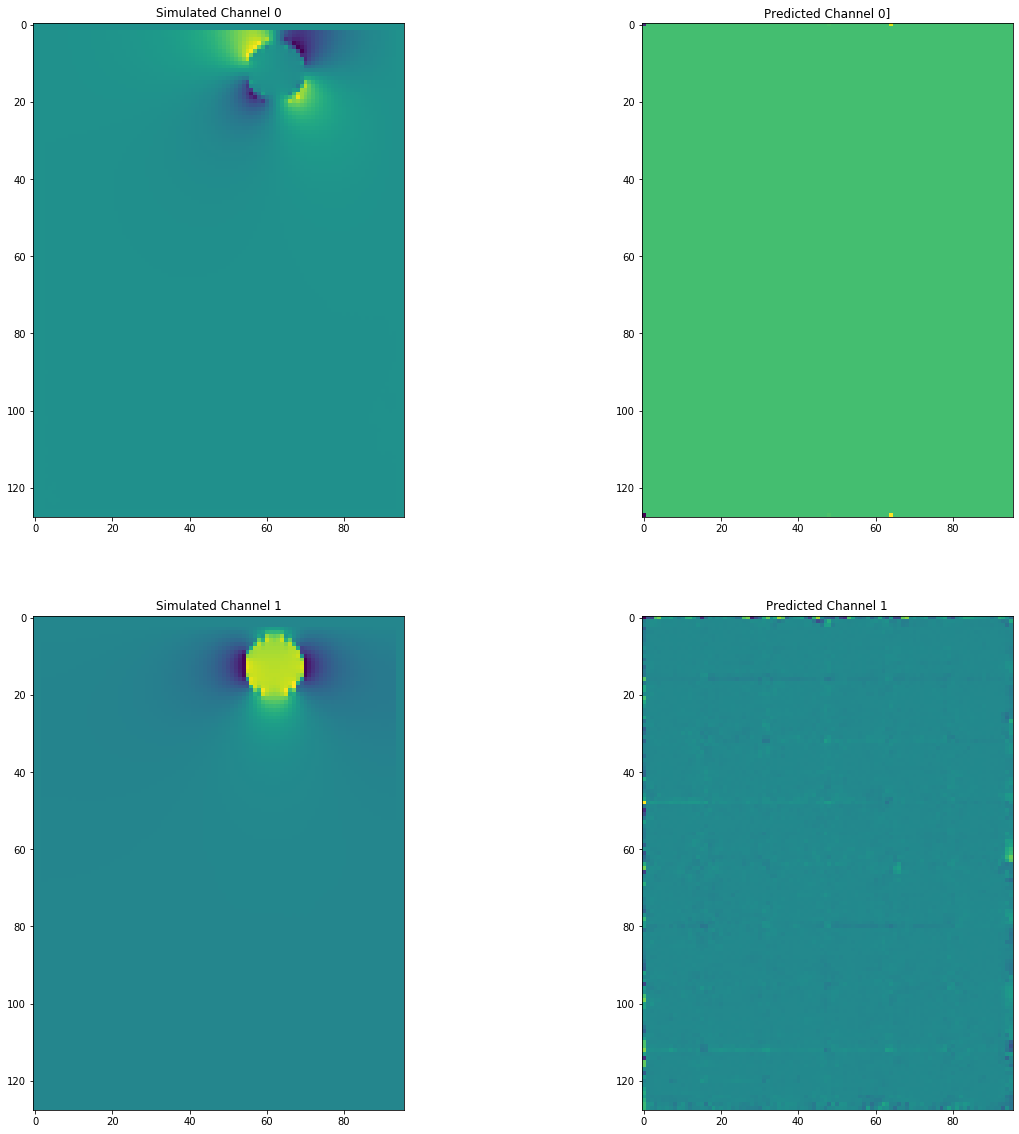

In [32]:
idx = 0 # frame in the batch 
XX = X[idx].detach().cpu().squeeze()
XX_hat = X_hat[idx].detach().cpu().squeeze()
plotSampleWpredictionByChannel(XX, XX_hat)

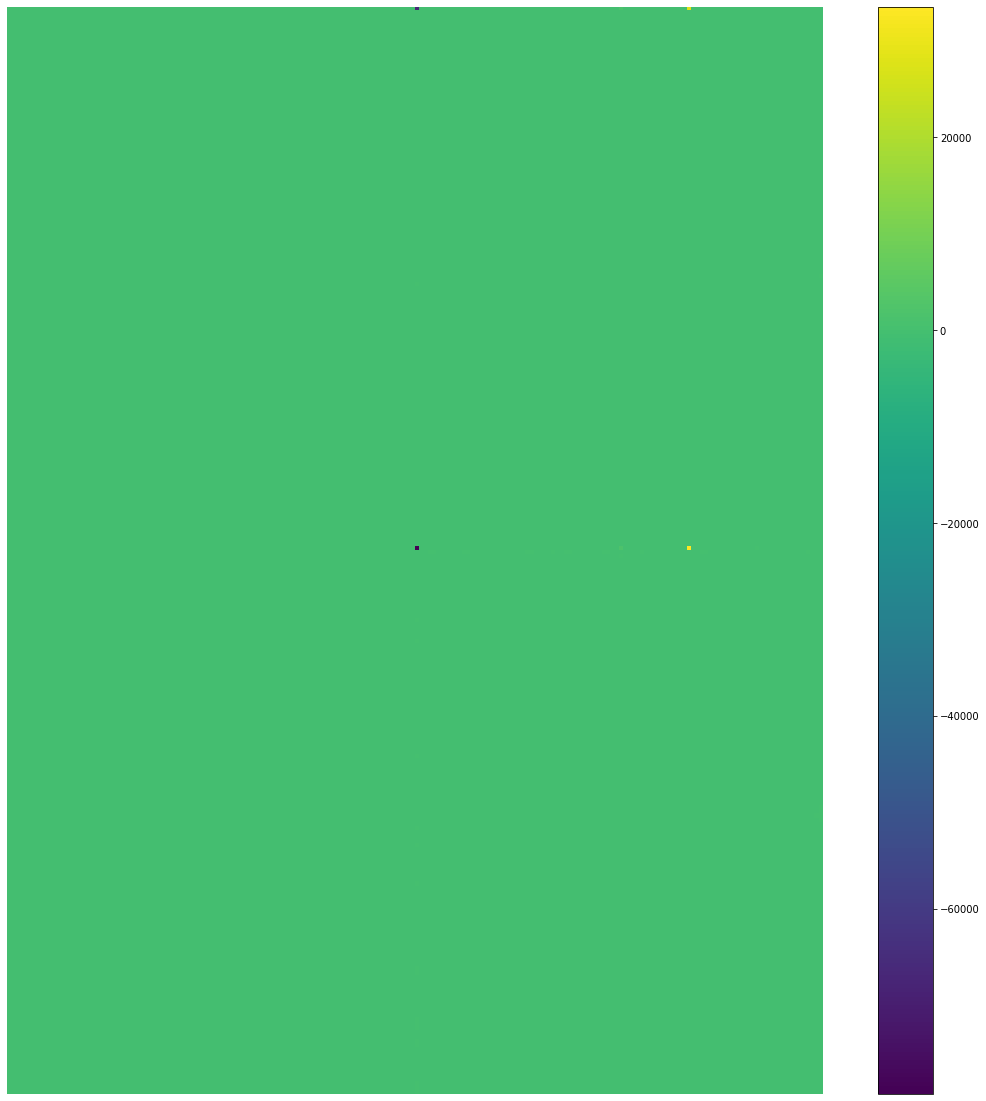

In [33]:
plotSampleWprediction(XX, XX_hat)

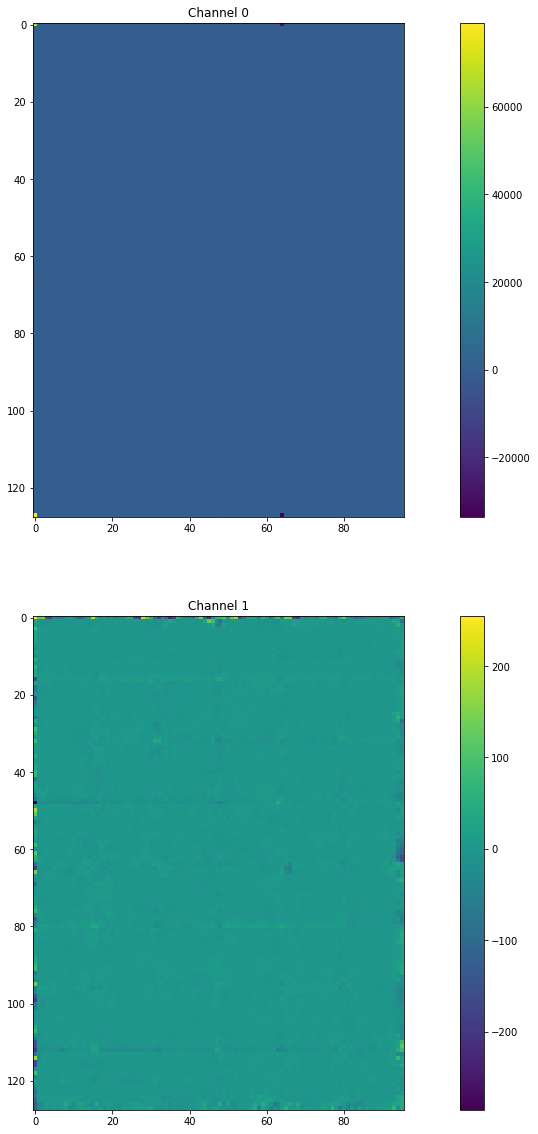

In [34]:
plotSample(XX-XX_hat)

### Visualize full simulation

In [35]:
simData = getSingleSim(sim=simVizIndex,dataDirec=testData)
simDataset = MantaFlowDataset(simData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False)
simDataLoader = DataLoader(simDataset,batch_size=1)

100%|██████████| 200/200 [00:00<00:00, 631.47it/s]


/net/10.57.1.2/vol/homes/widemann1/surrogates4sims/surrogates4sims/utils.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,20))


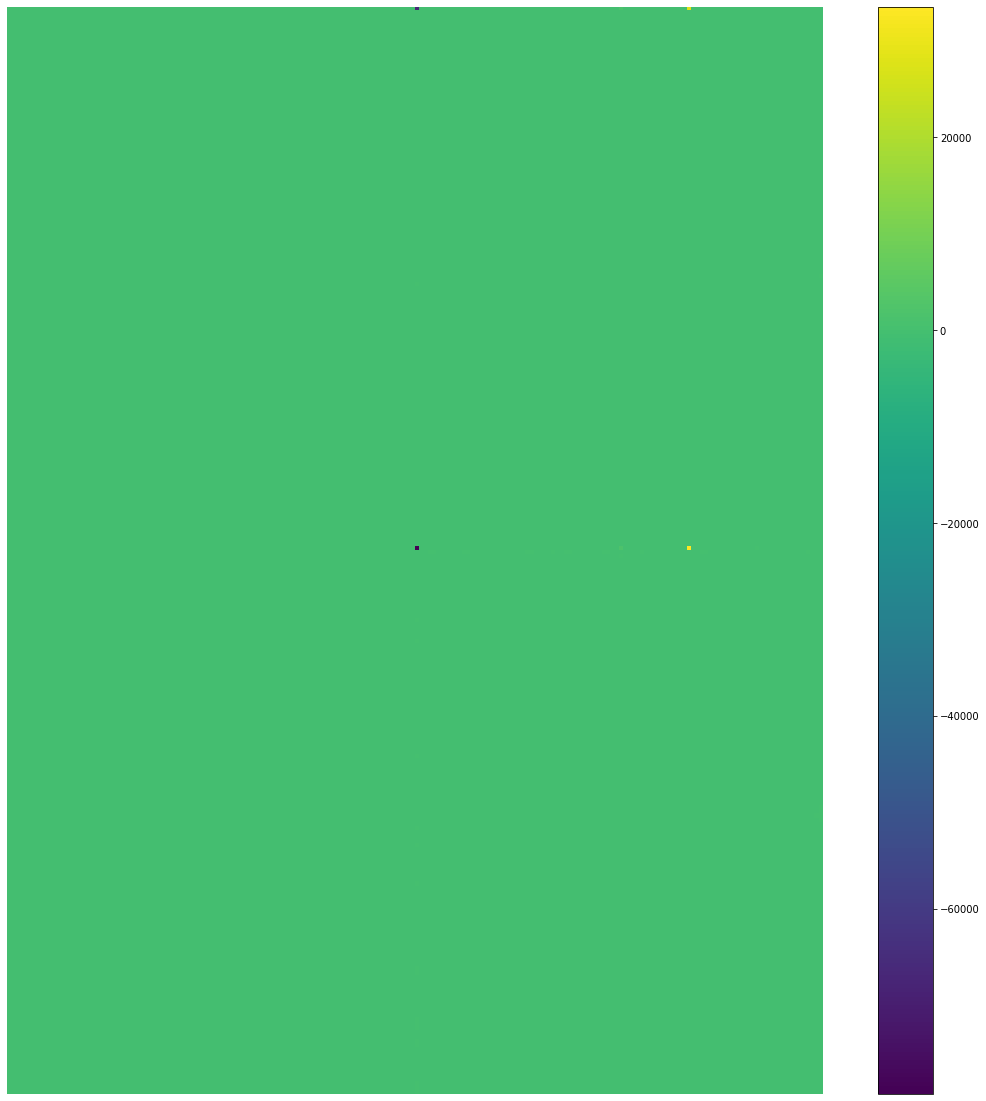

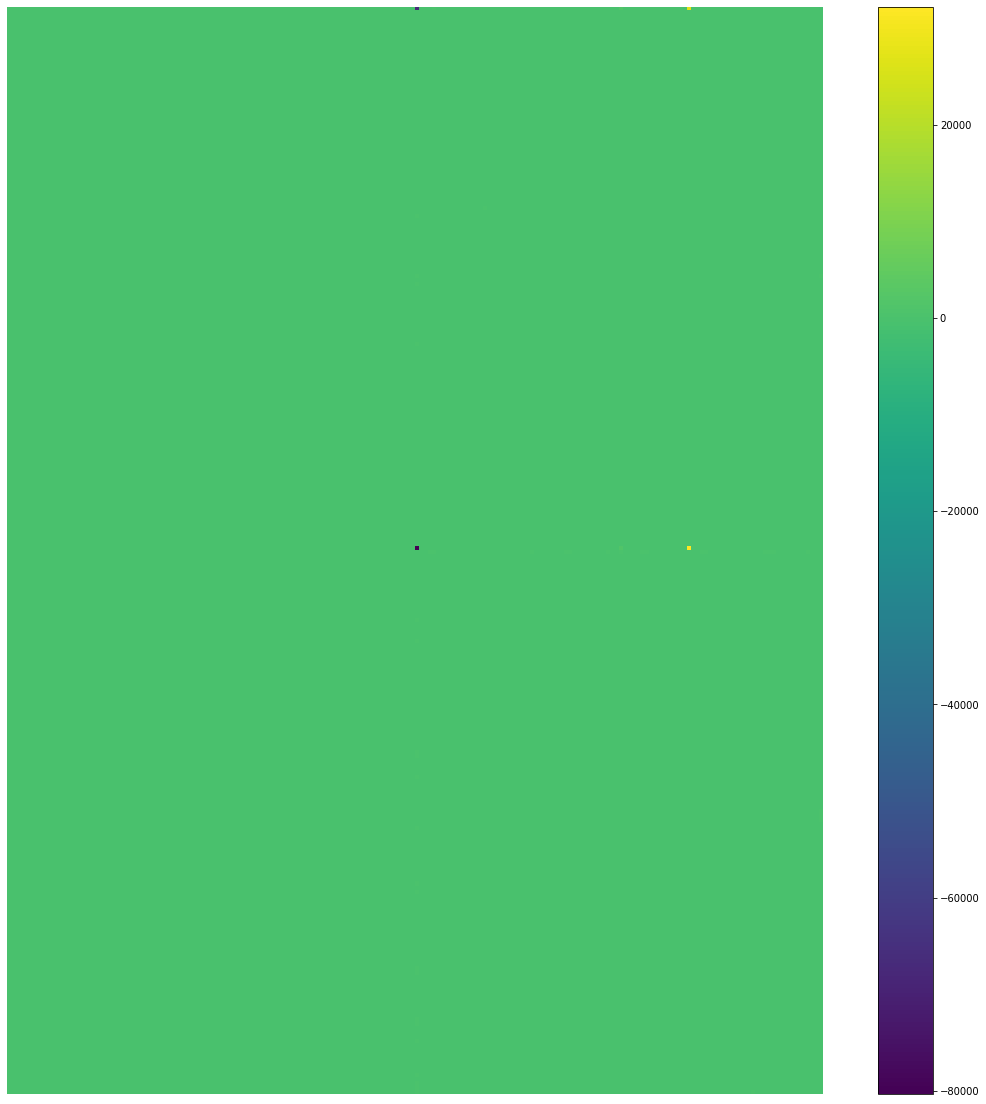

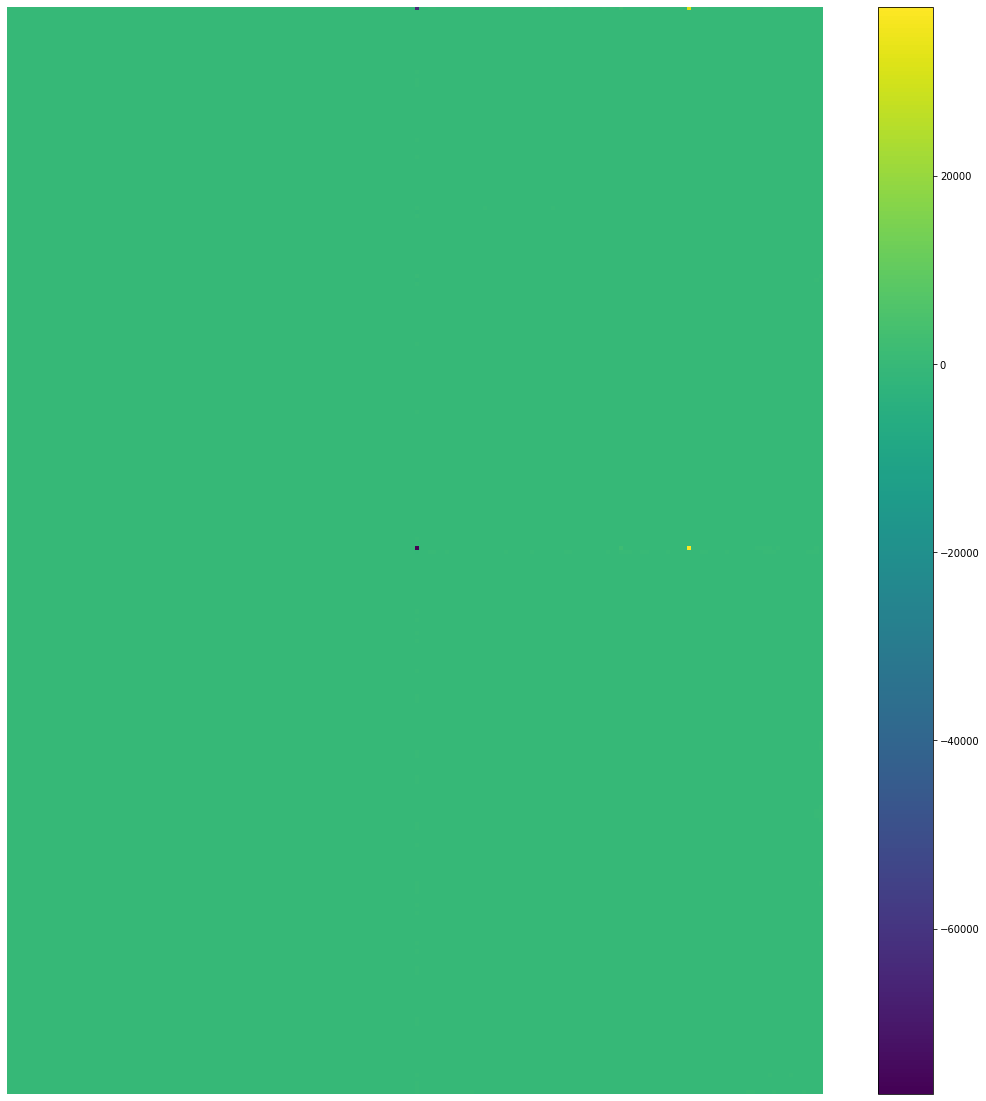

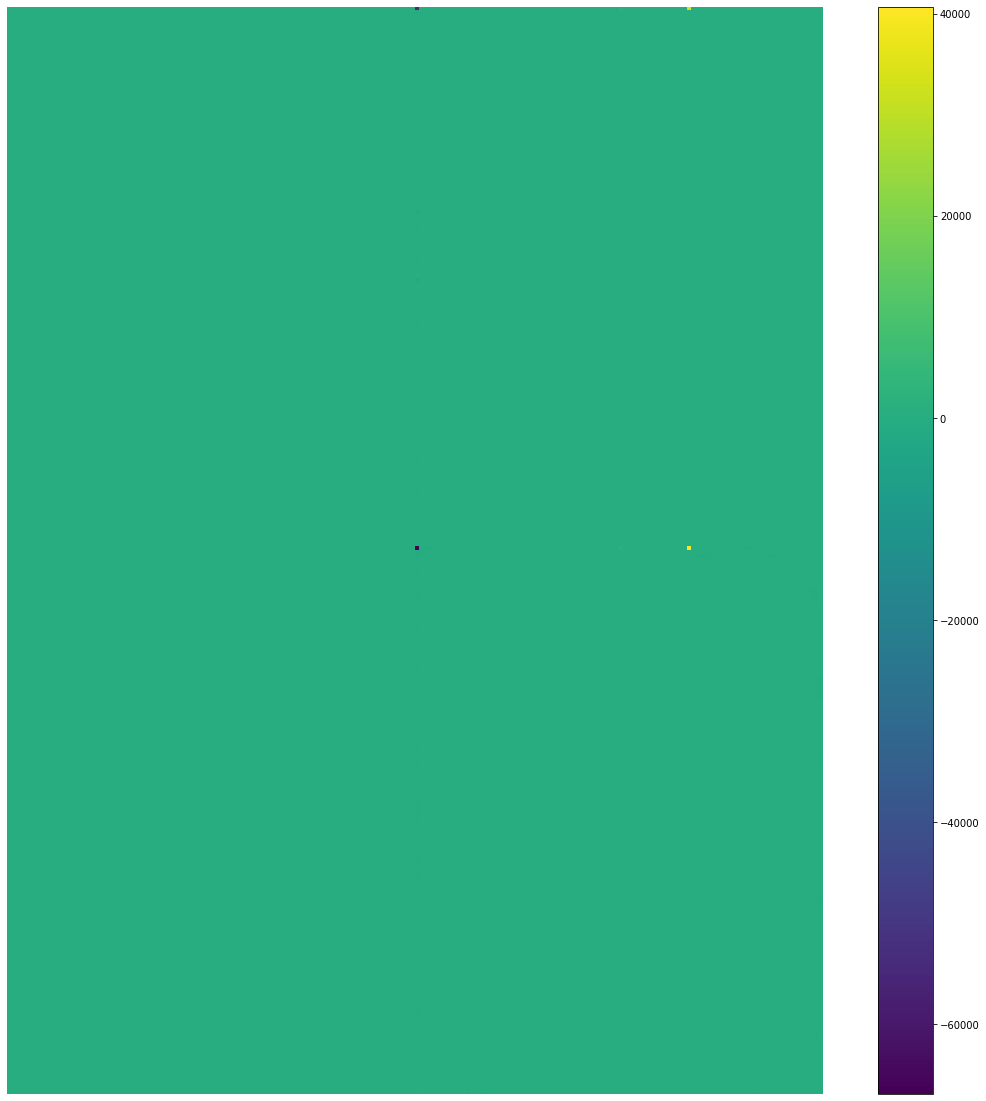

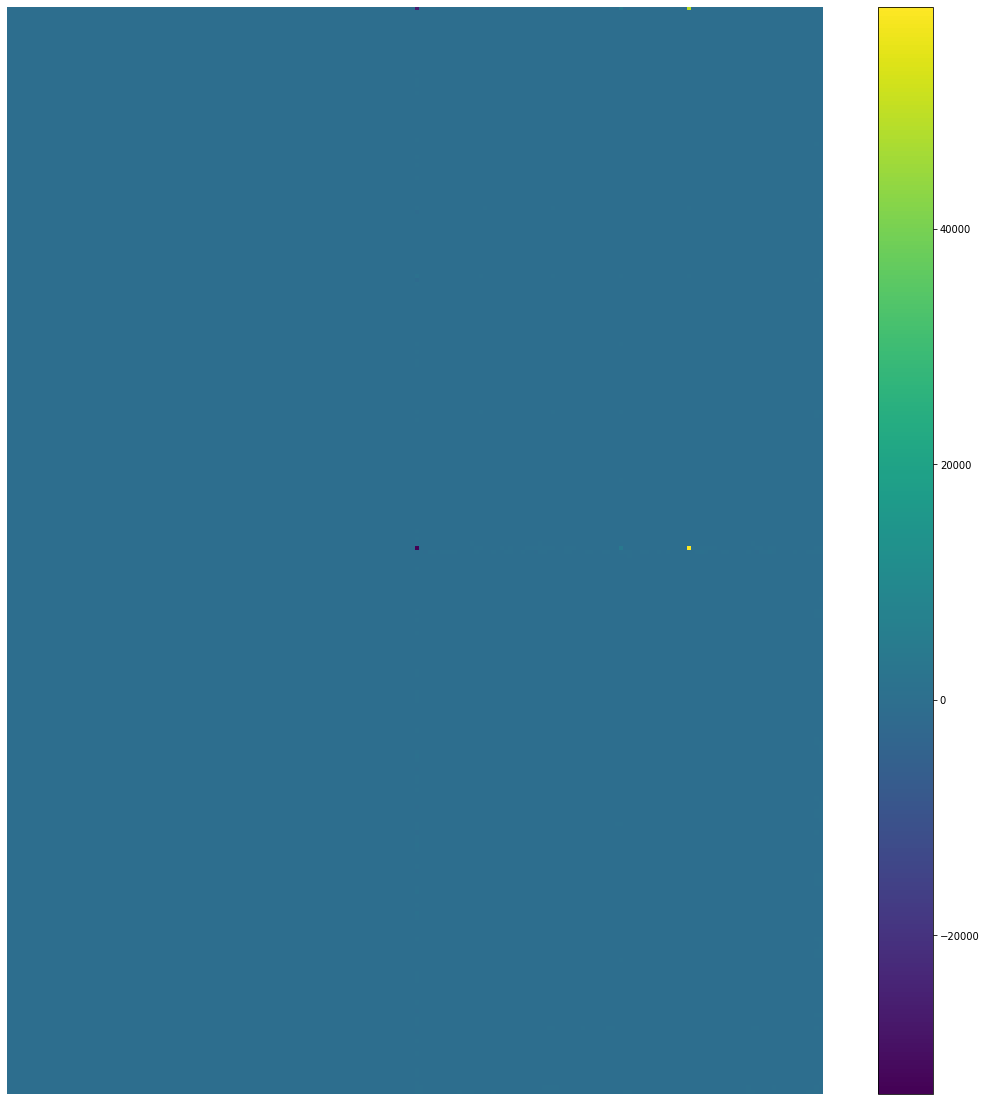

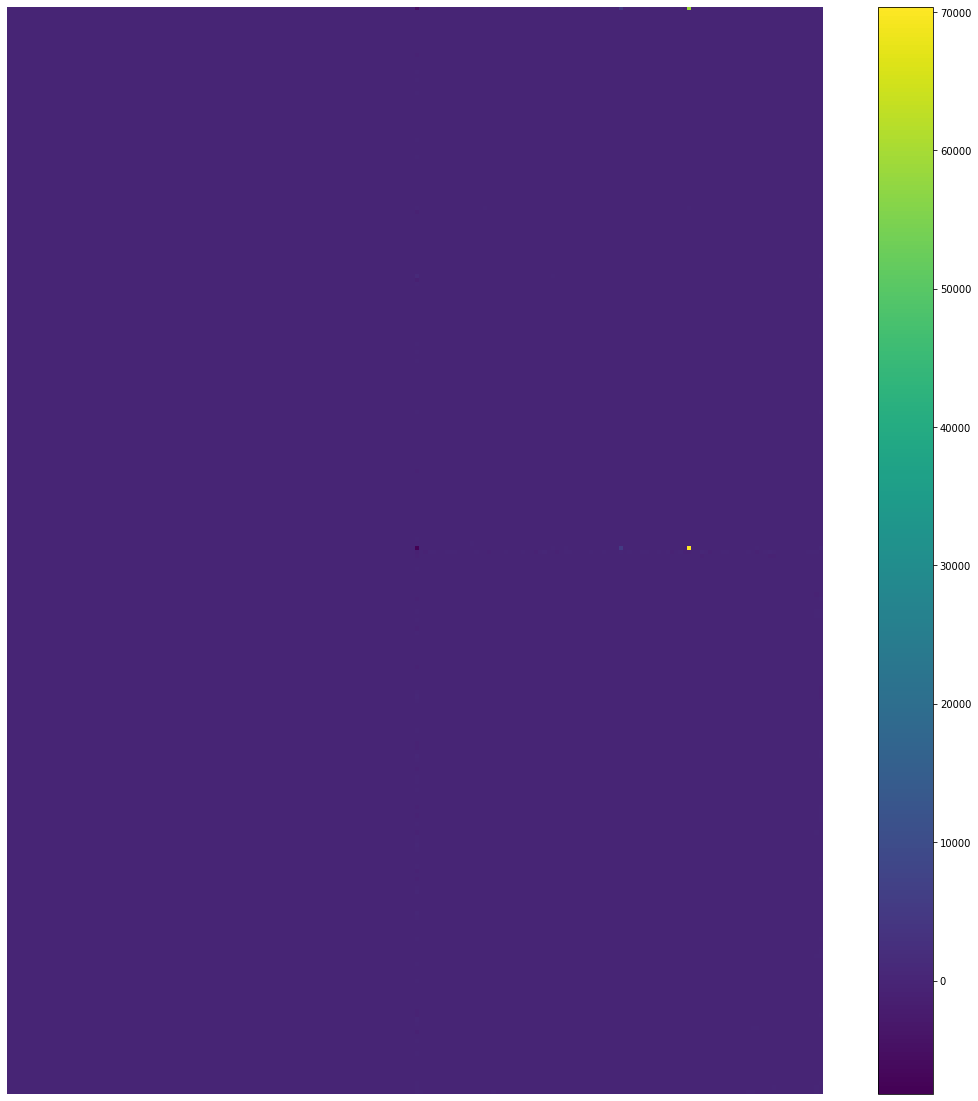

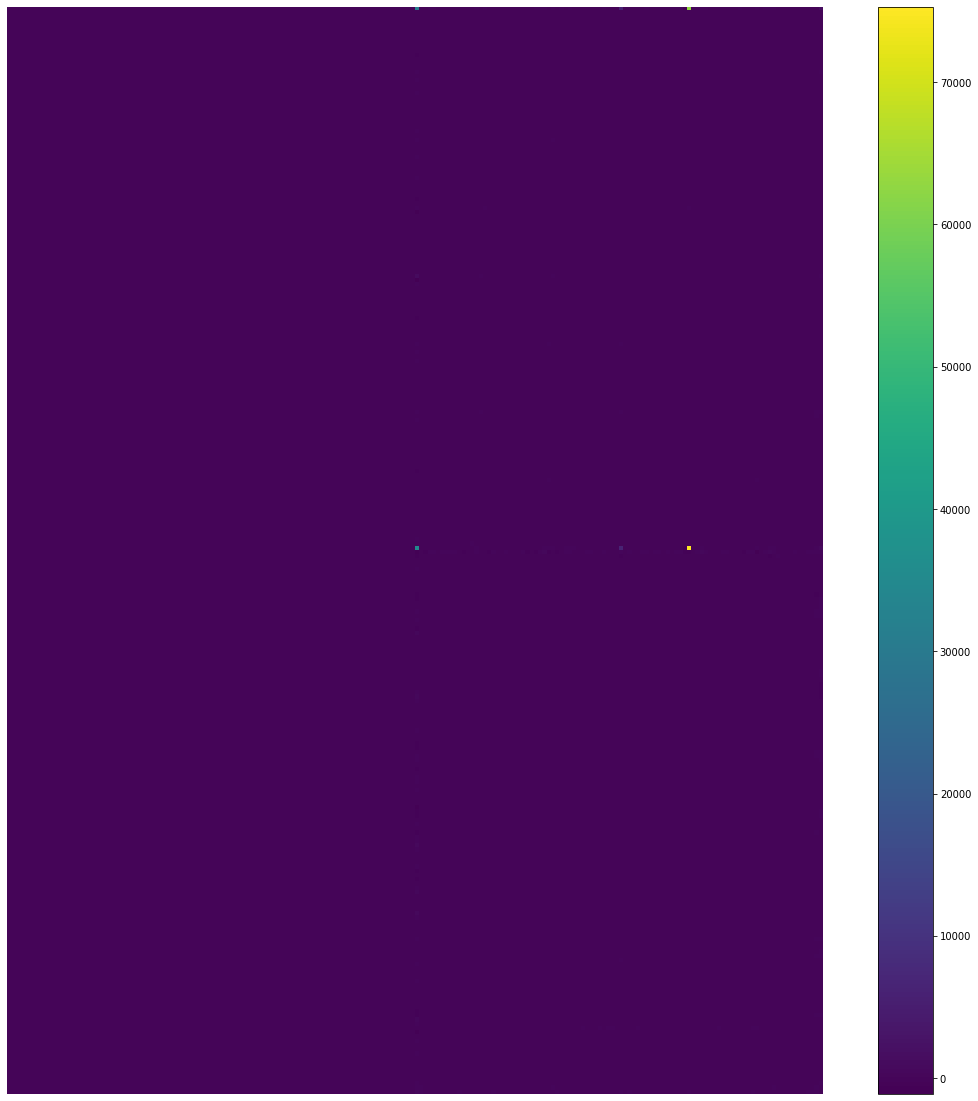

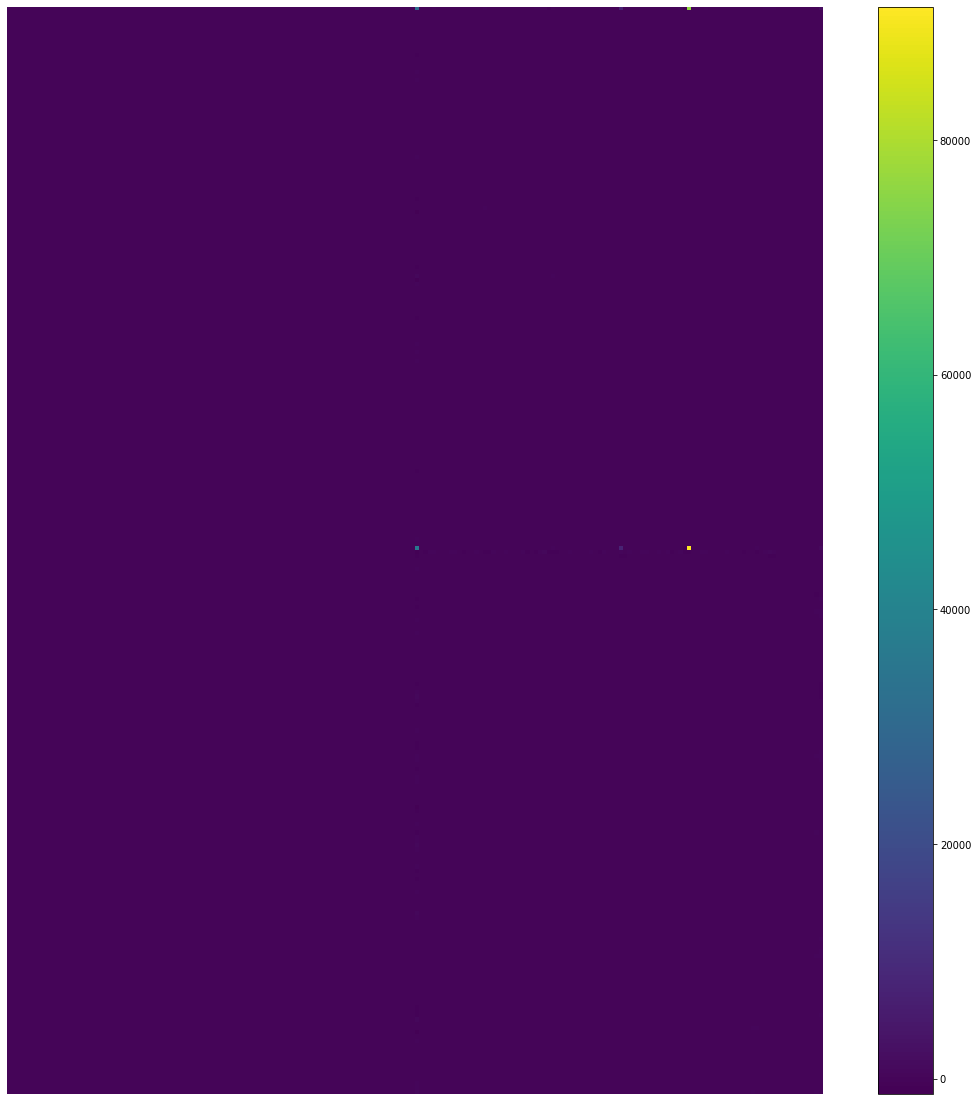

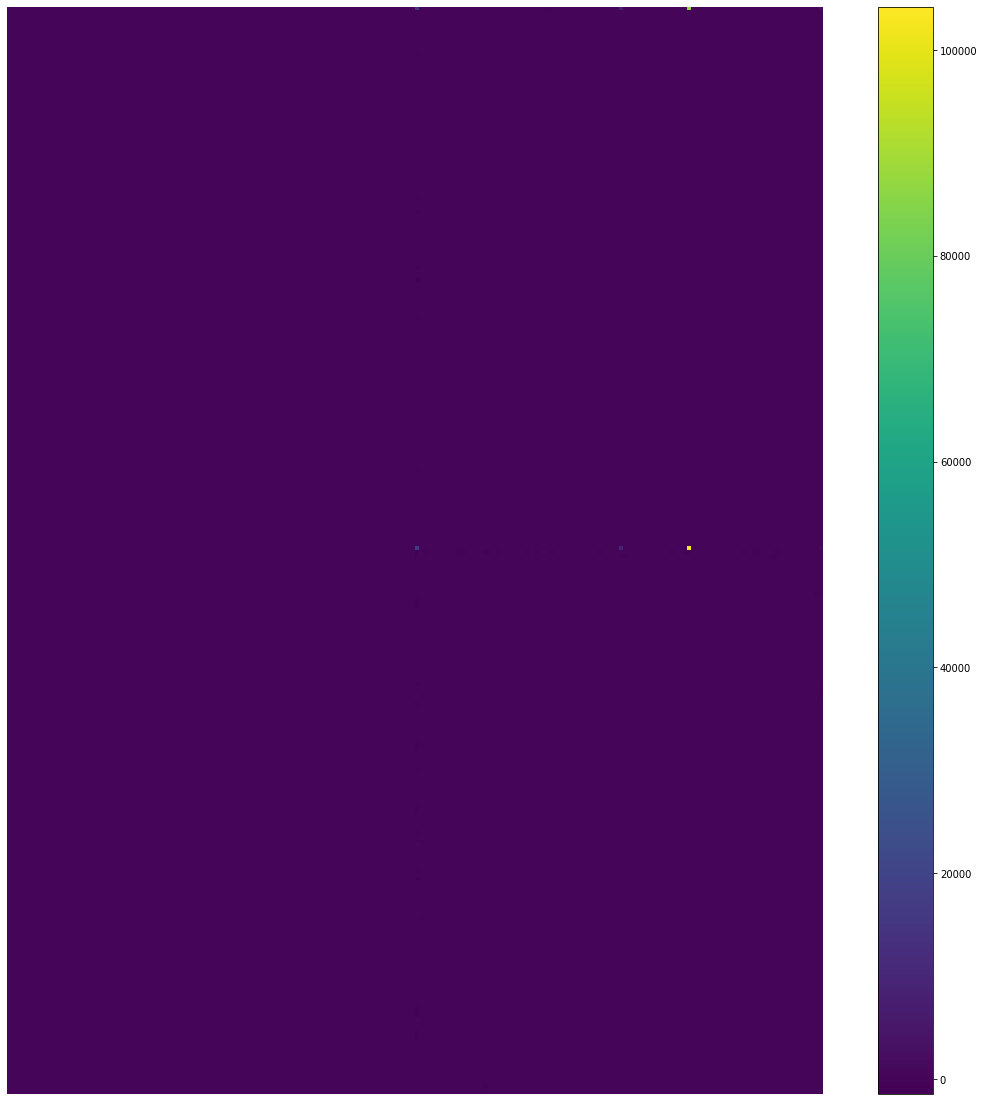

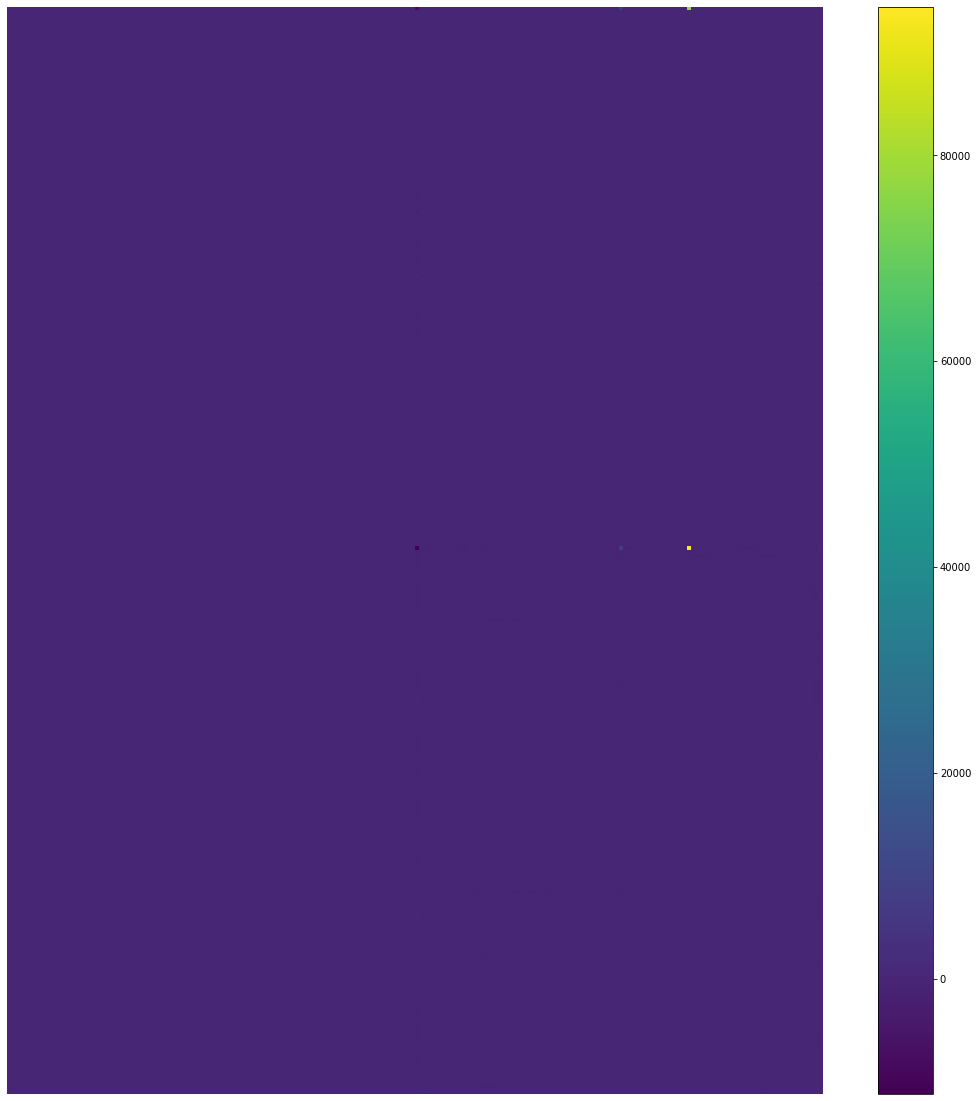

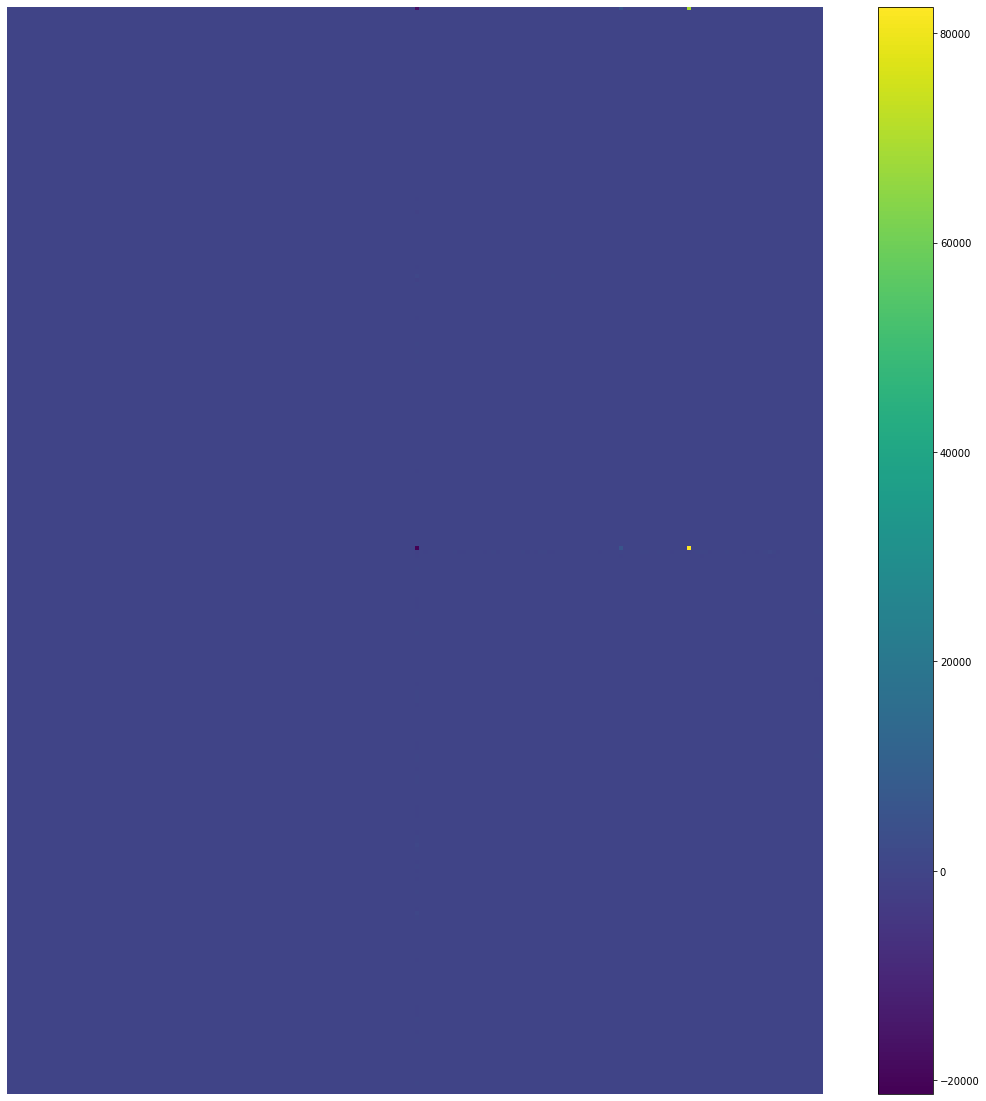

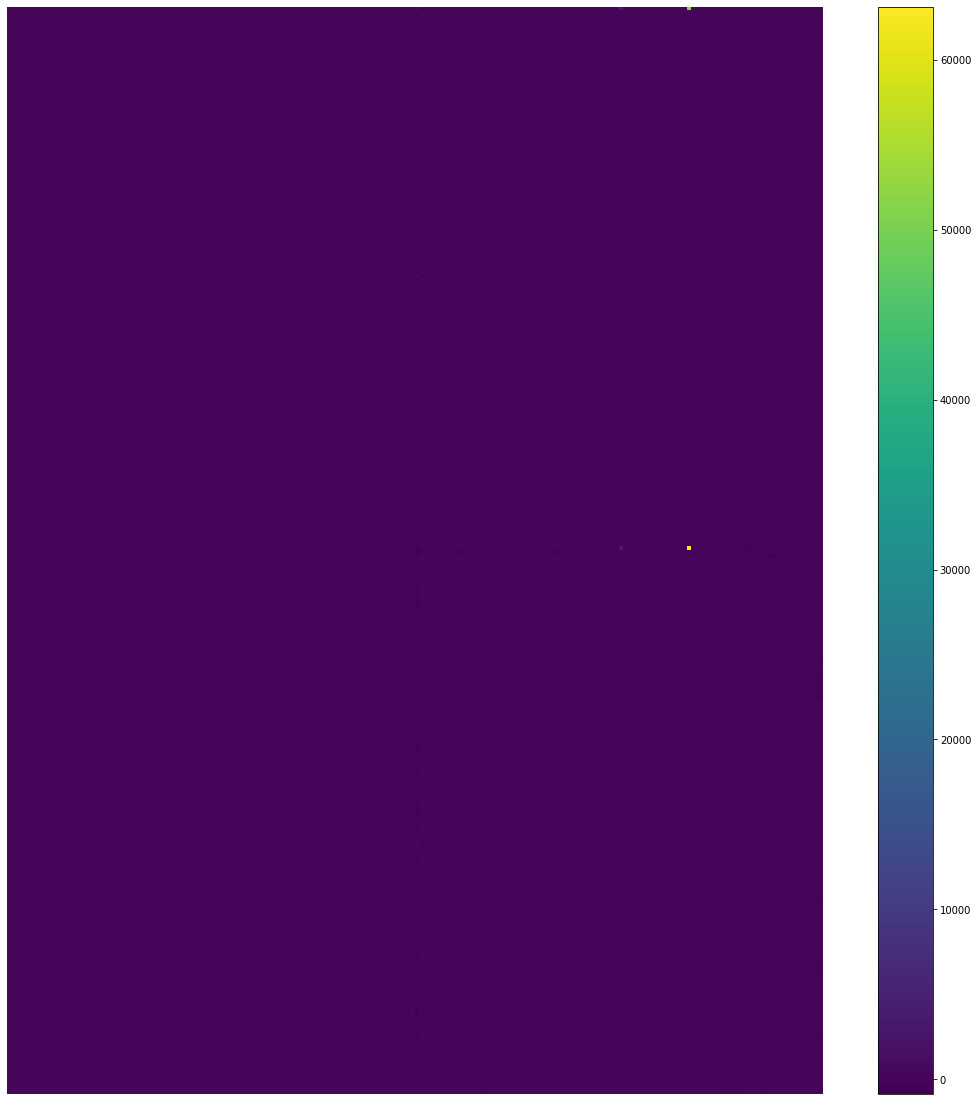

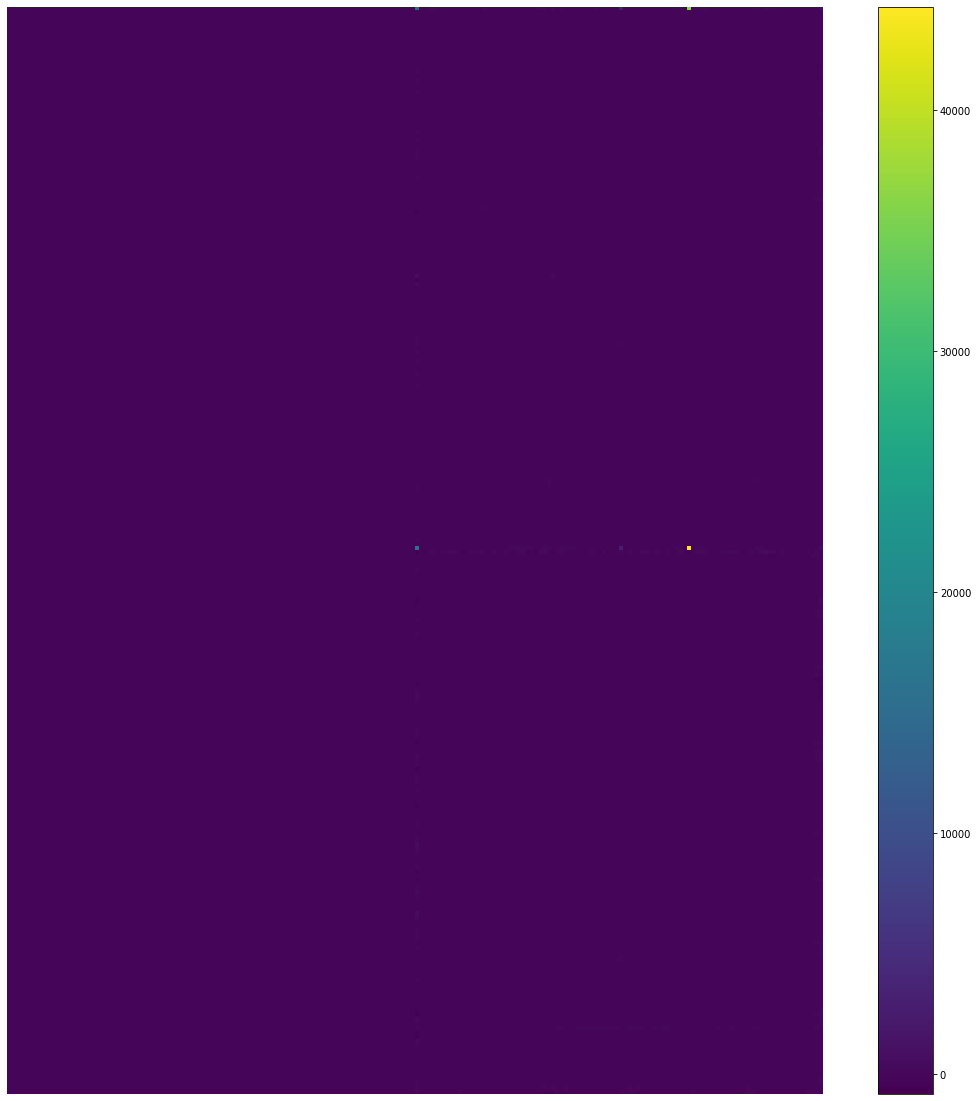

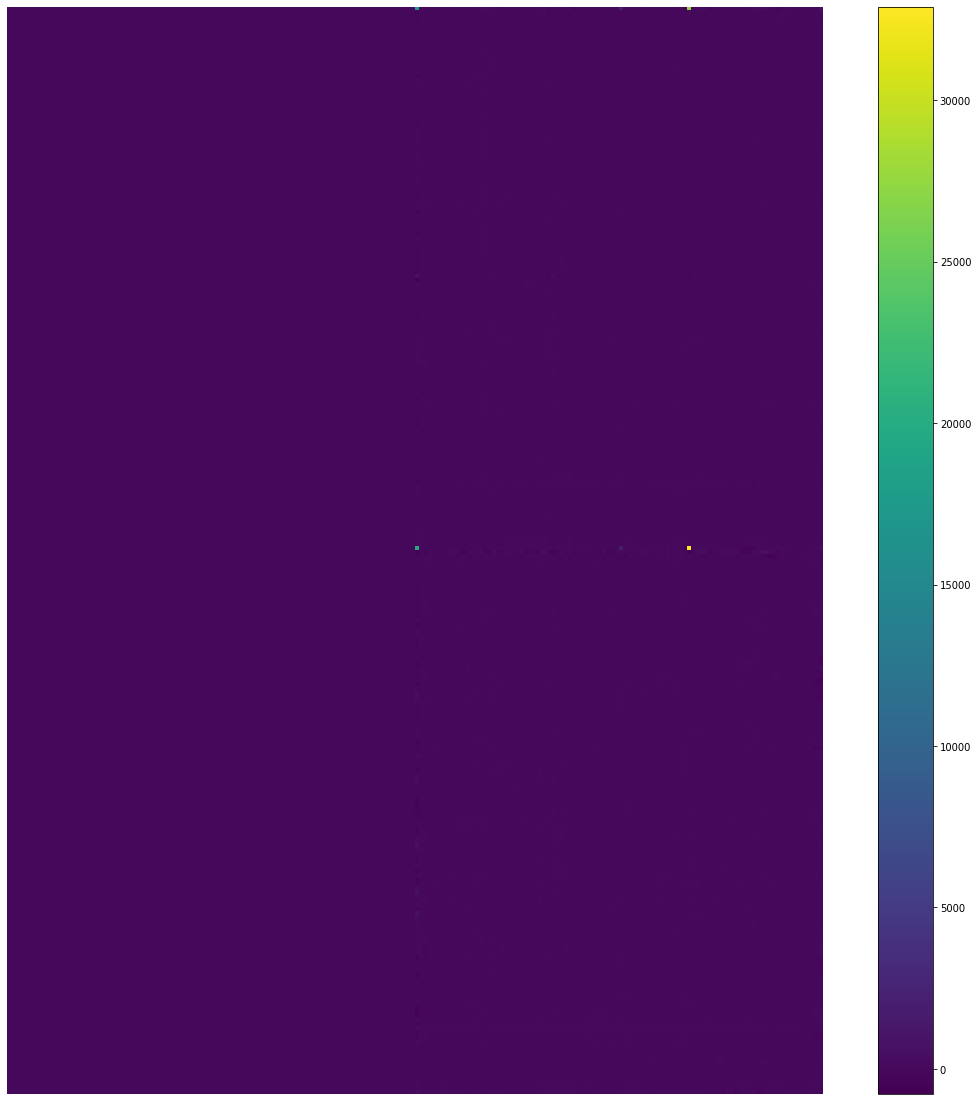

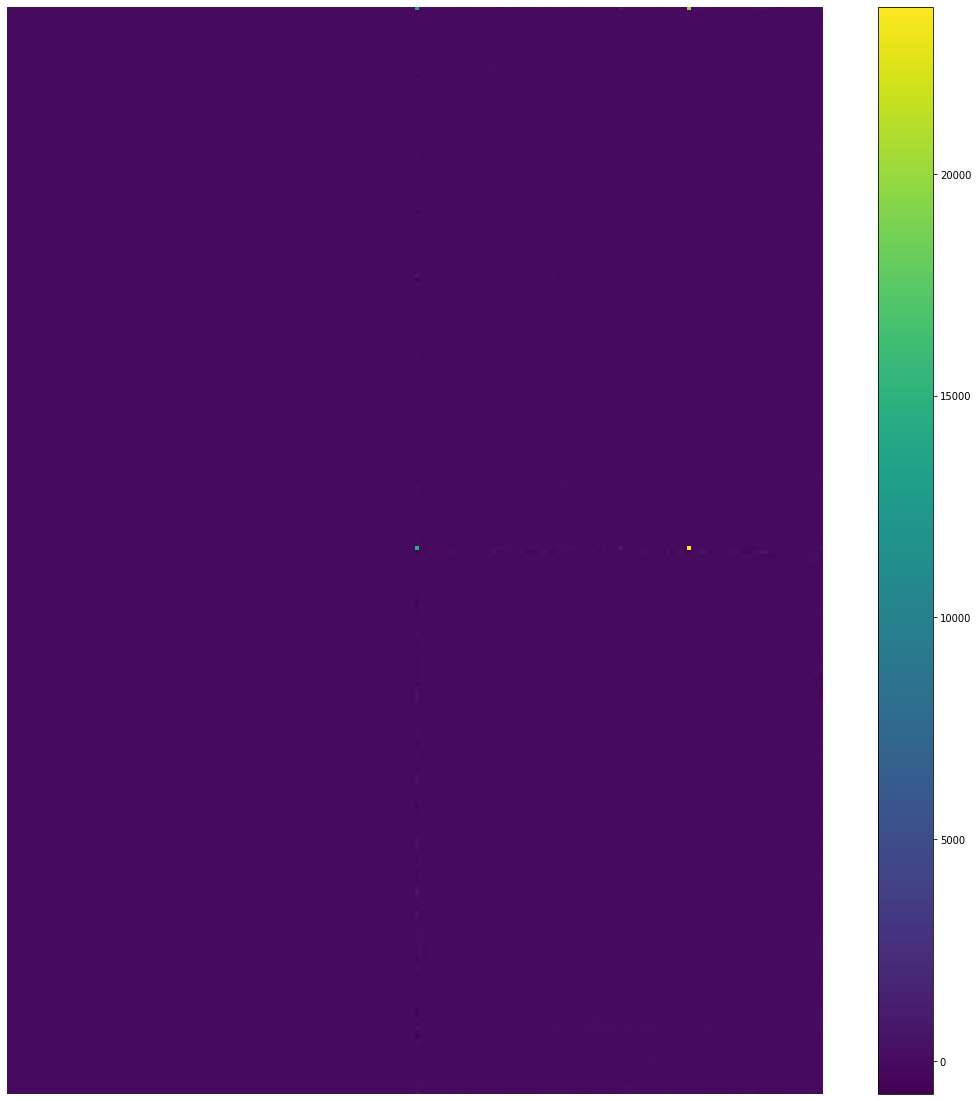

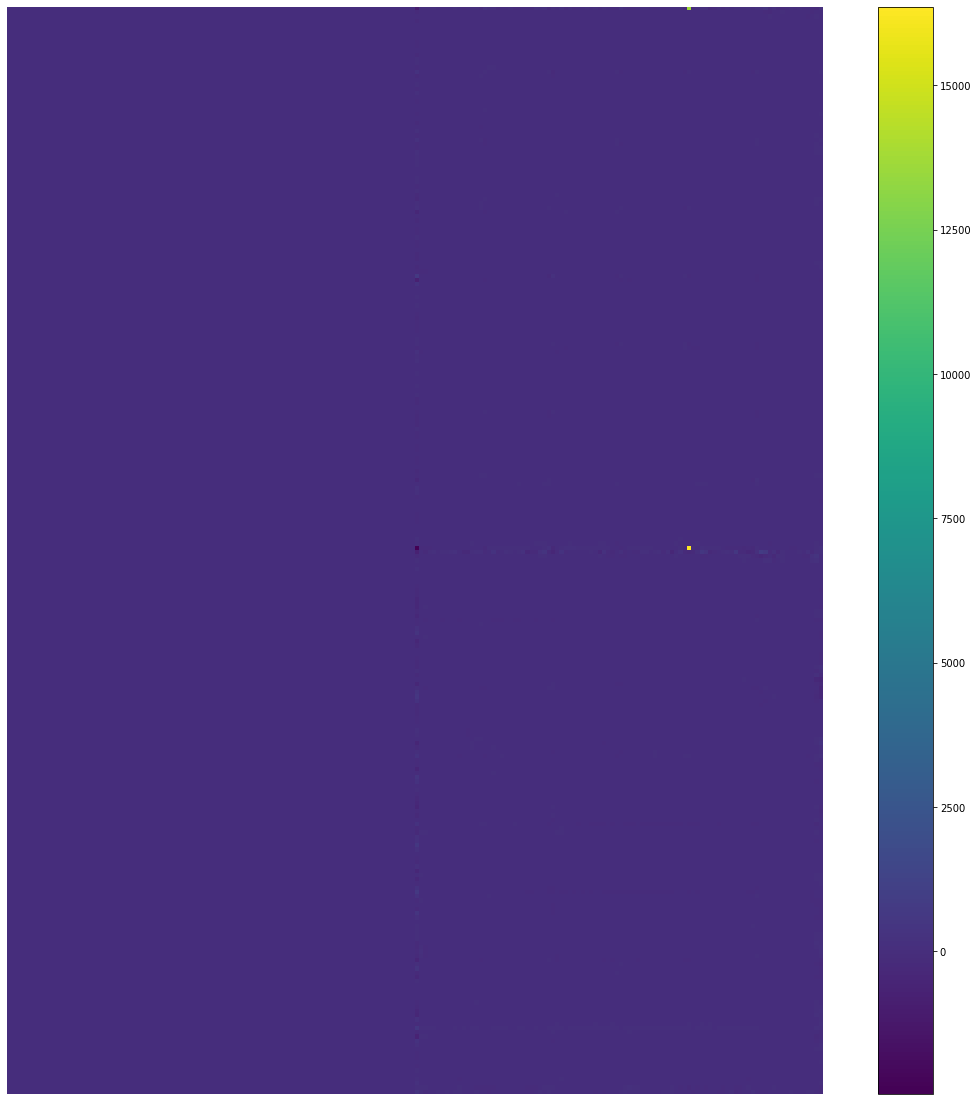

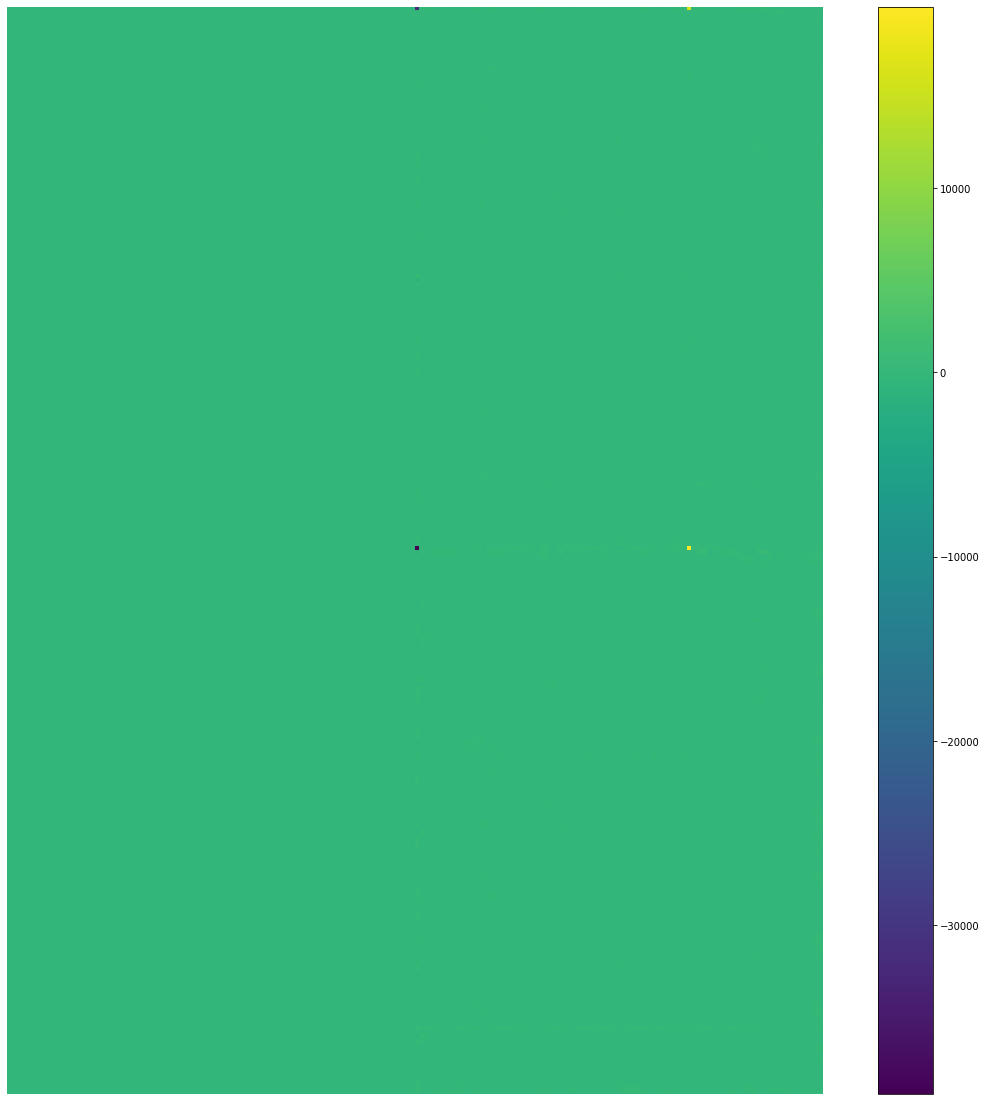

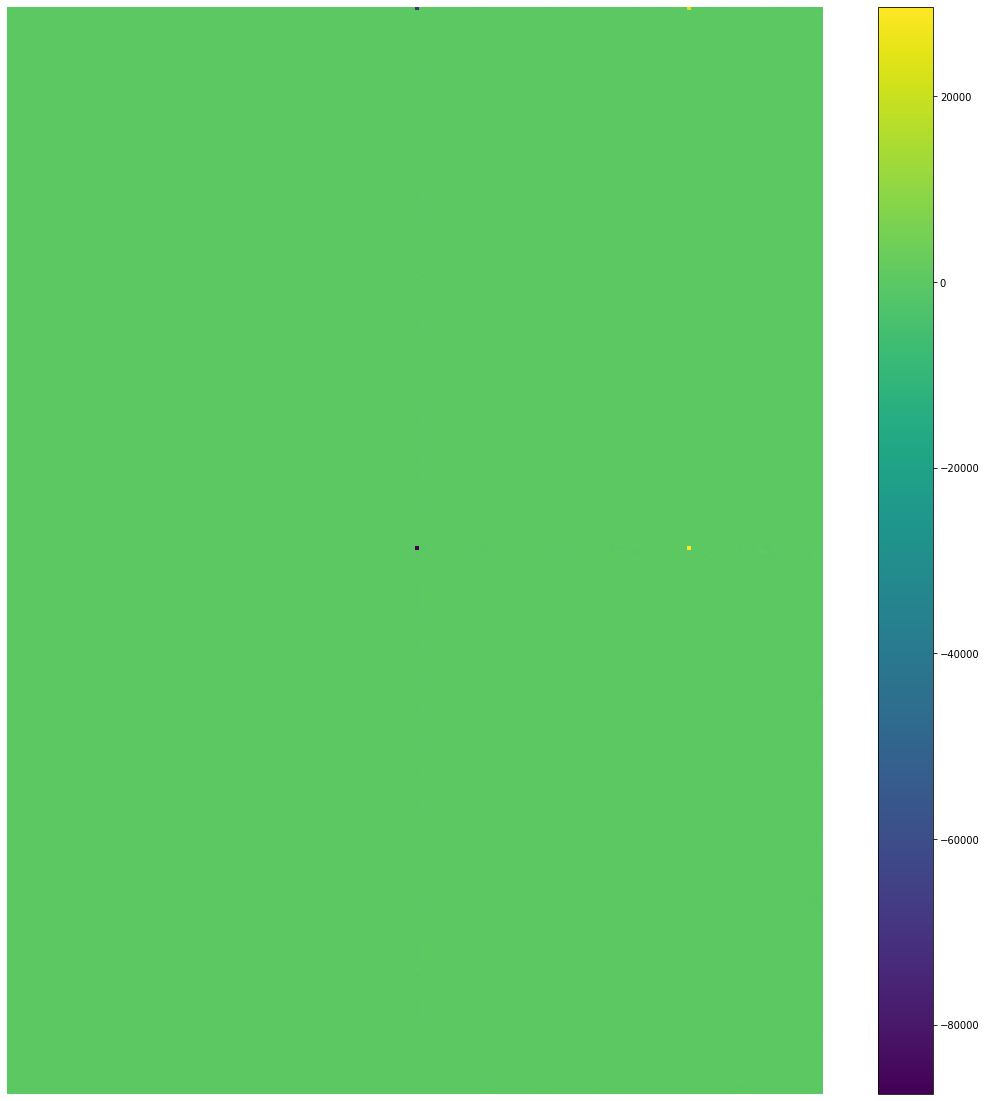

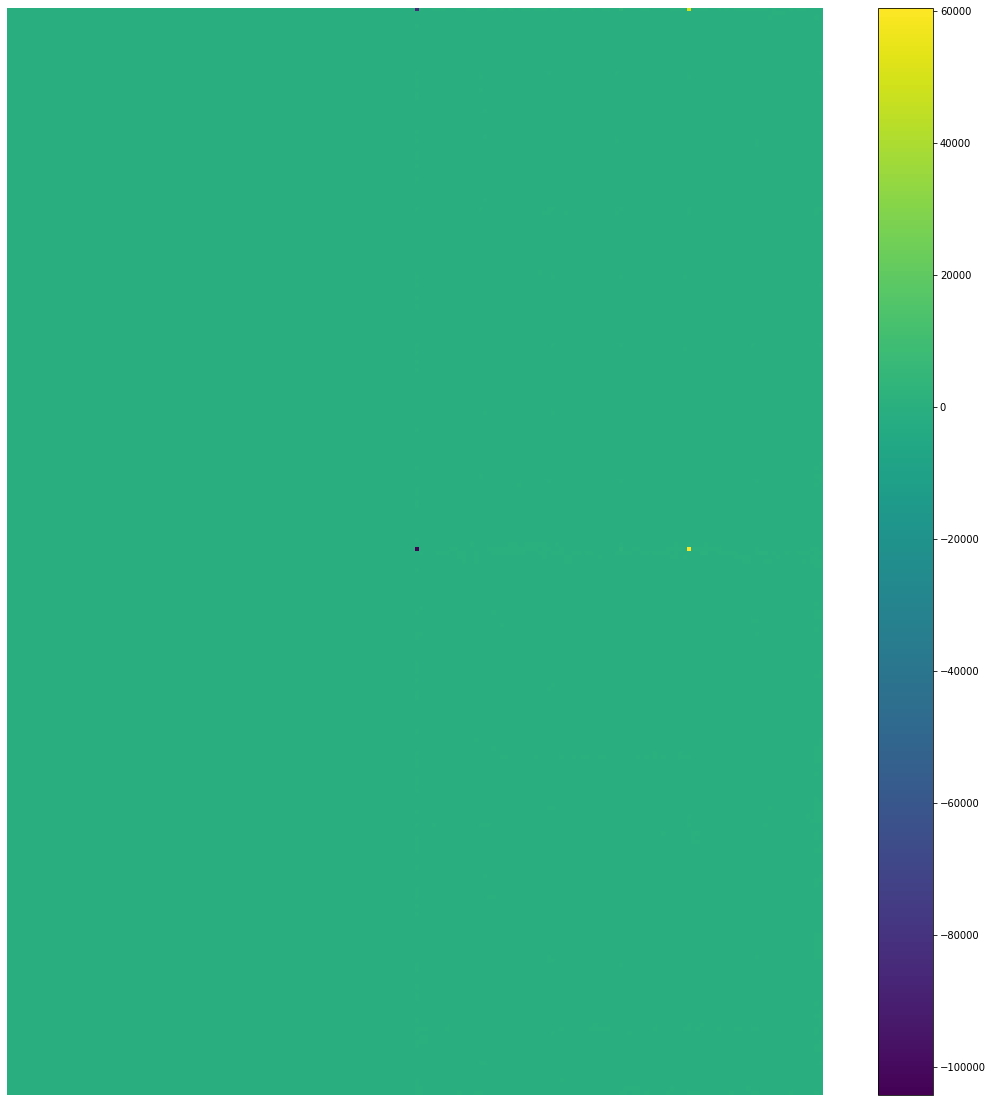

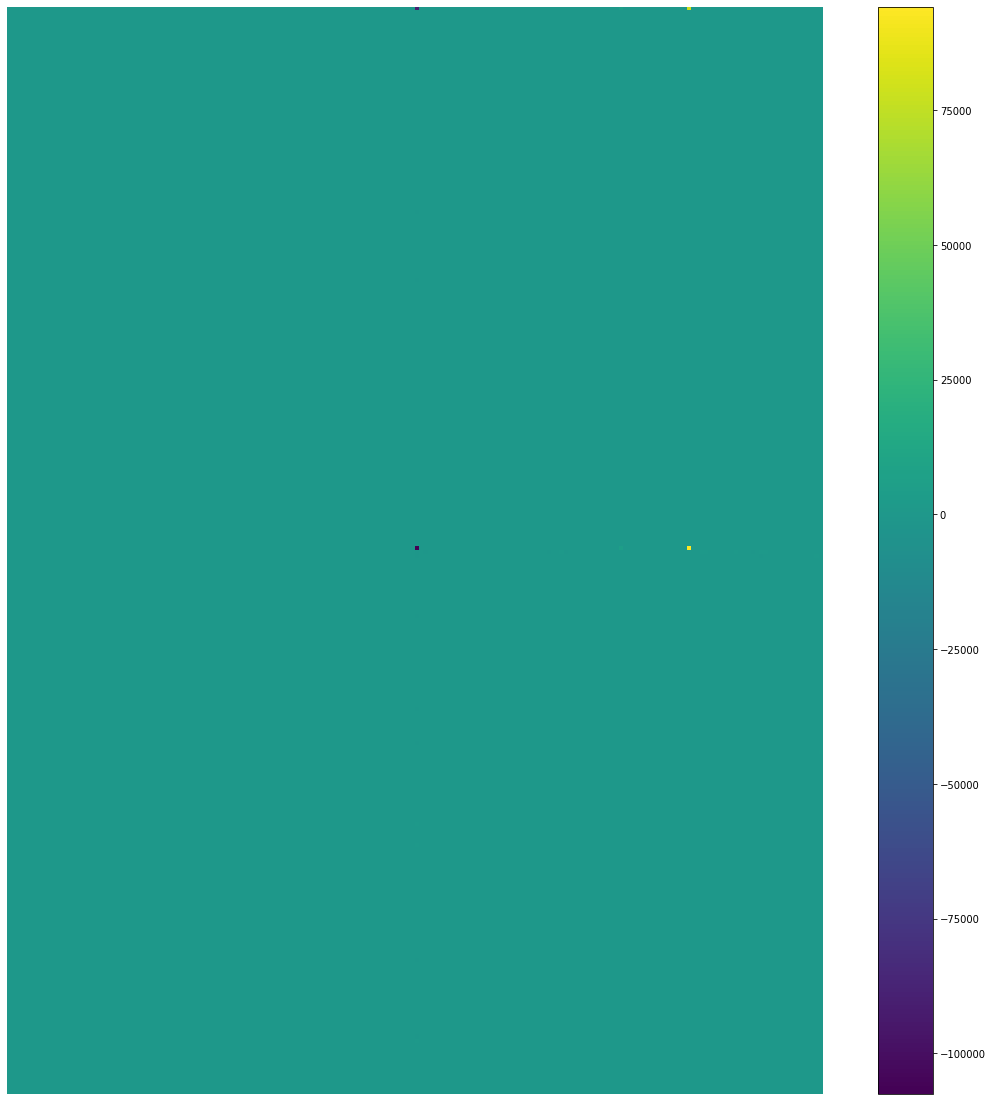

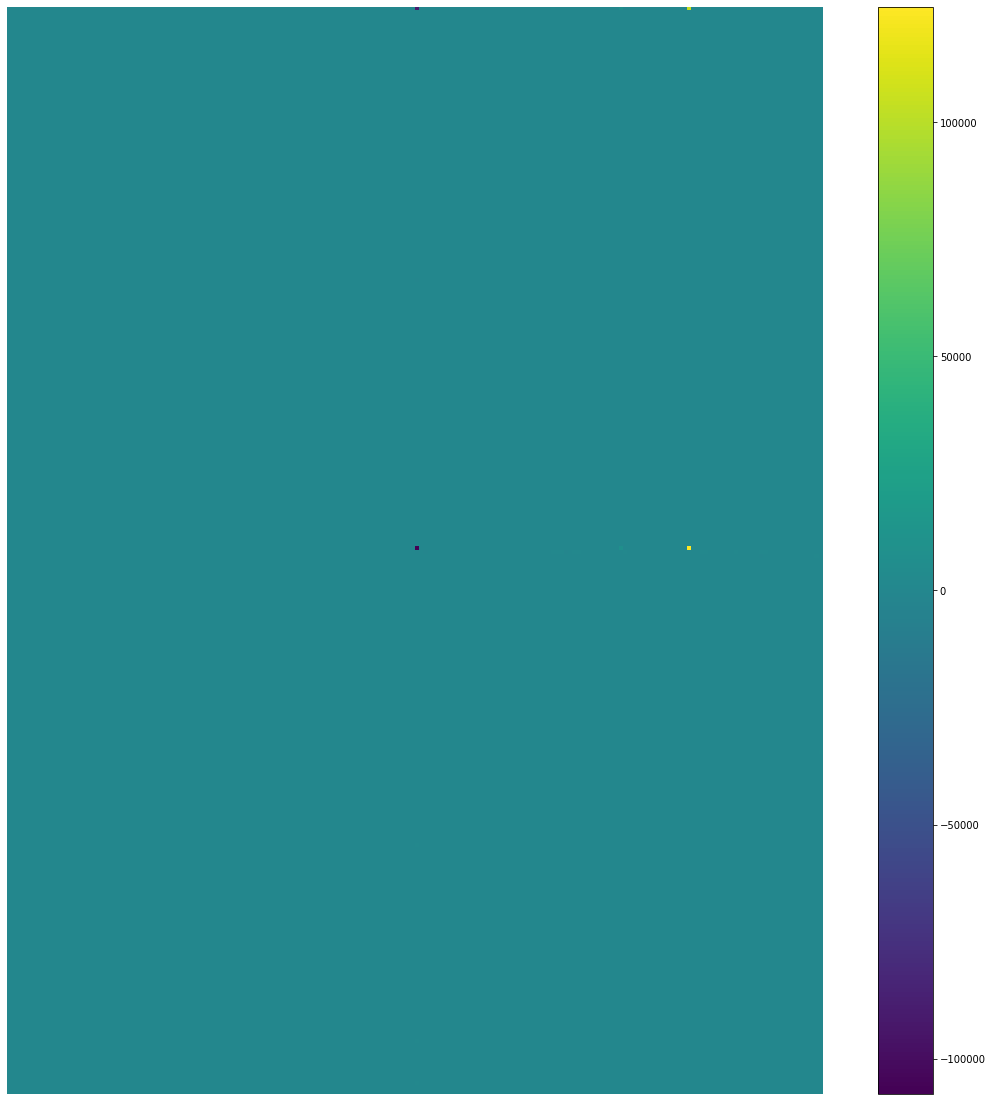

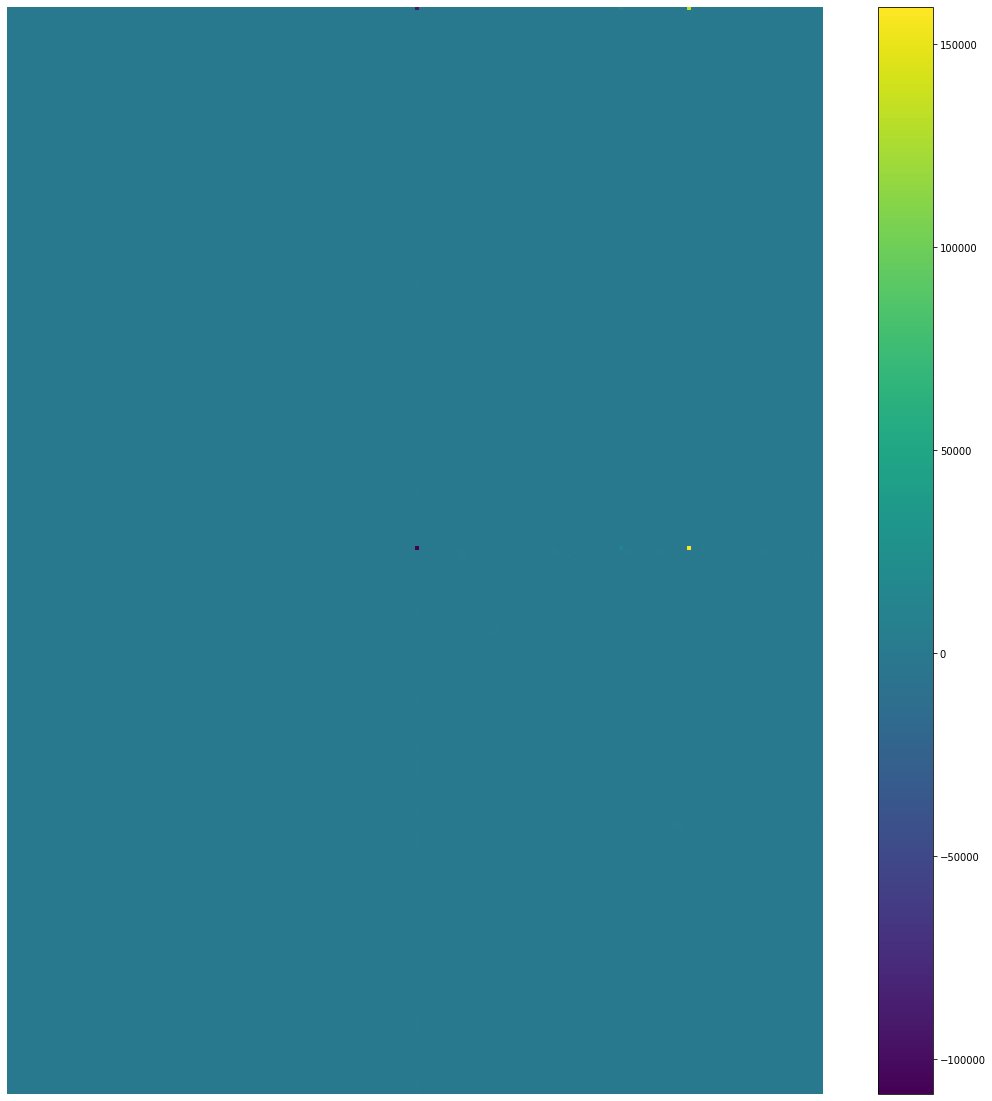

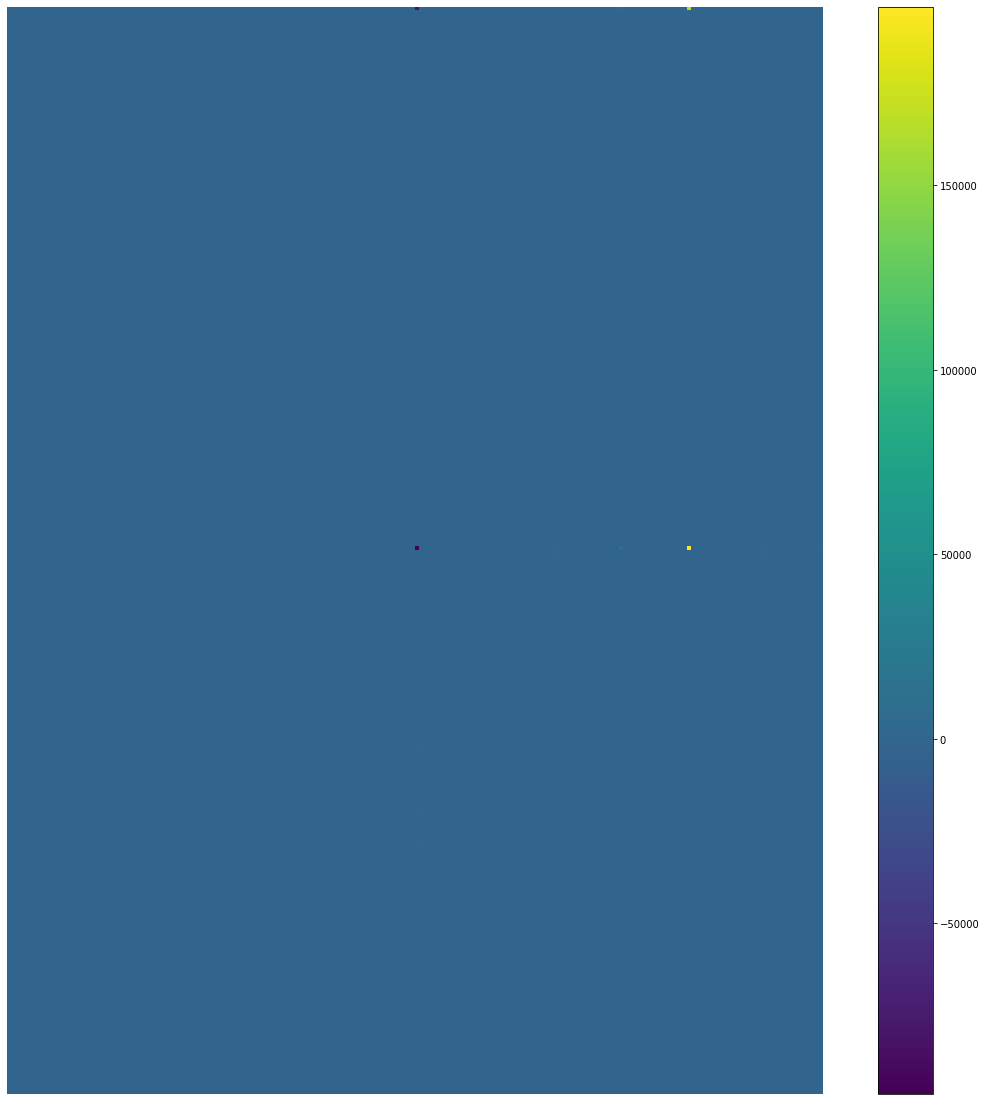

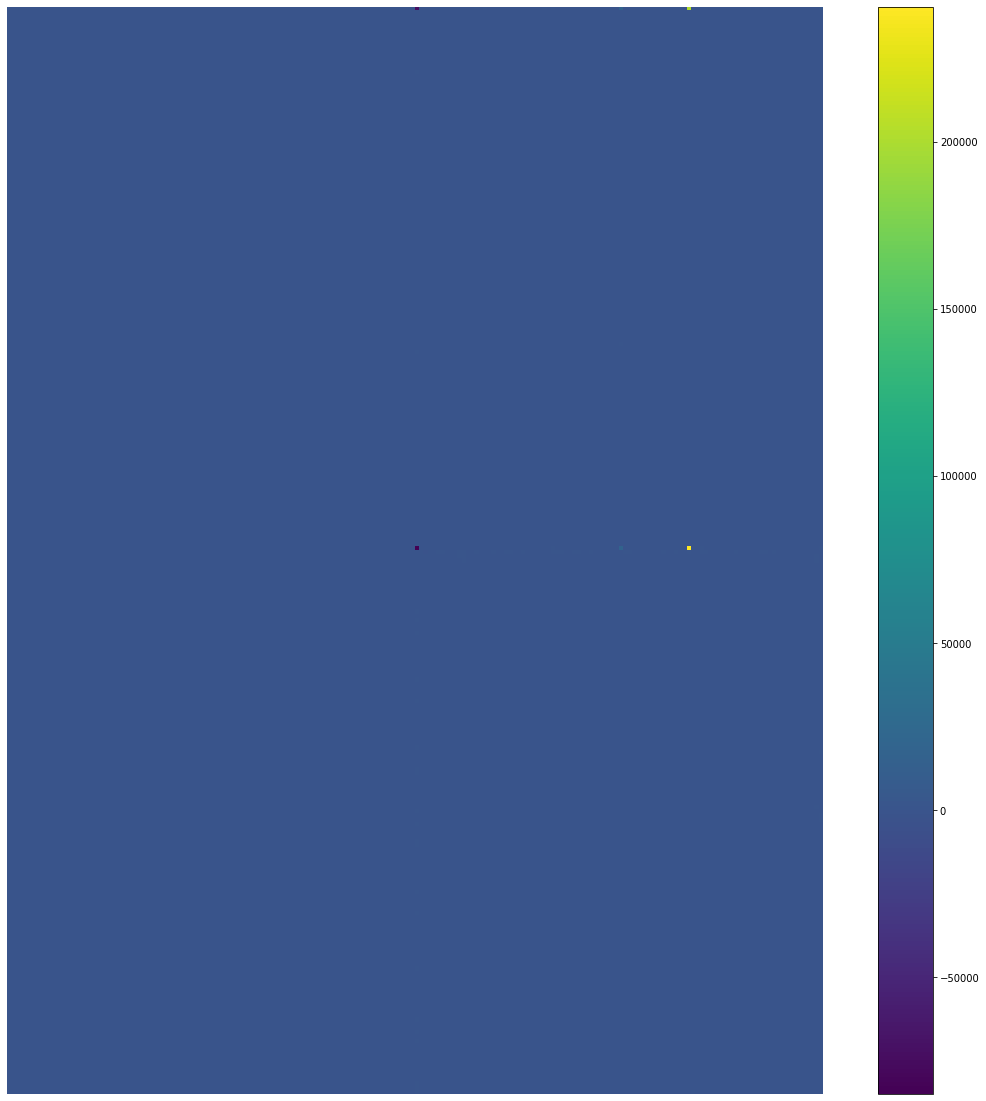

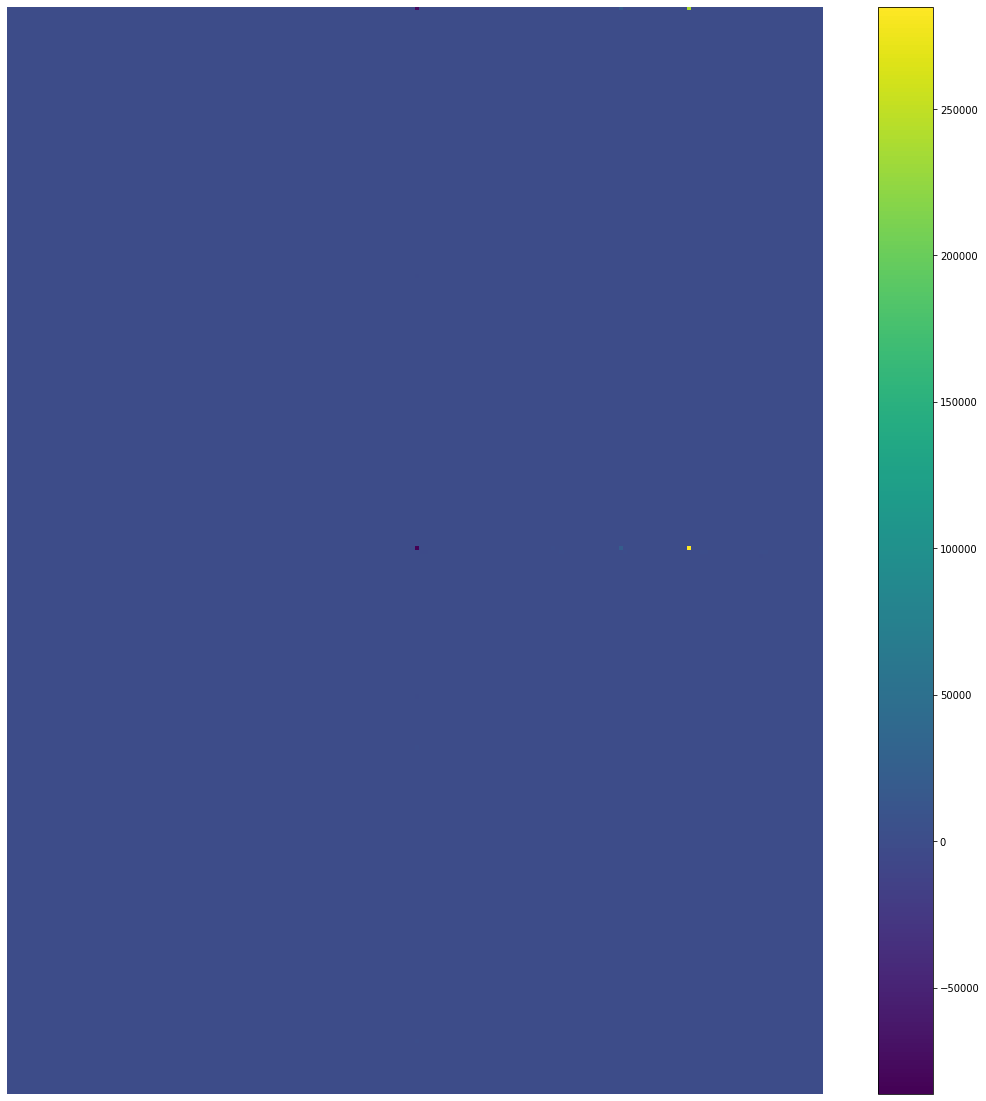

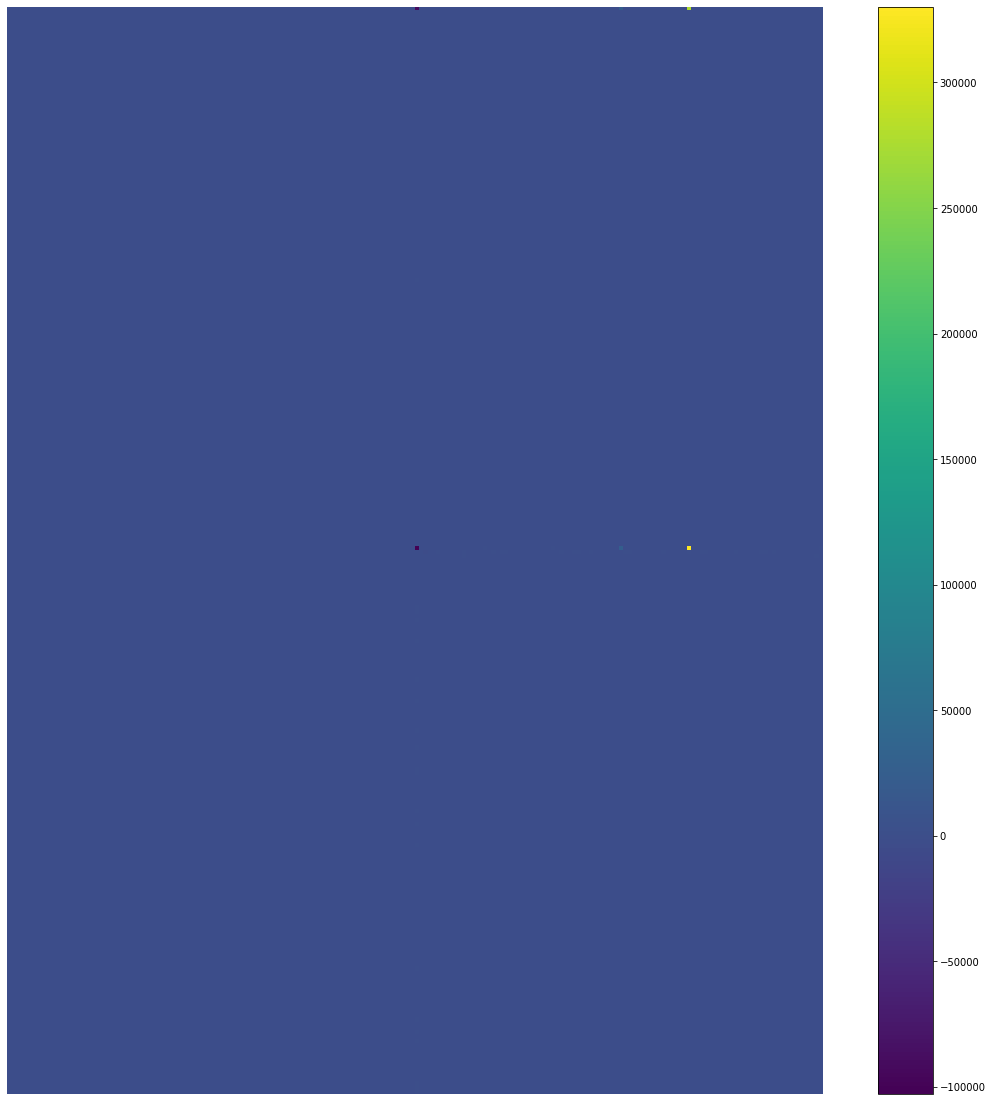

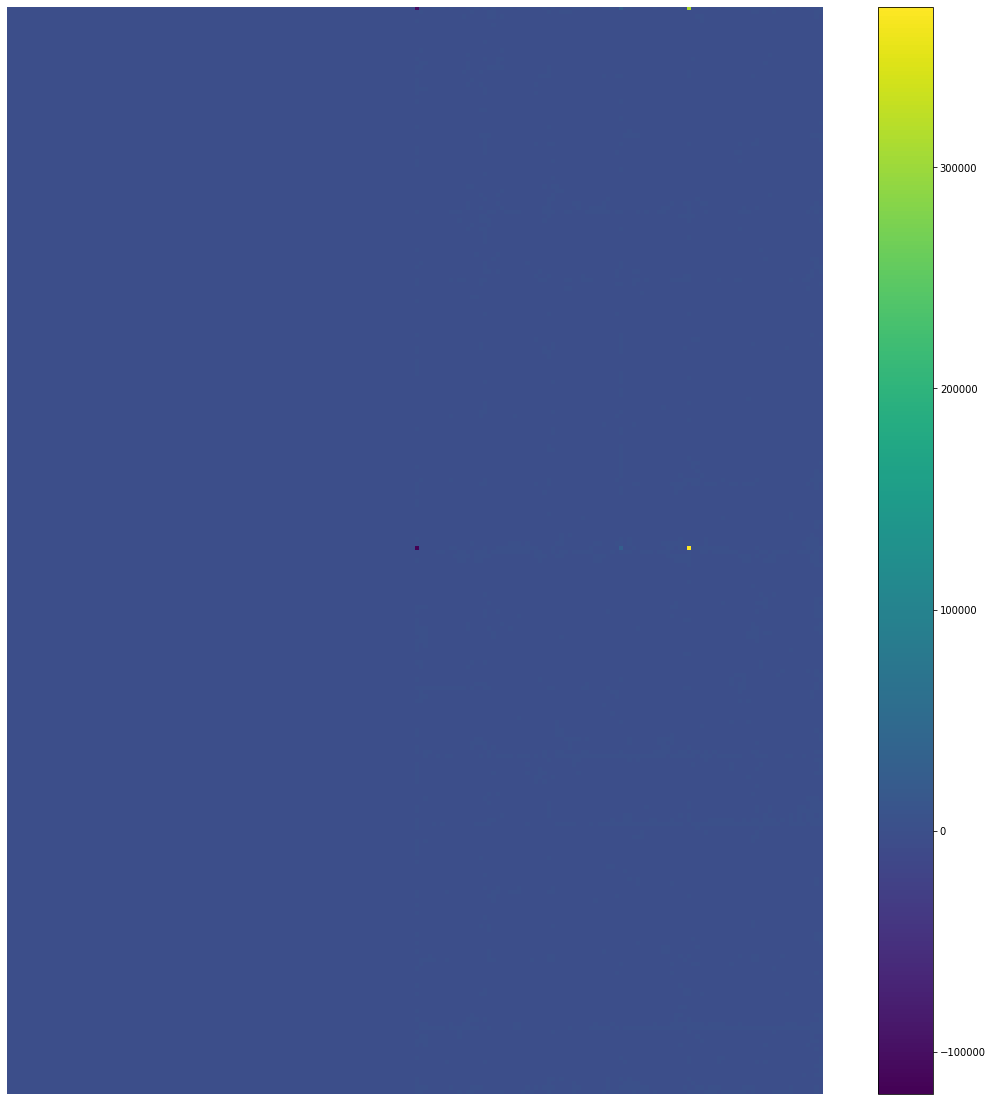

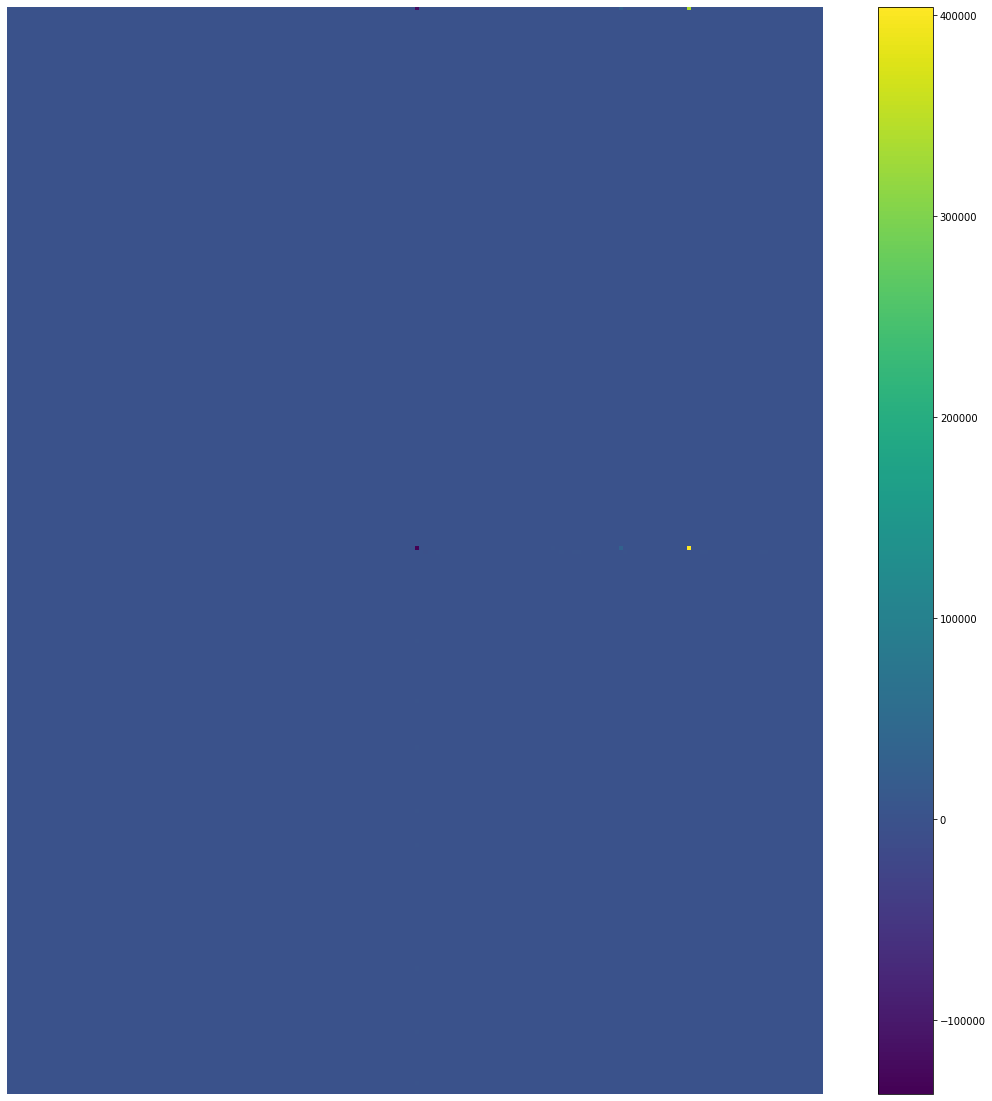

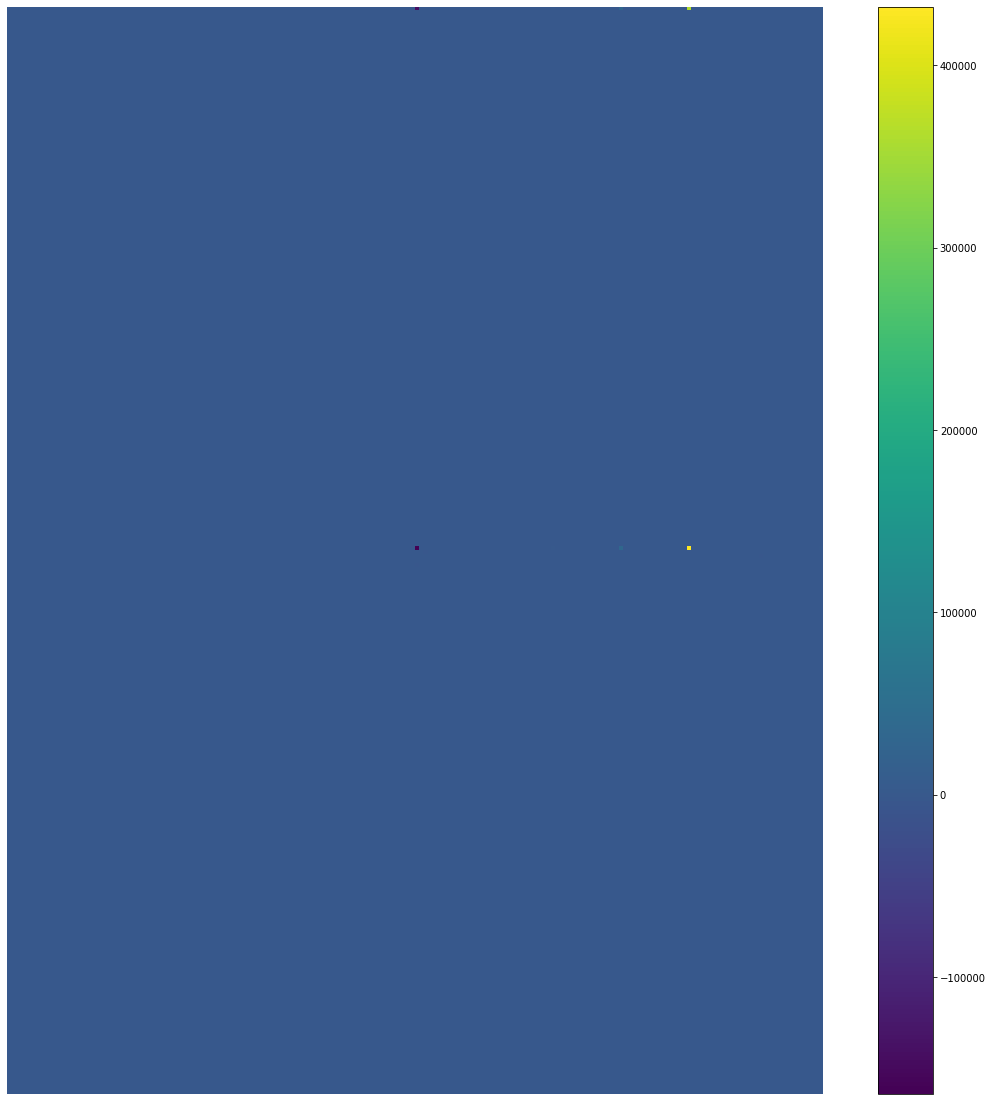

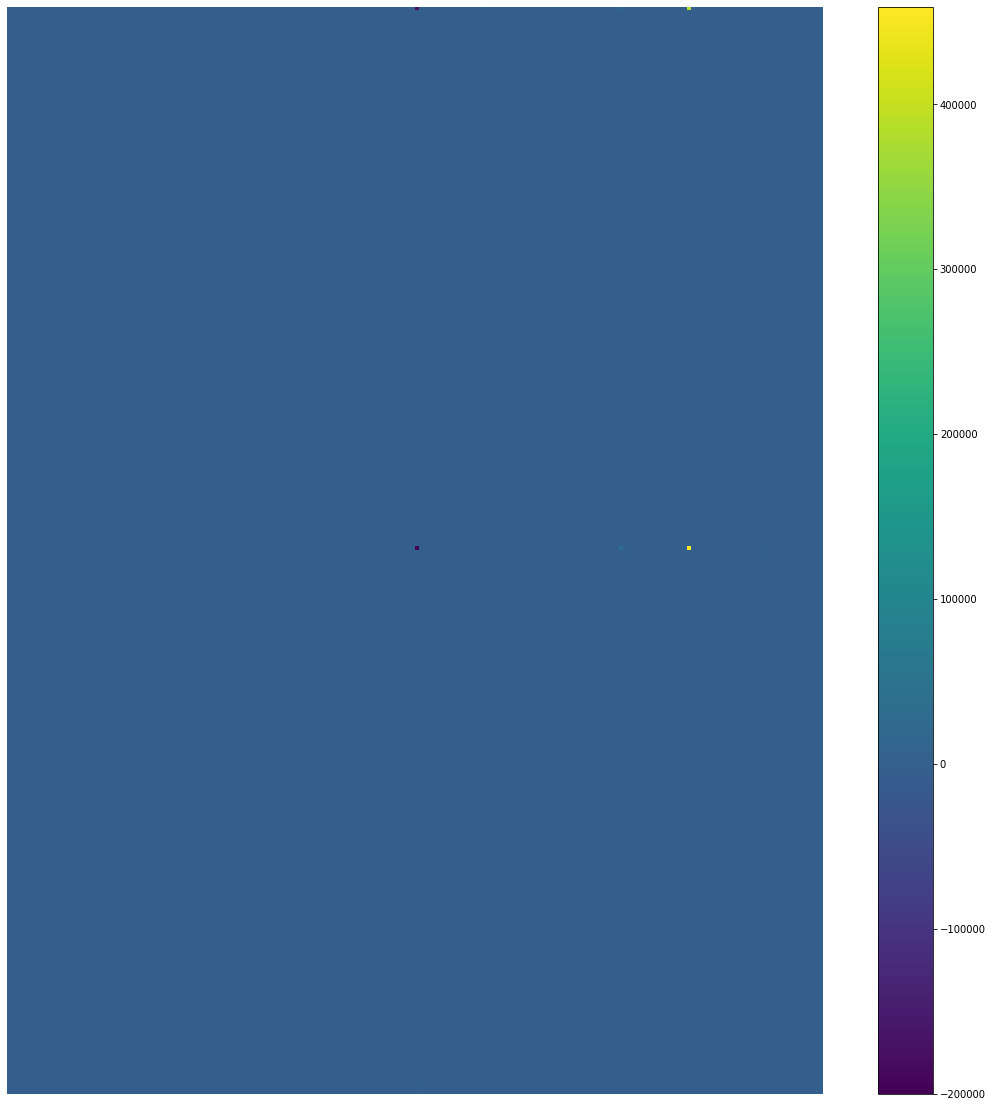

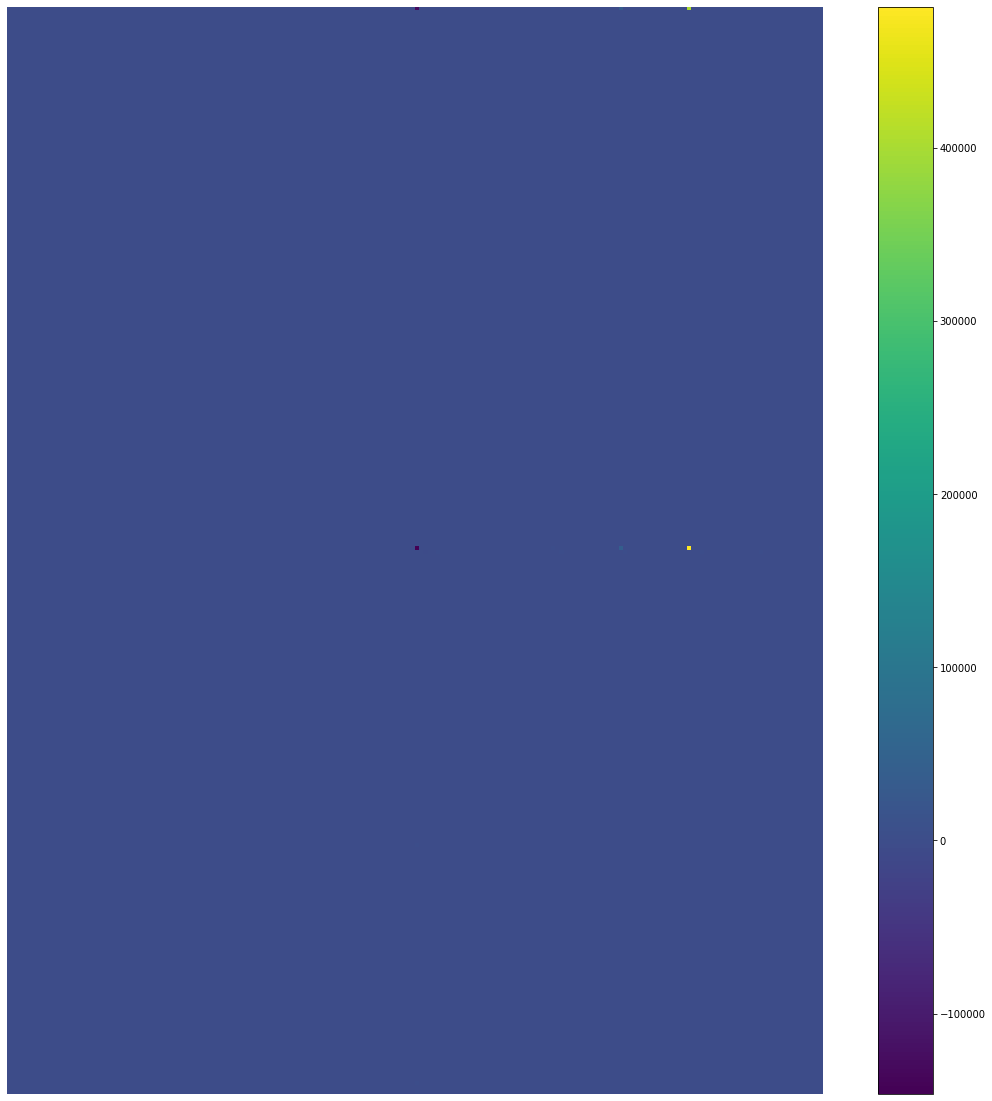

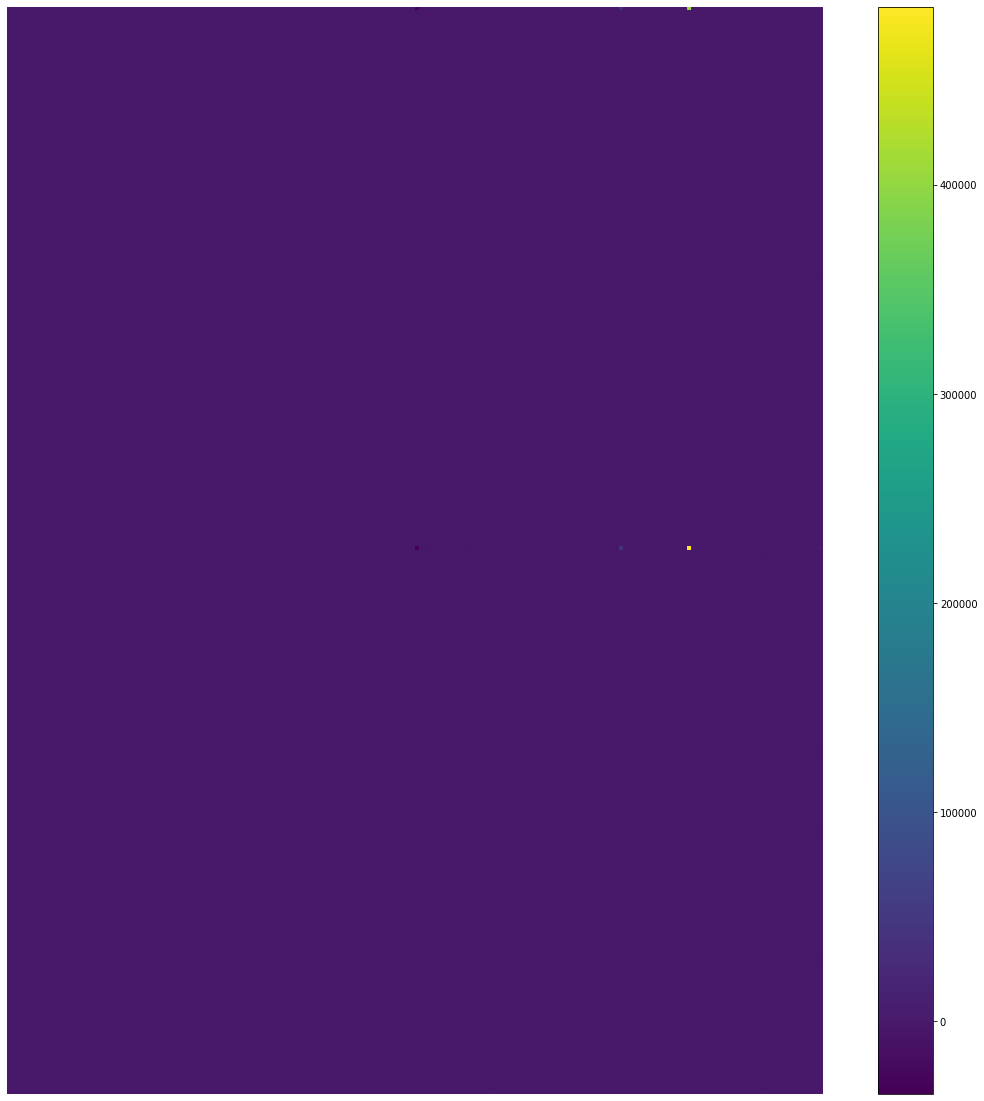

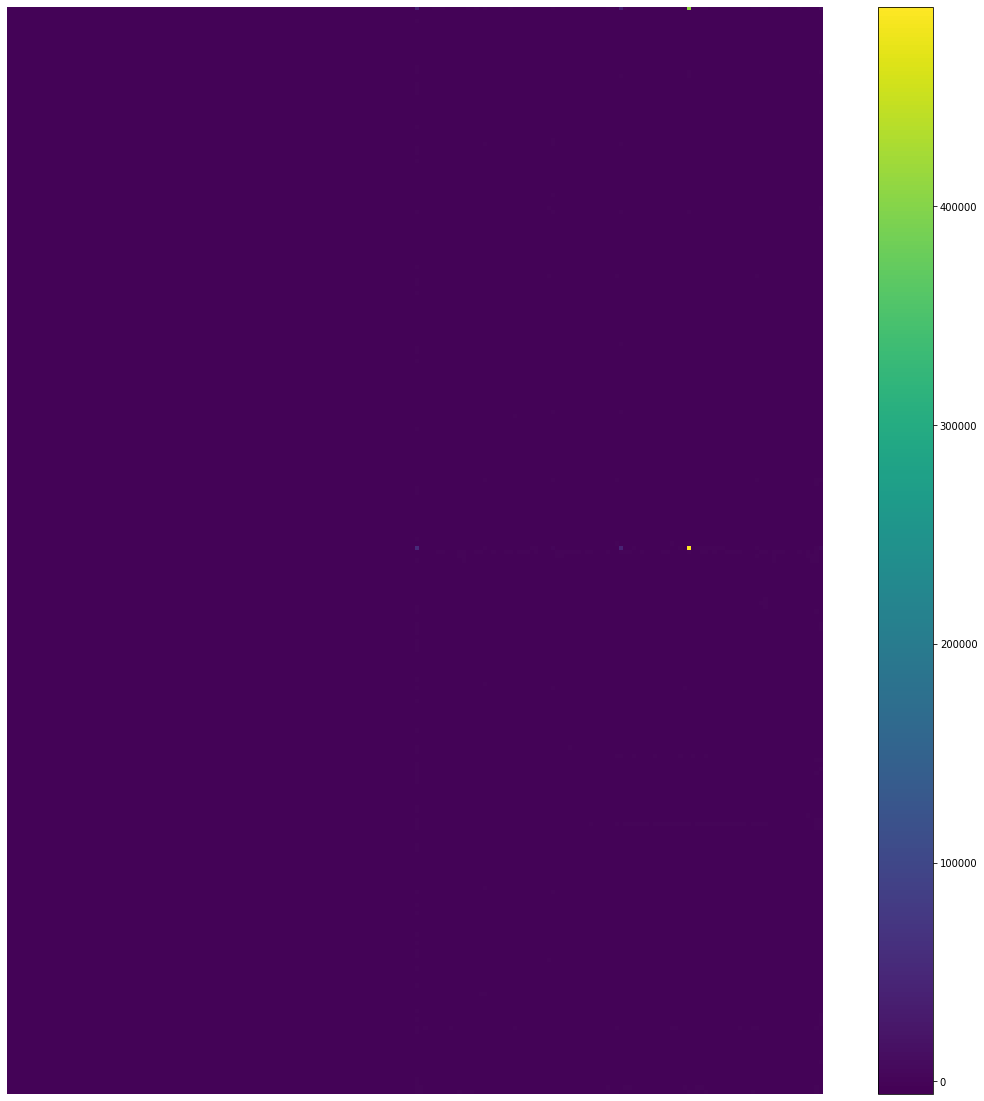

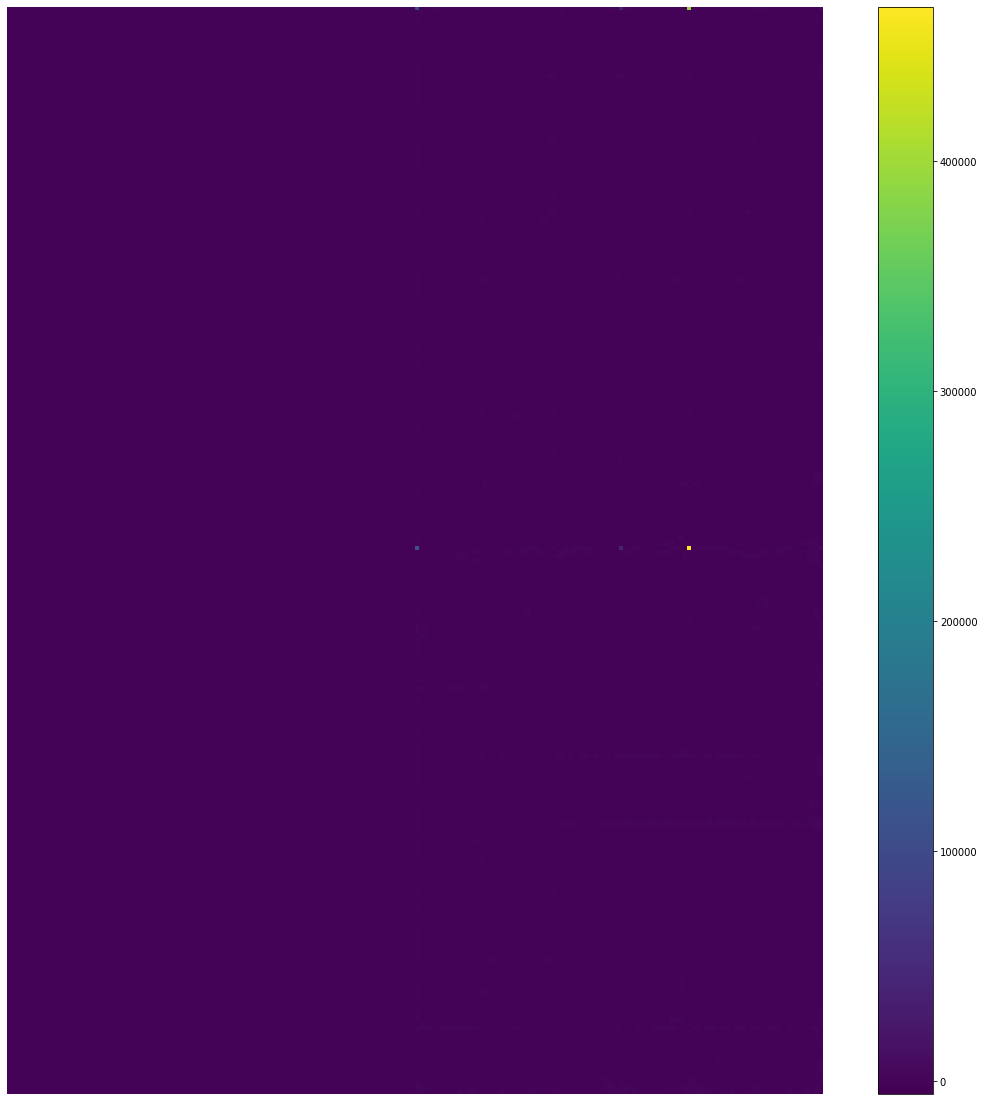

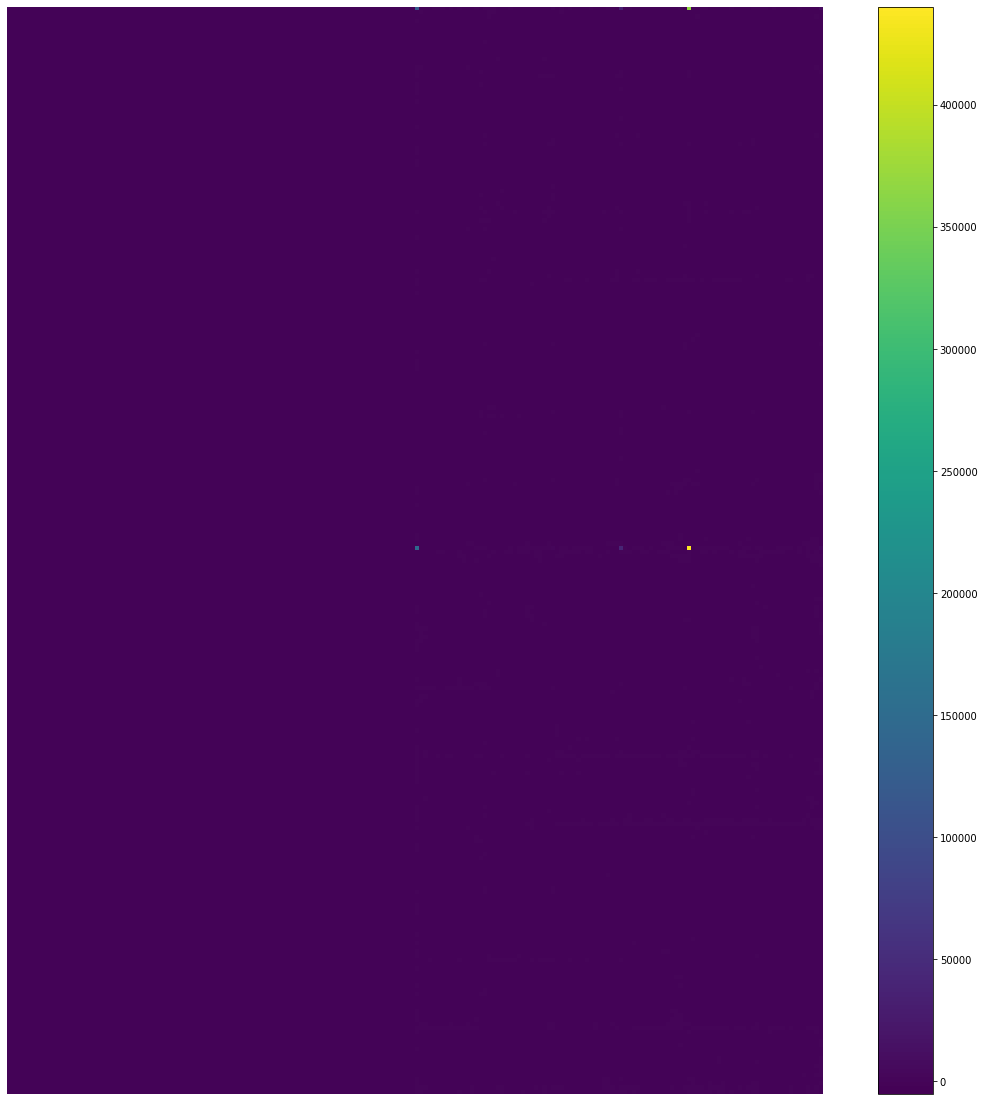

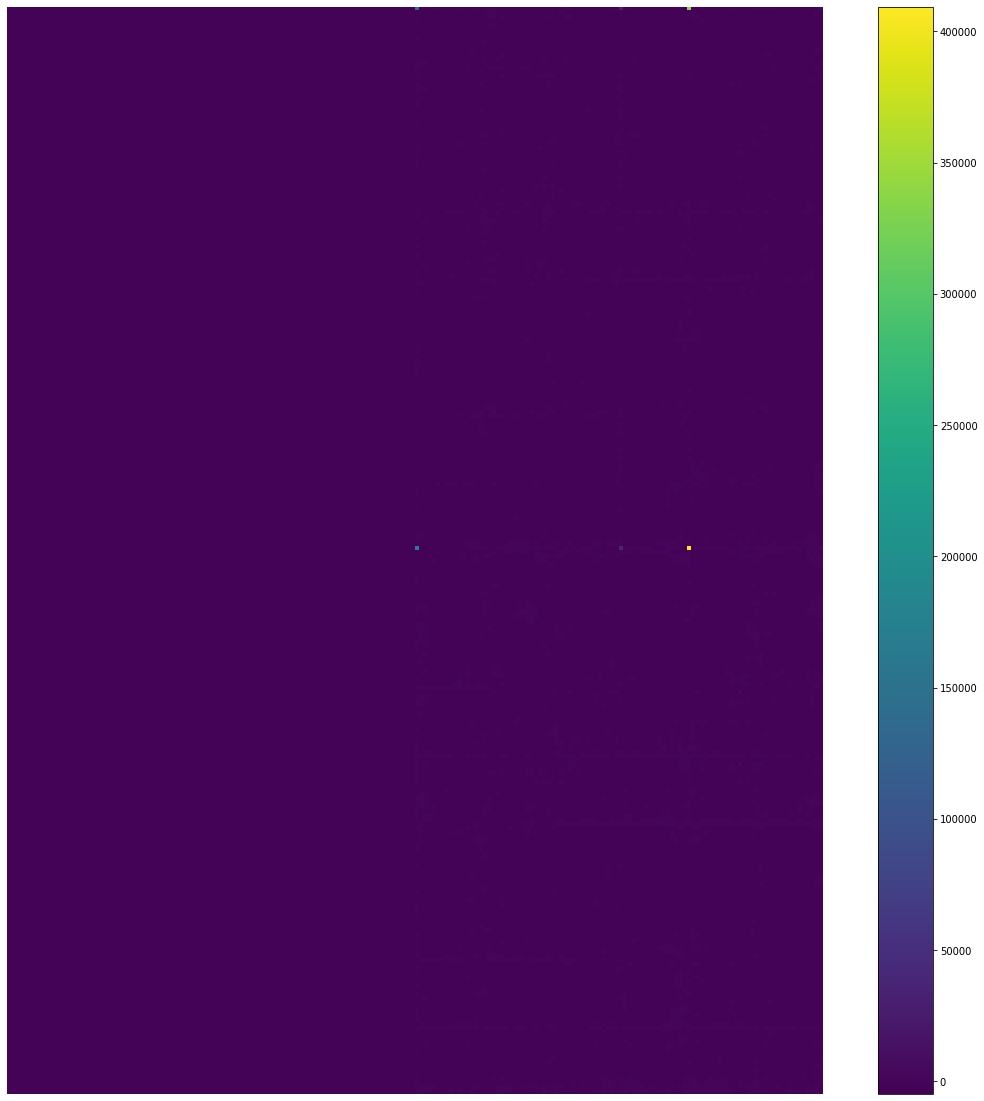

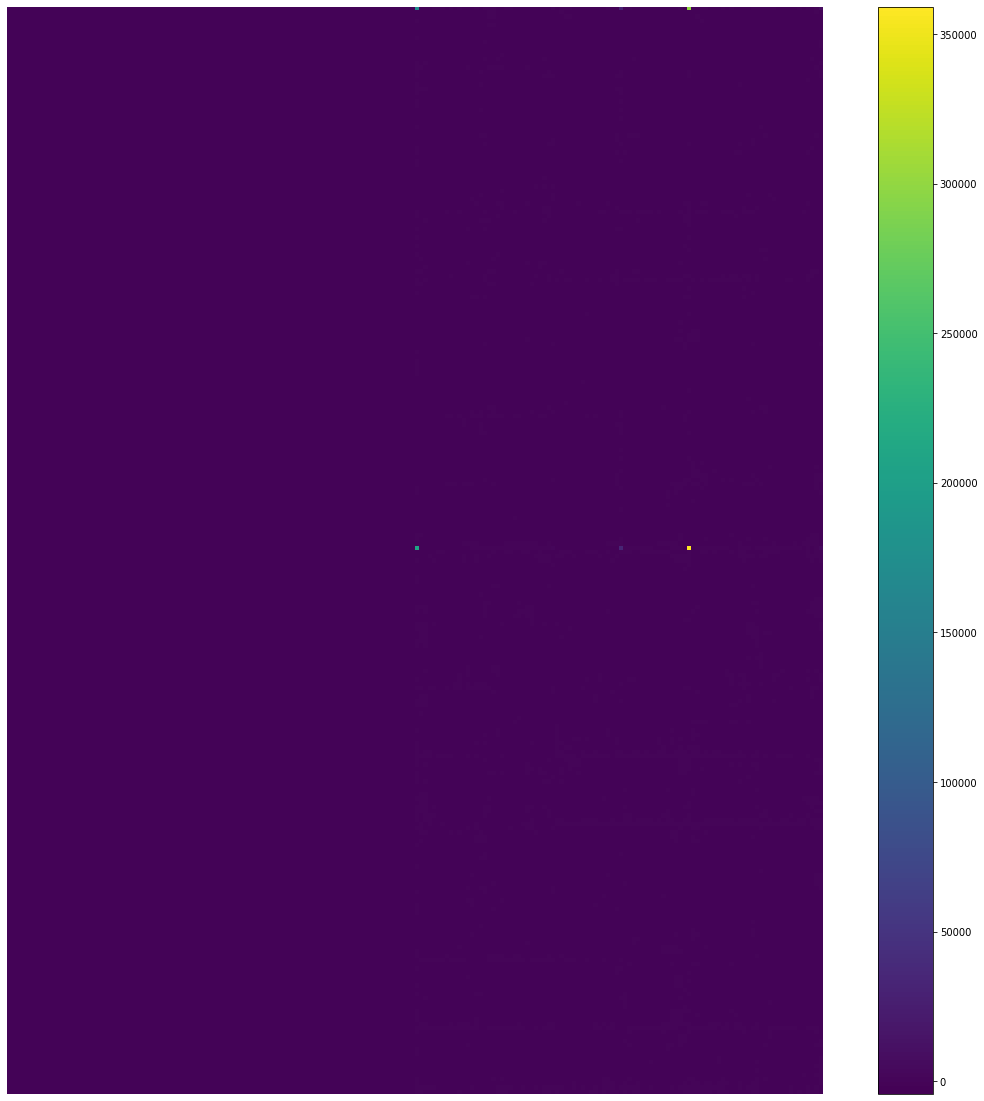

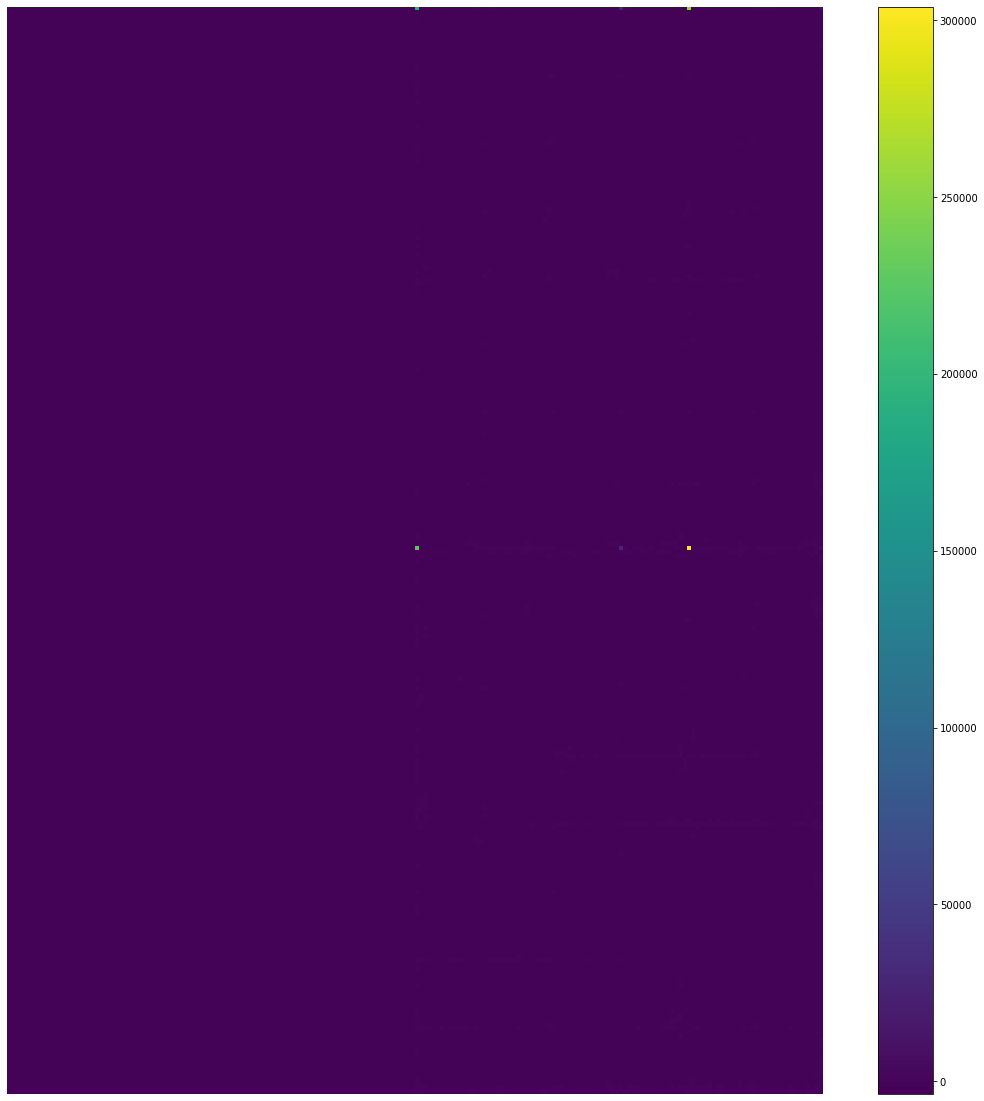

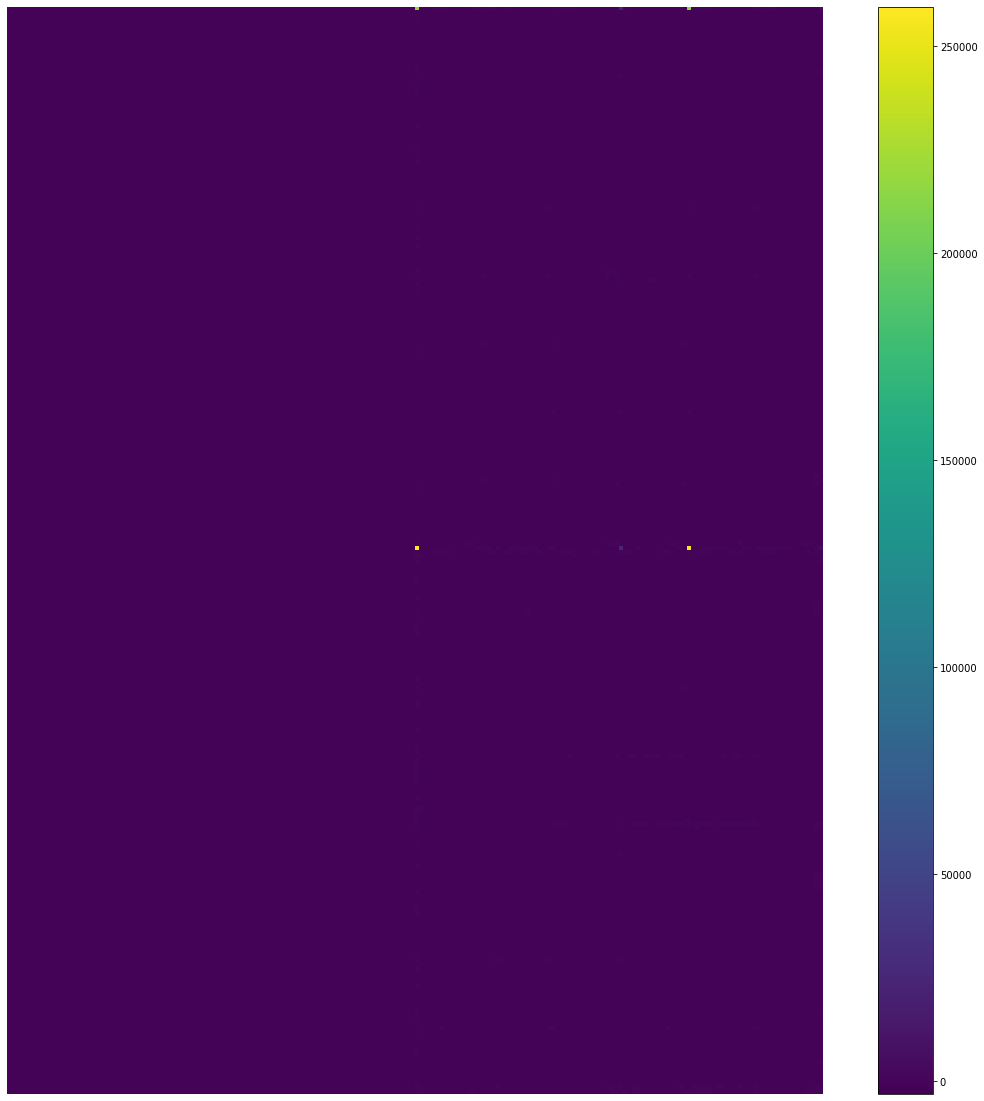

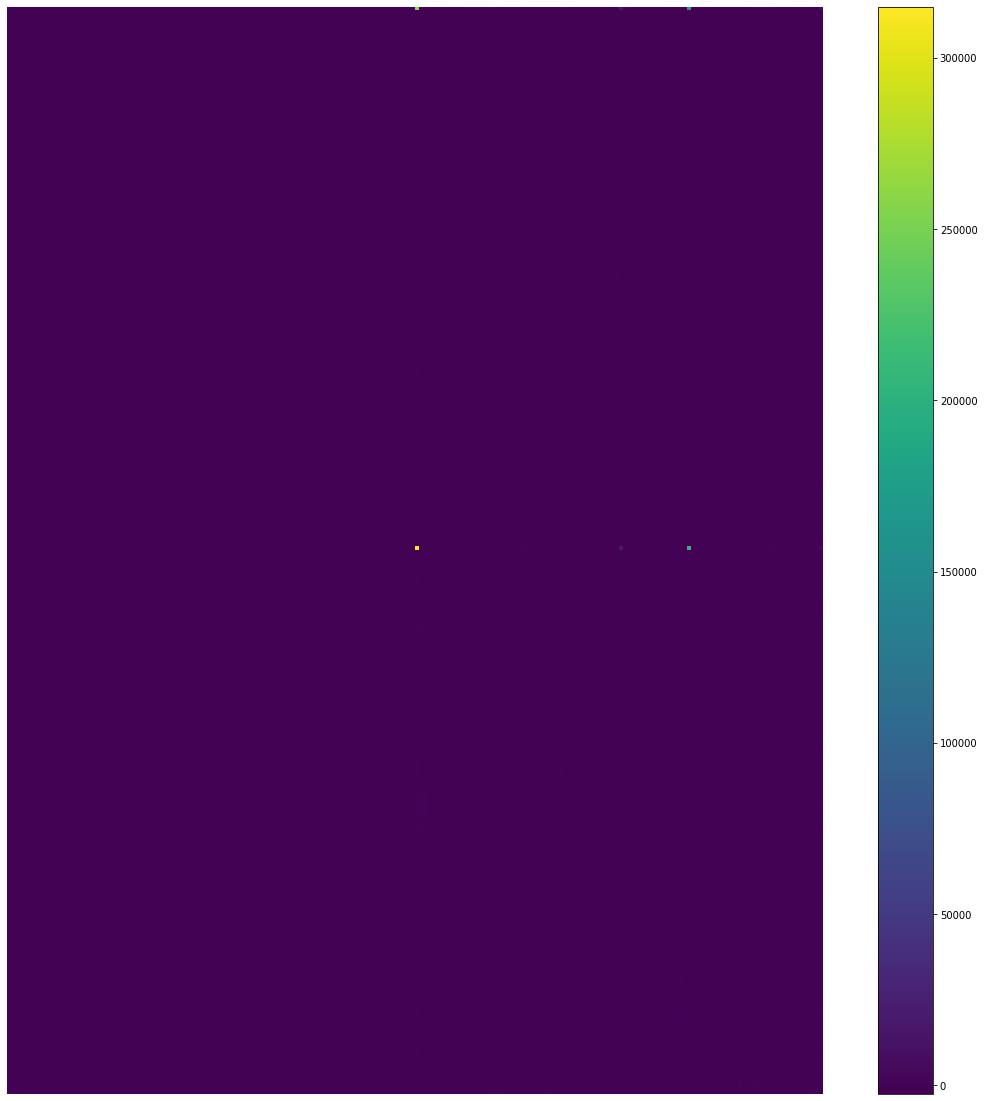

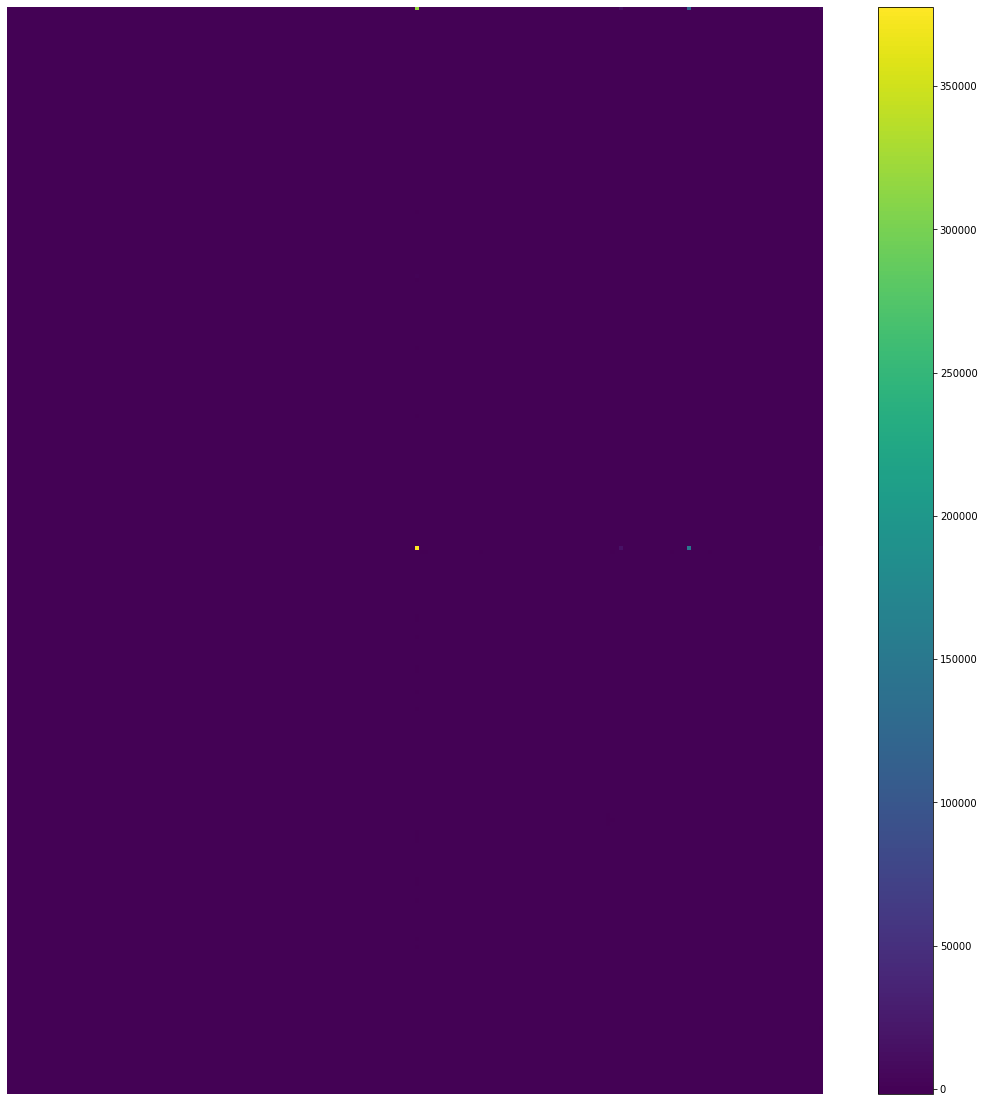

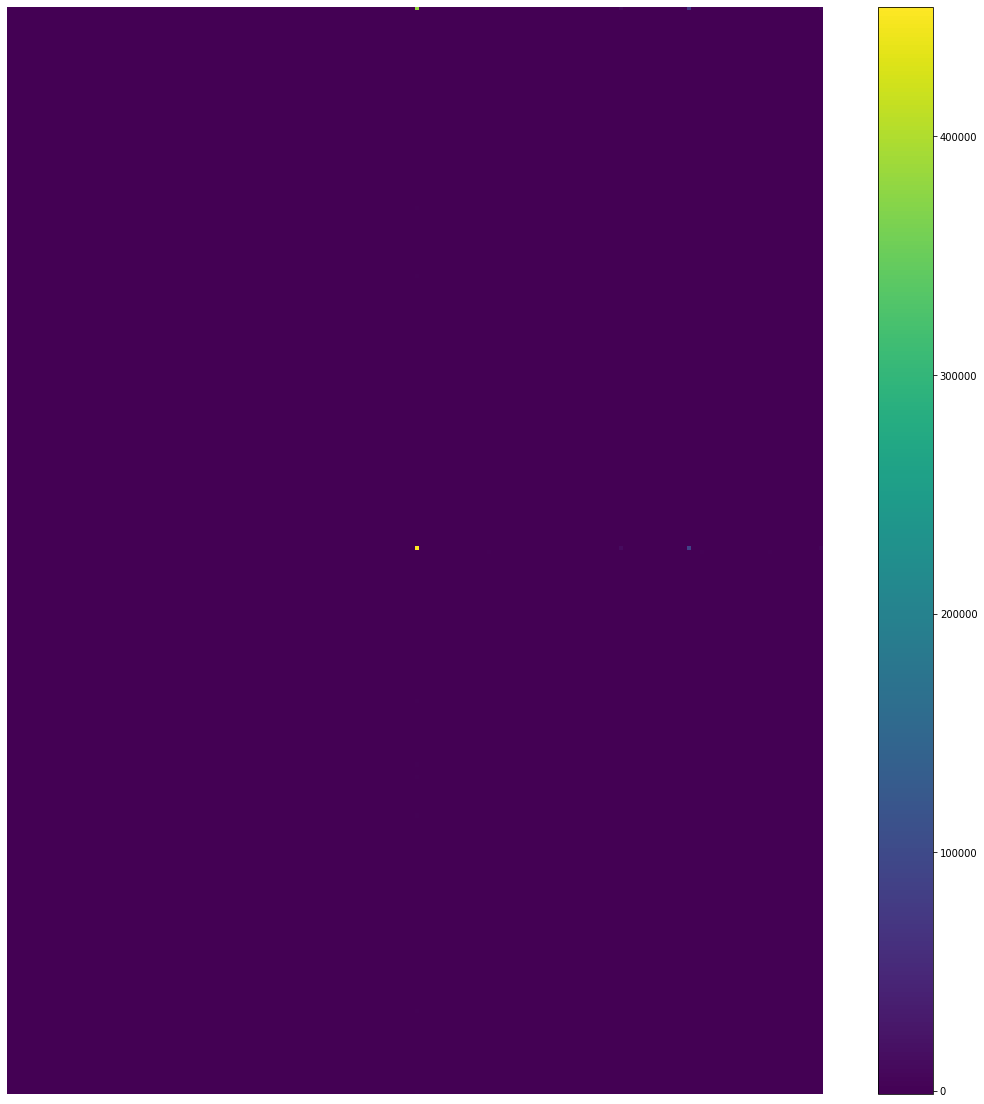

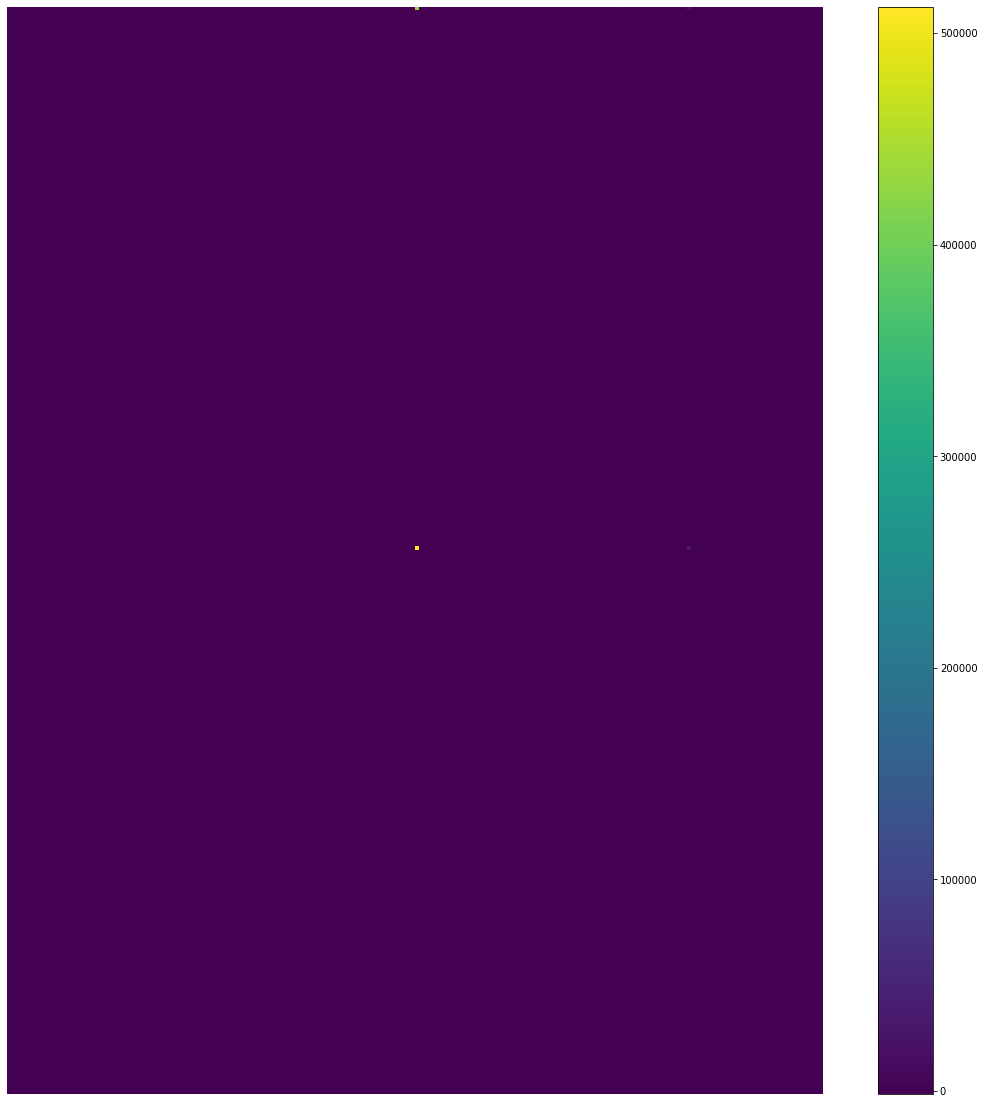

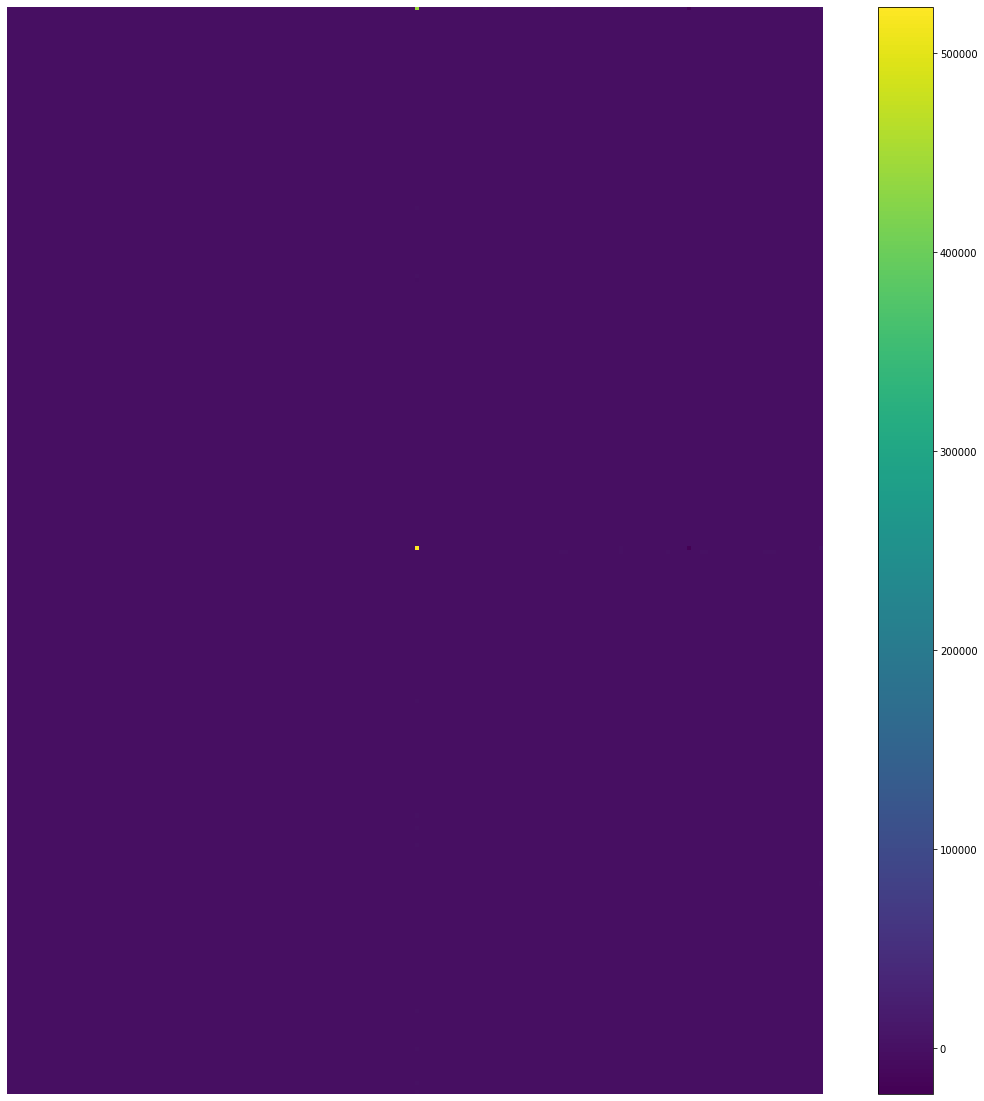

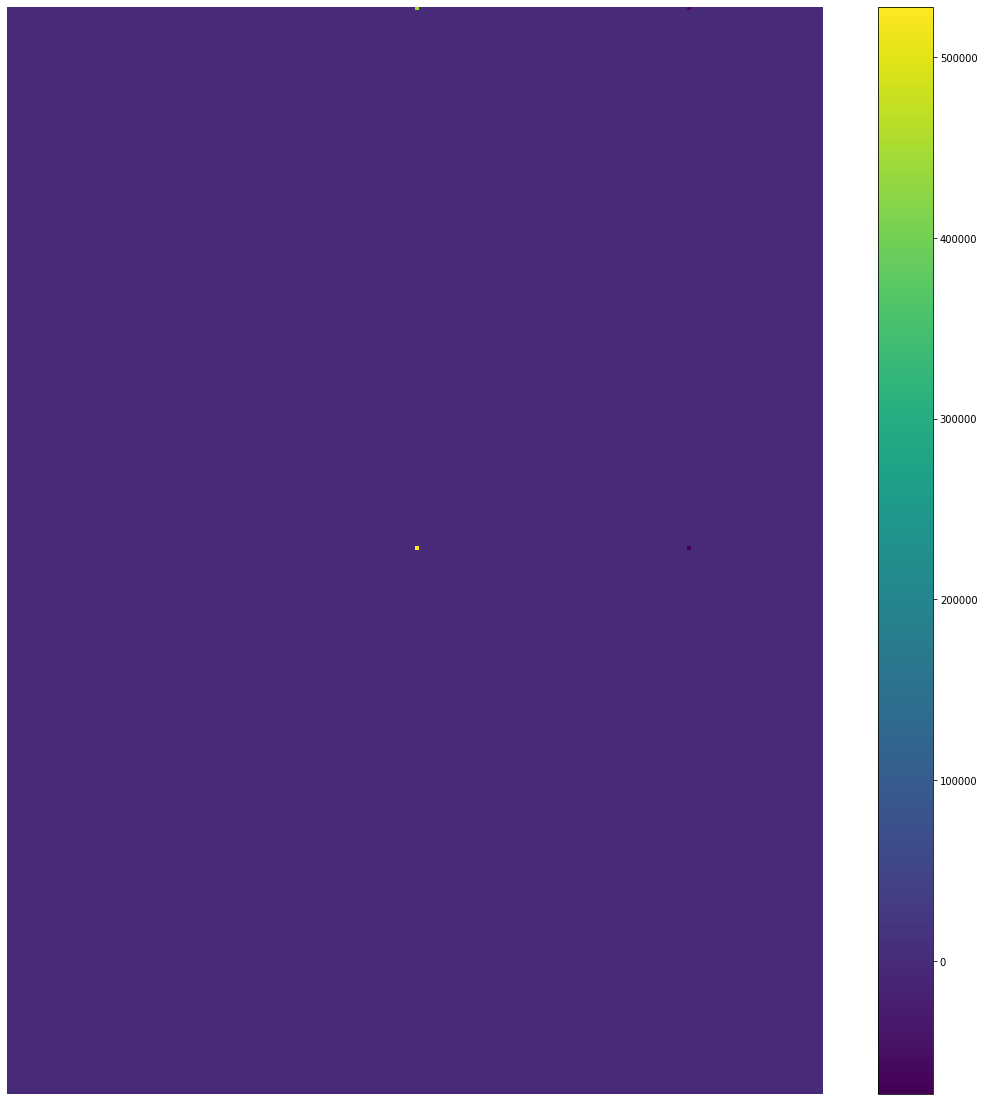

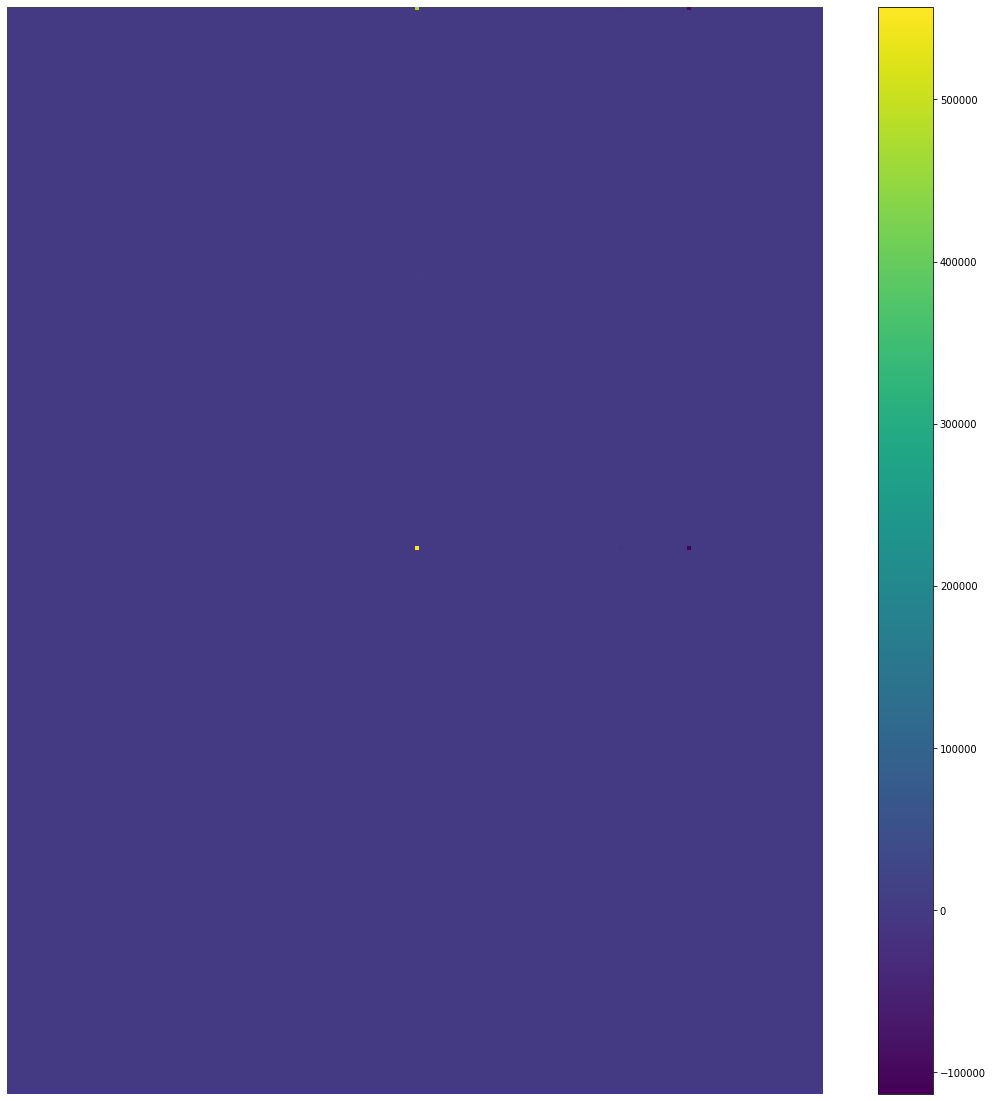

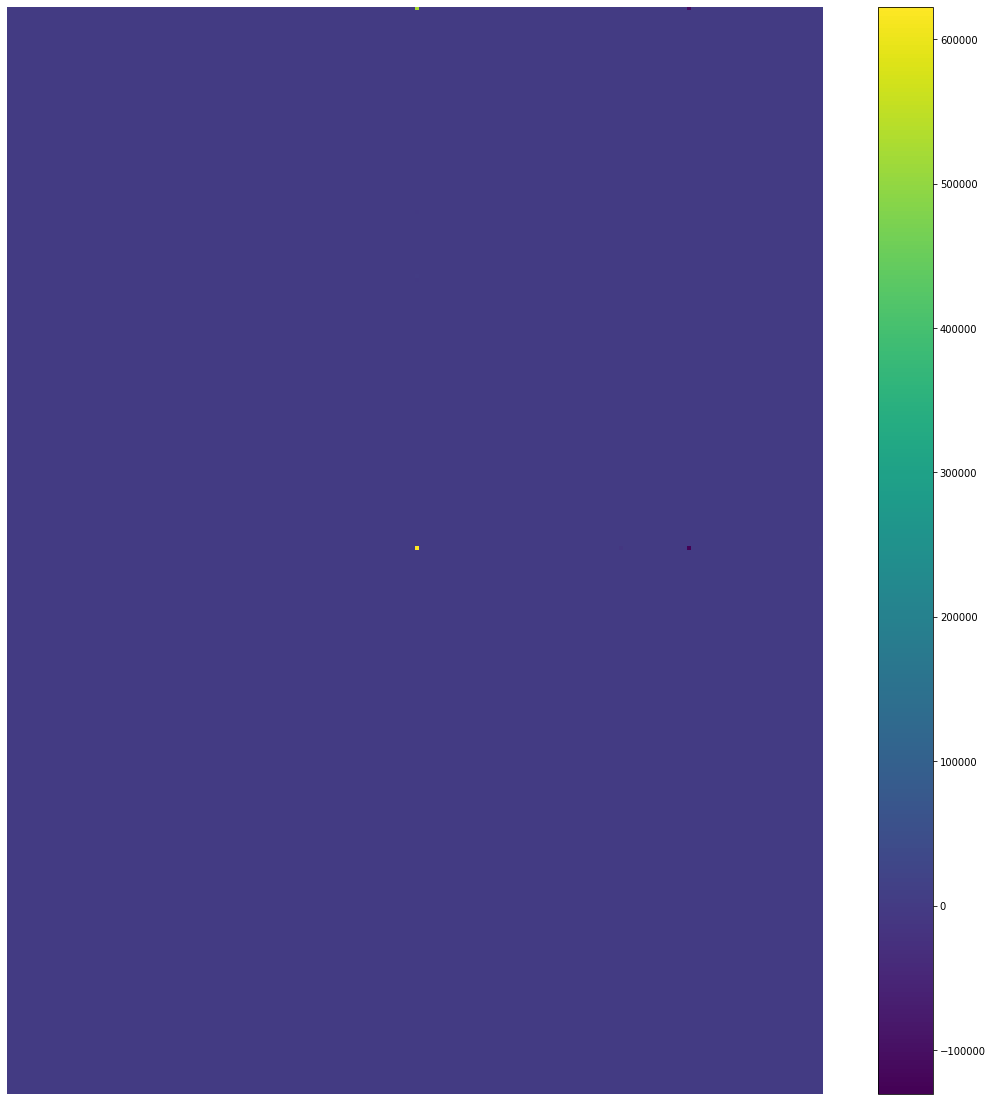

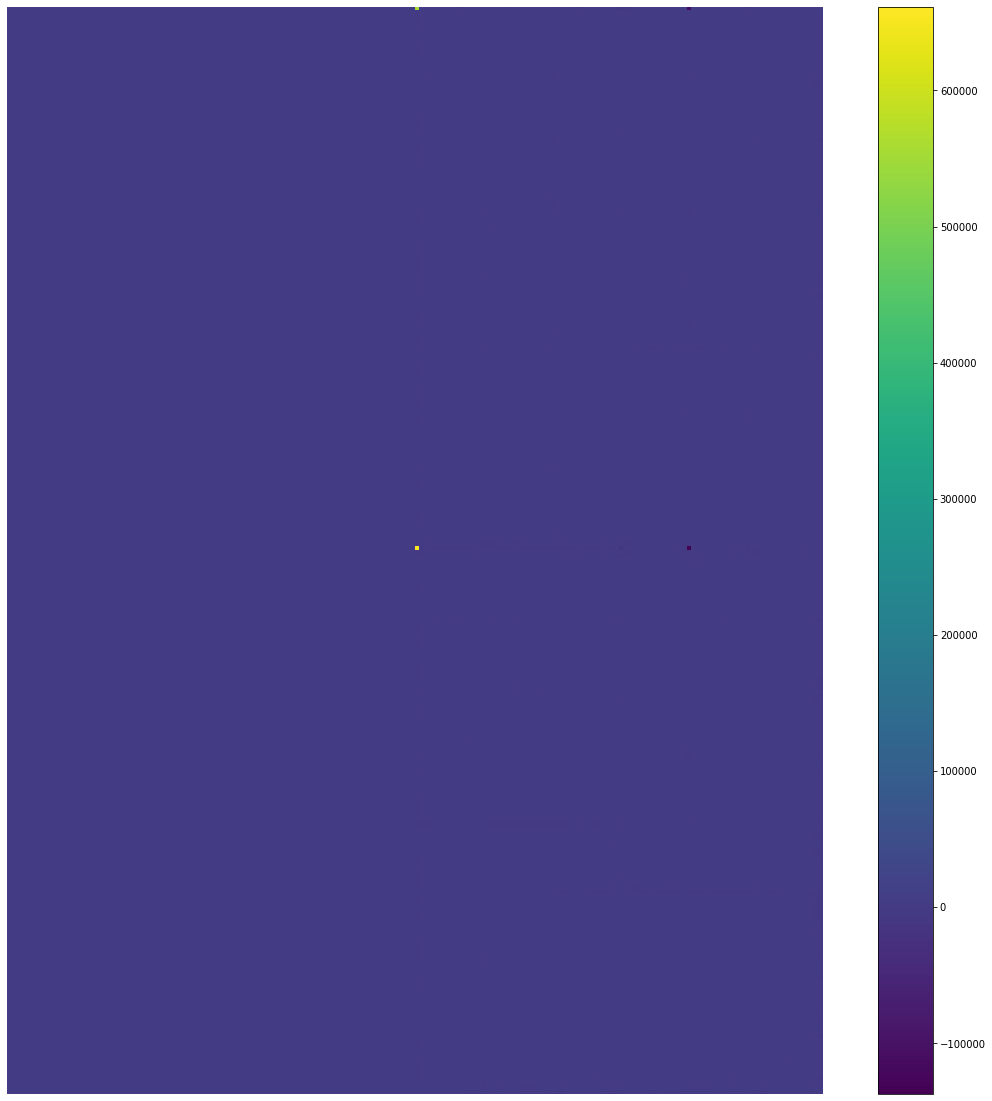

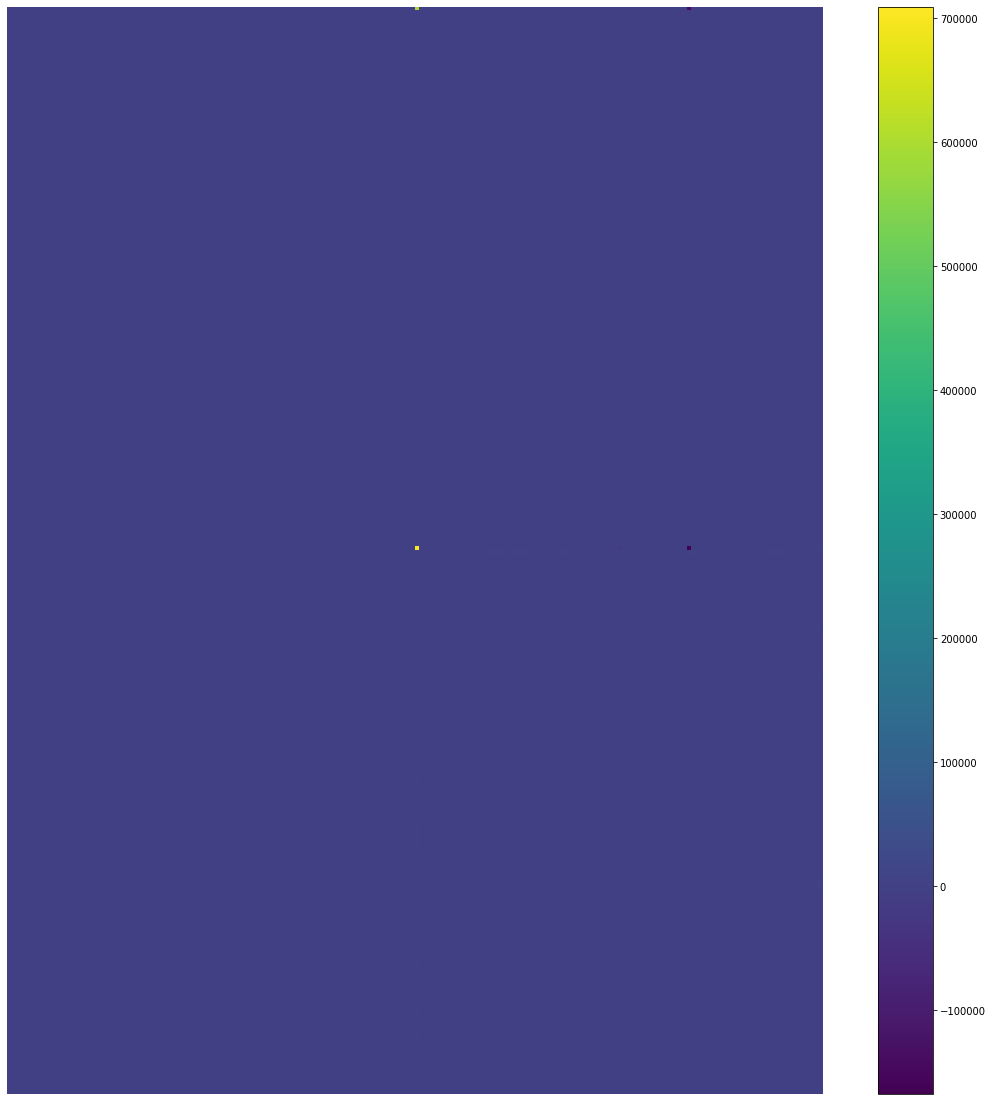

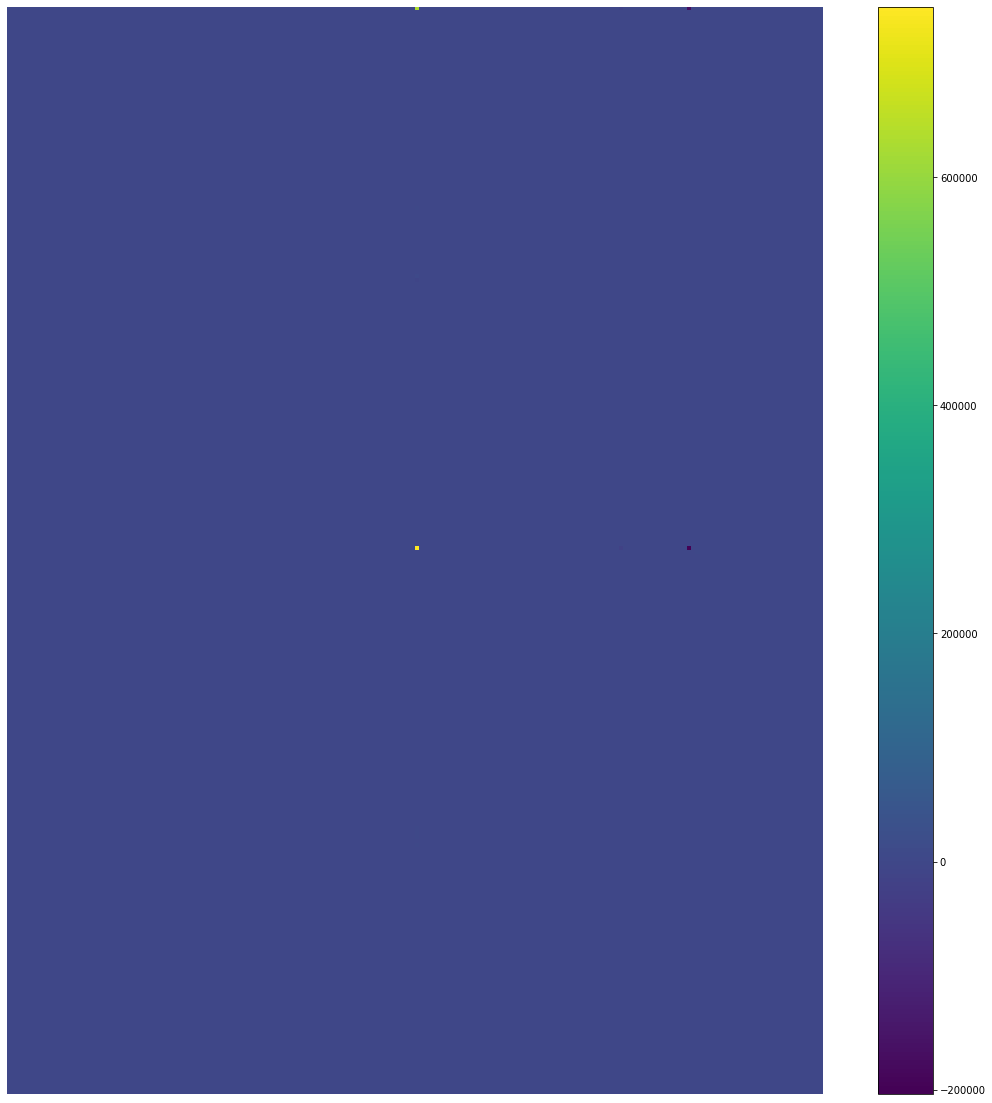

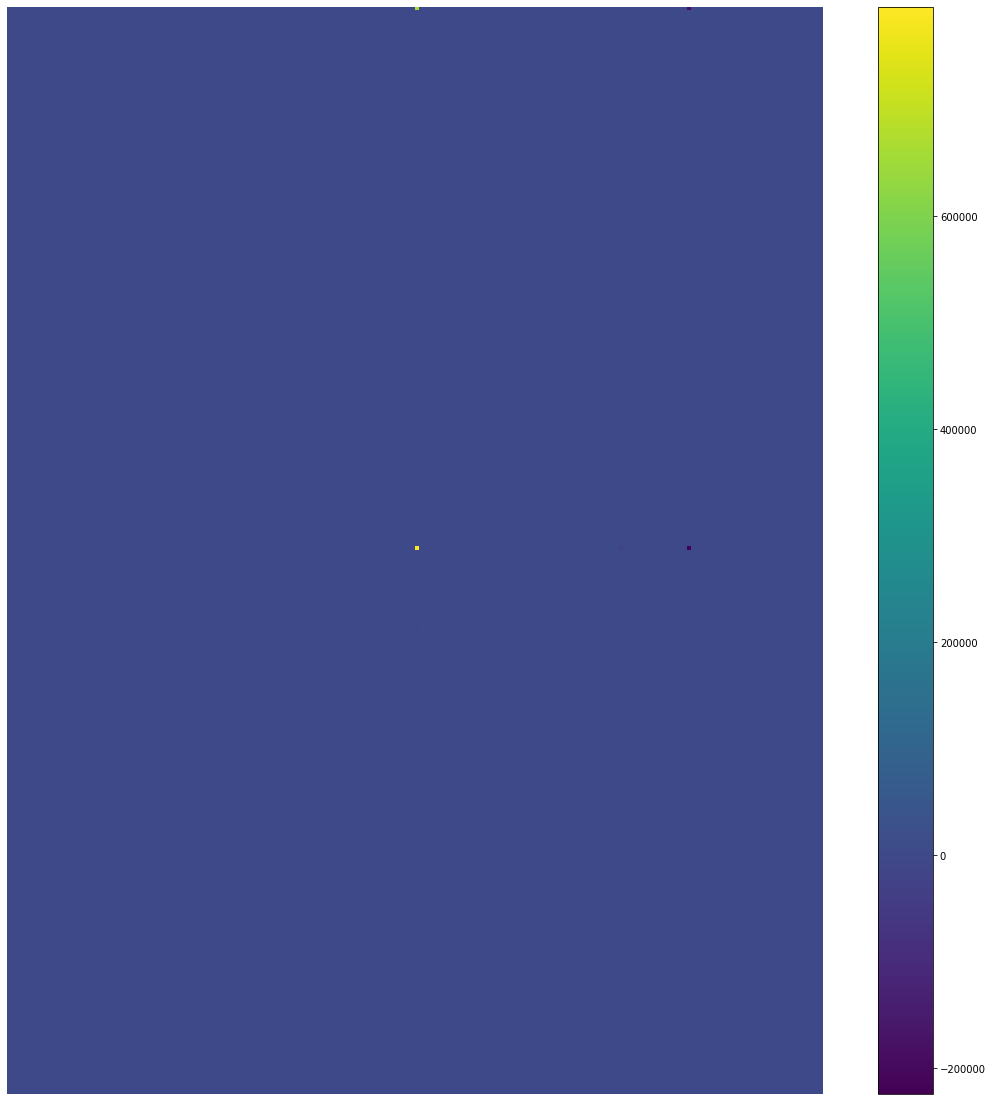

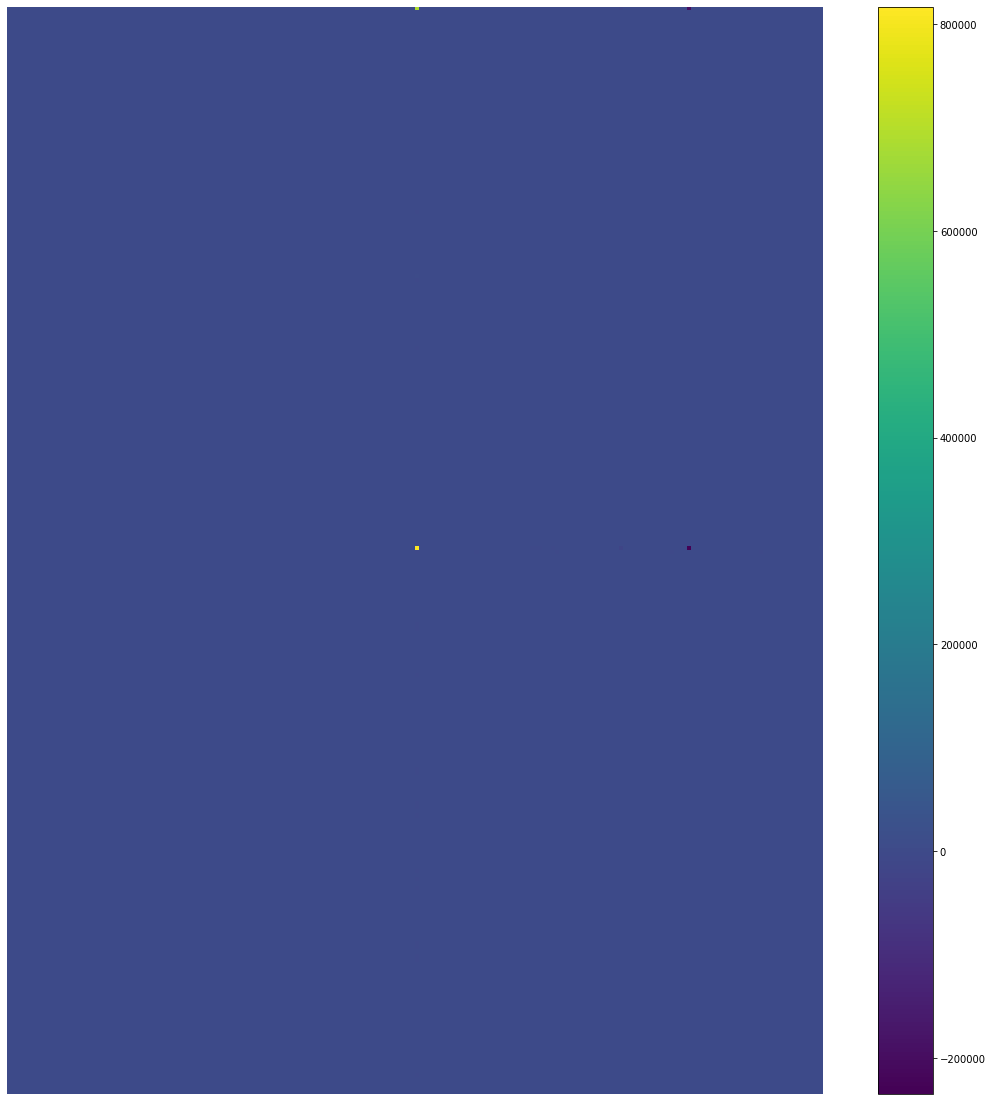

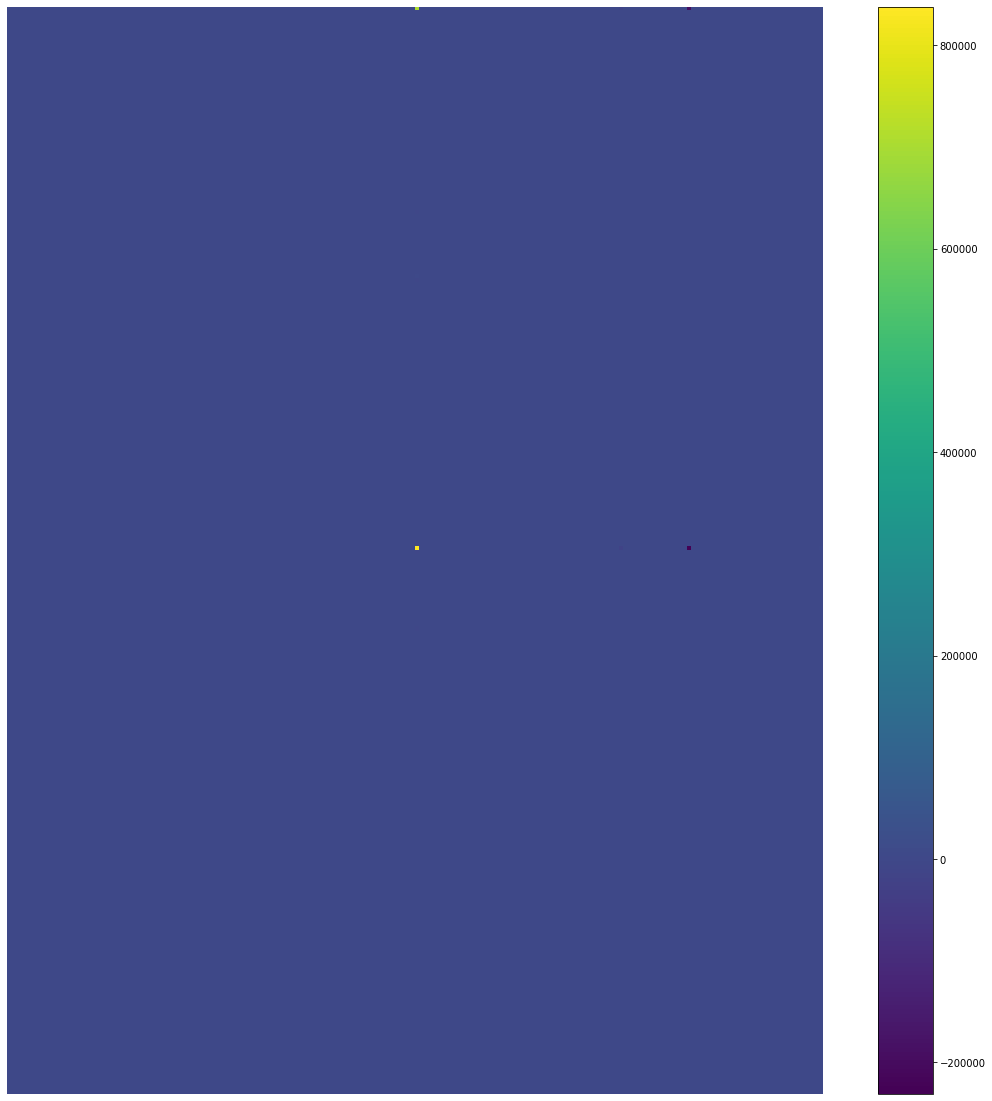

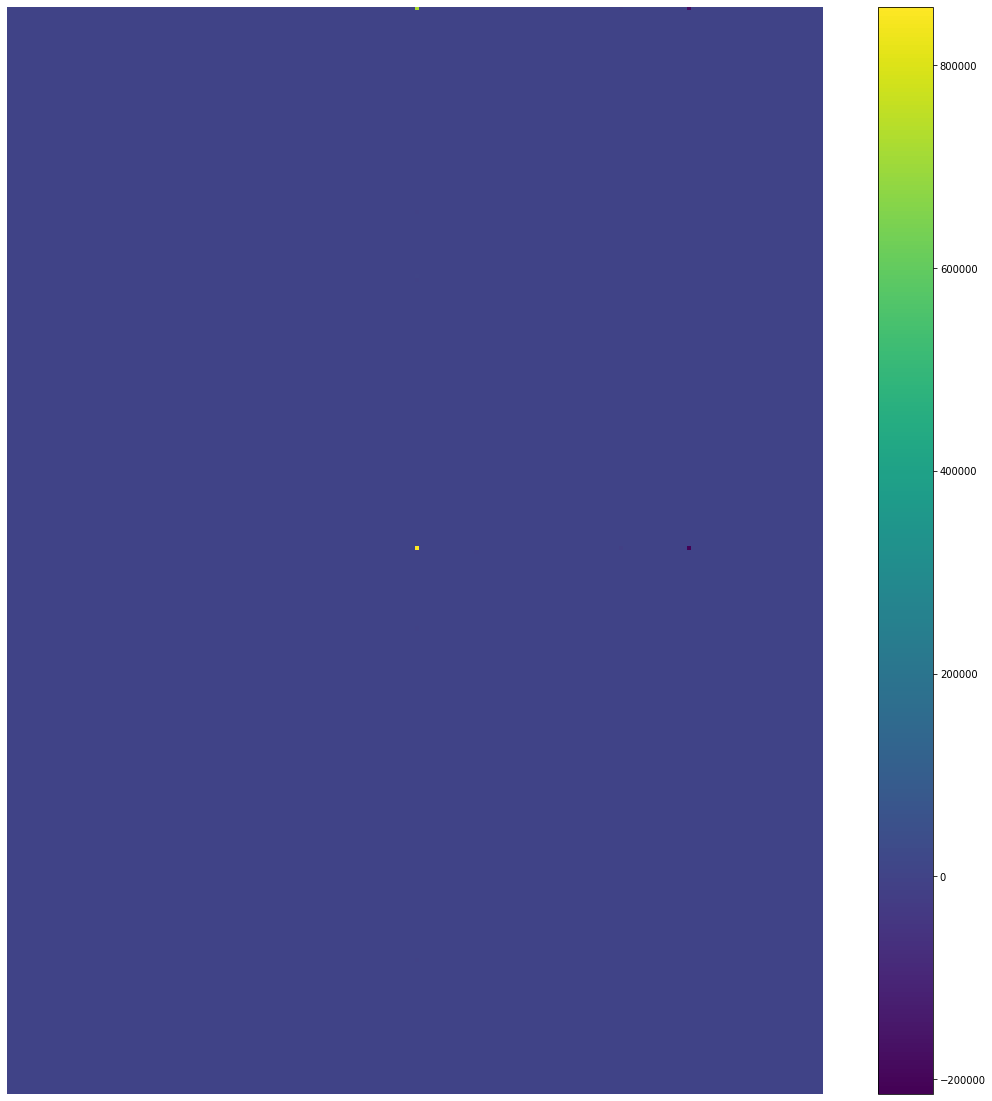

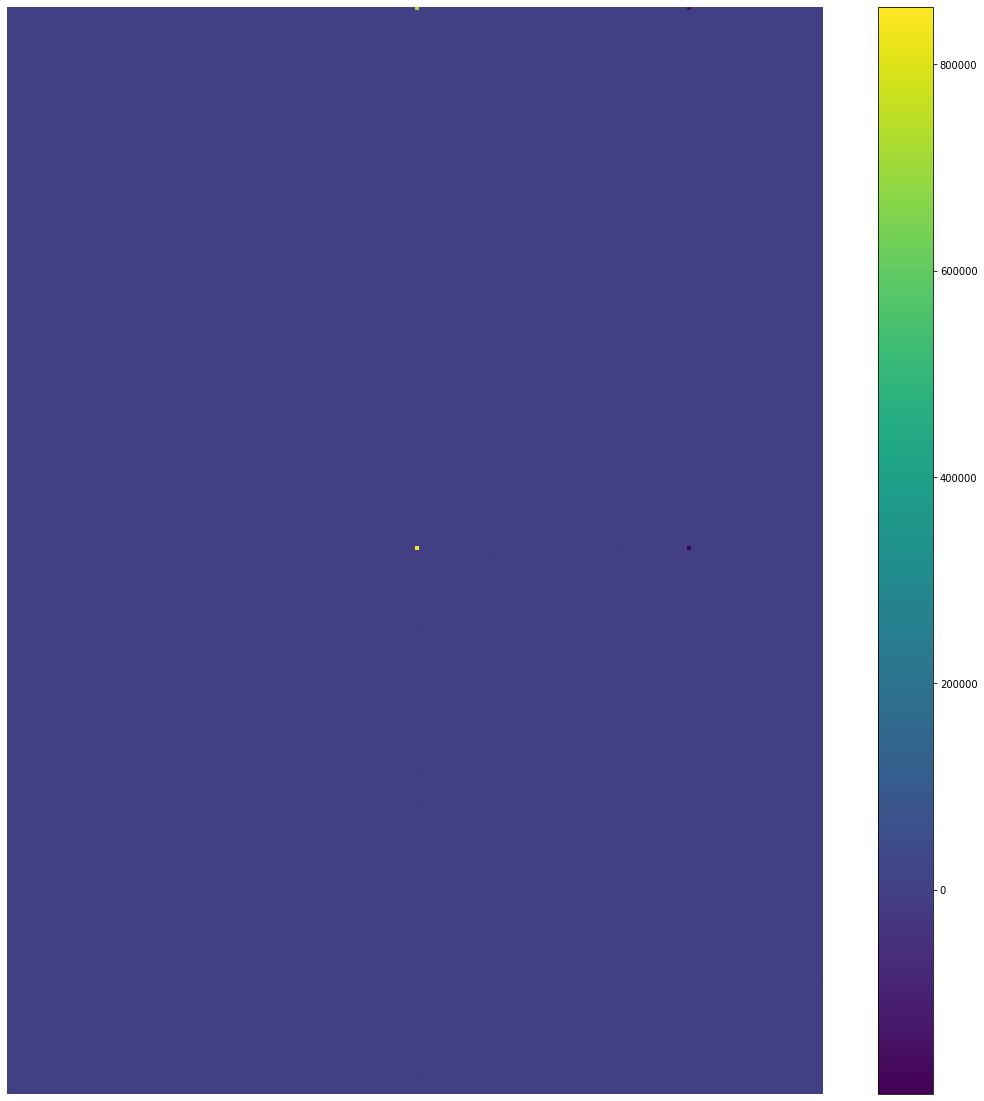

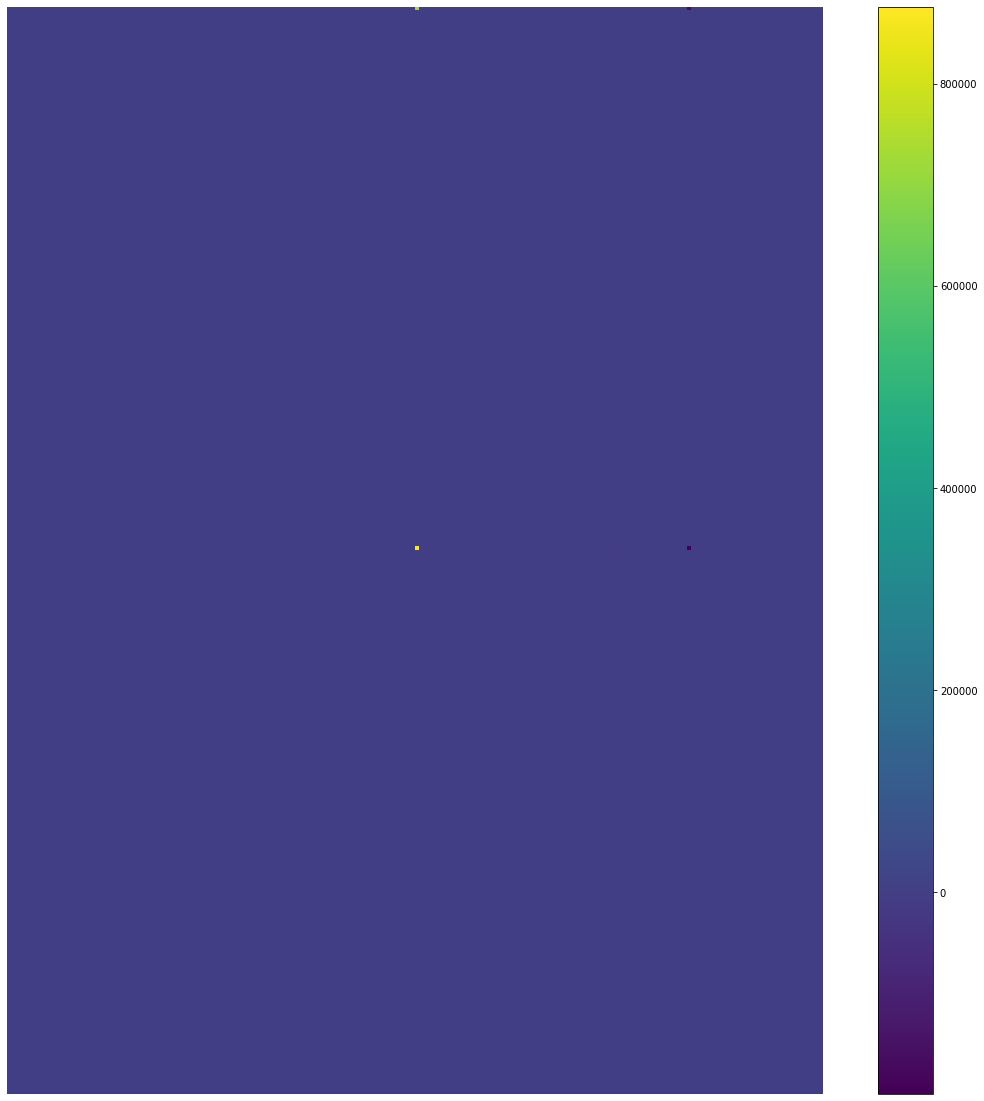

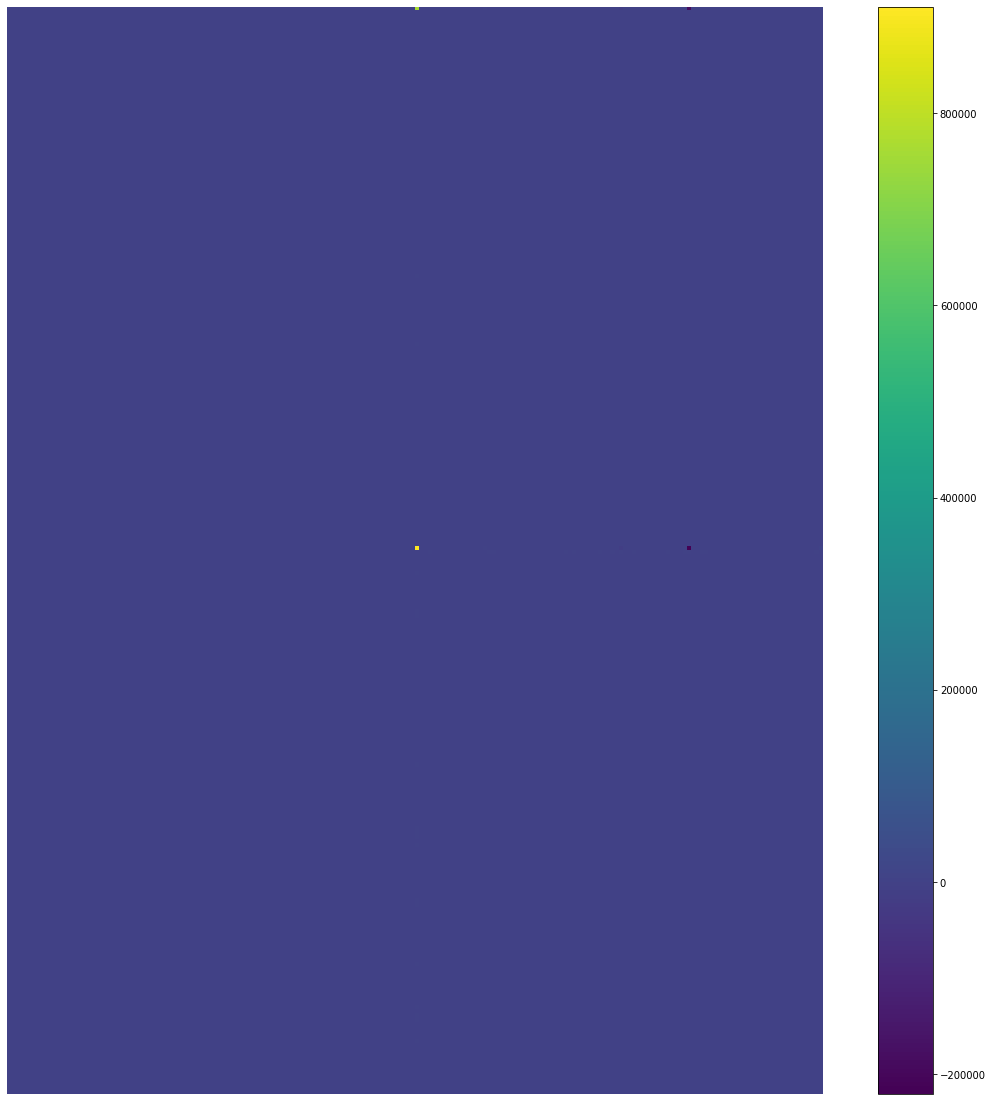

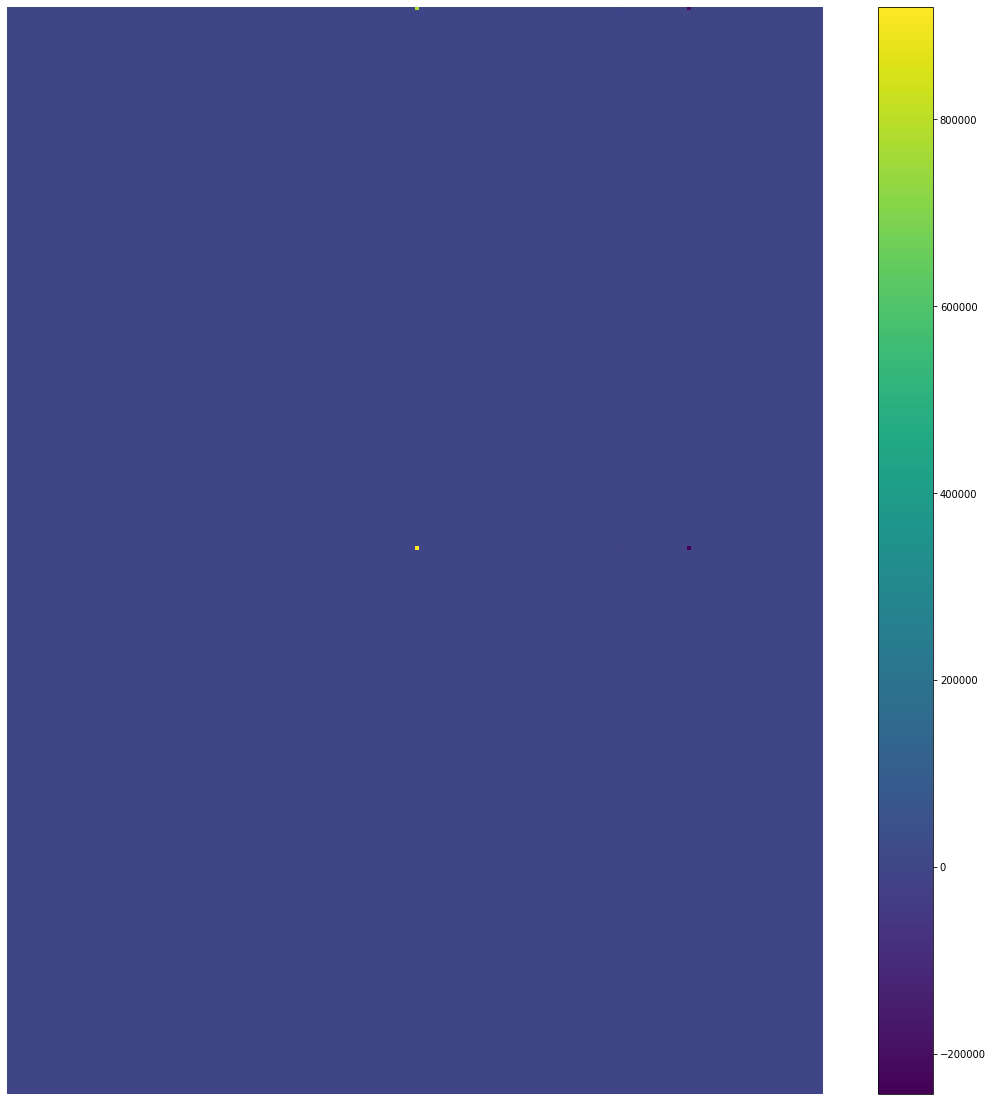

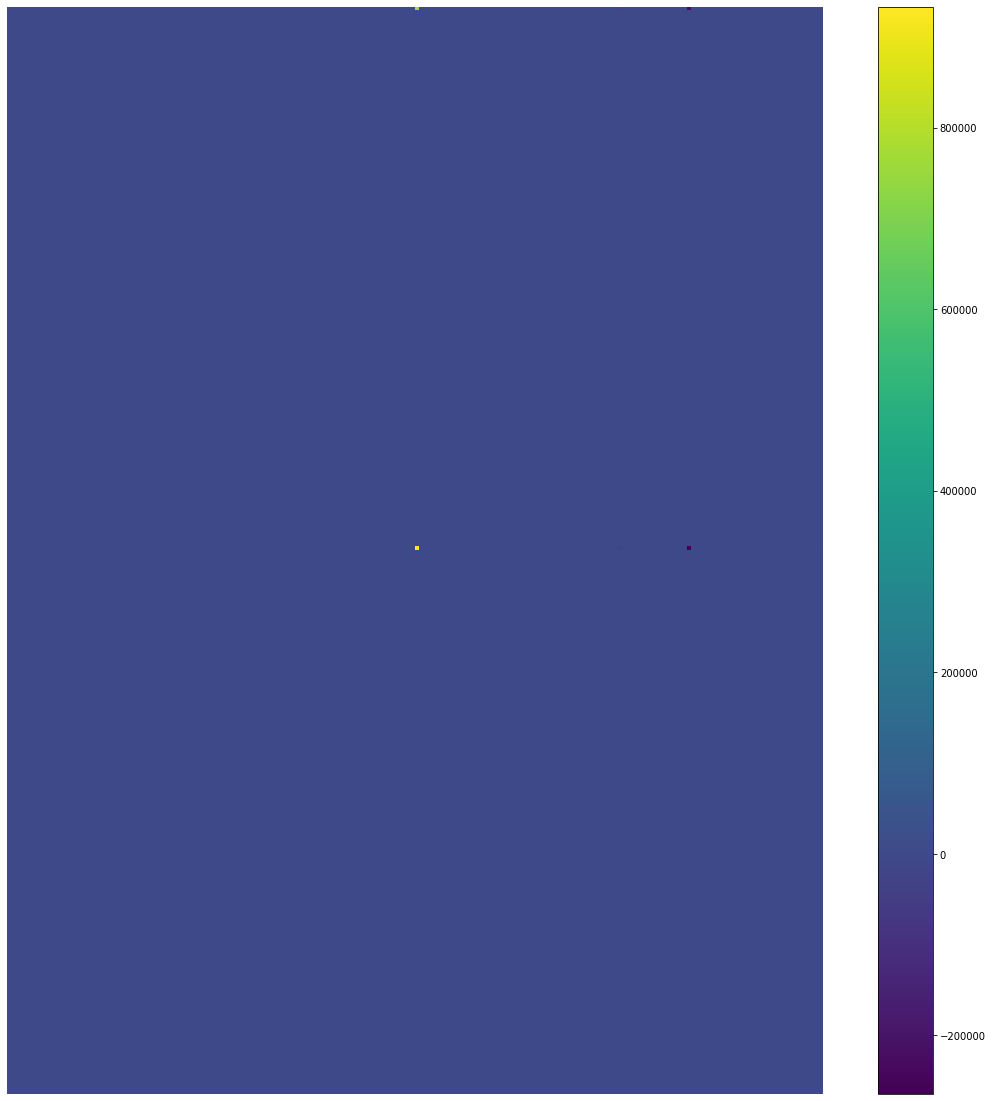

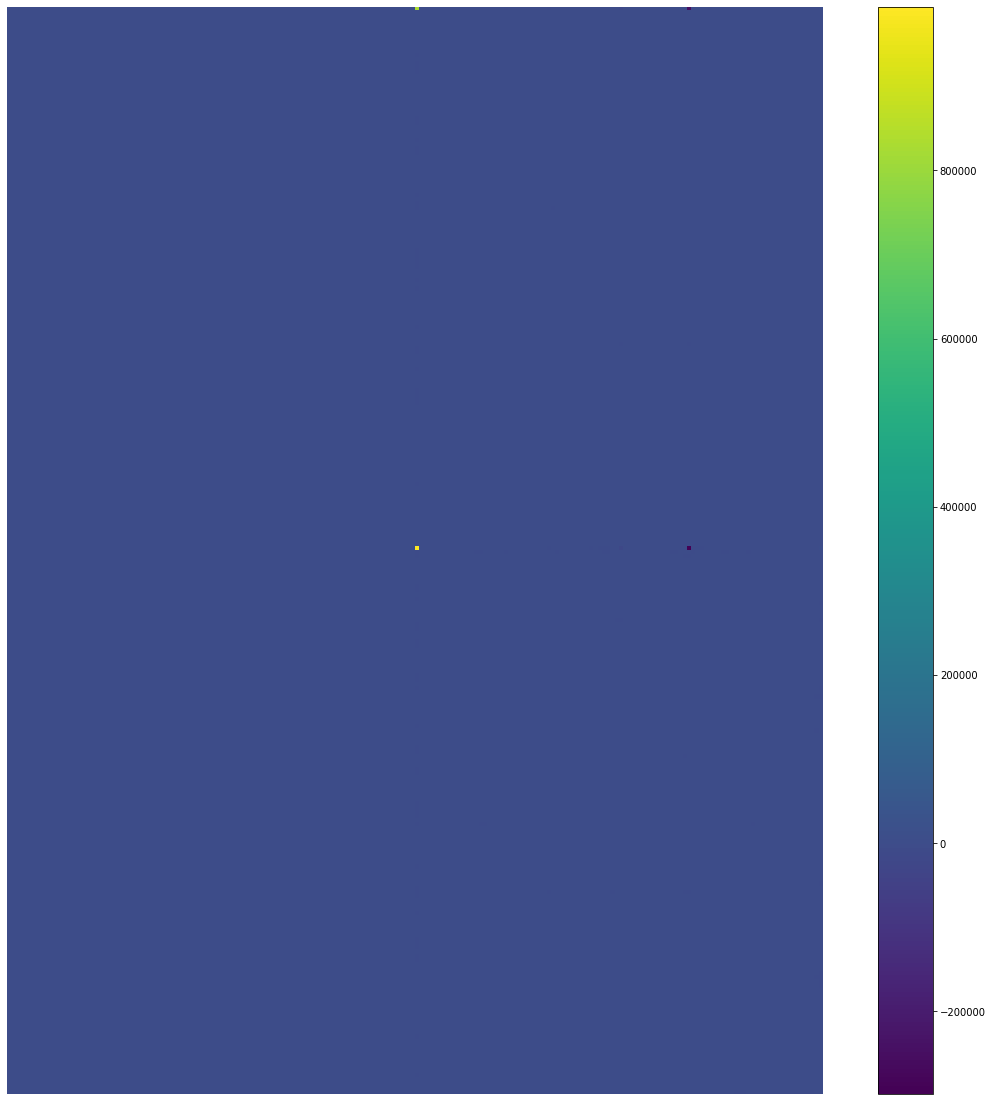

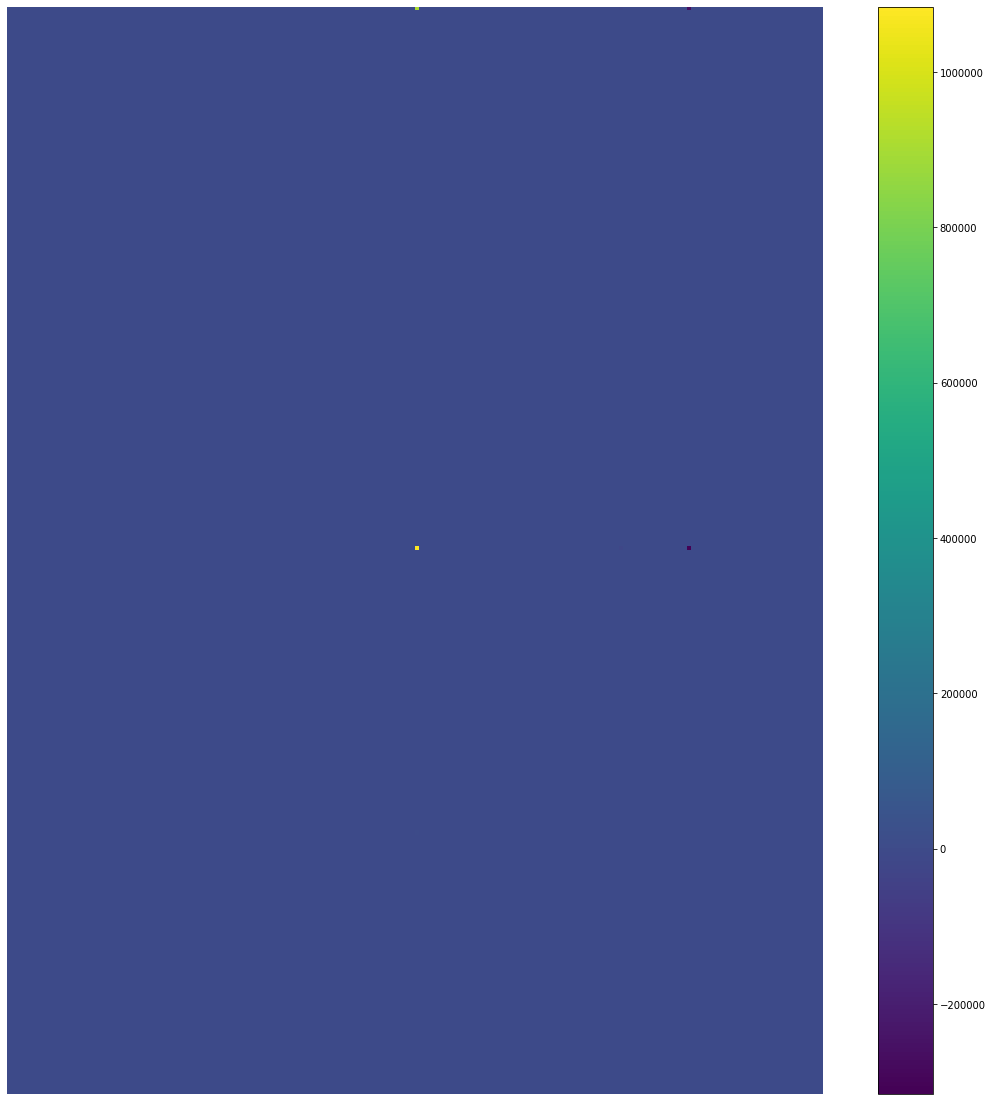

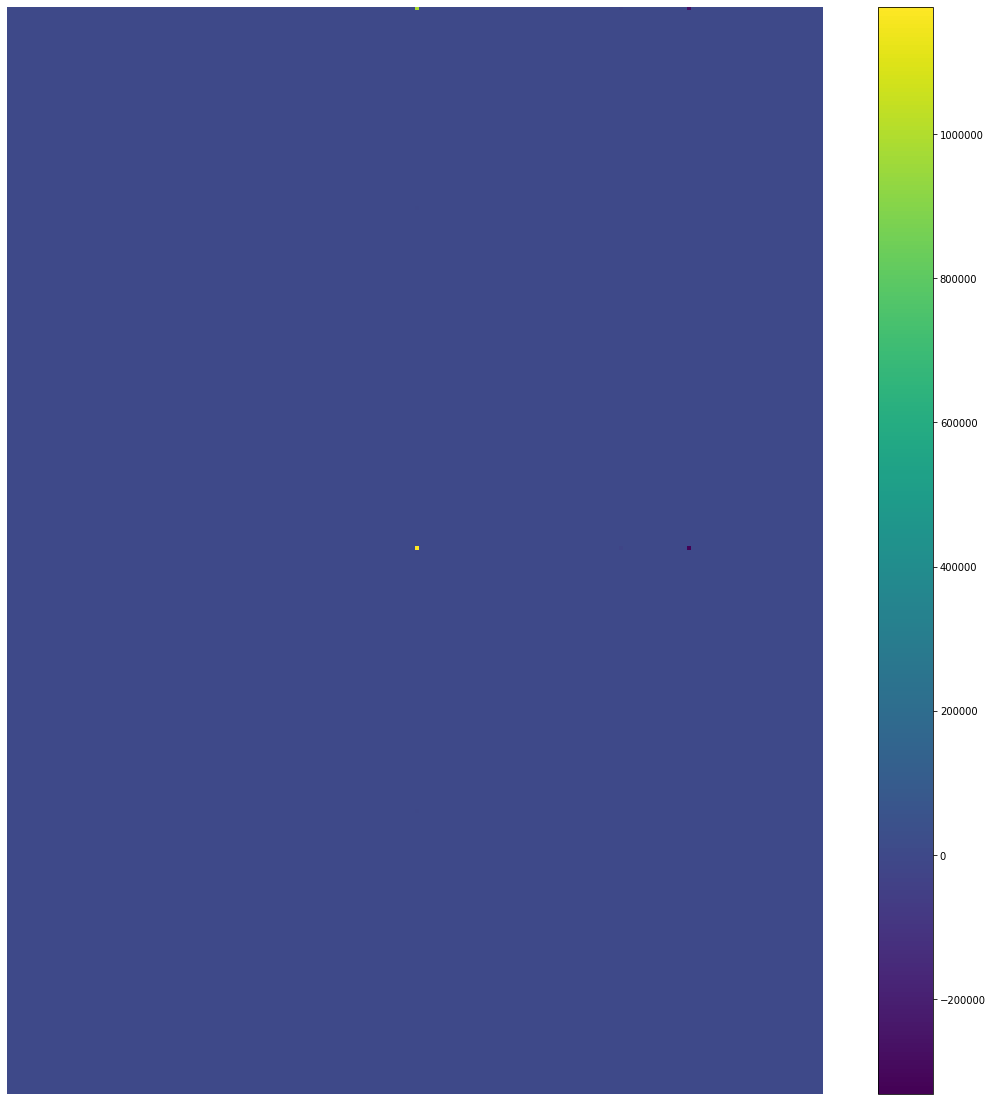

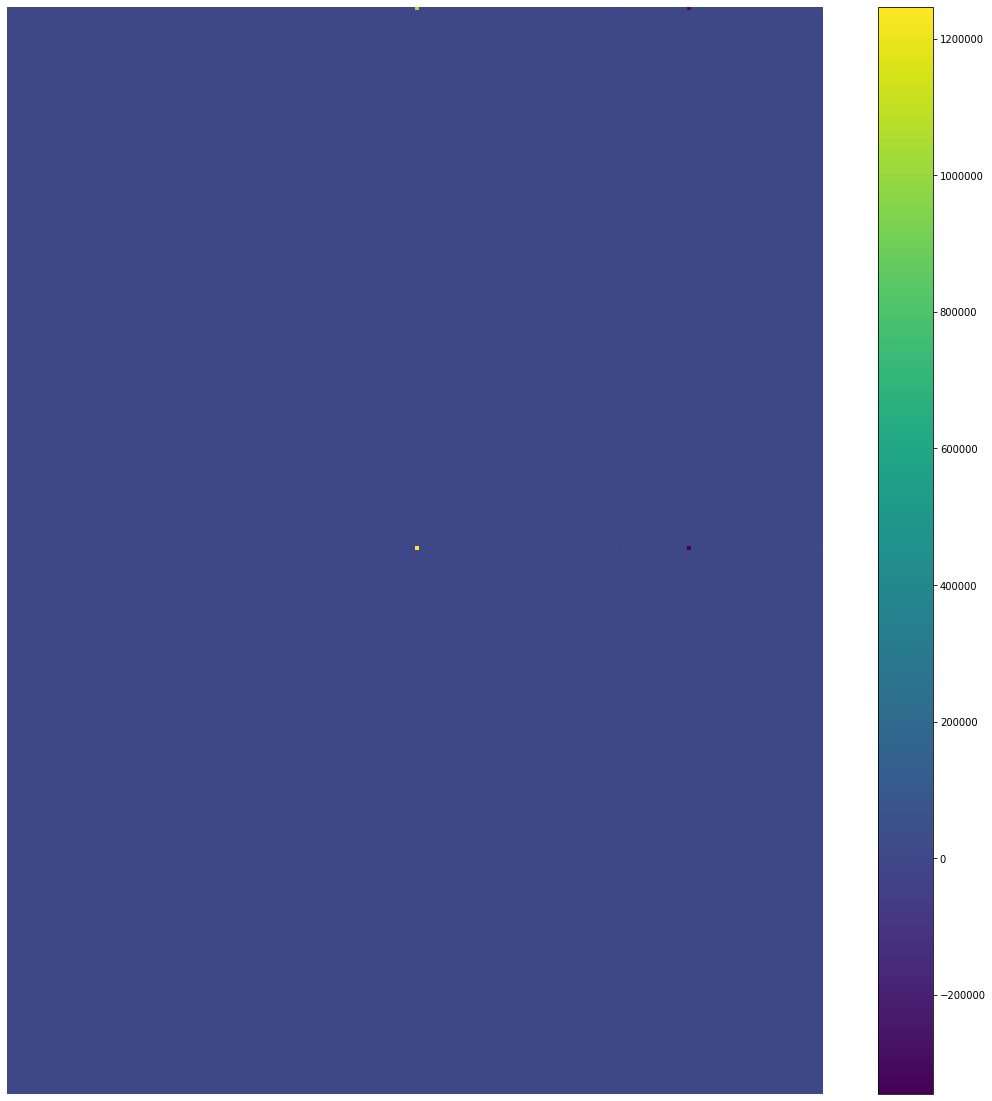

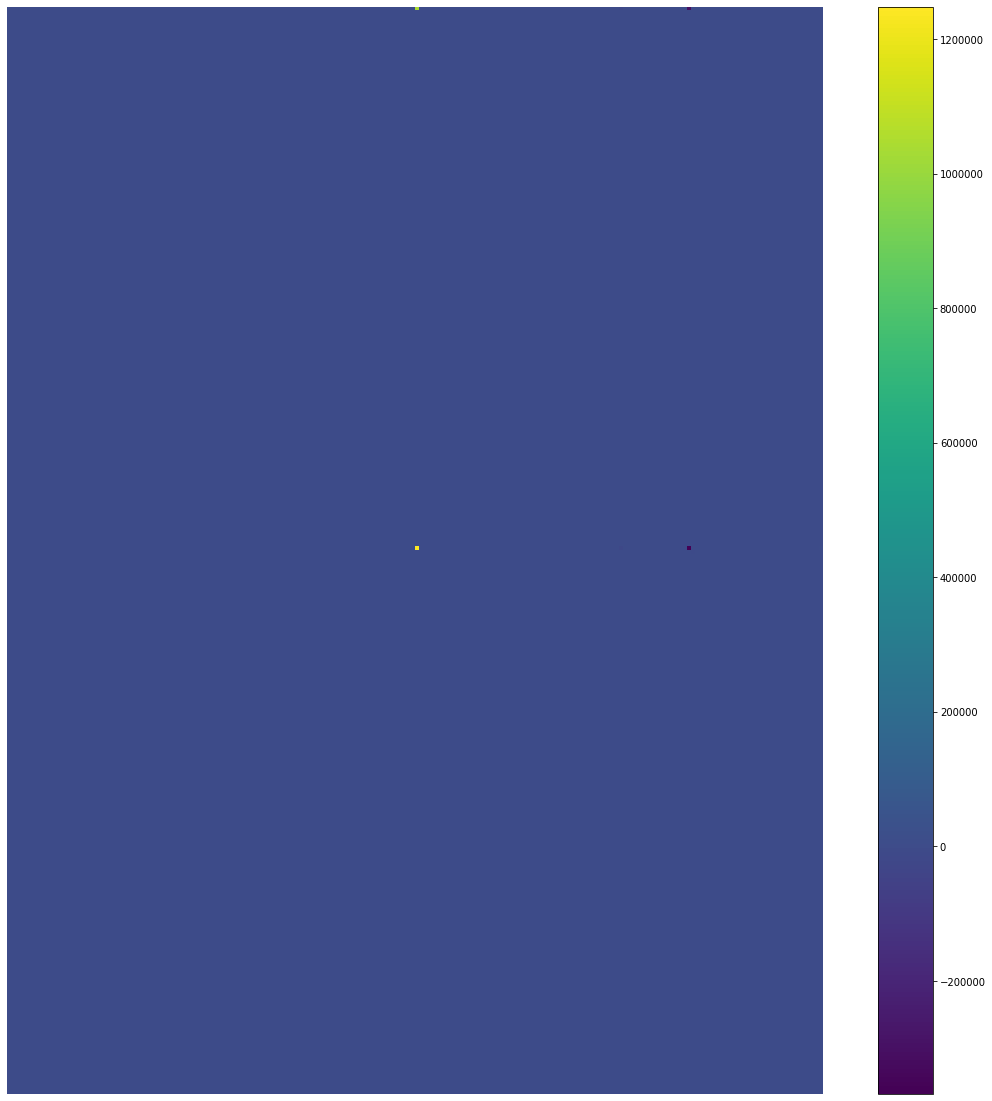

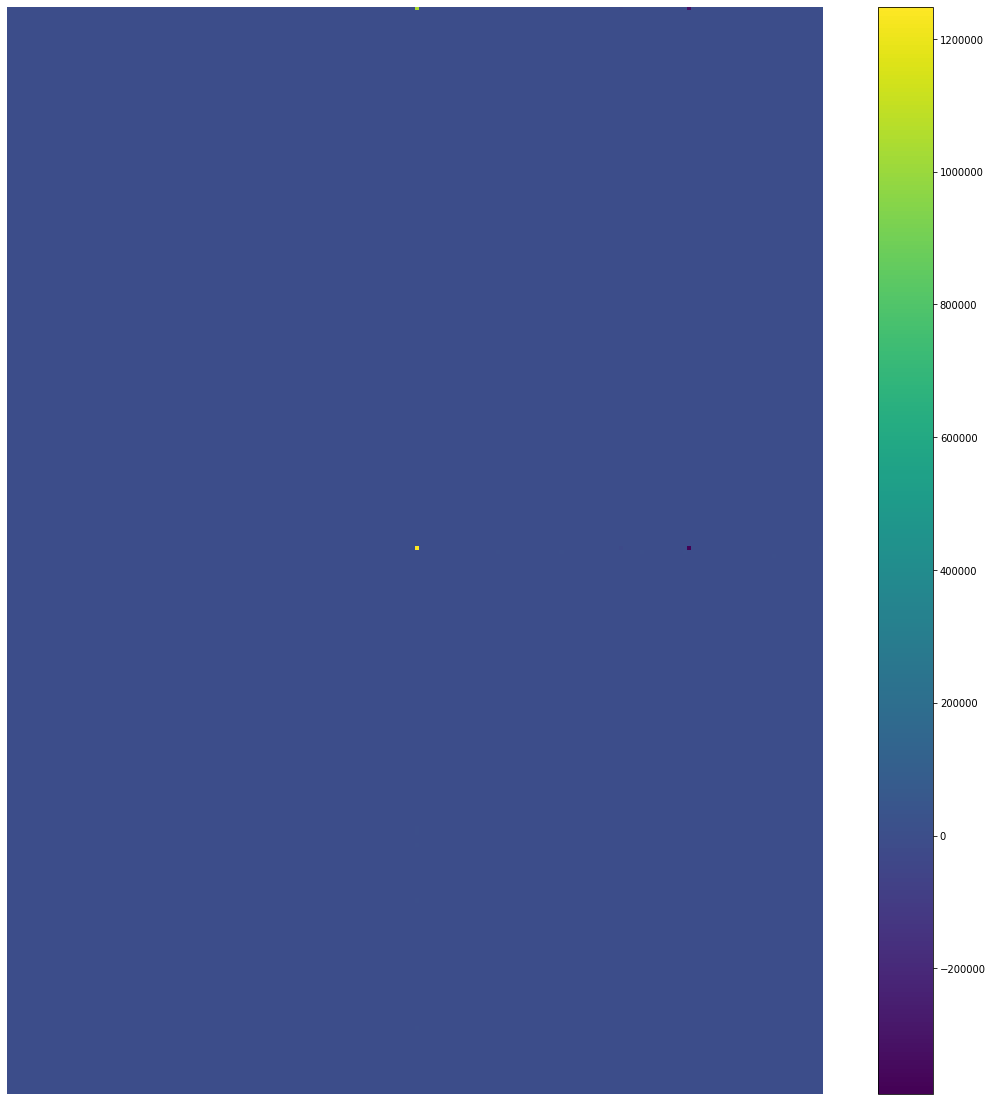

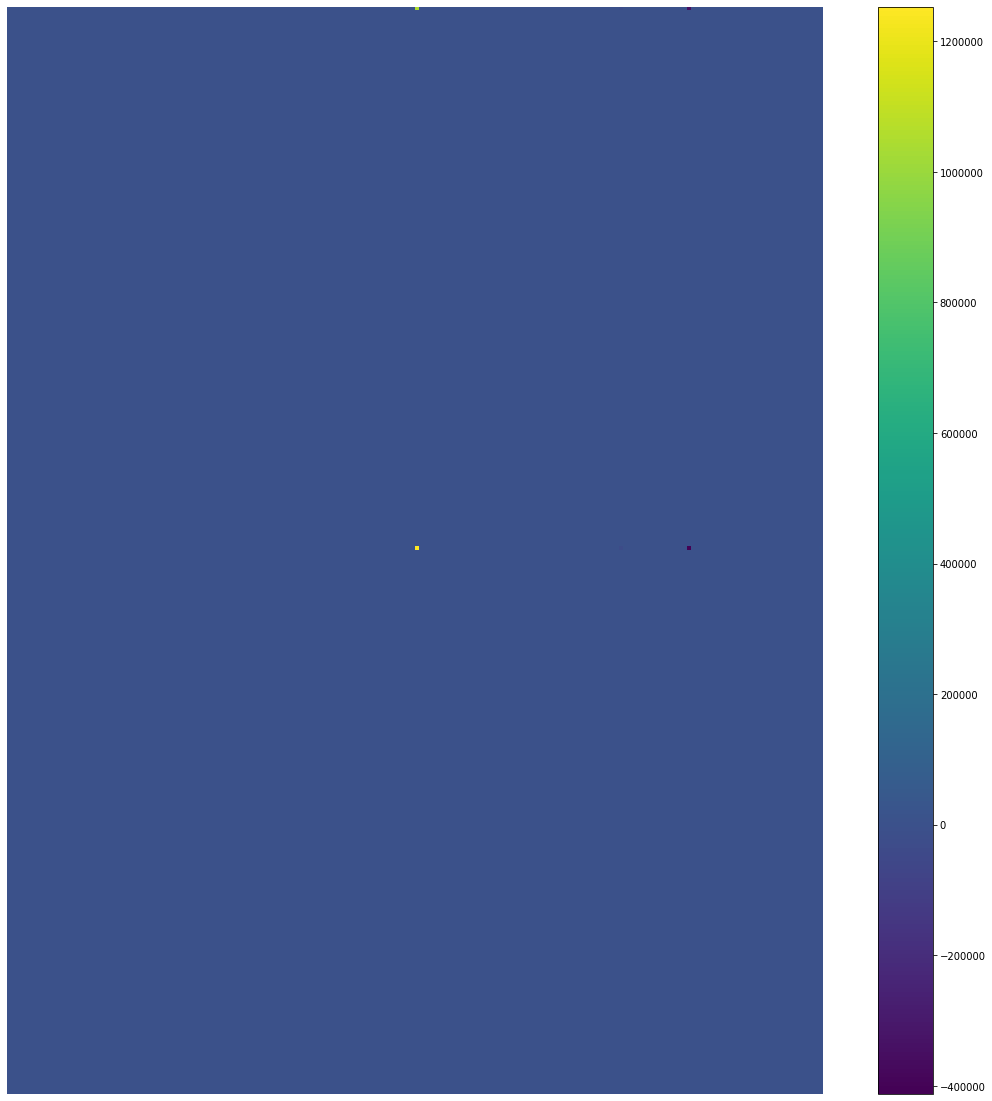

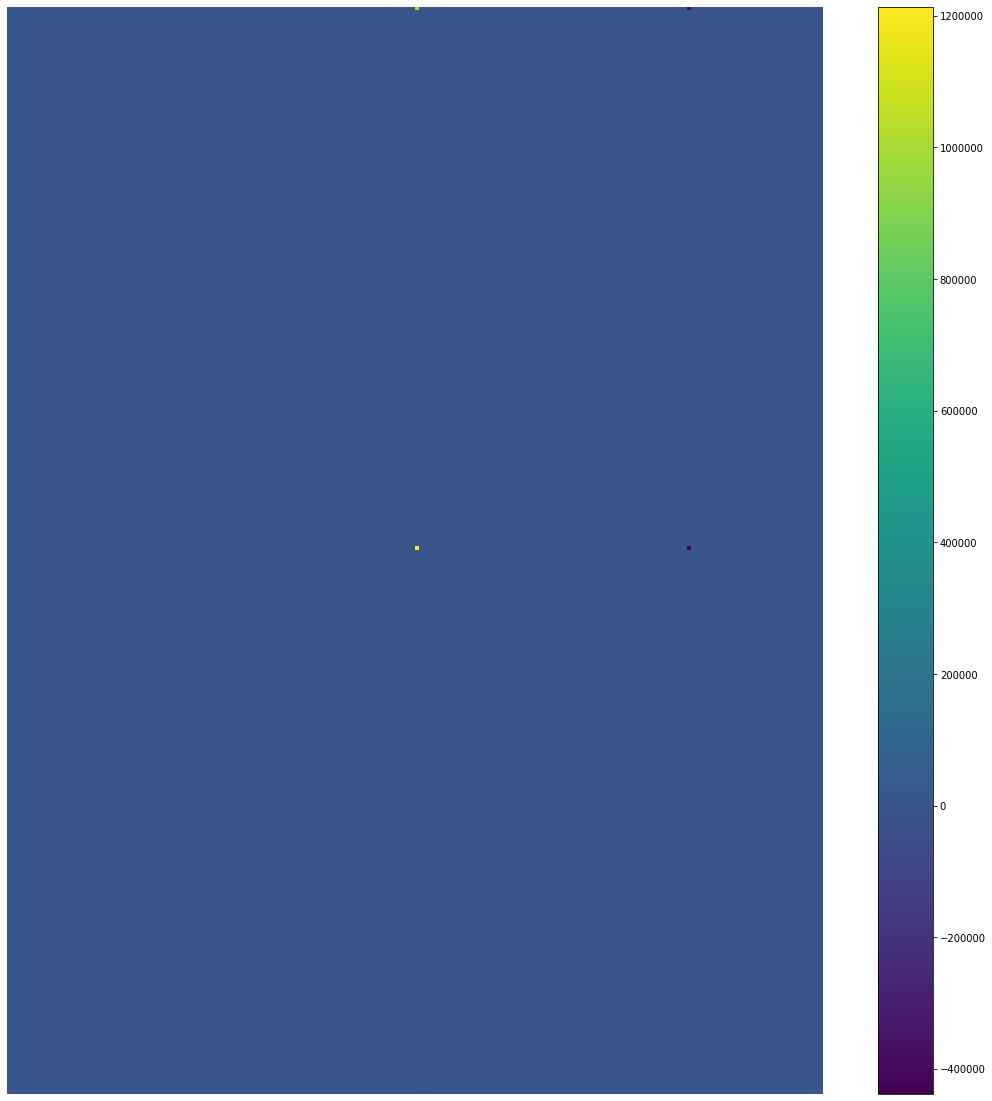

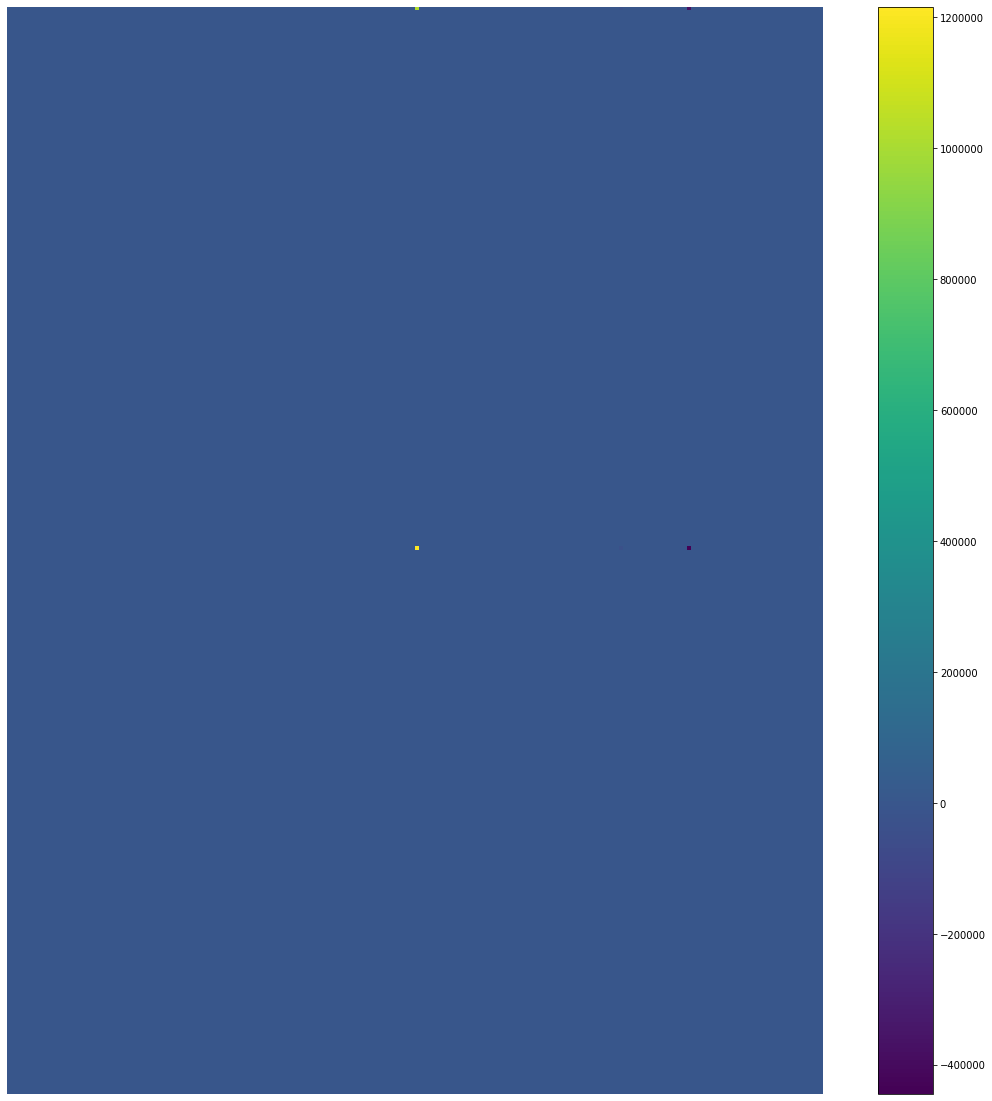

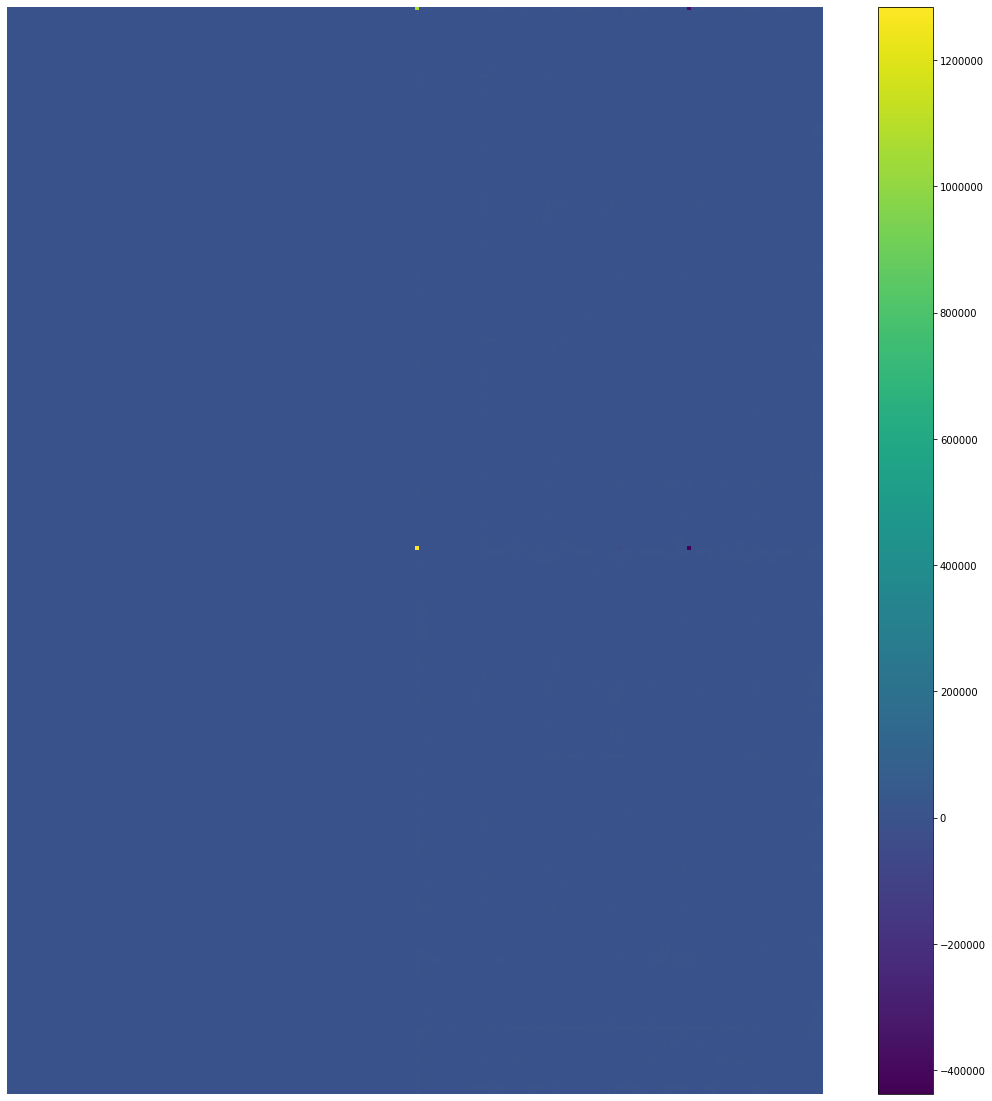

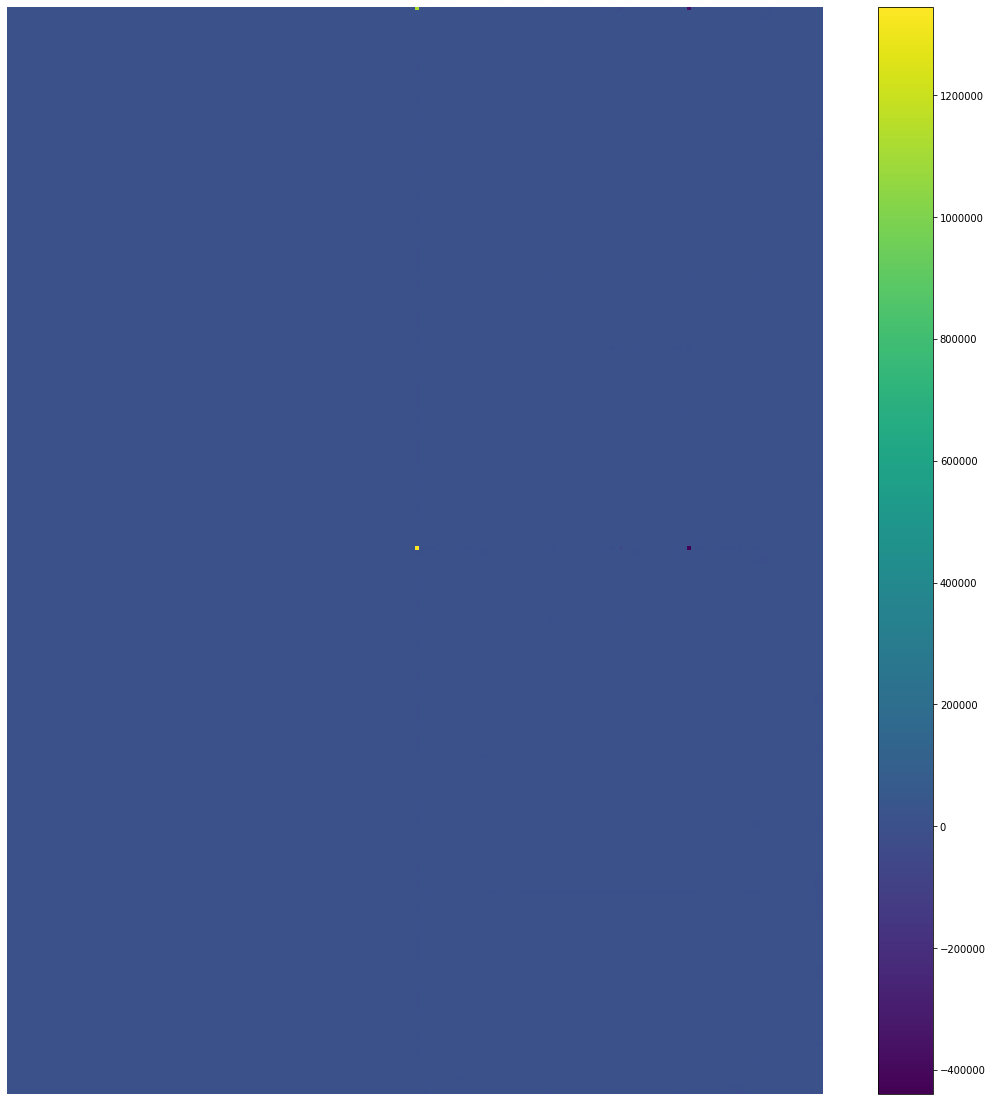

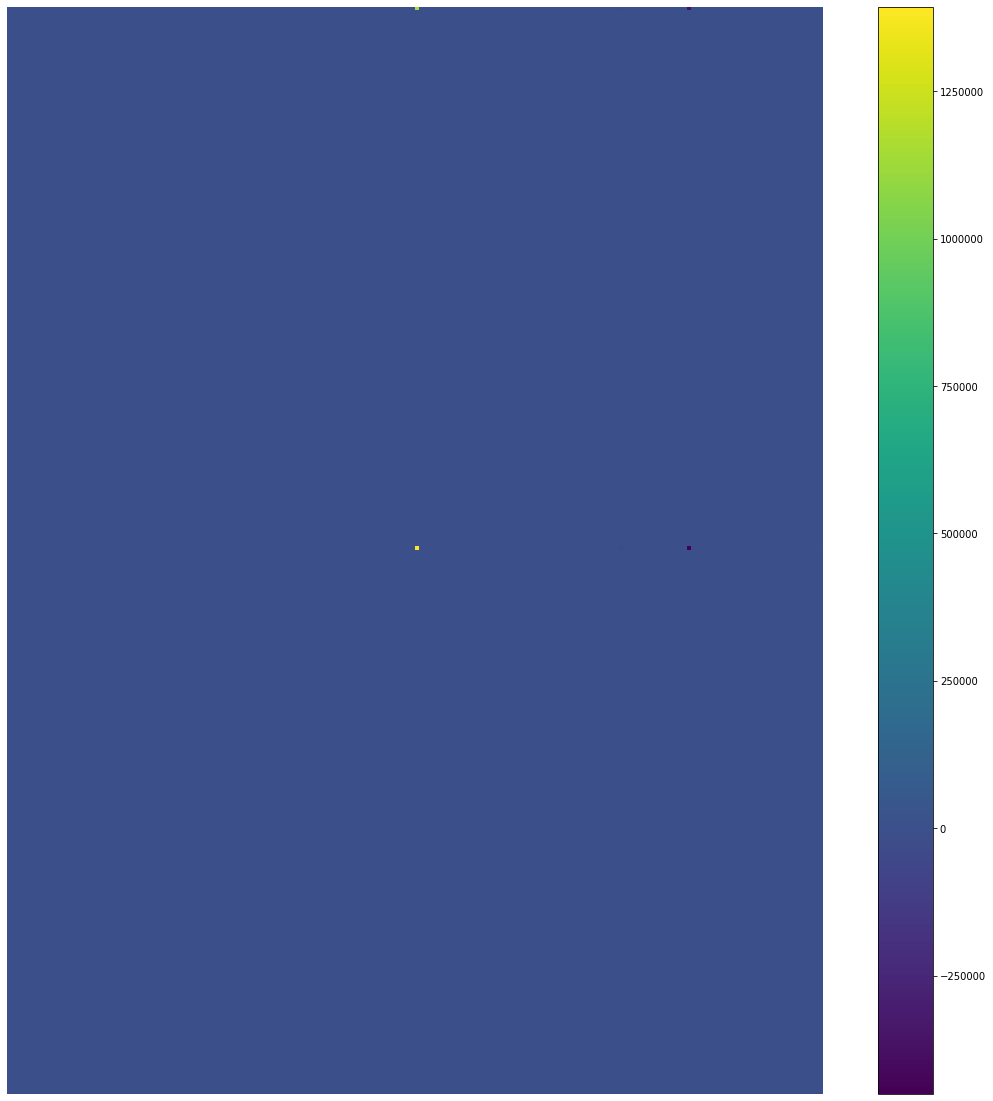

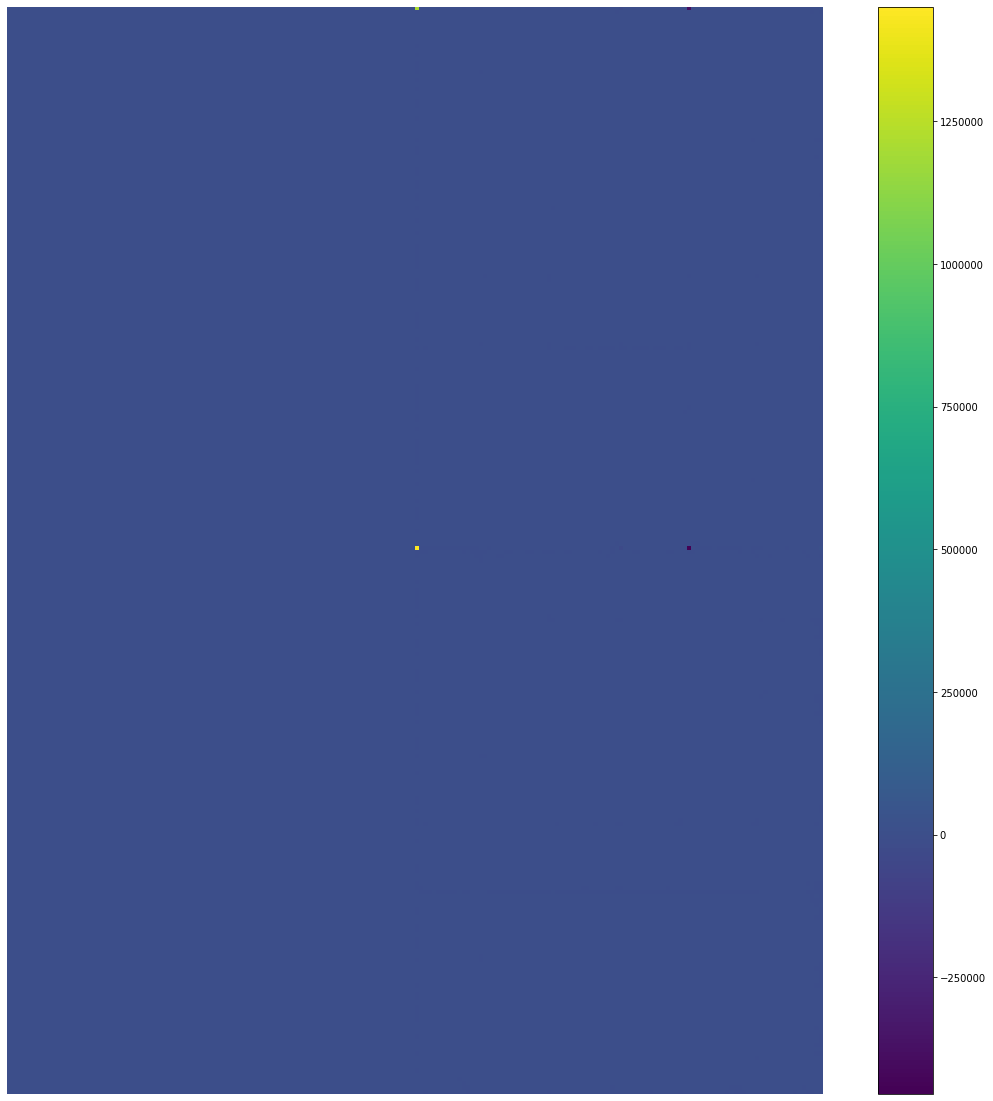

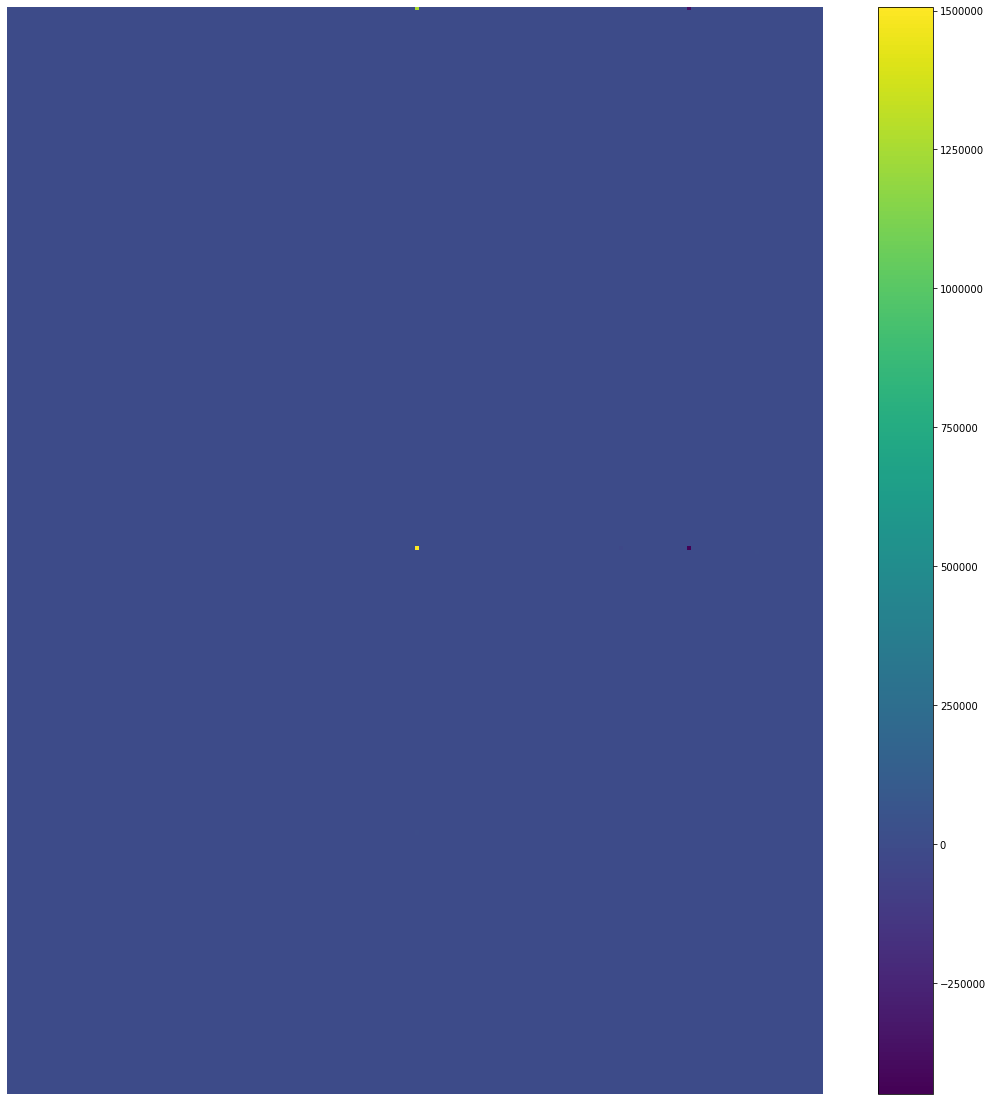

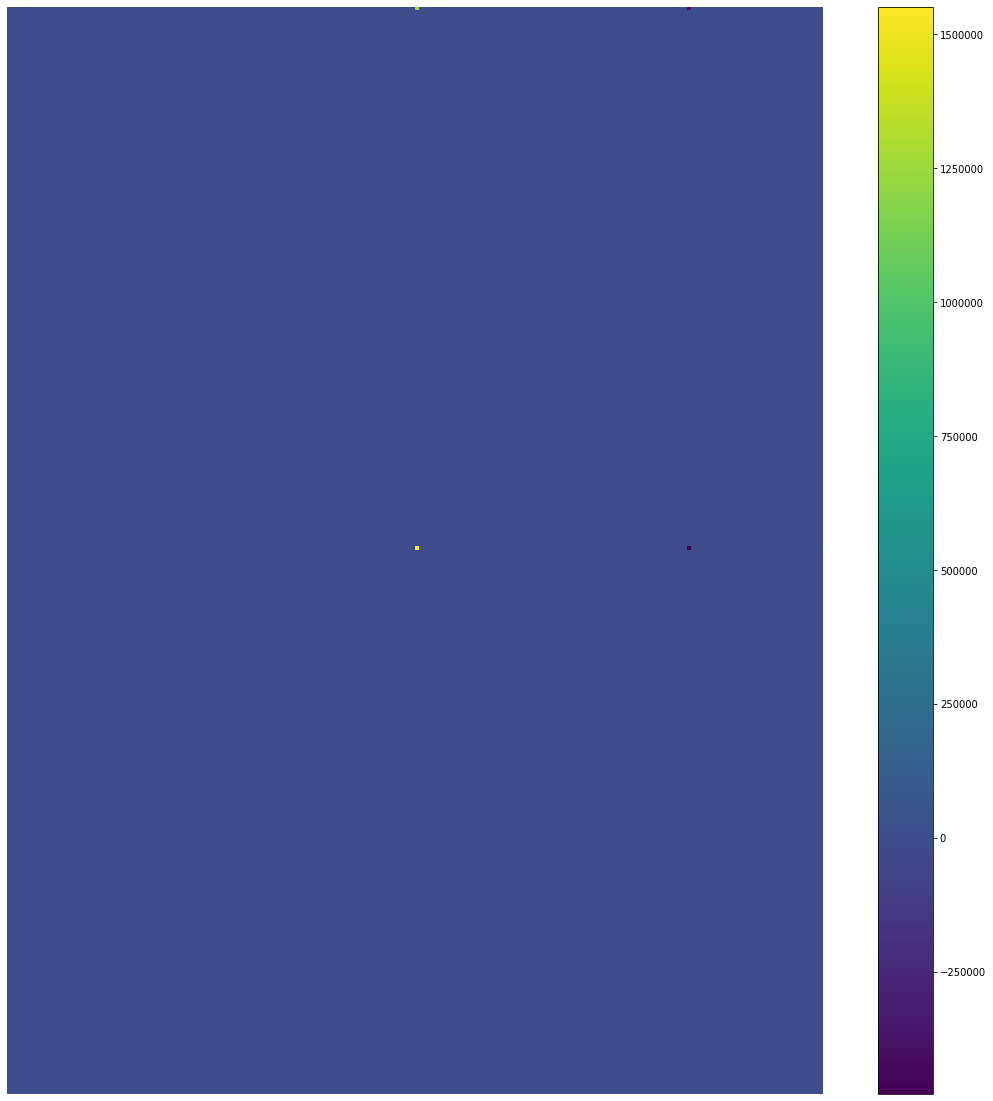

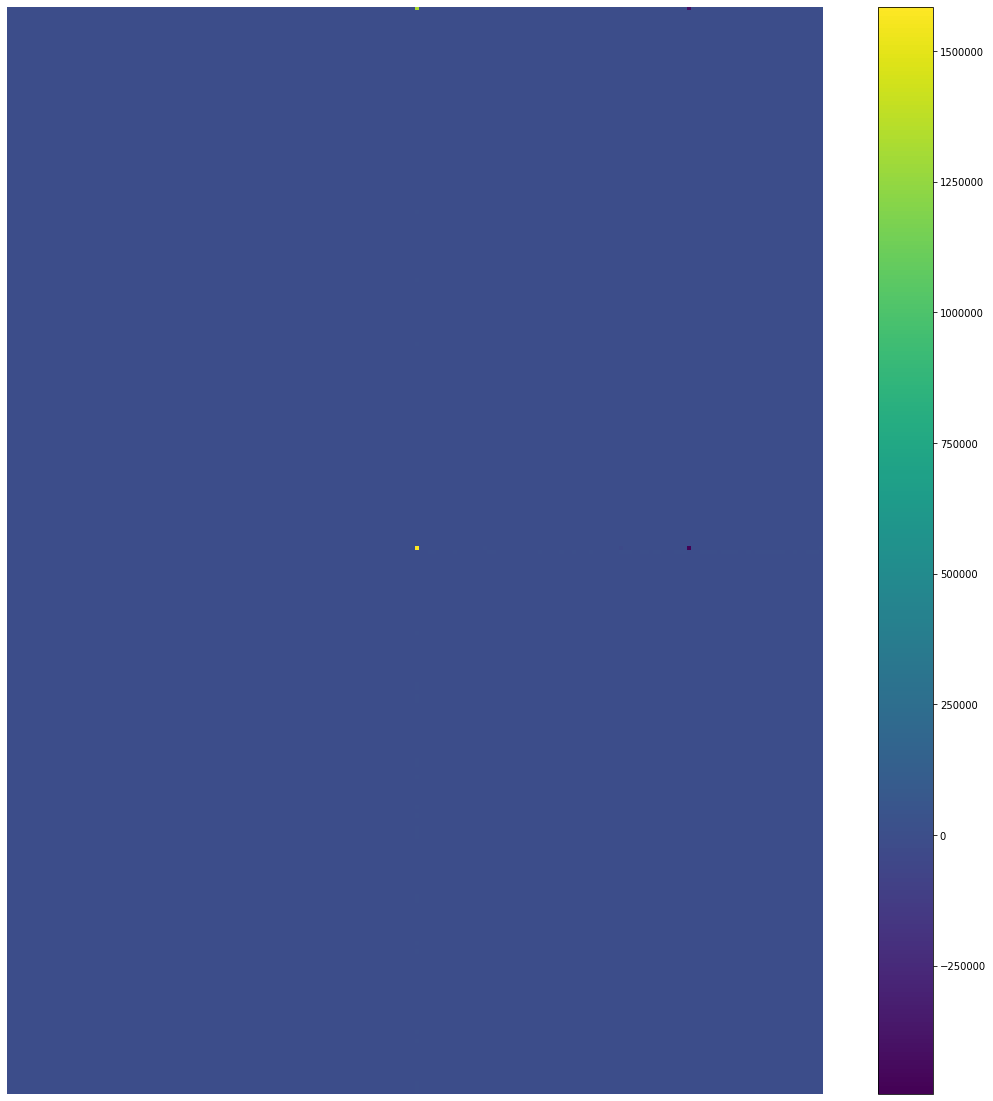

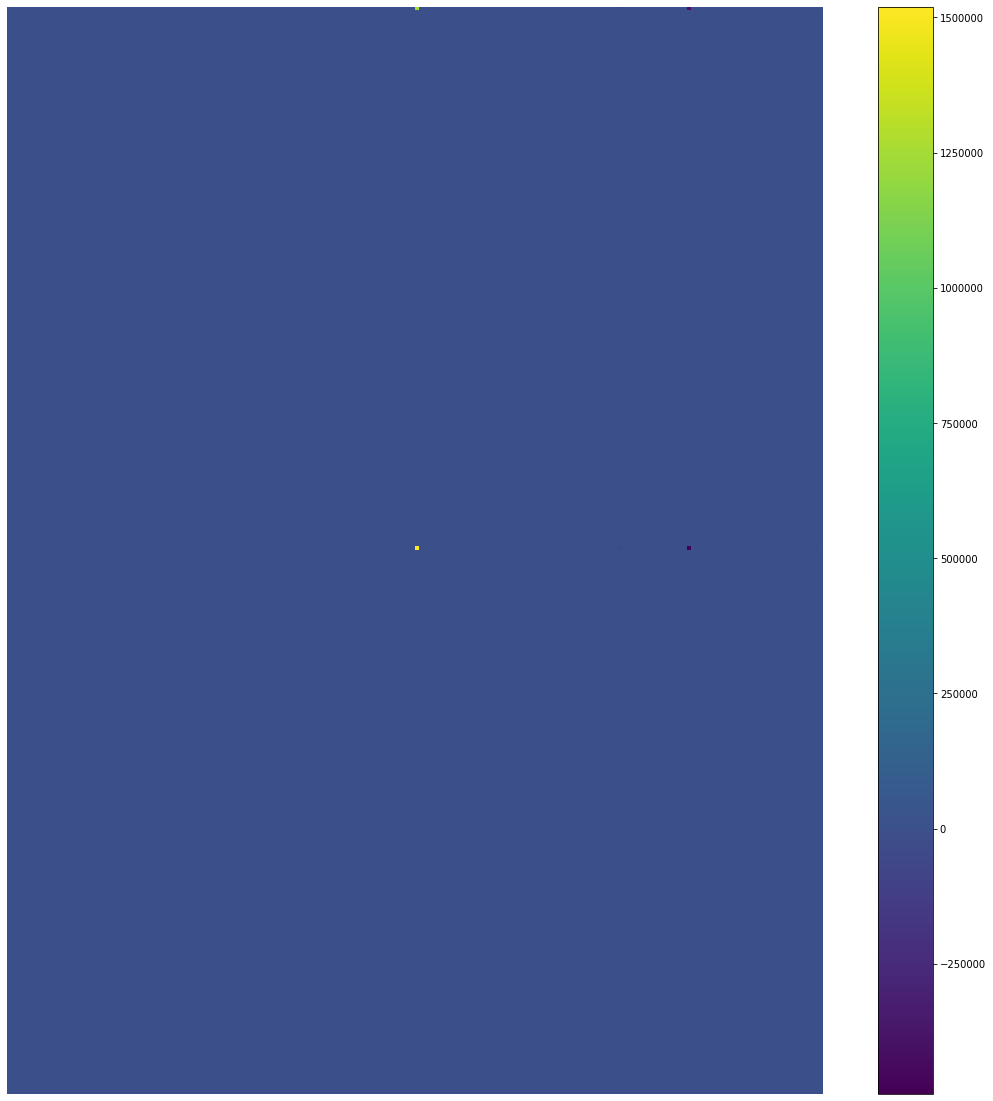

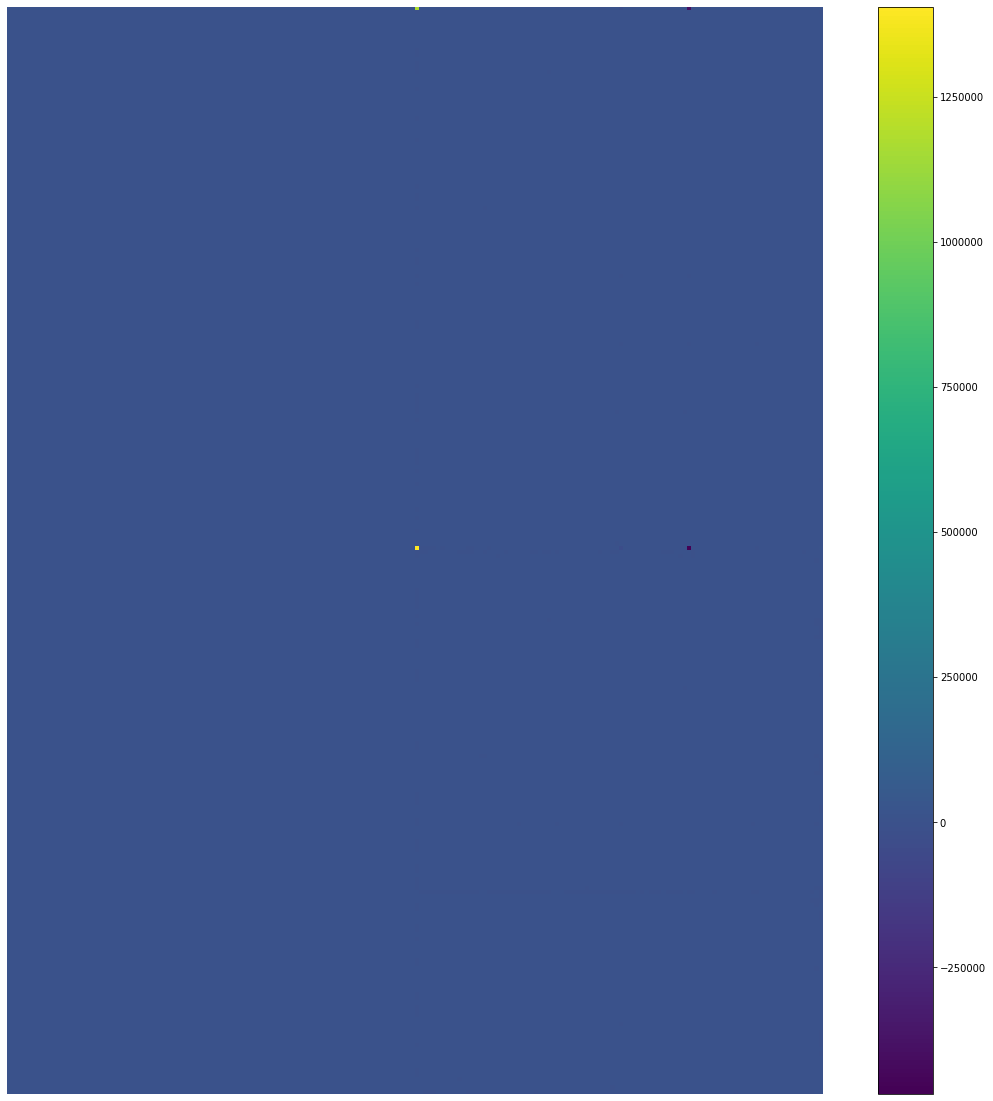

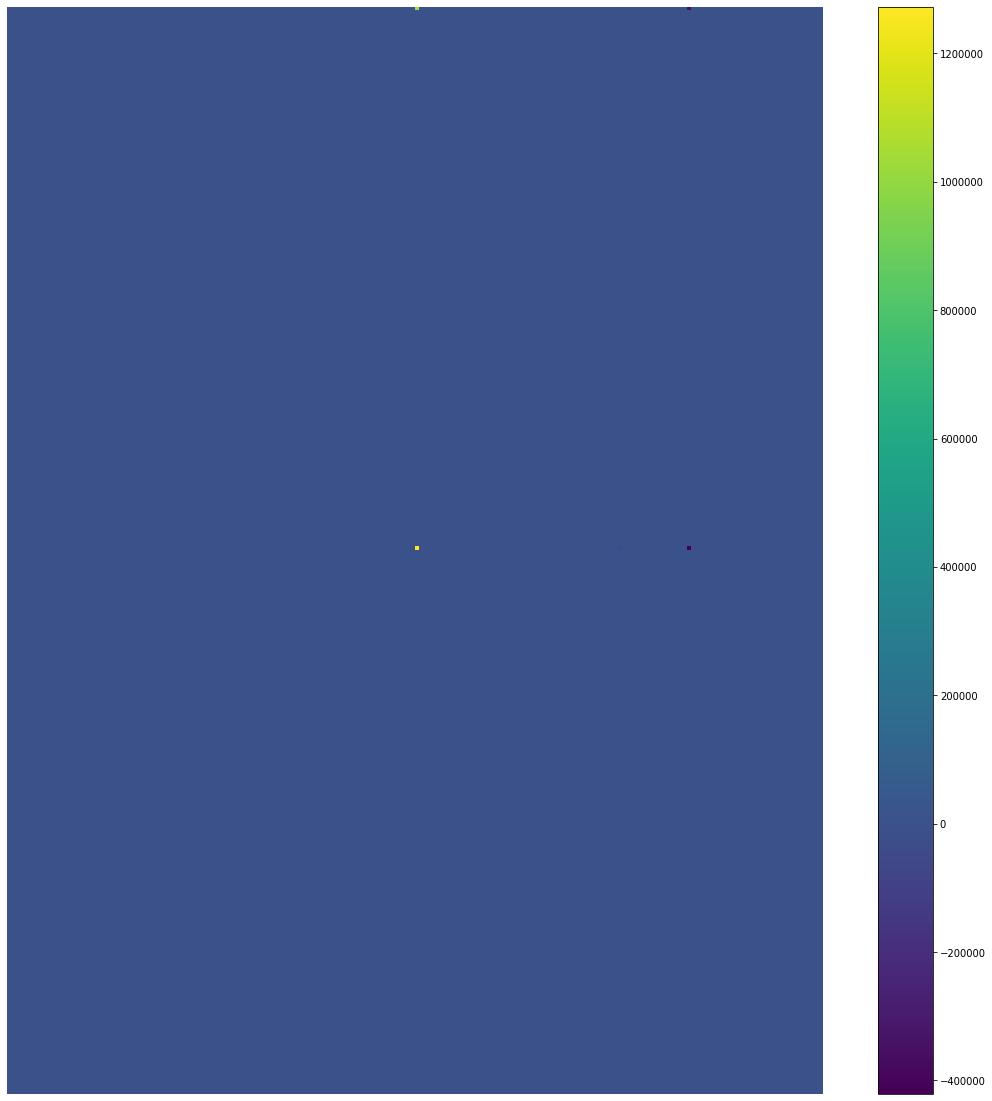

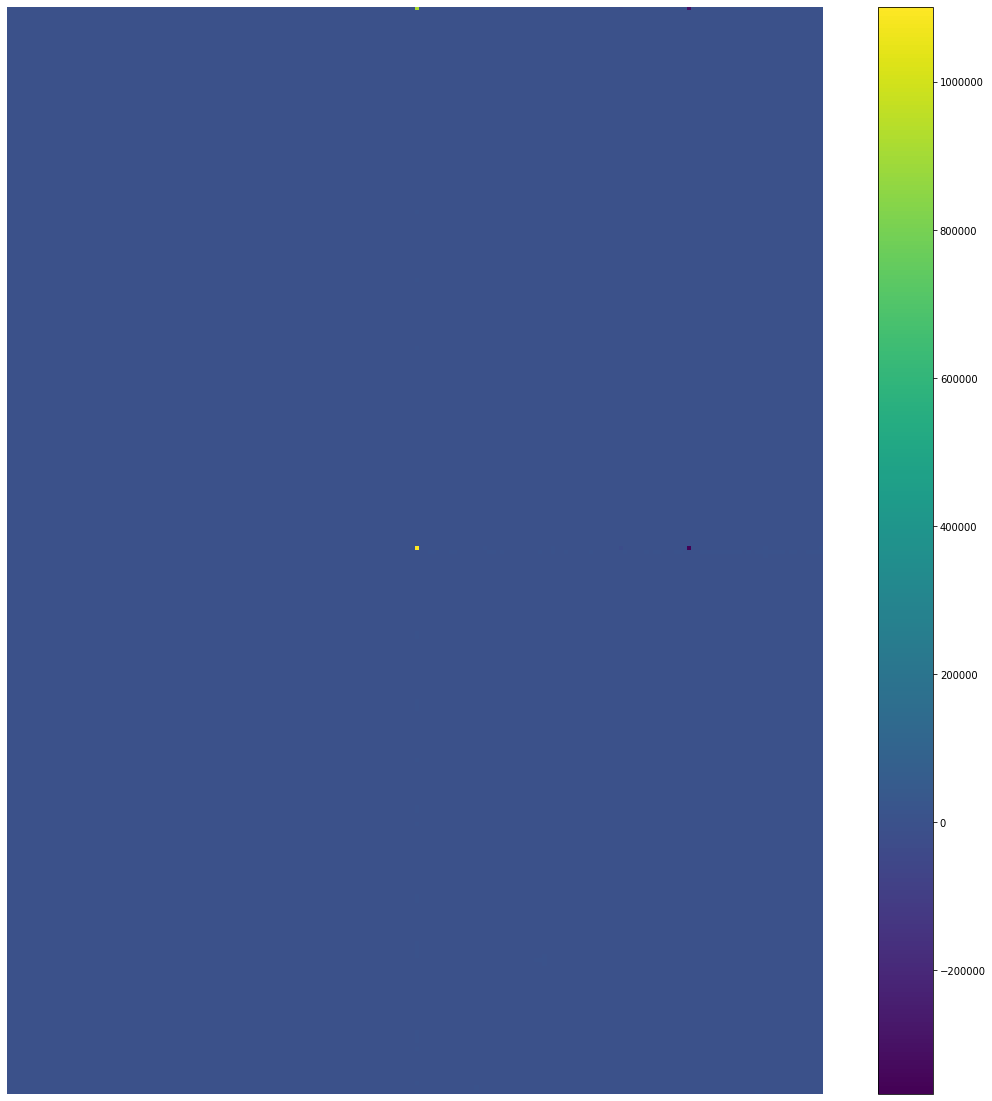

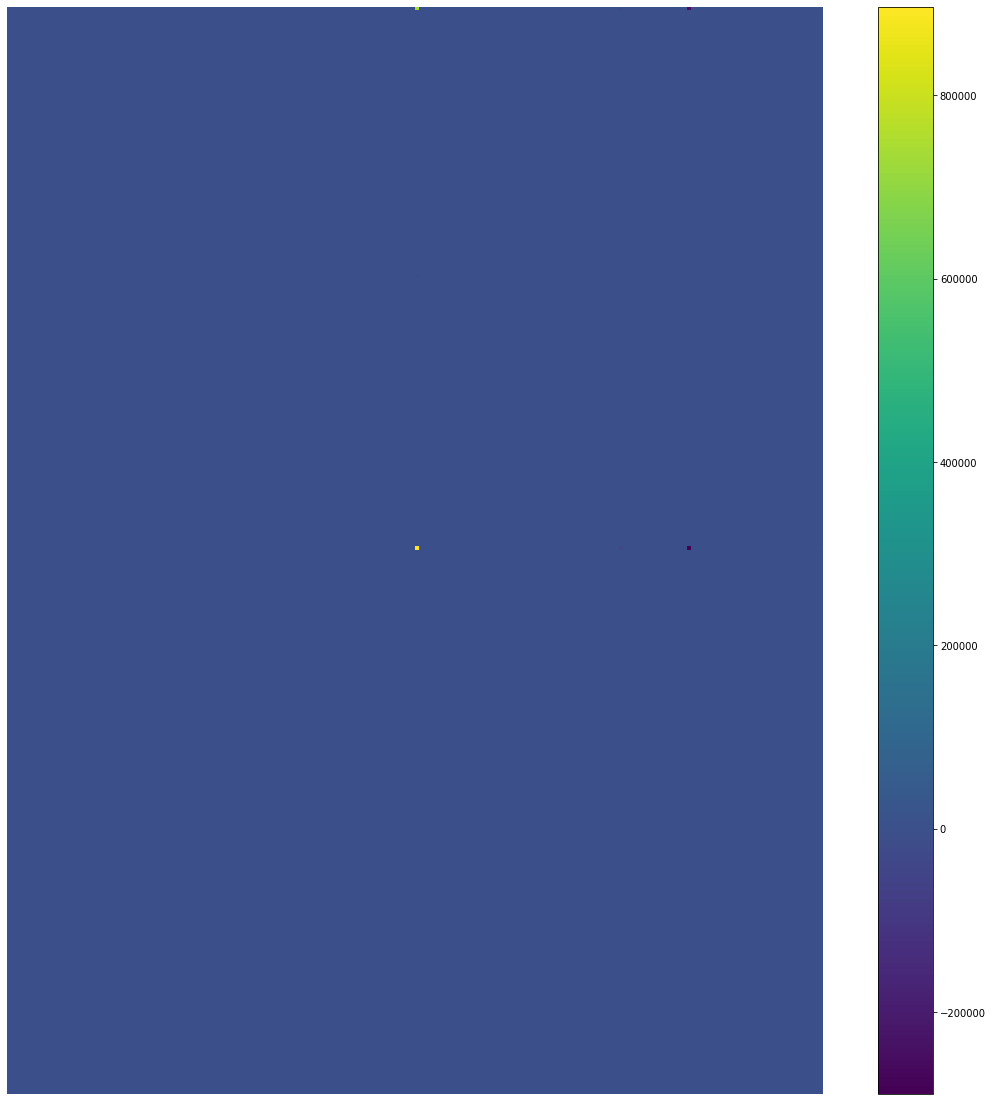

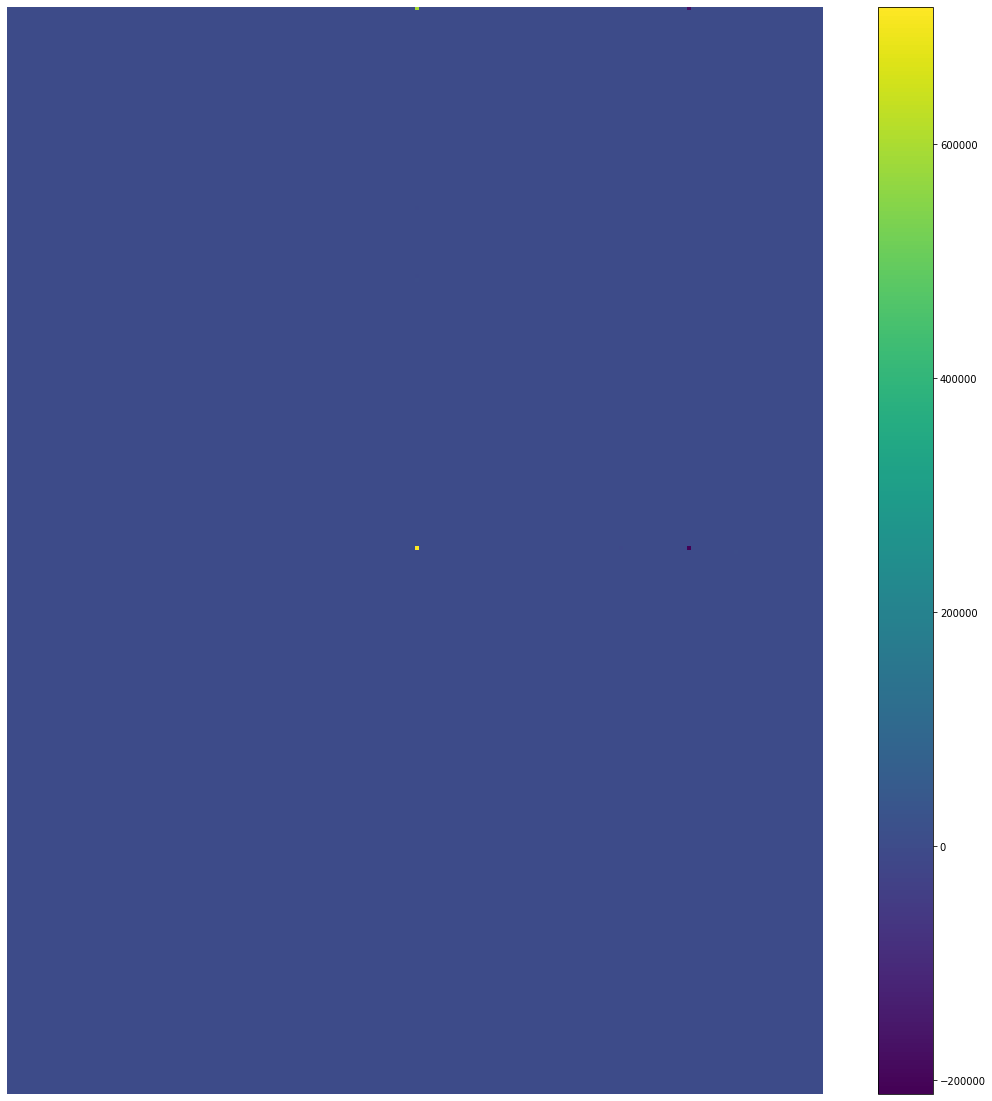

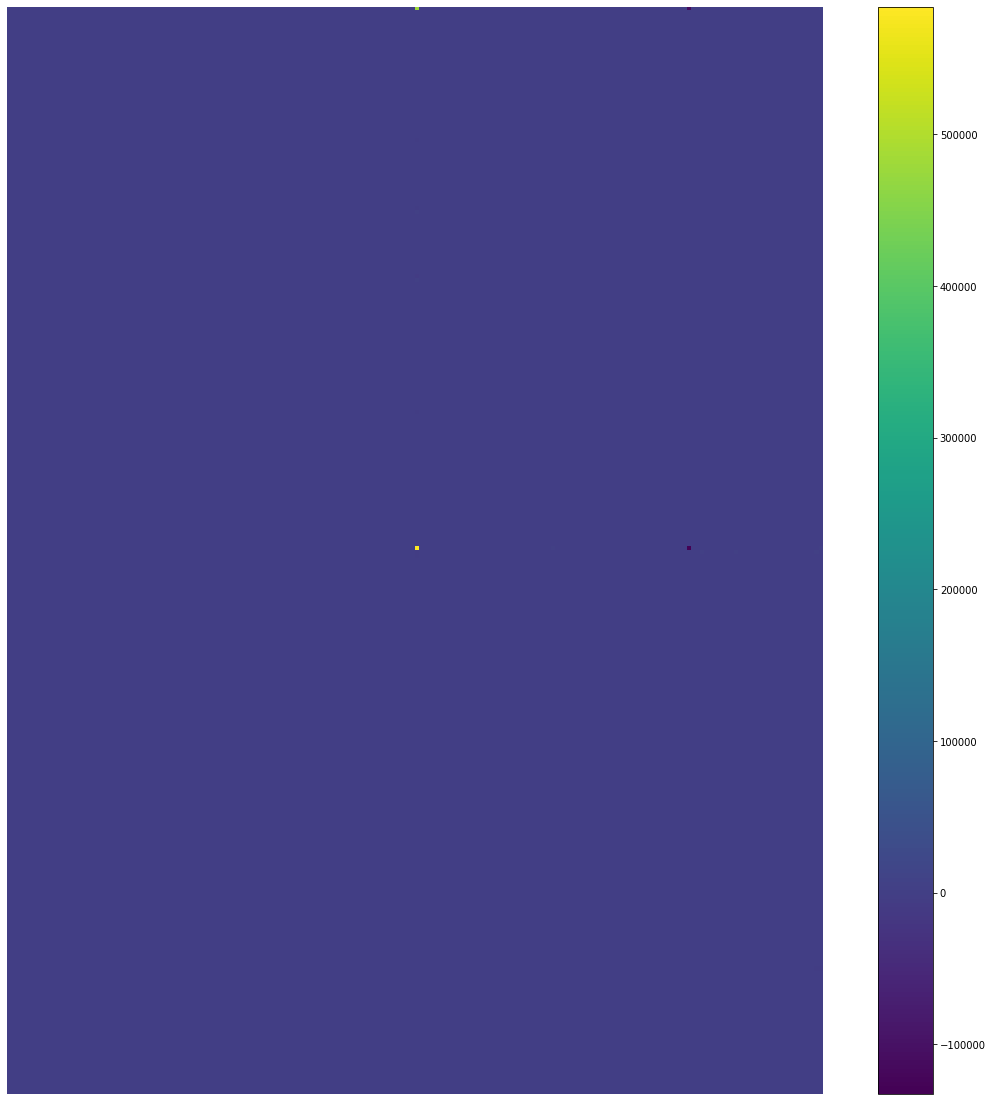

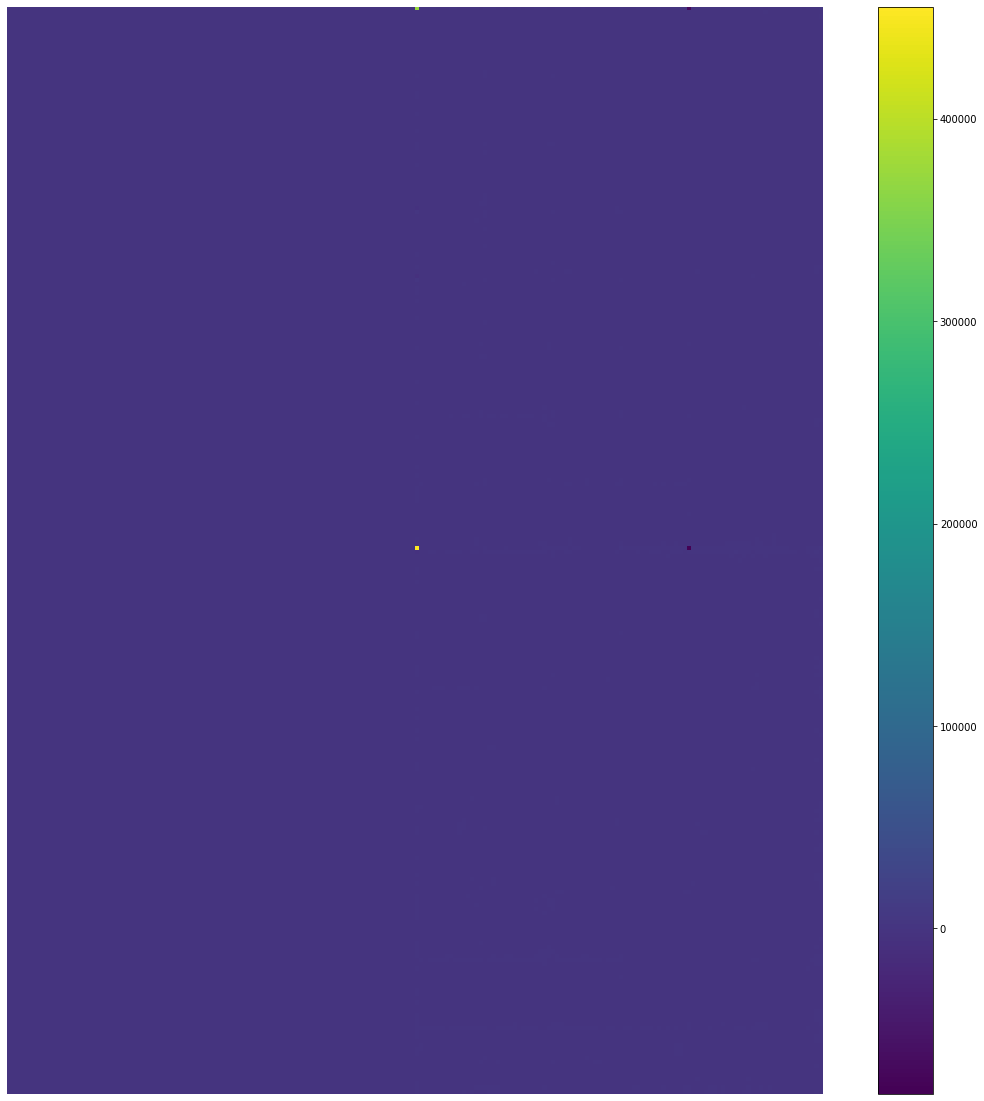

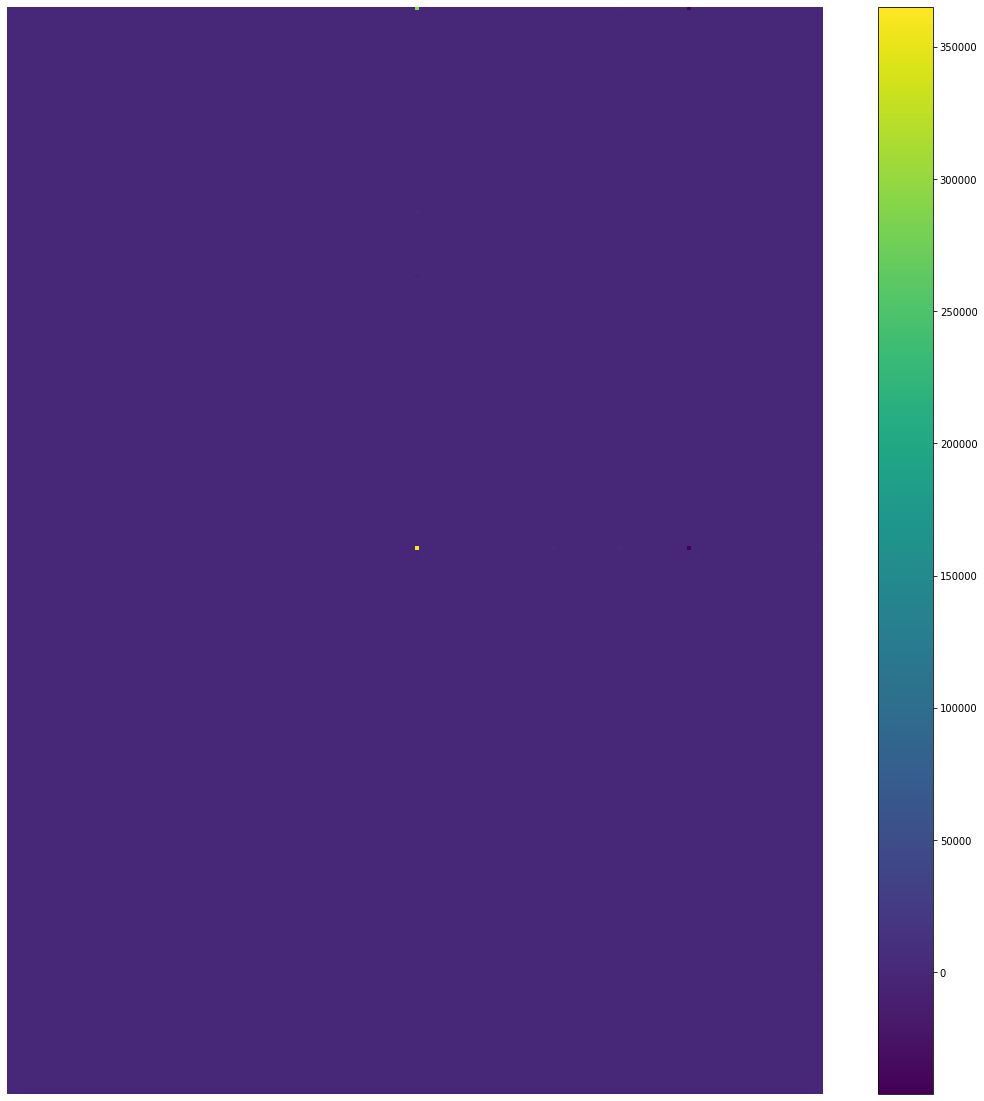

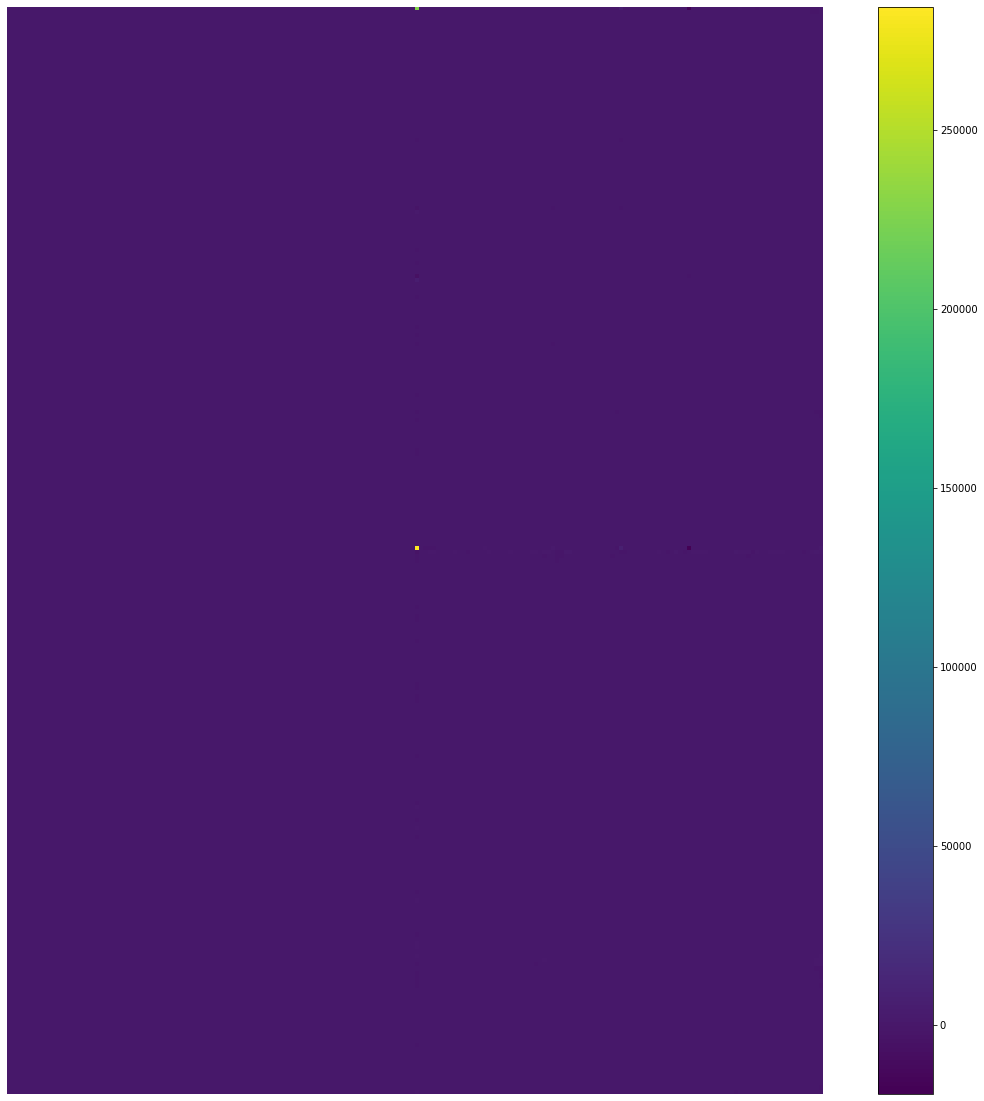

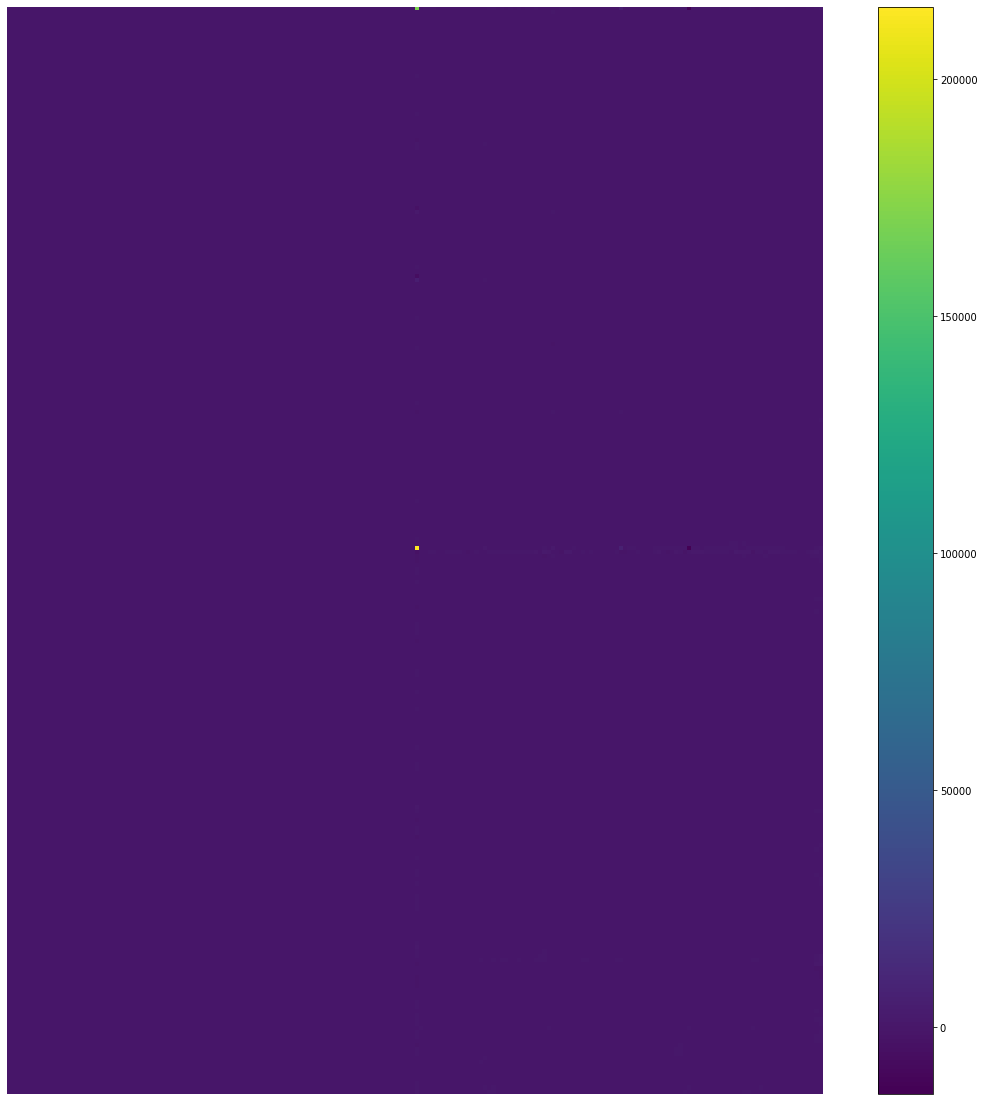

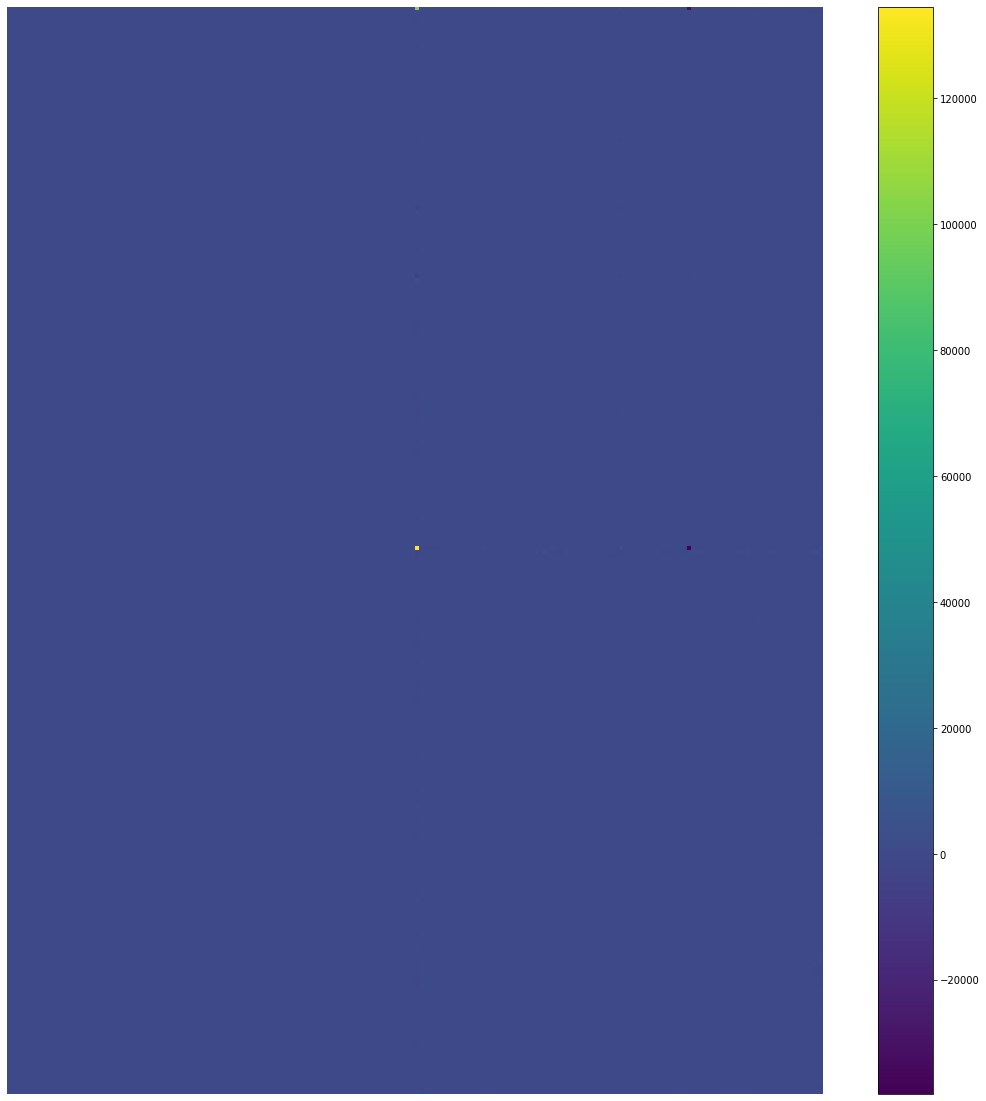

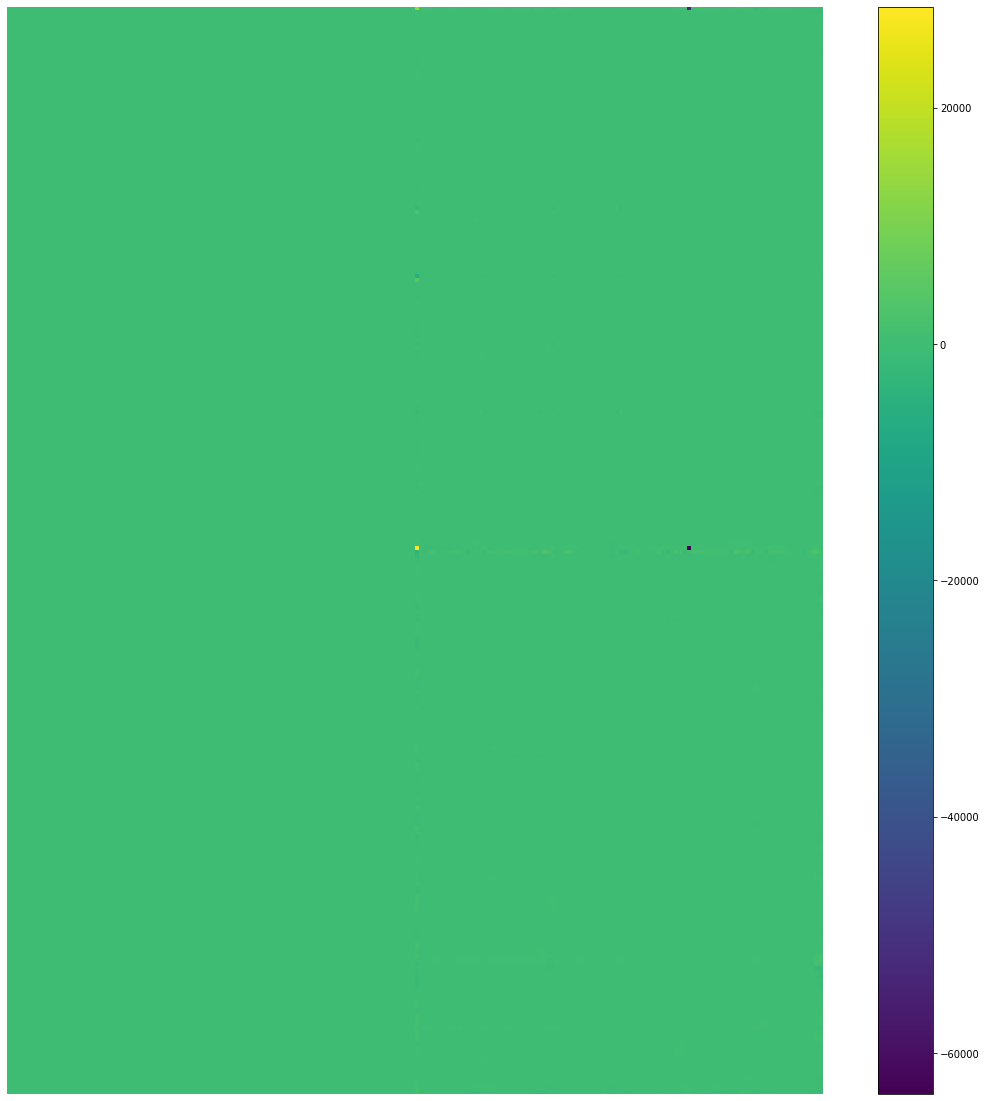

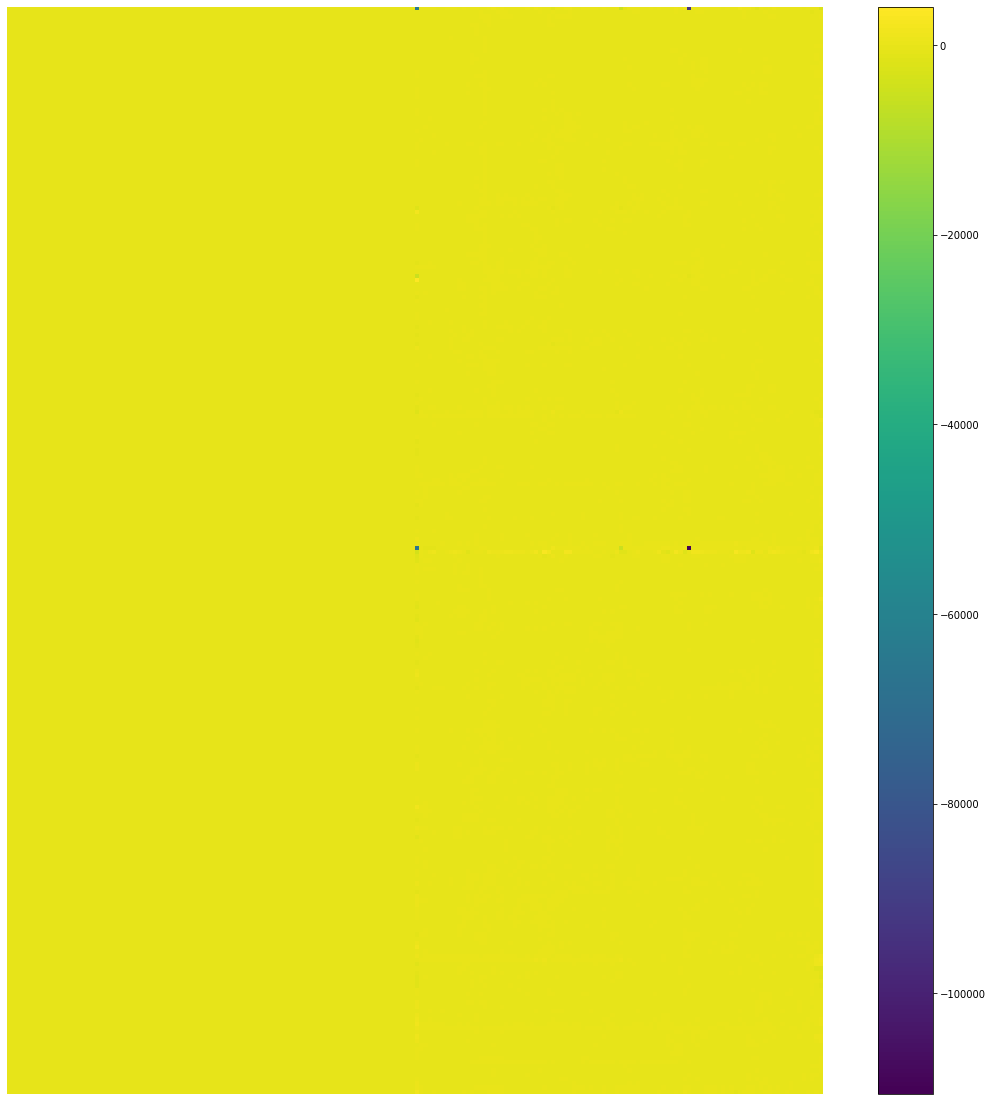

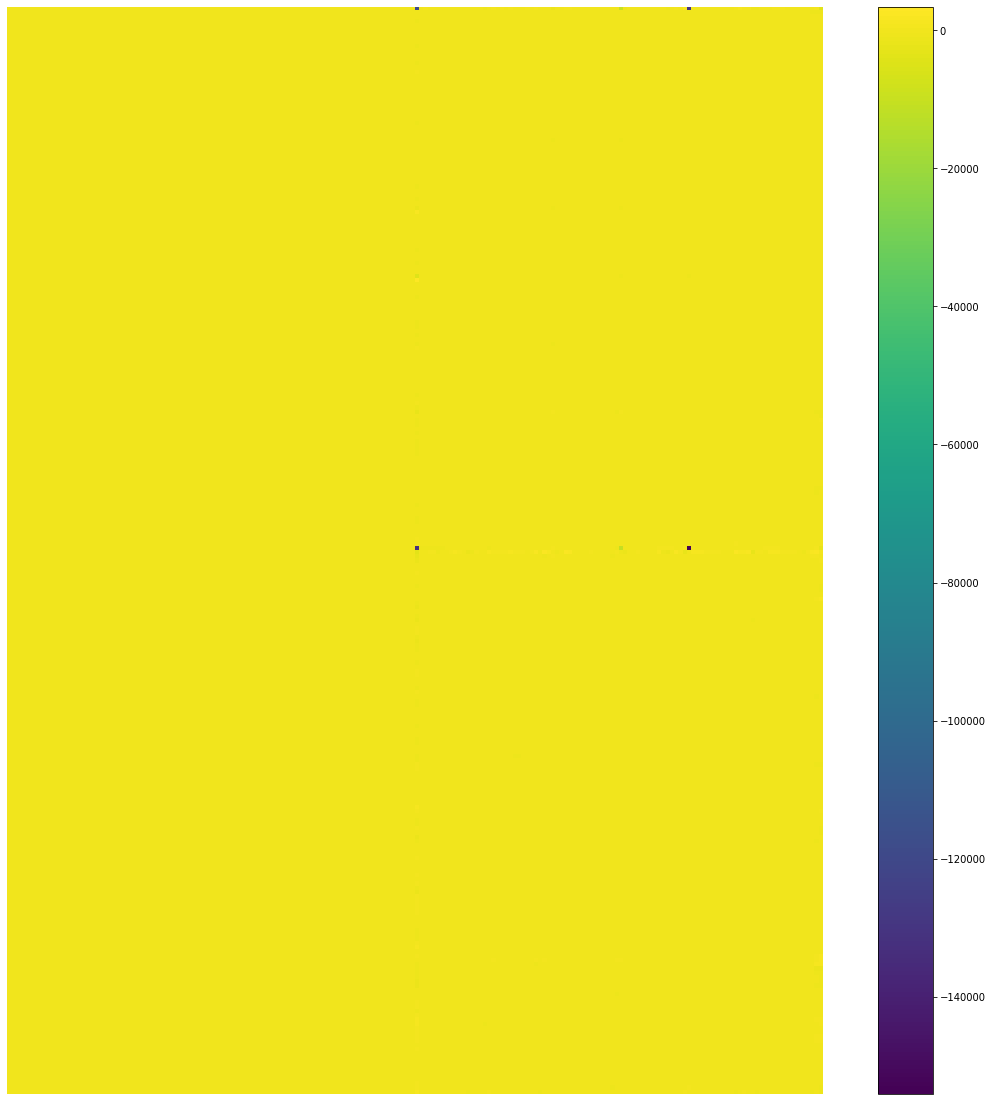

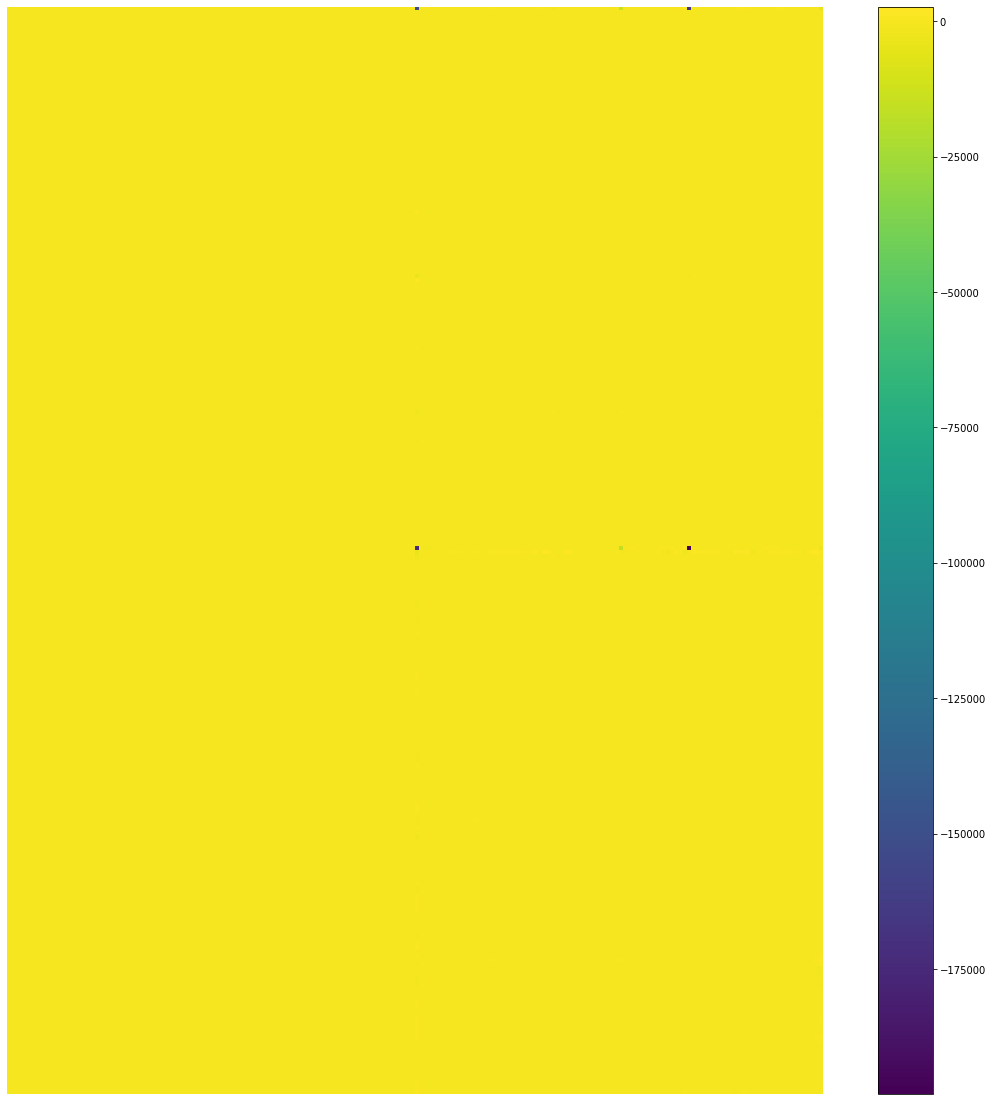

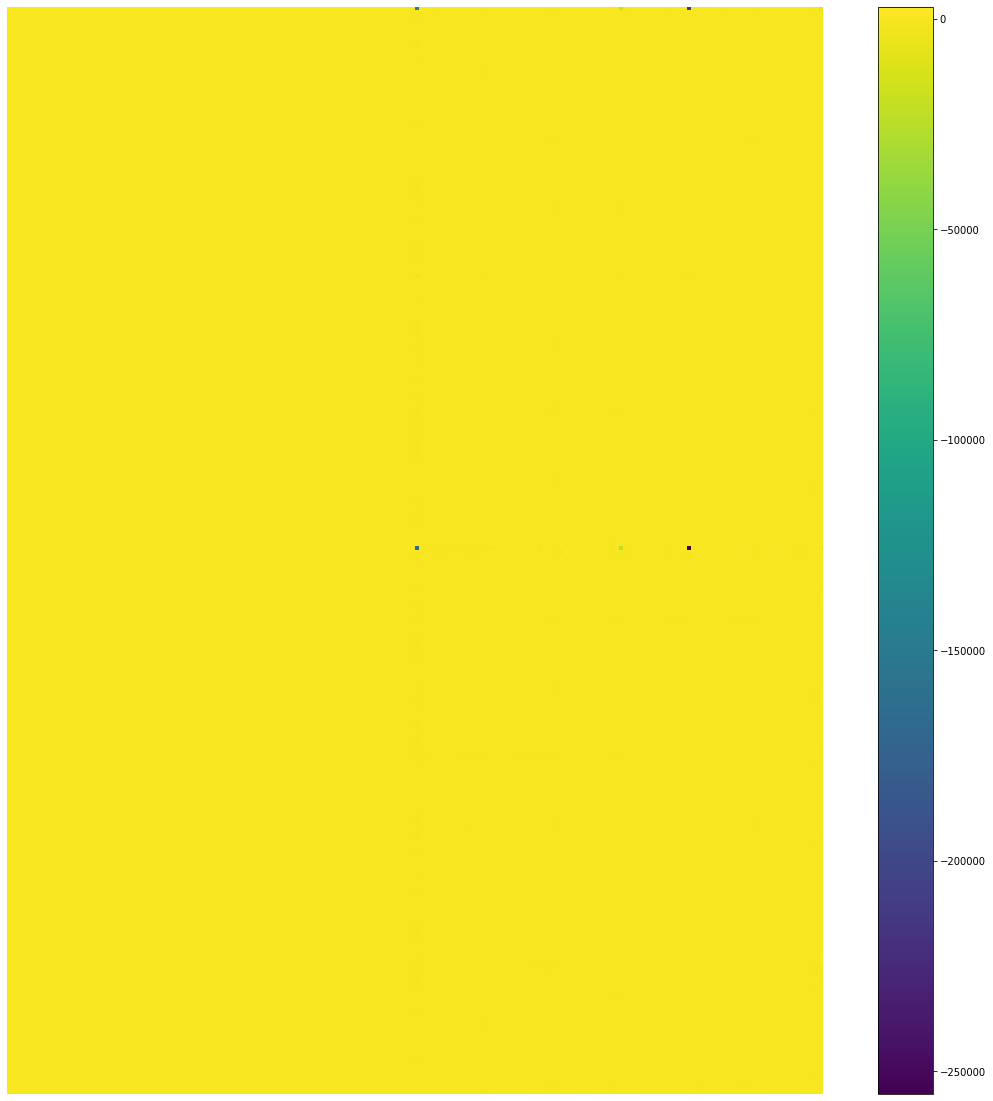

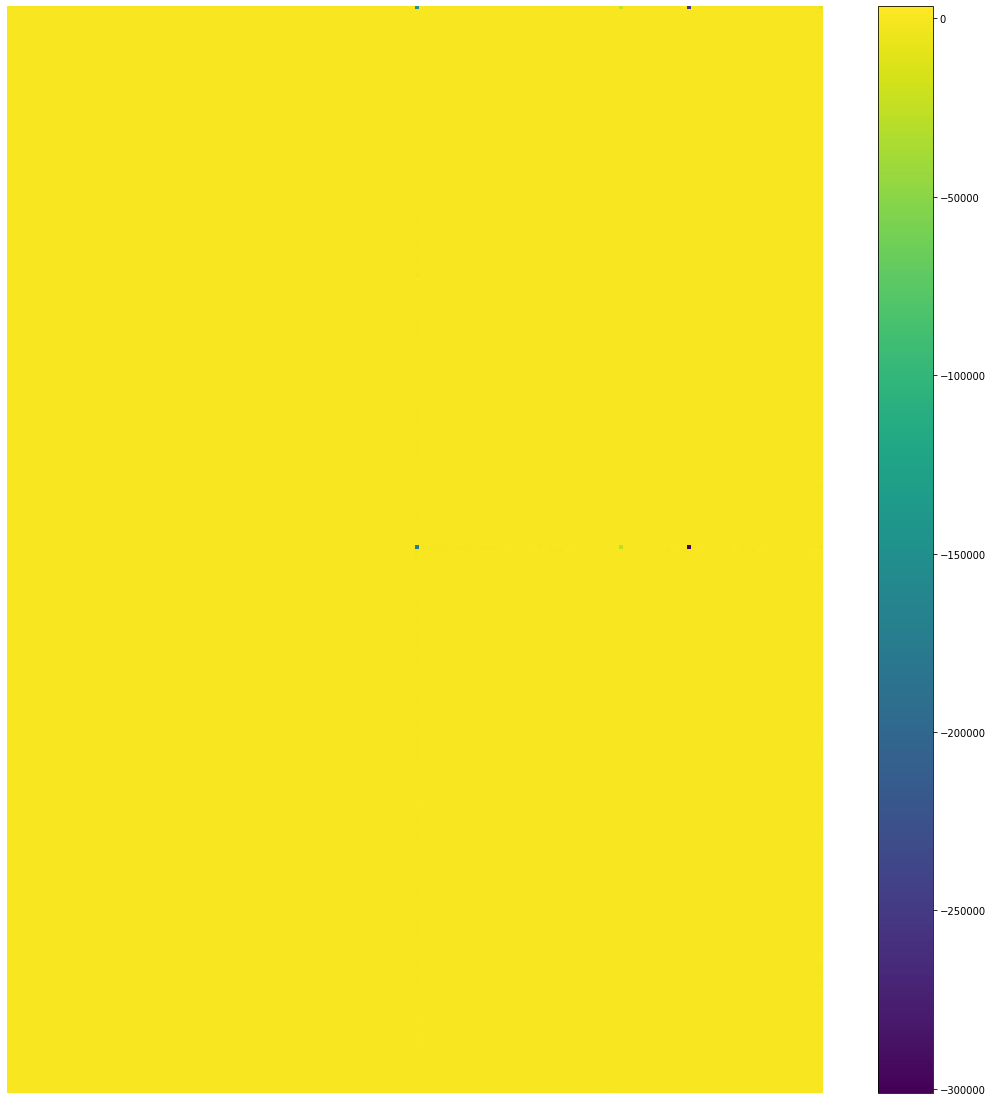

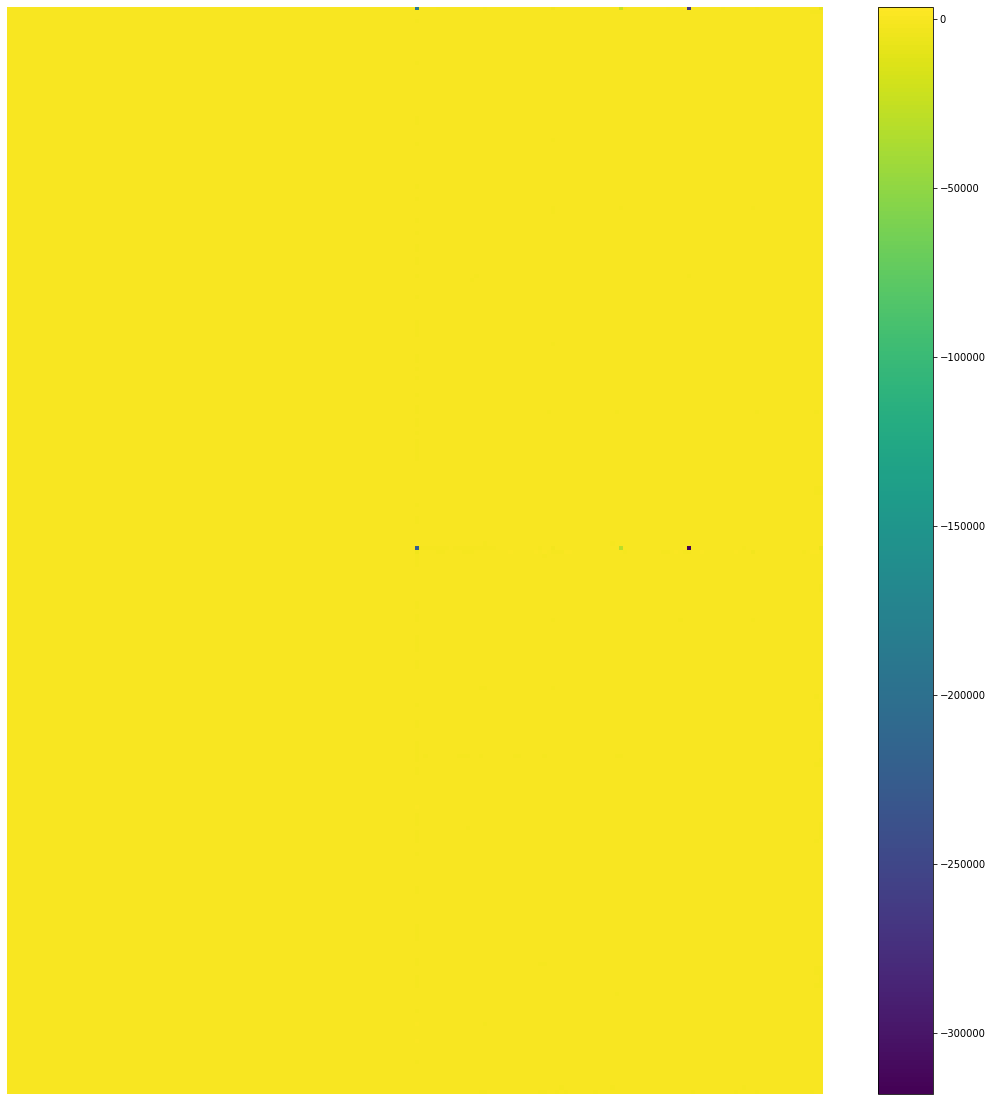

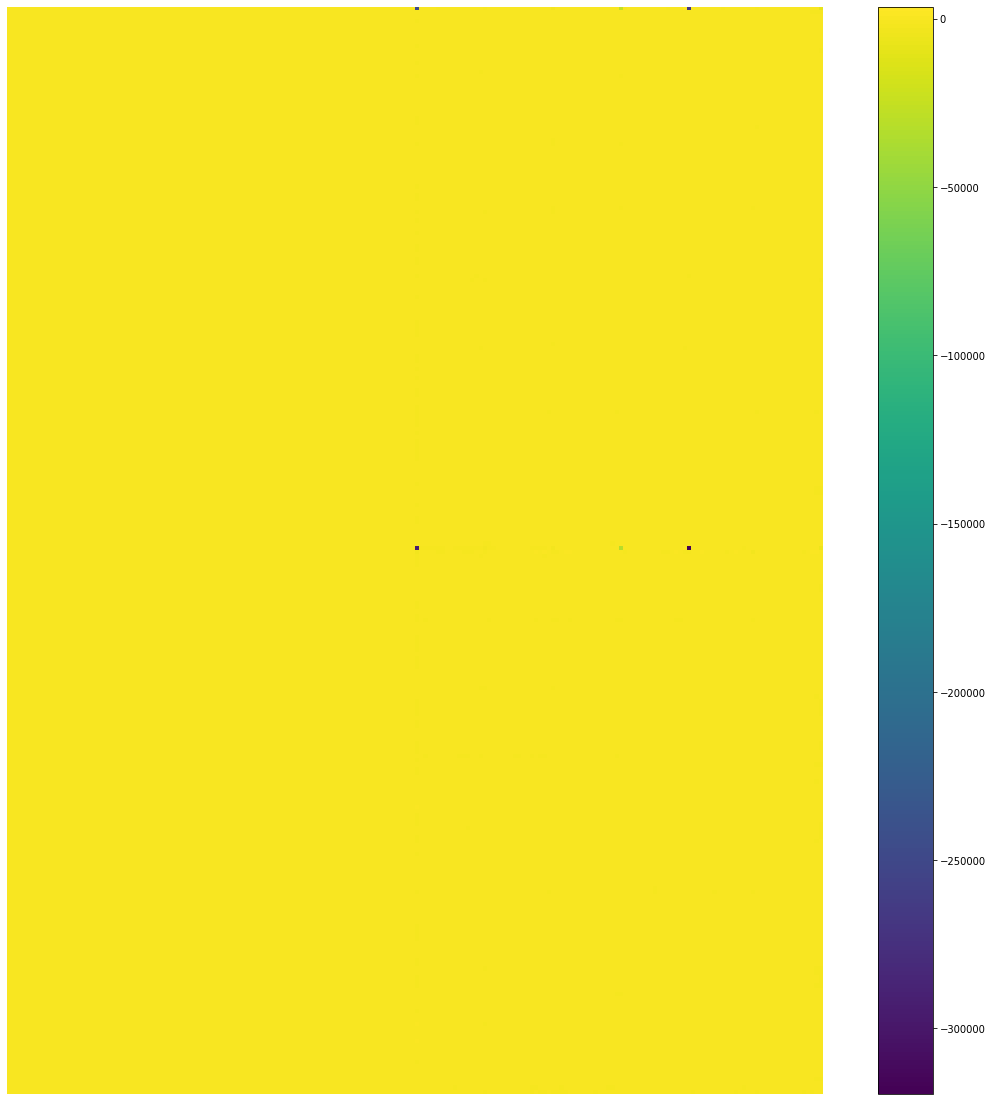

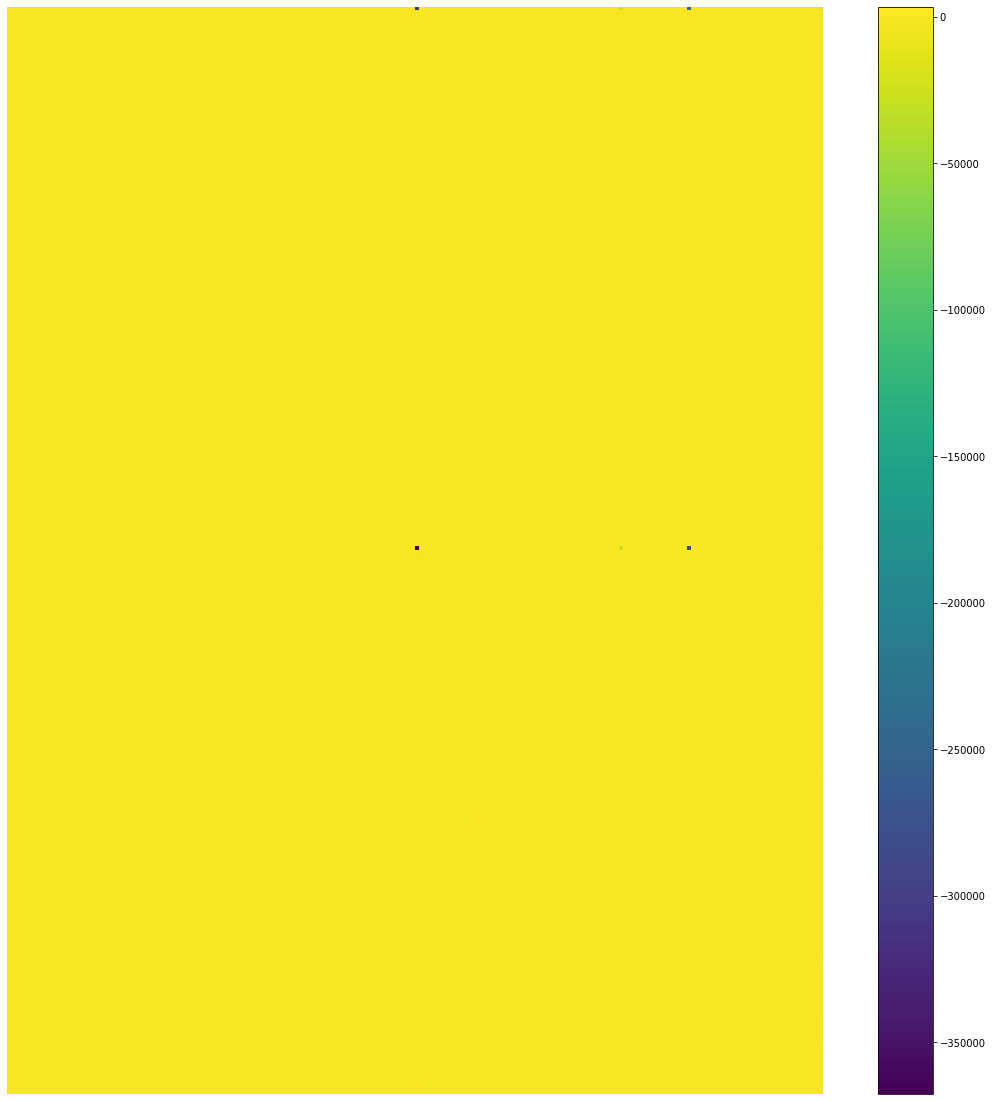

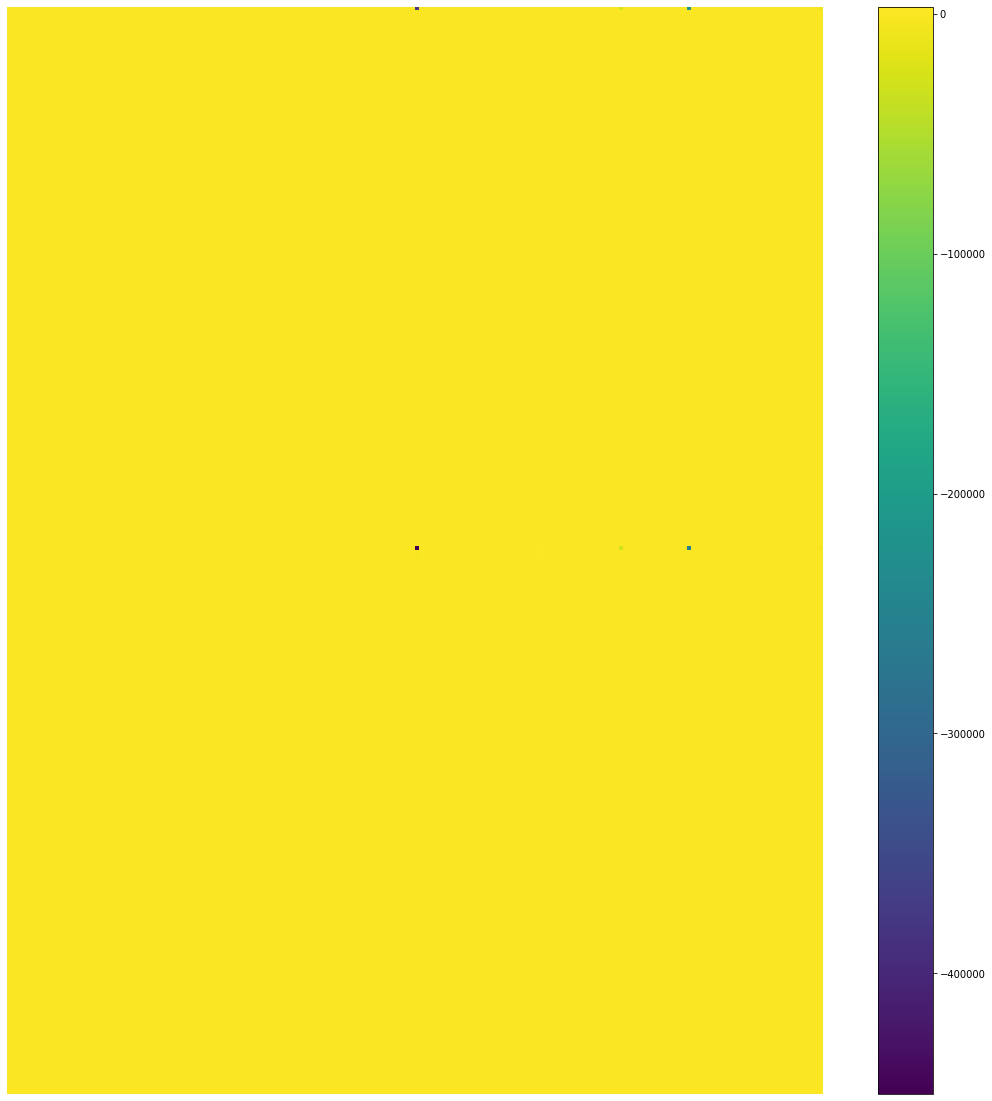

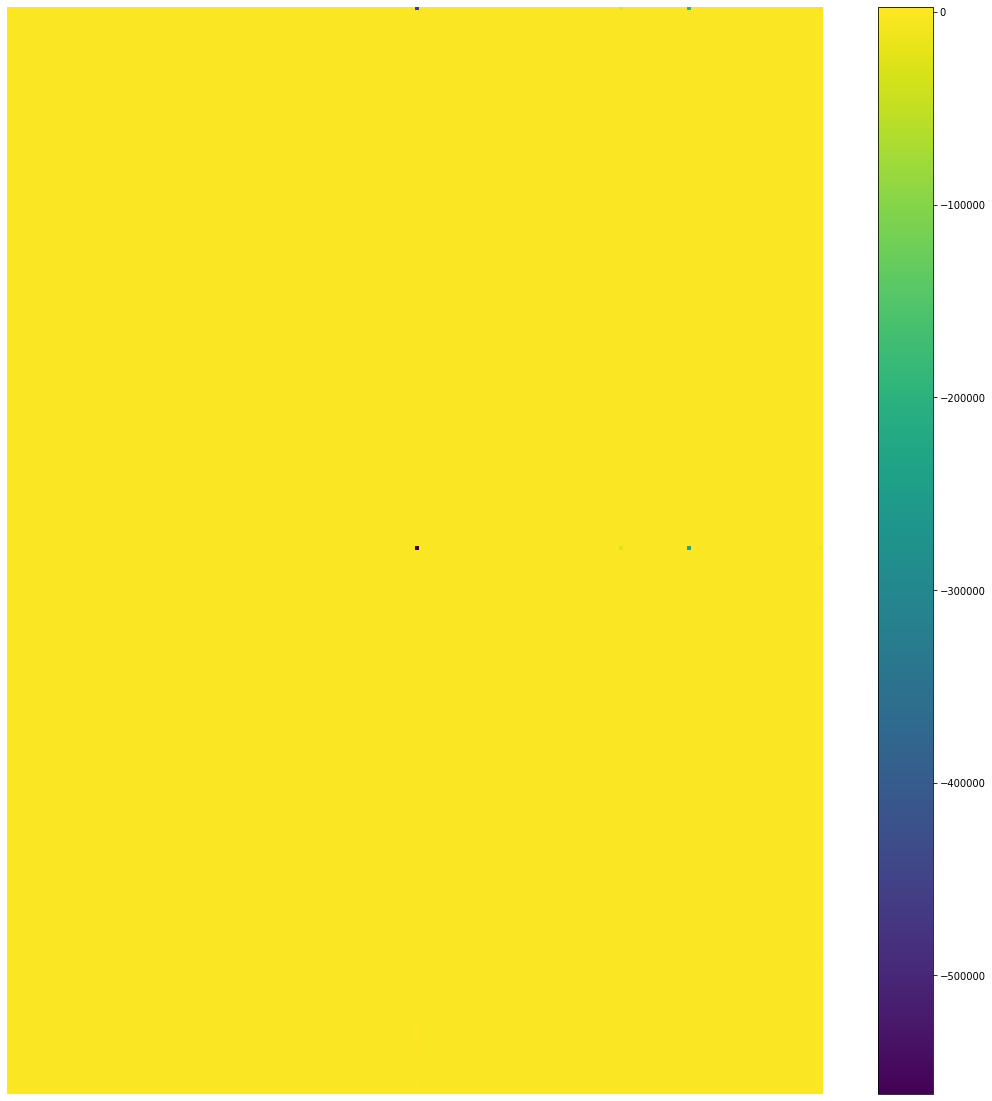

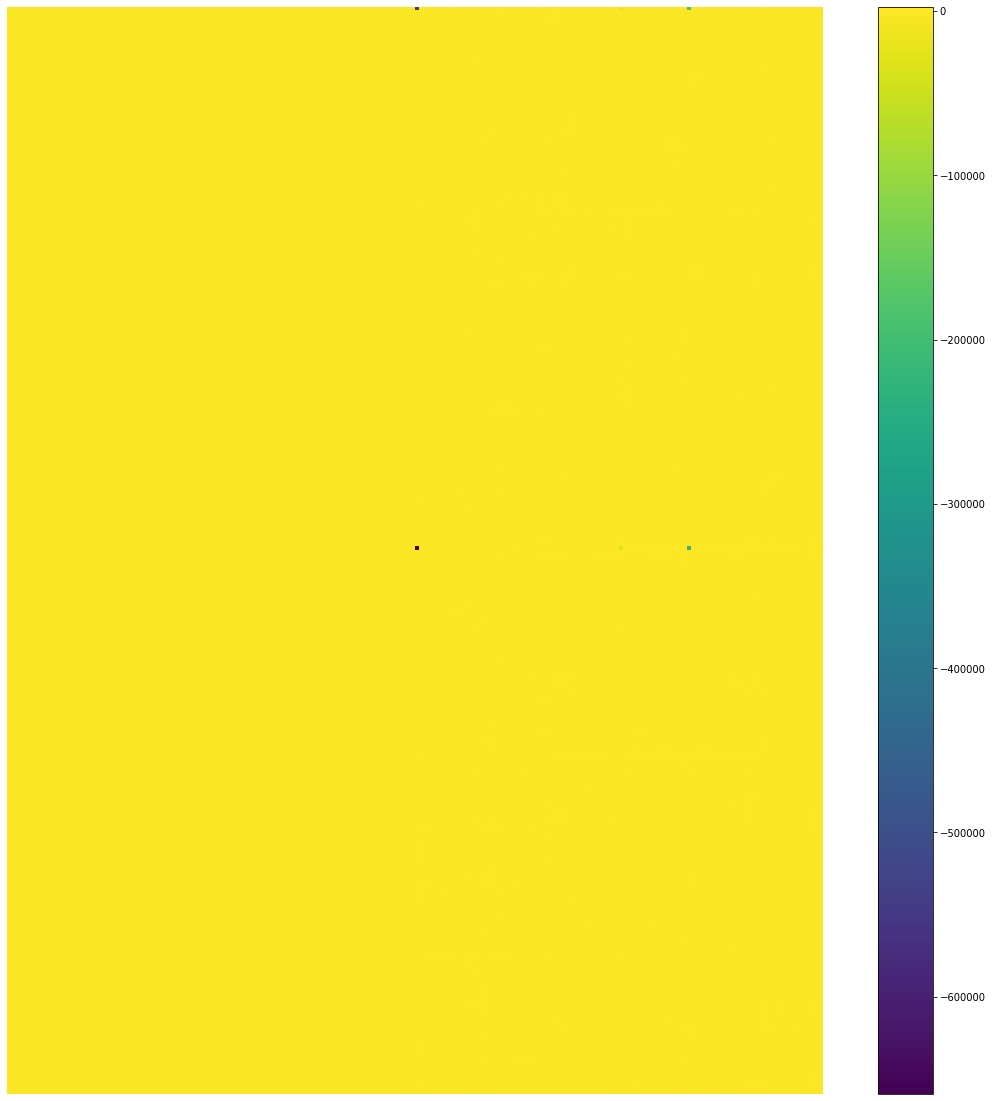

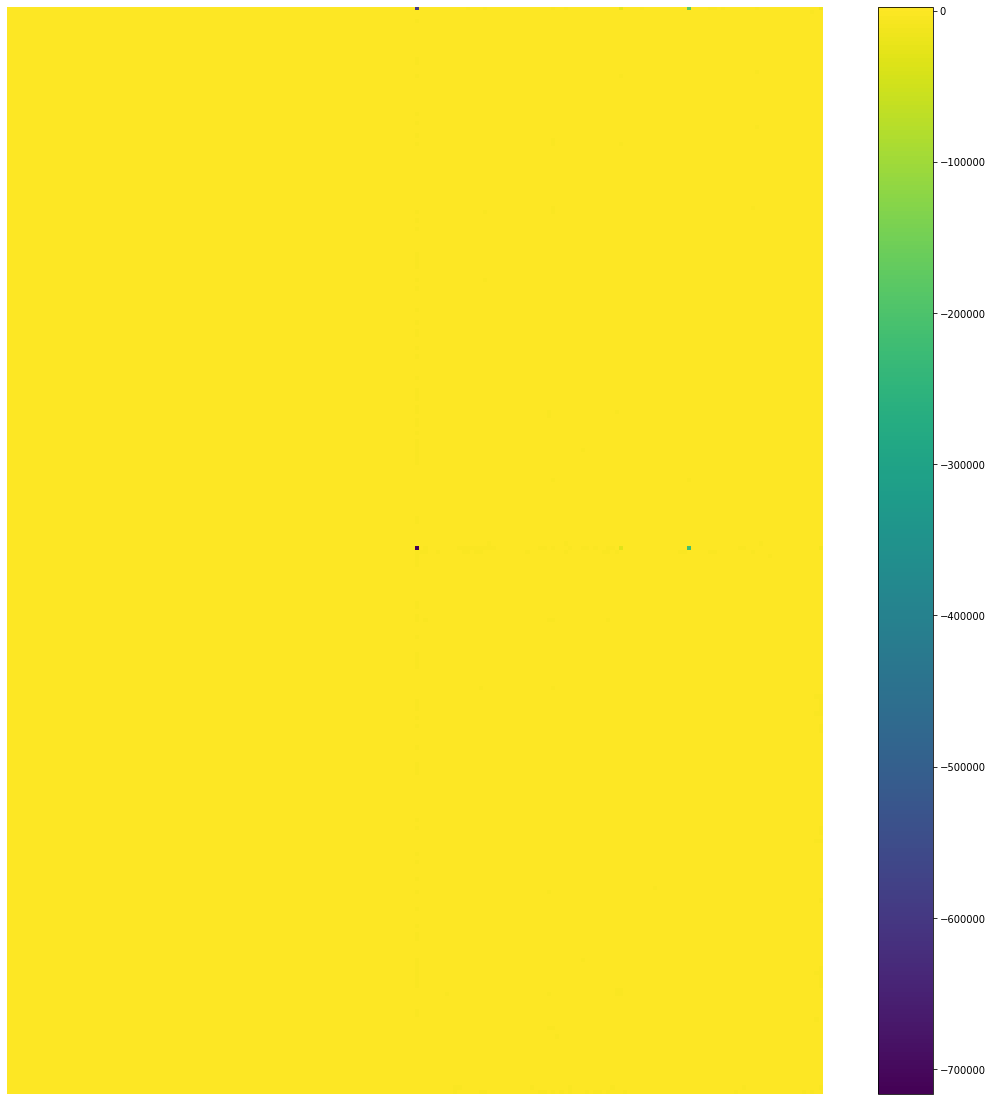

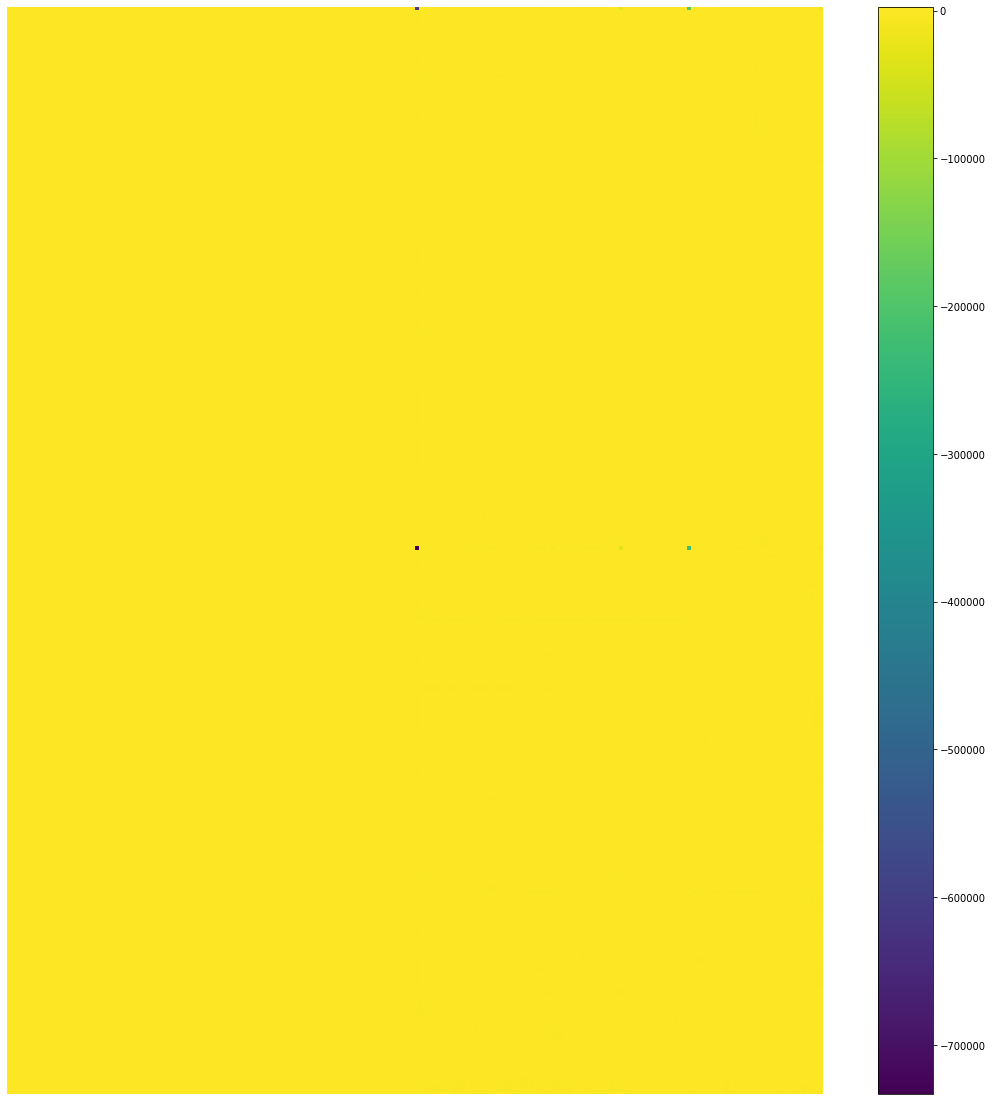

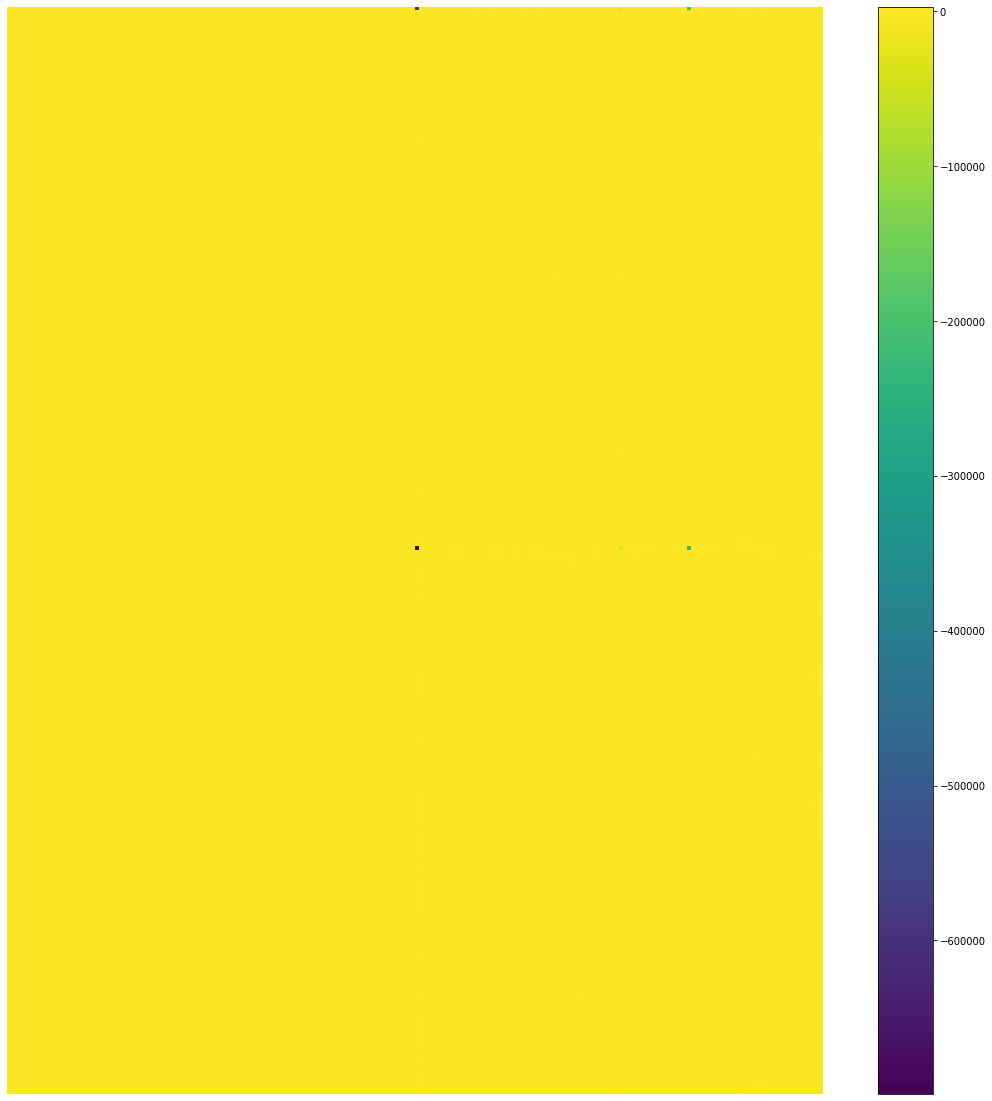

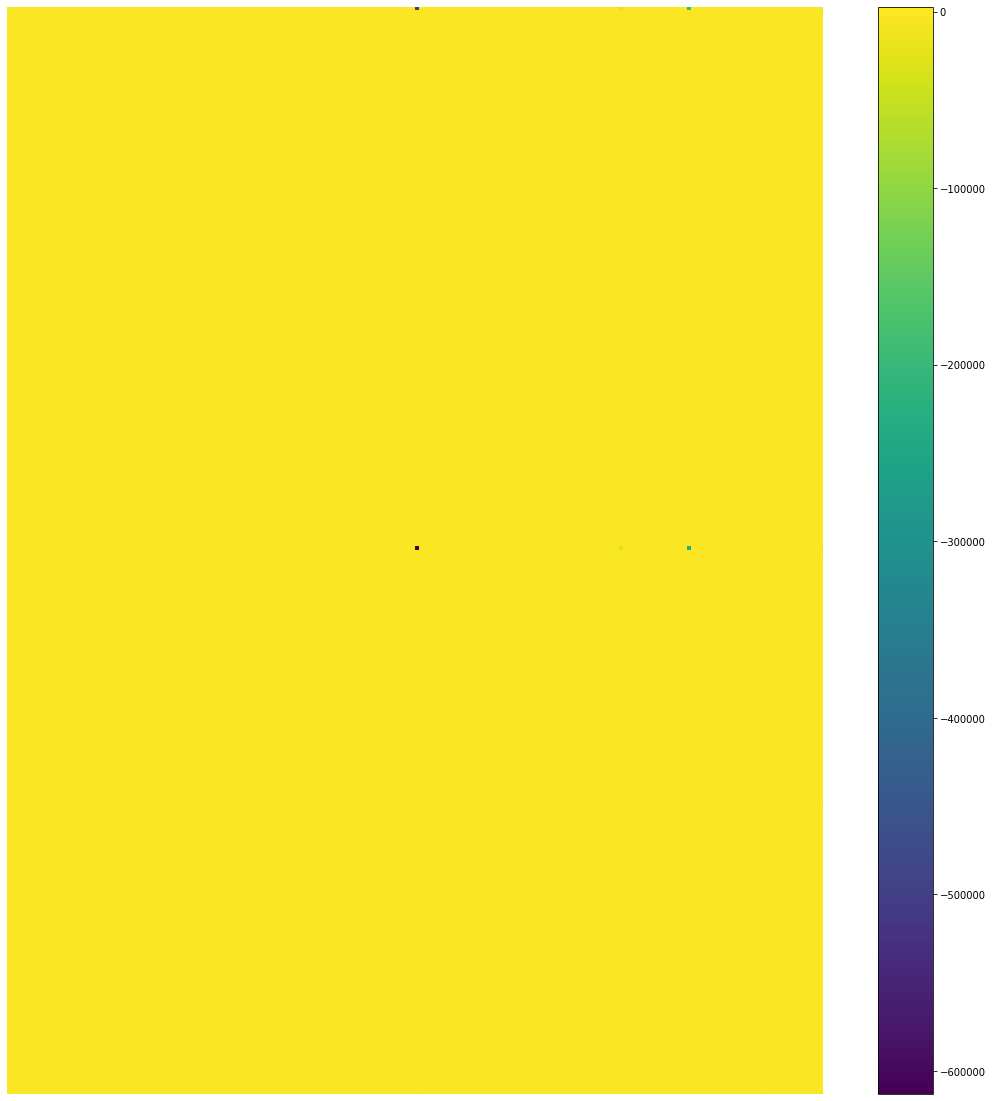

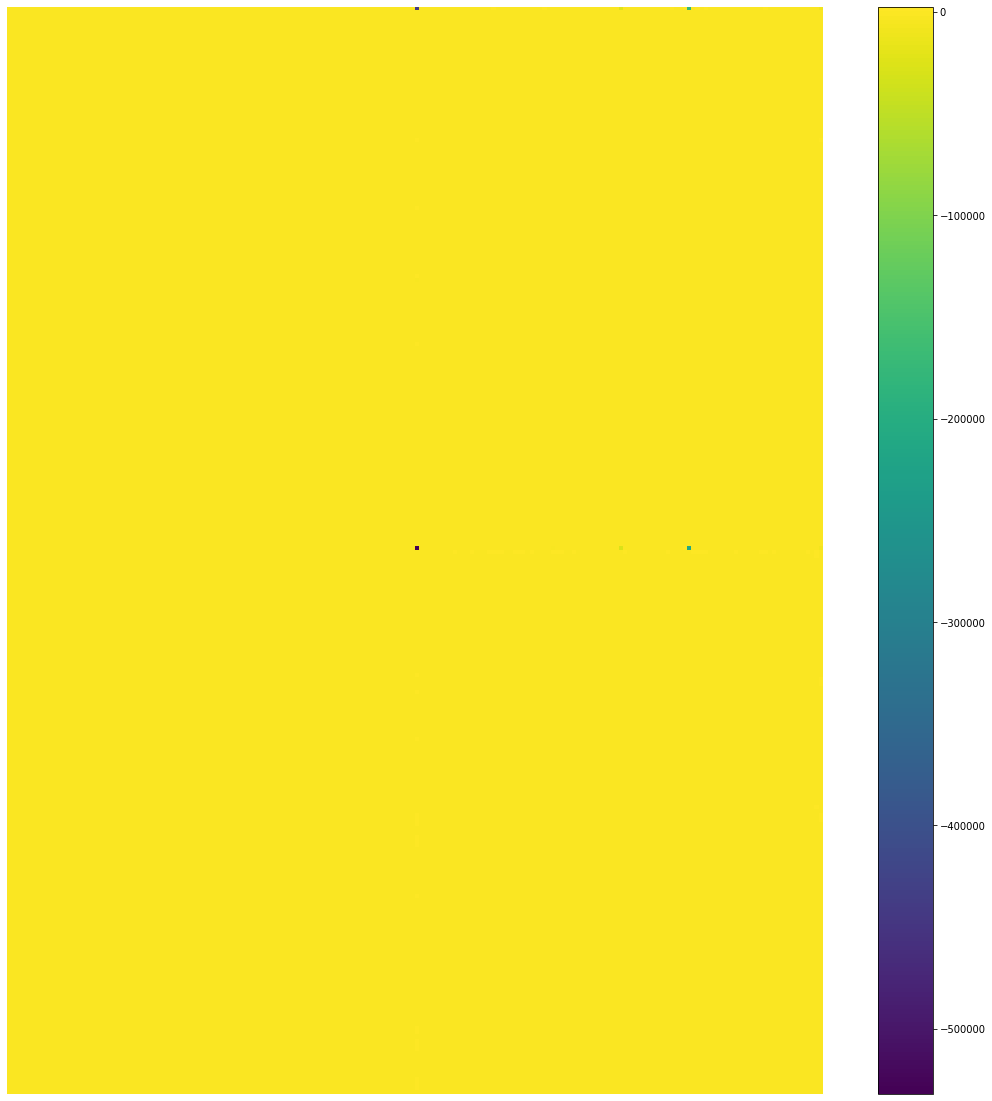

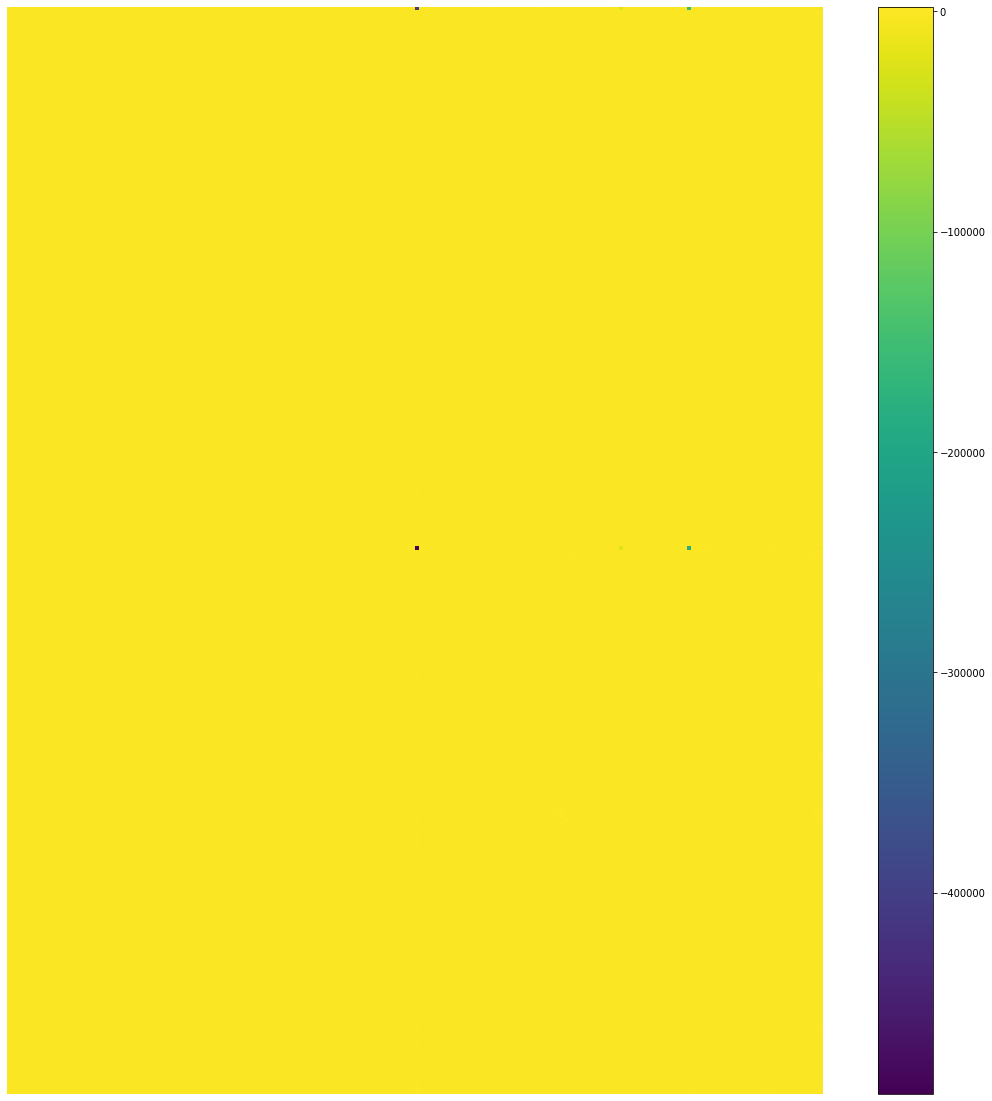

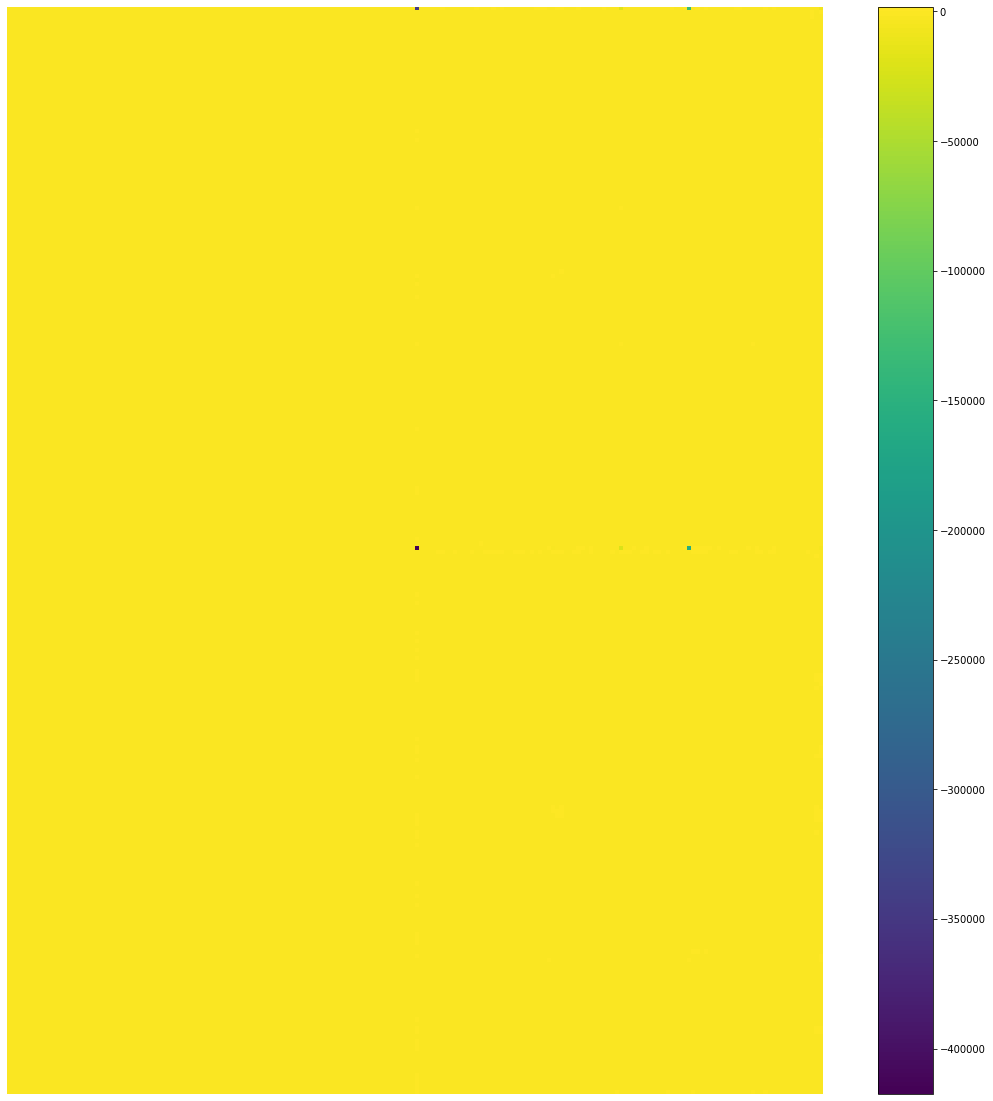

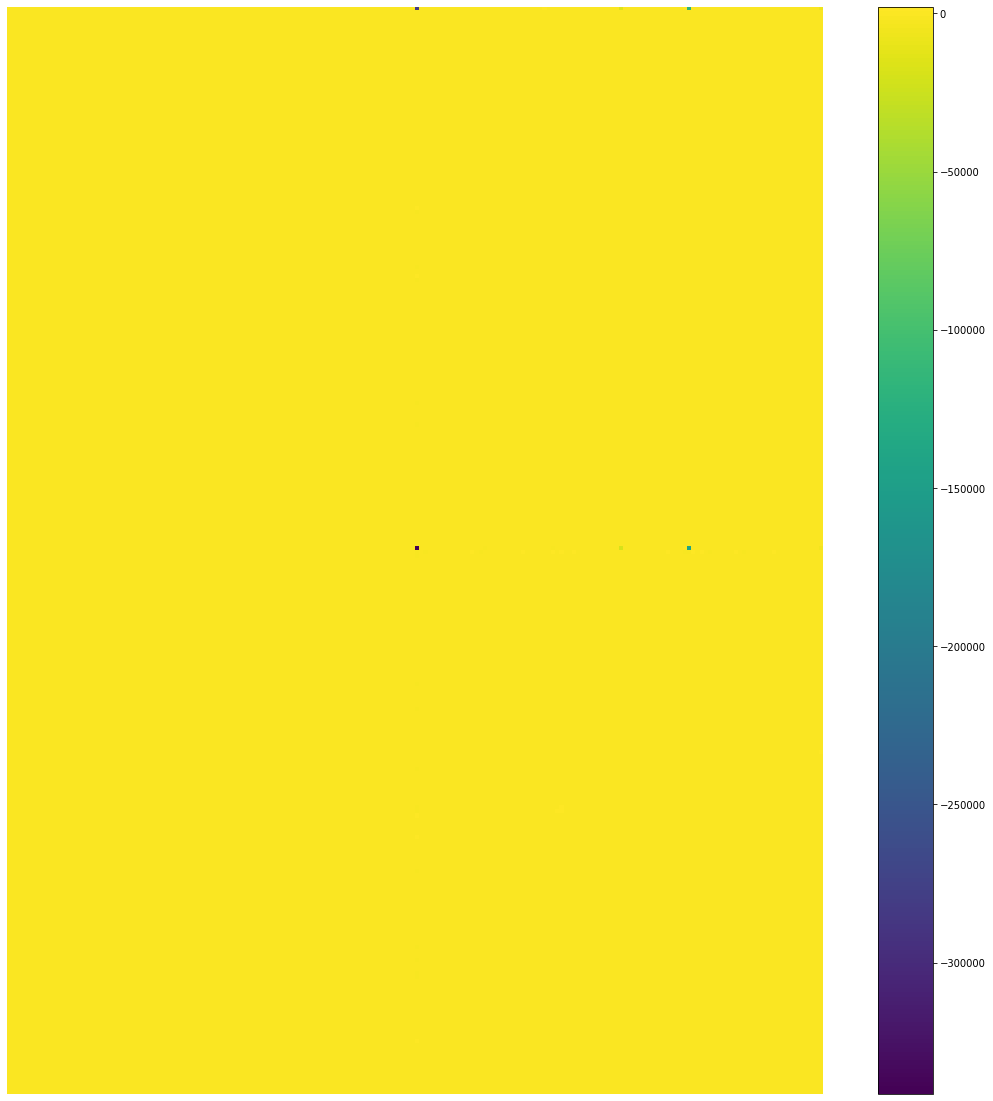

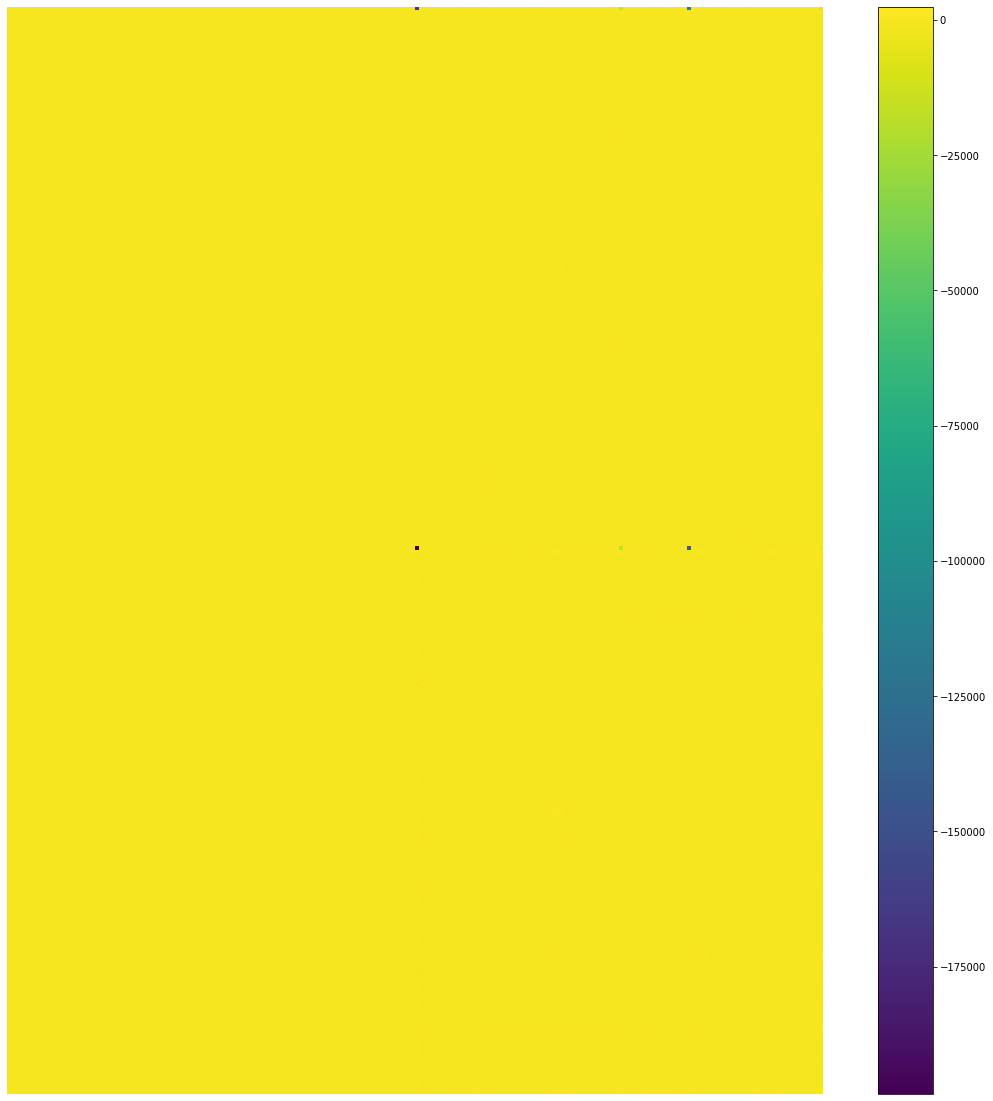

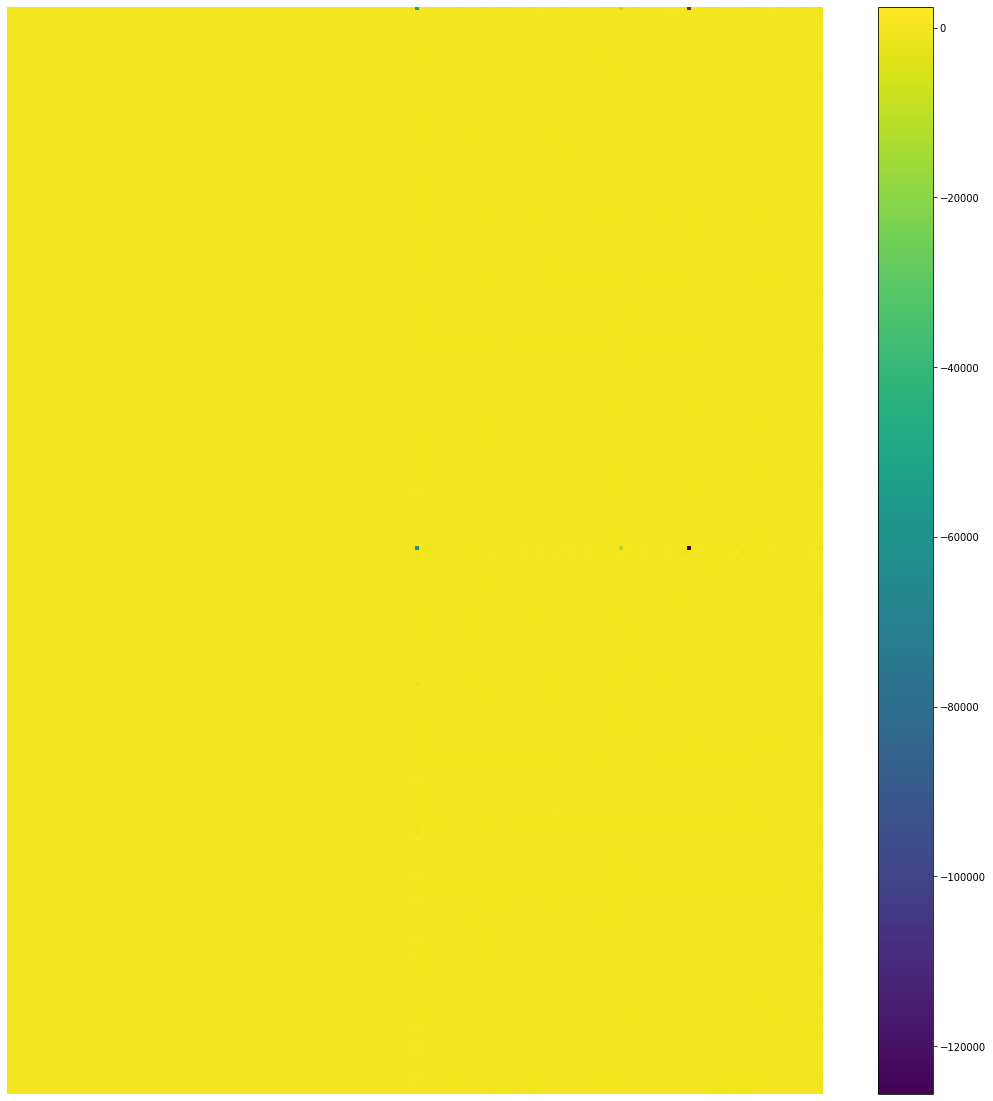

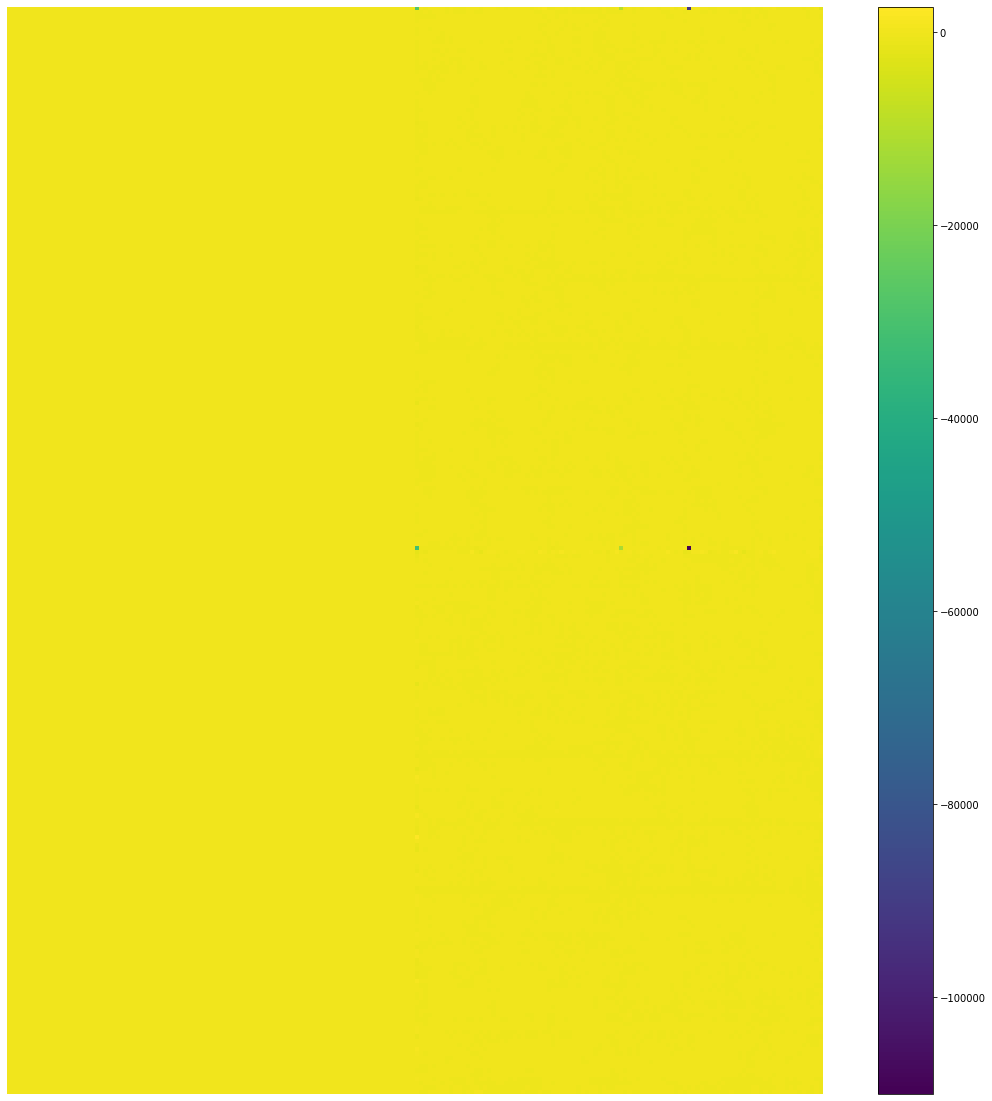

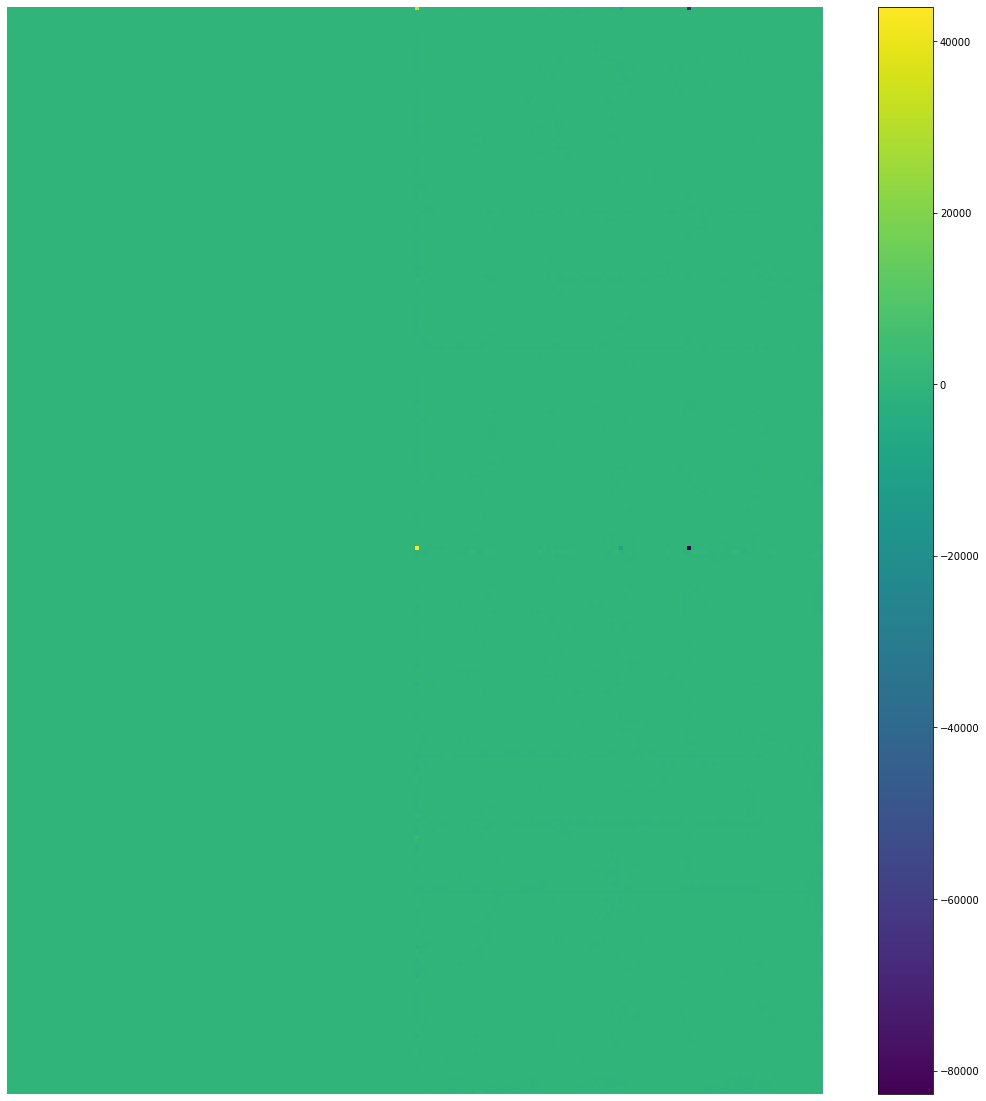

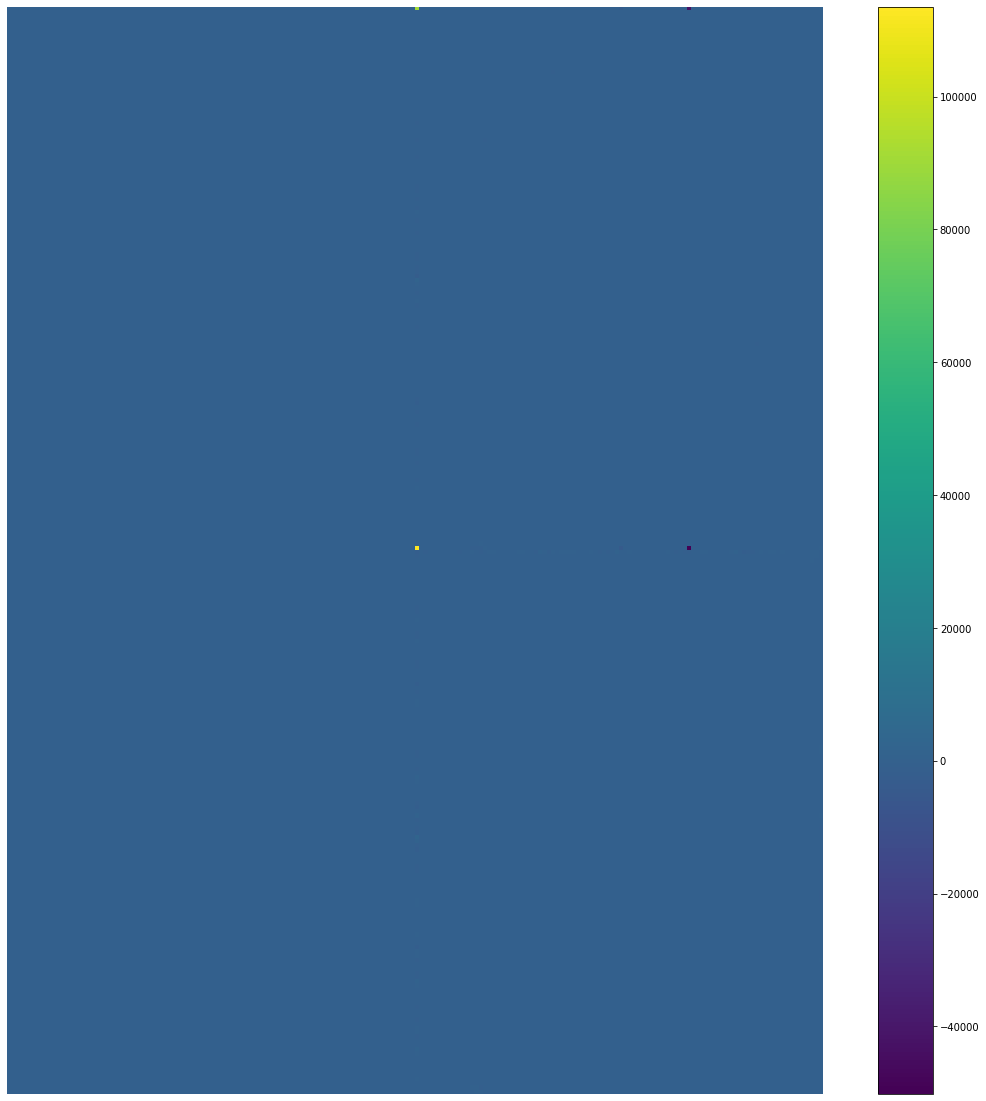

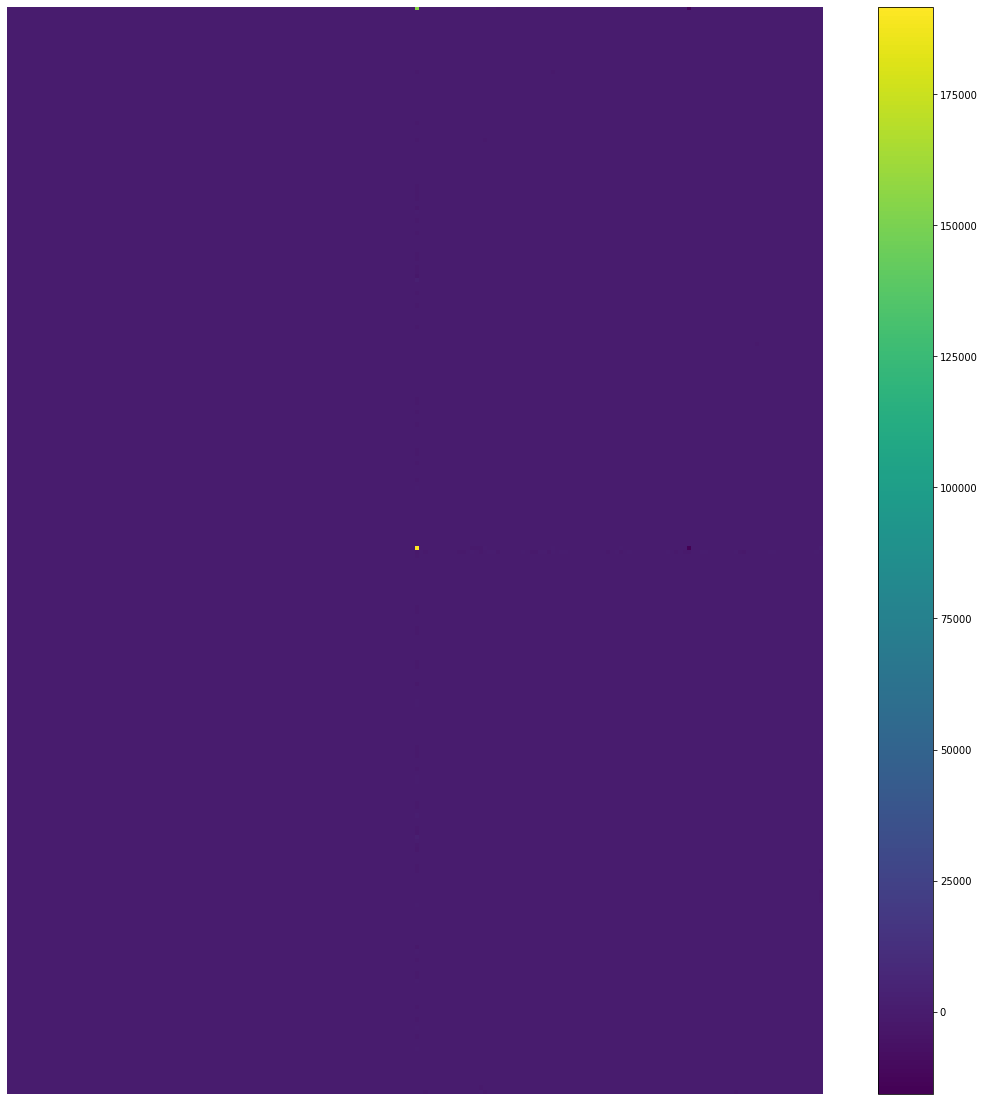

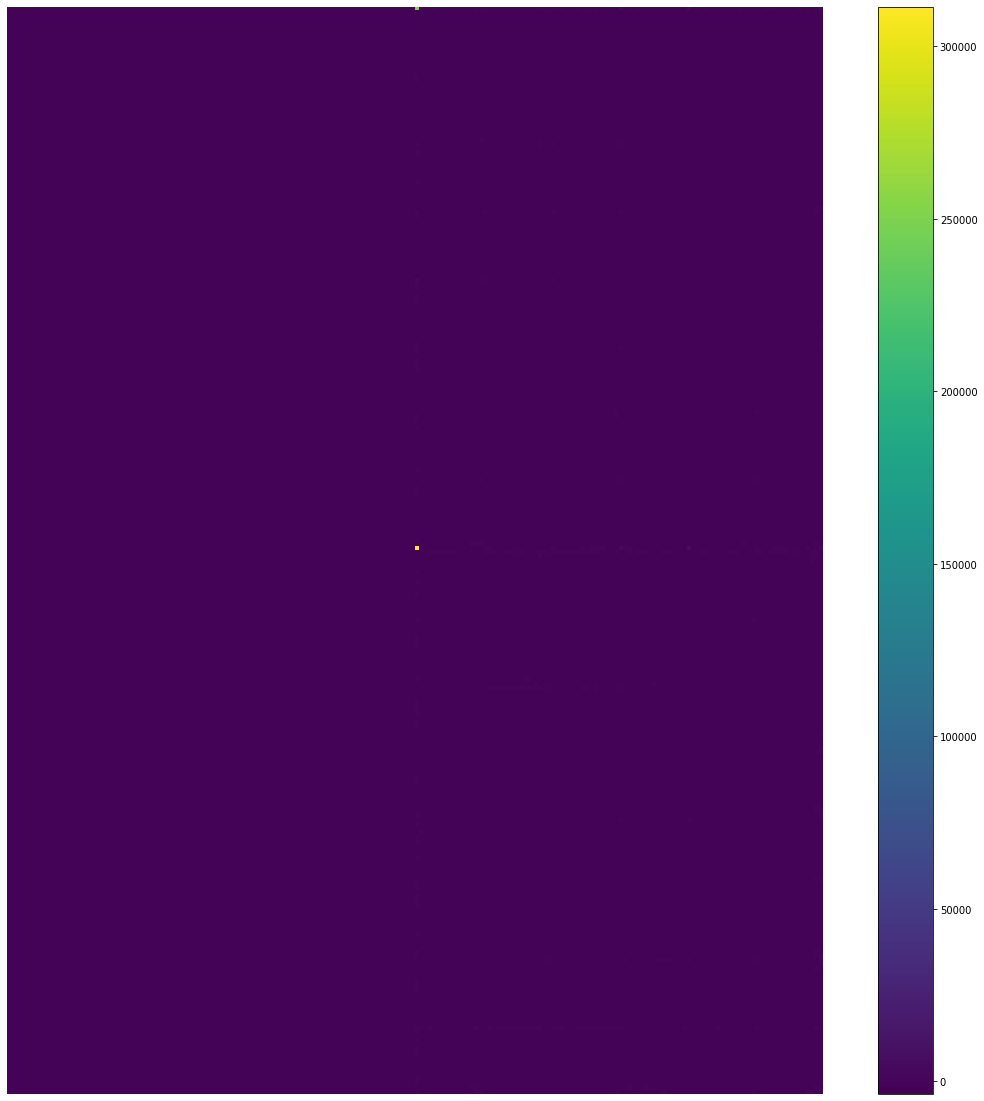

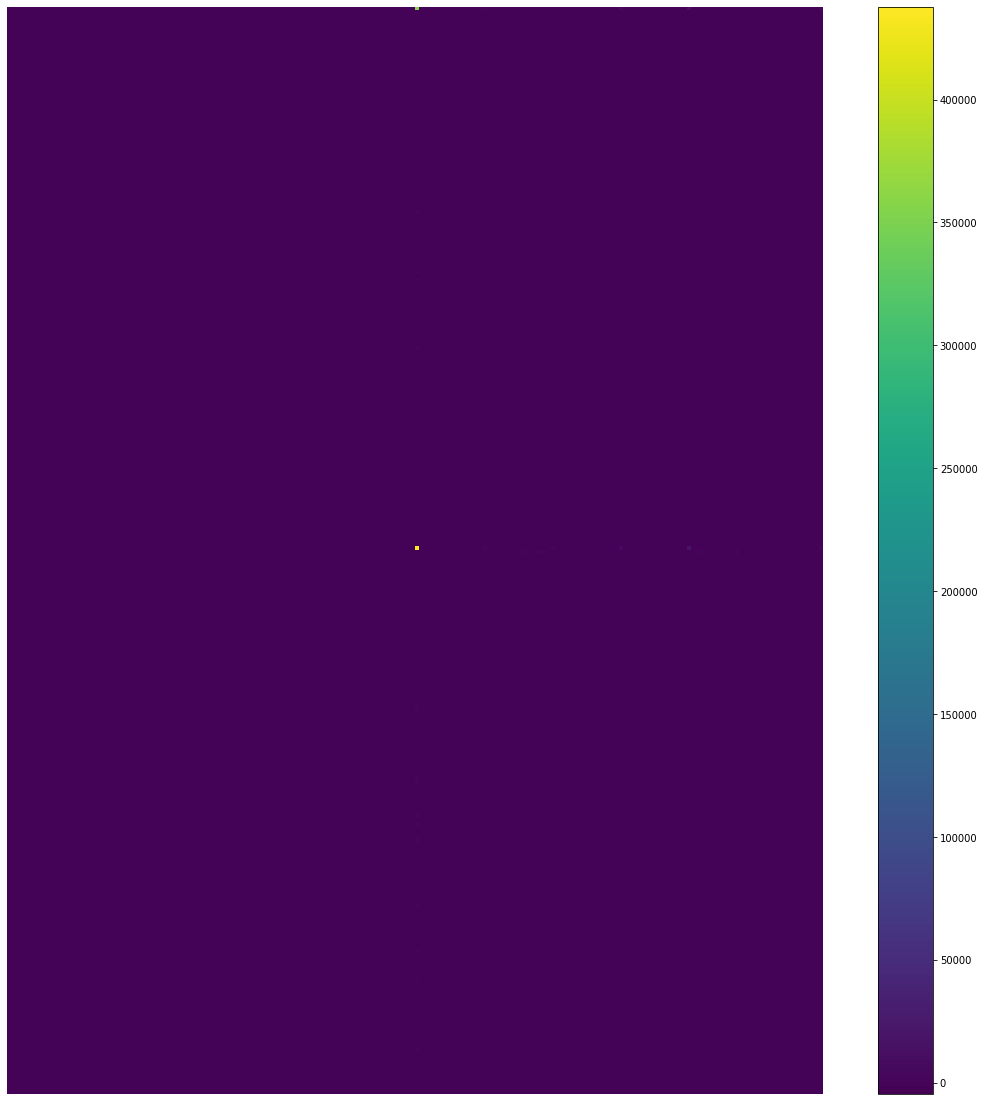

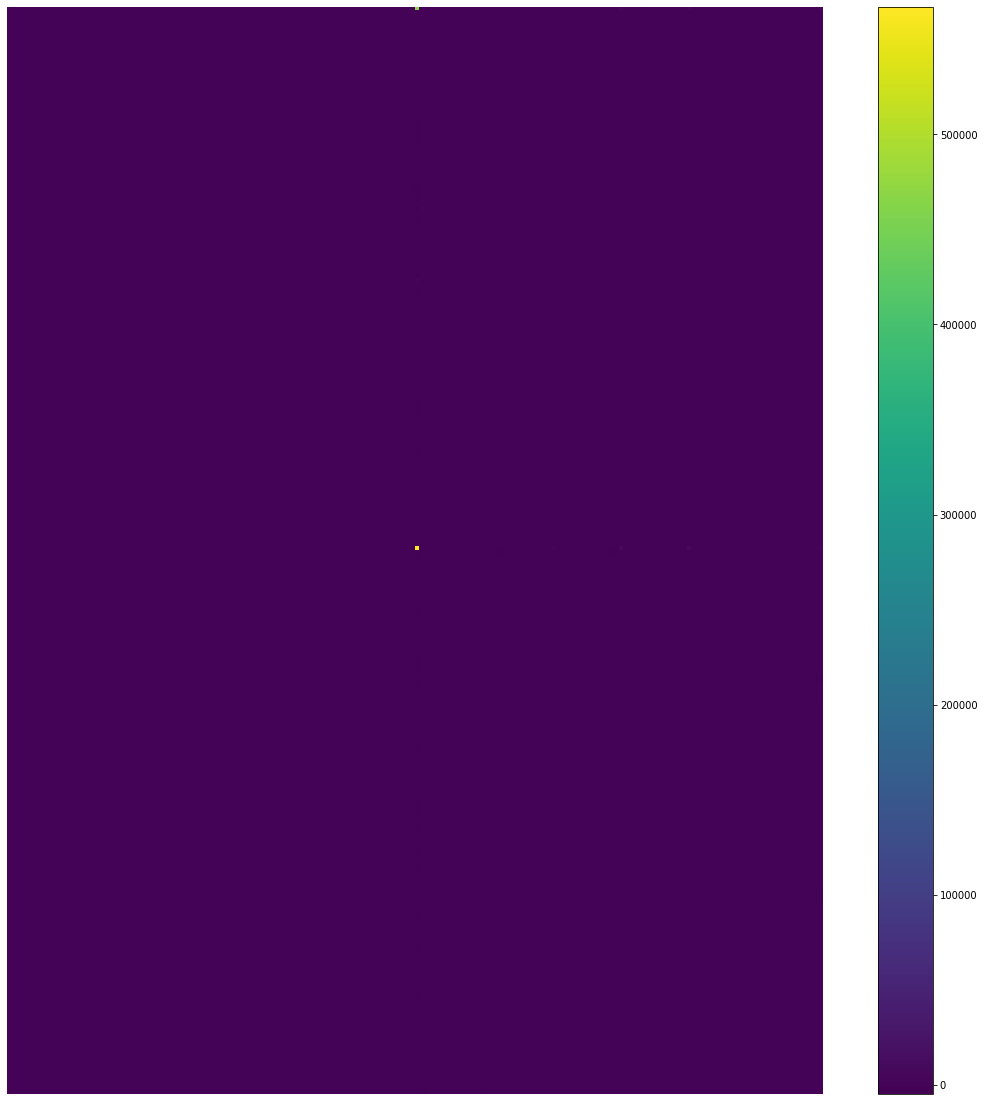

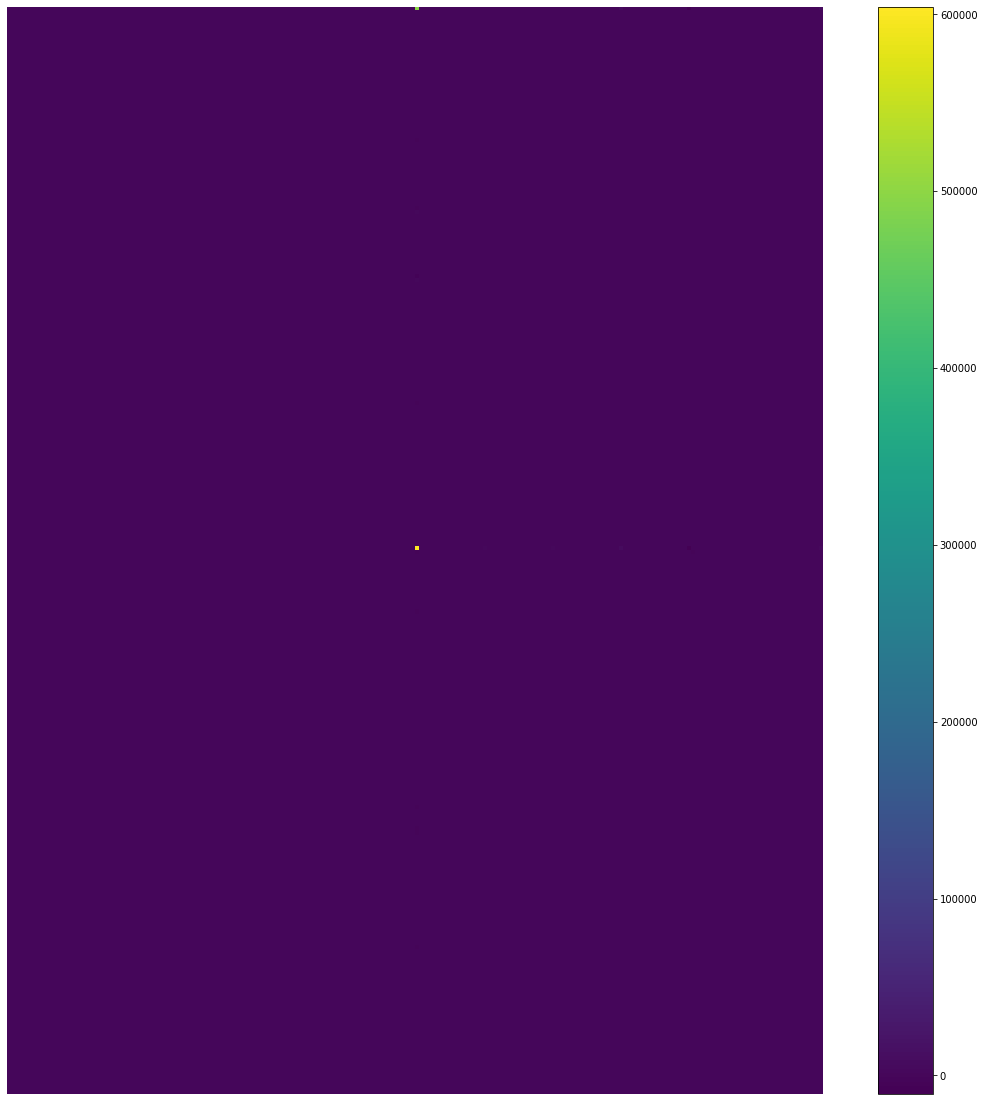

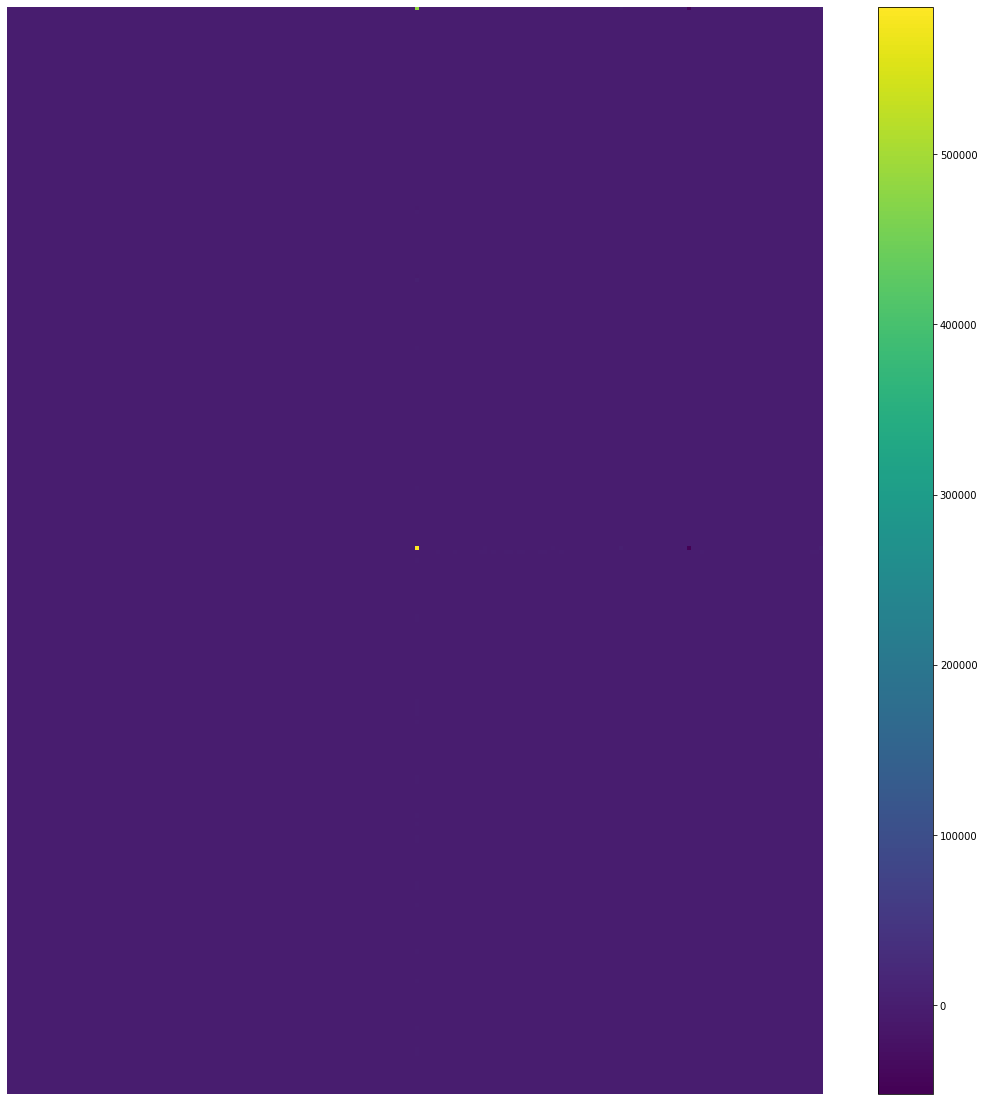

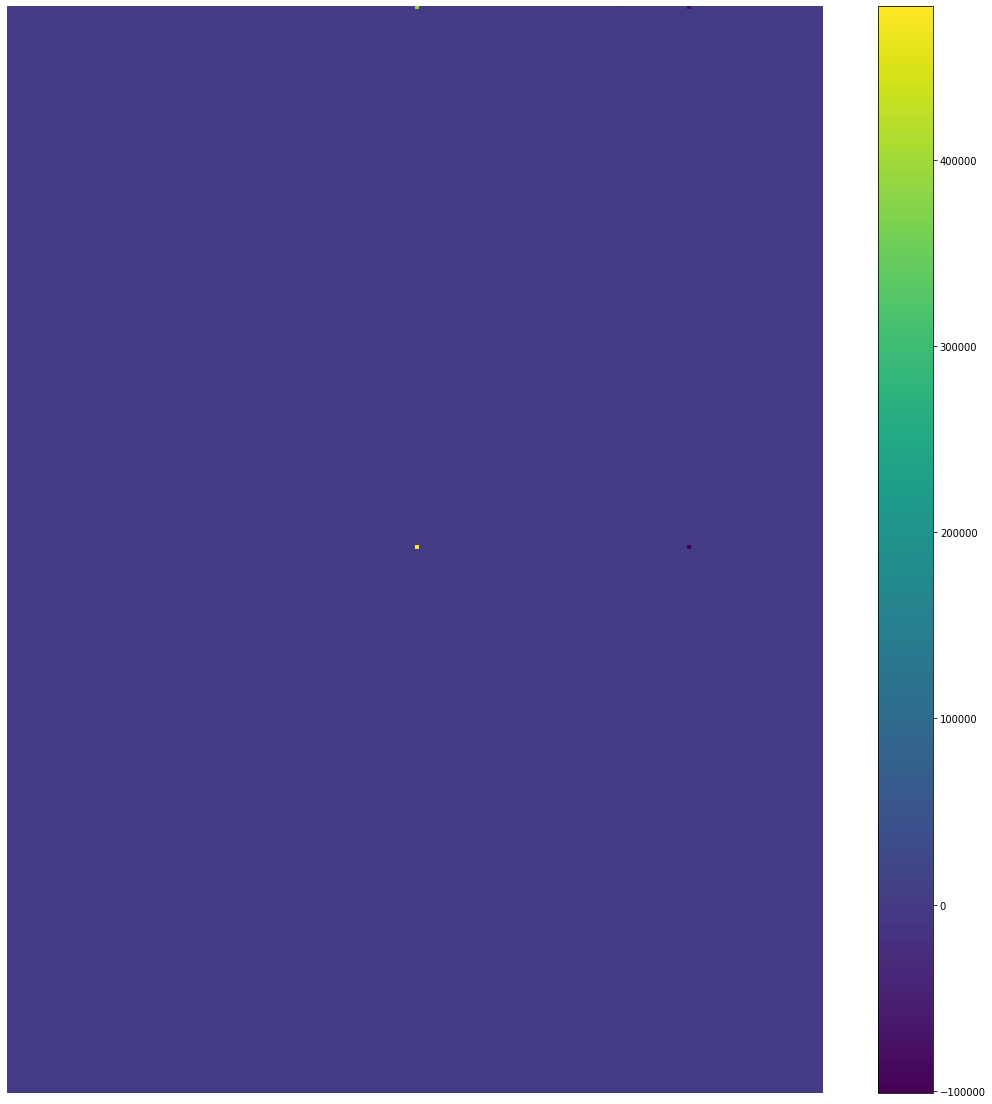

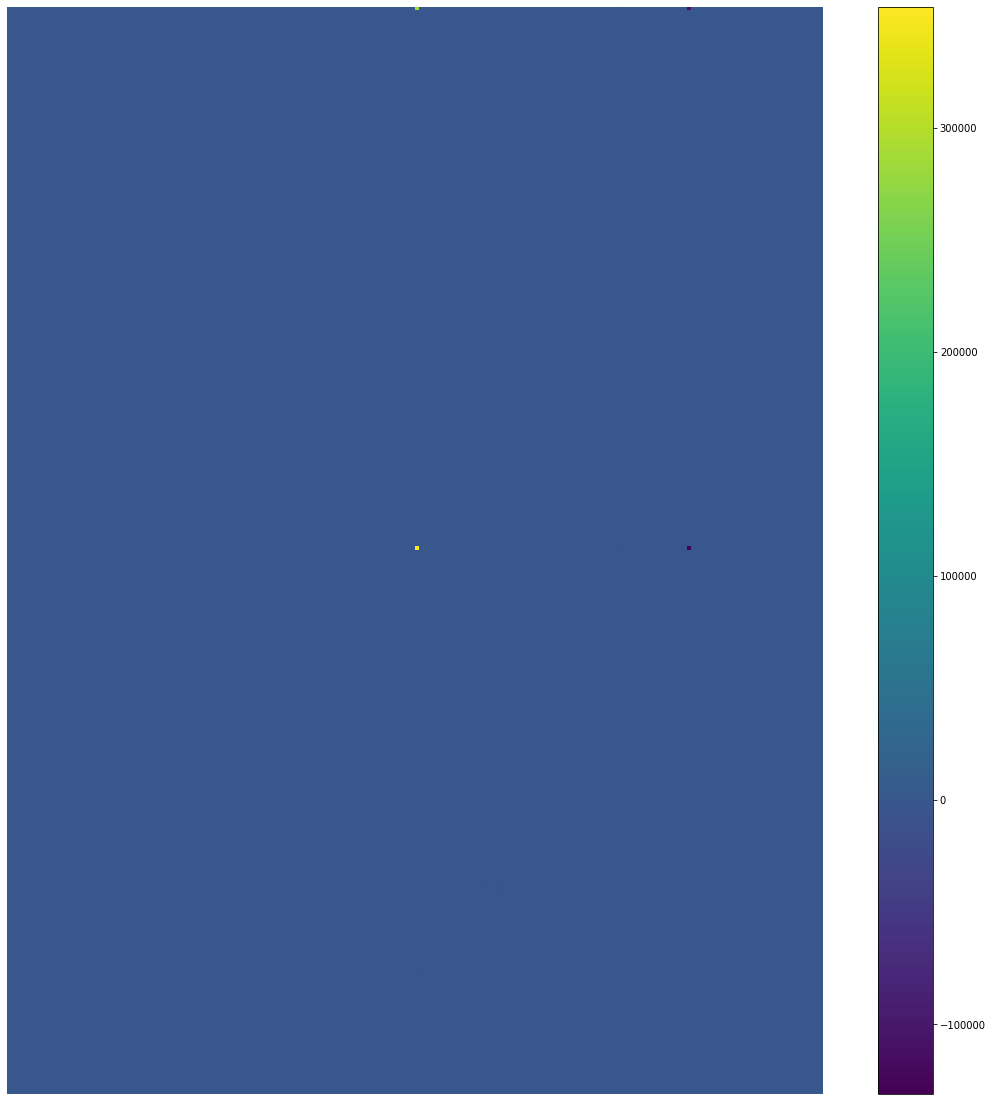

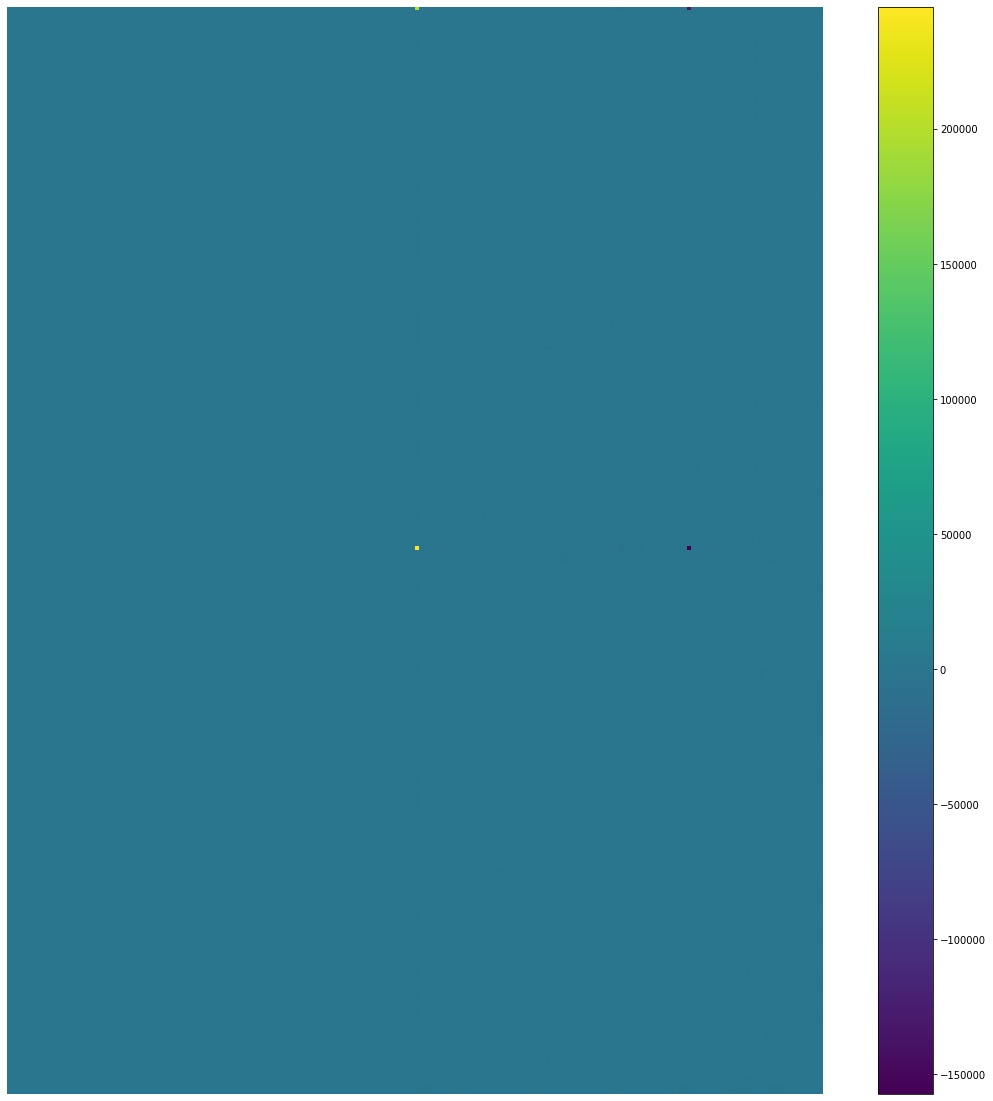

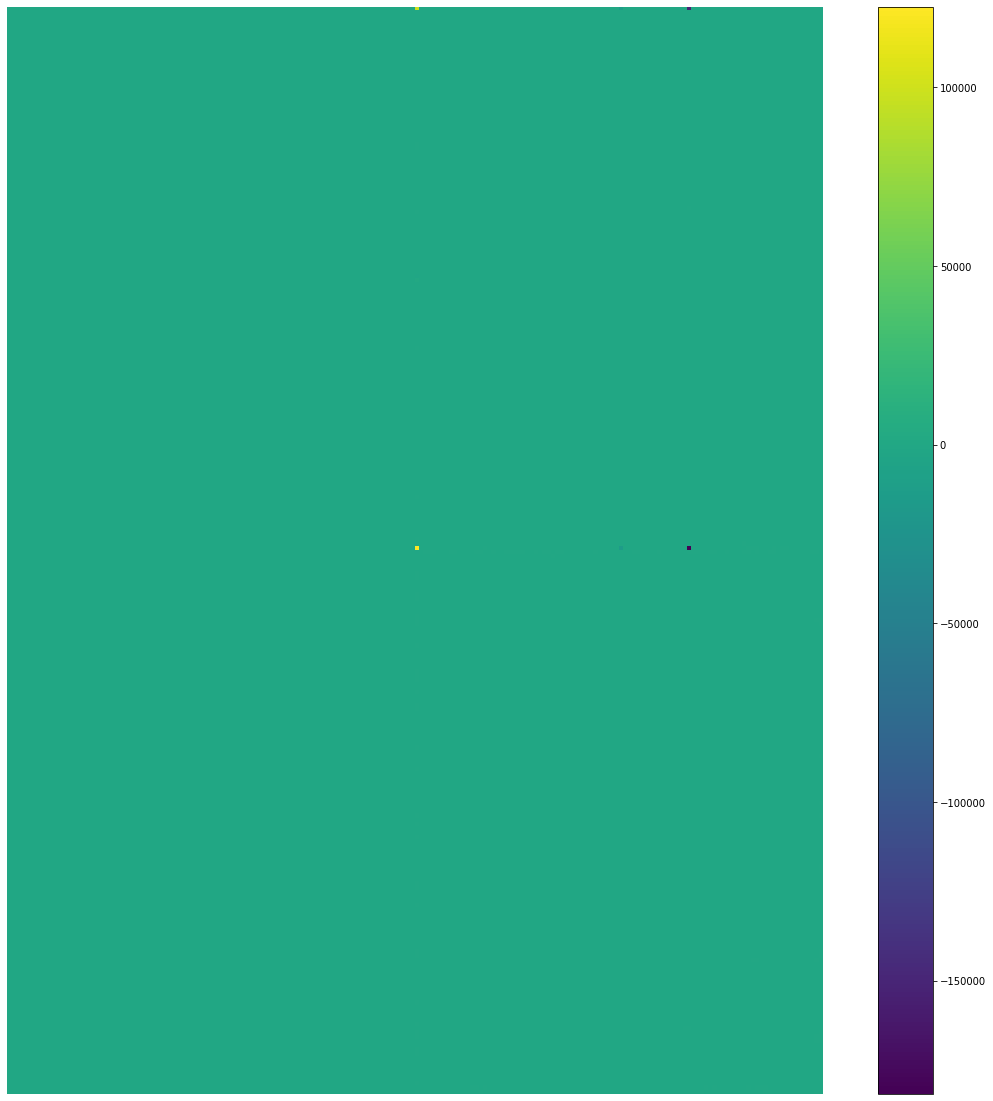

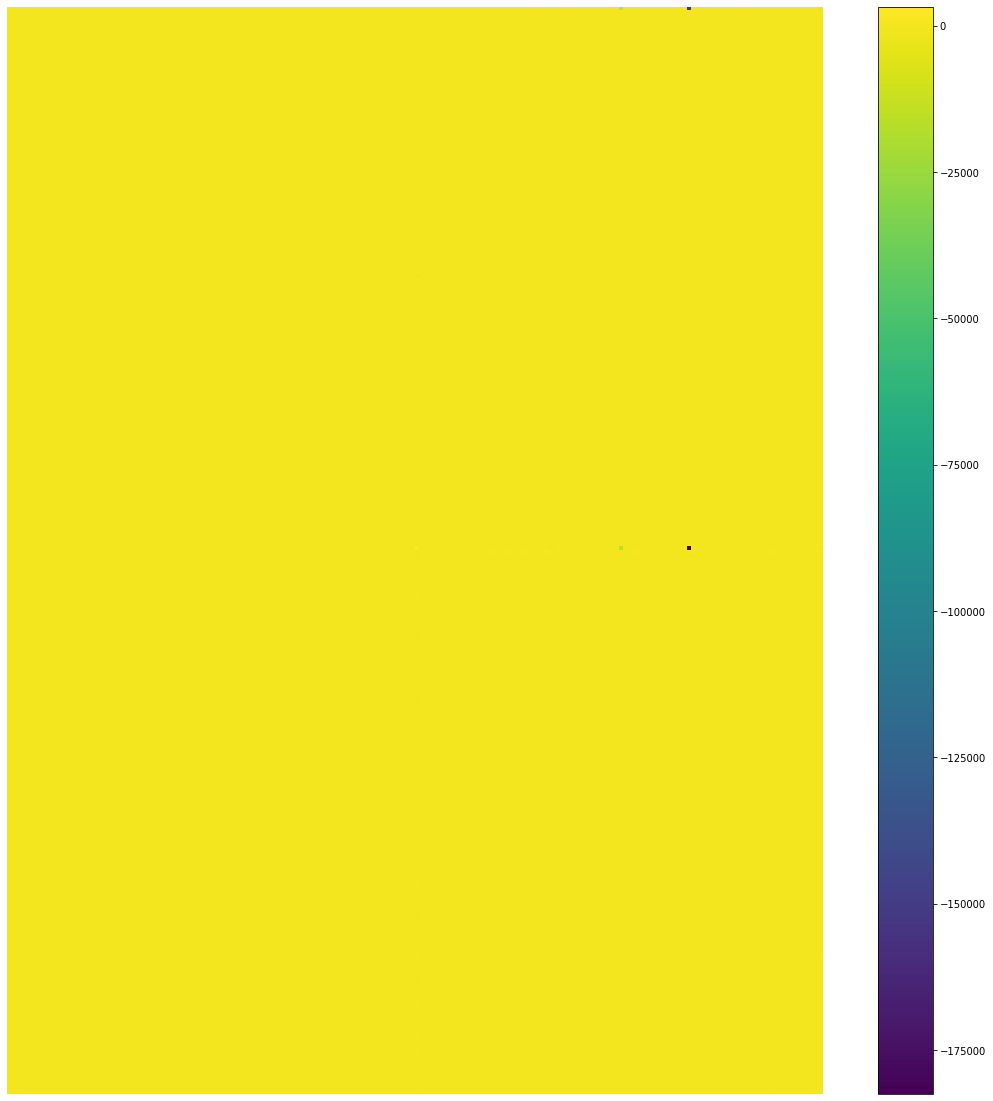

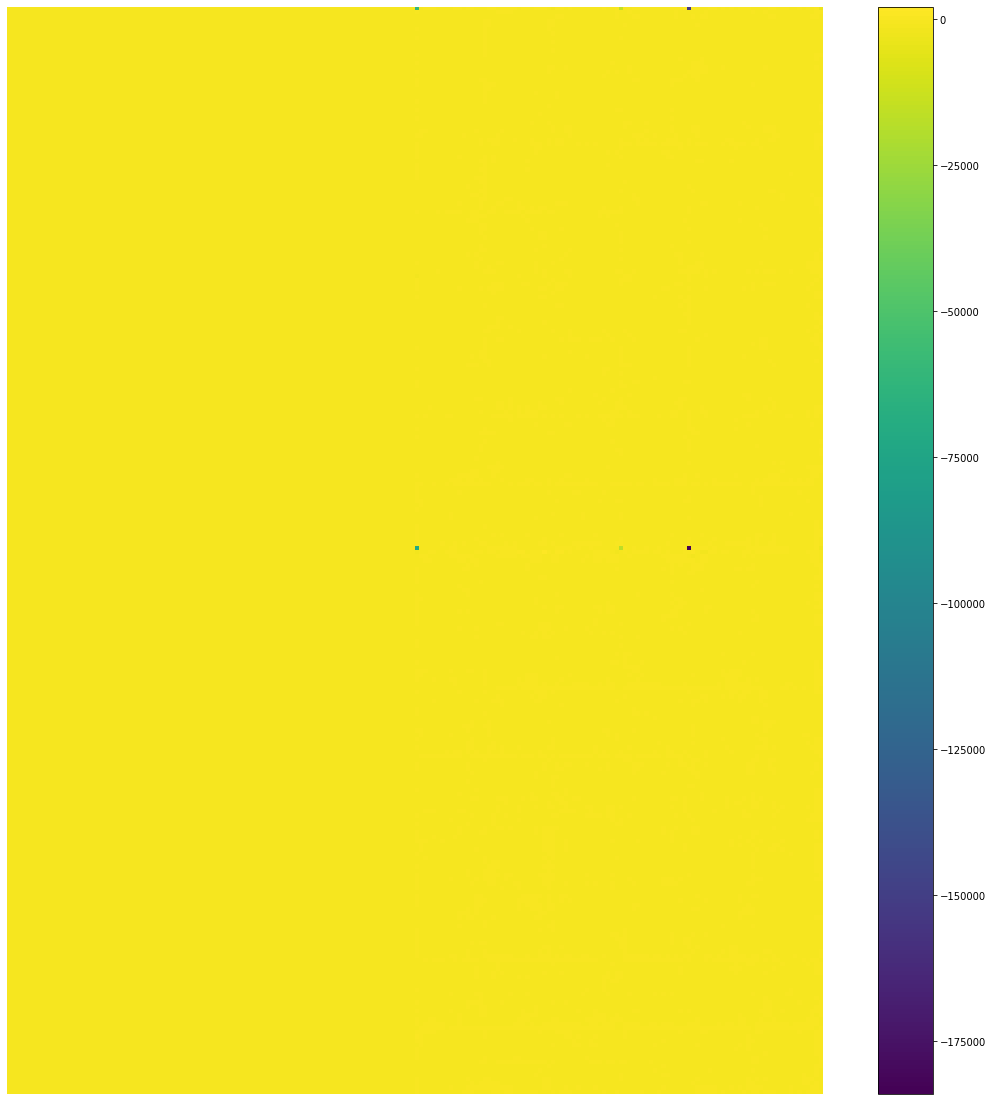

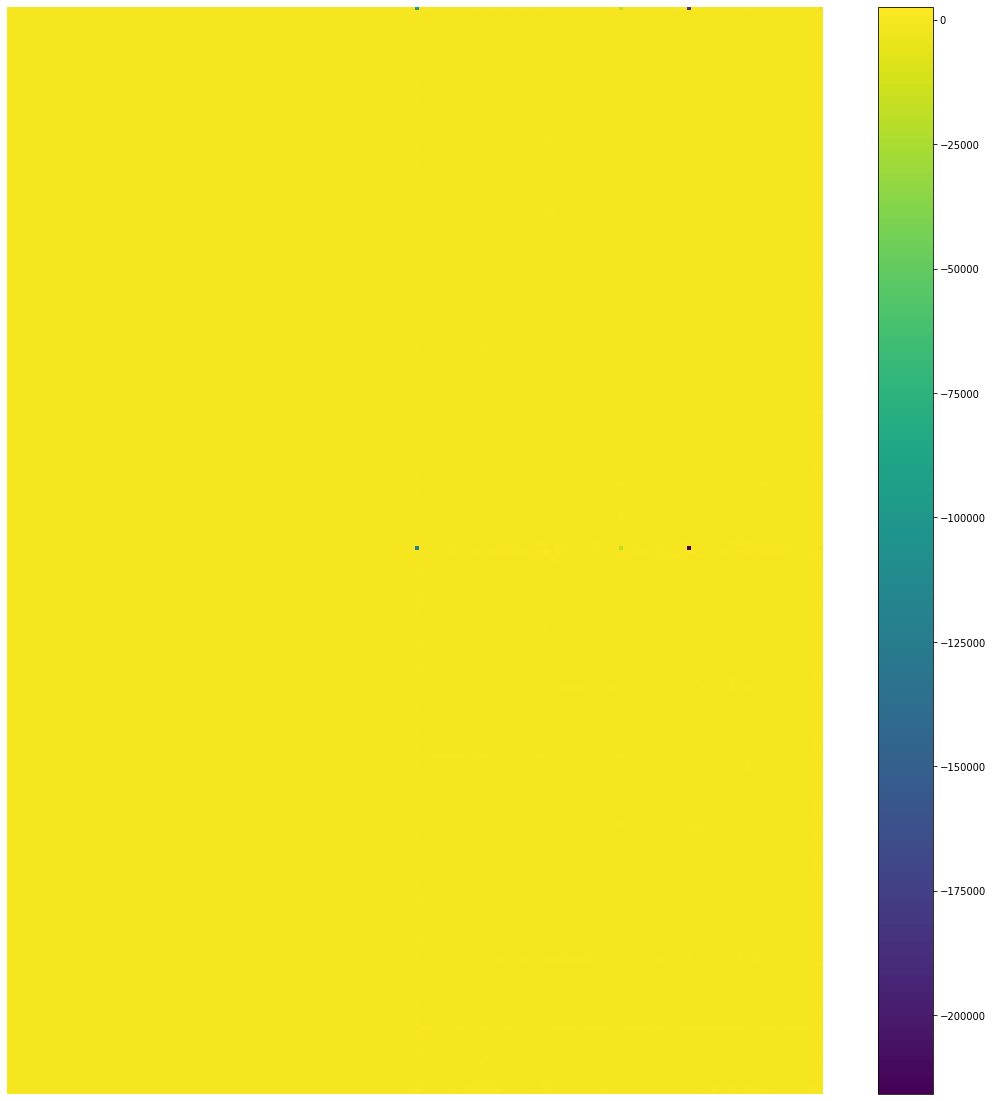

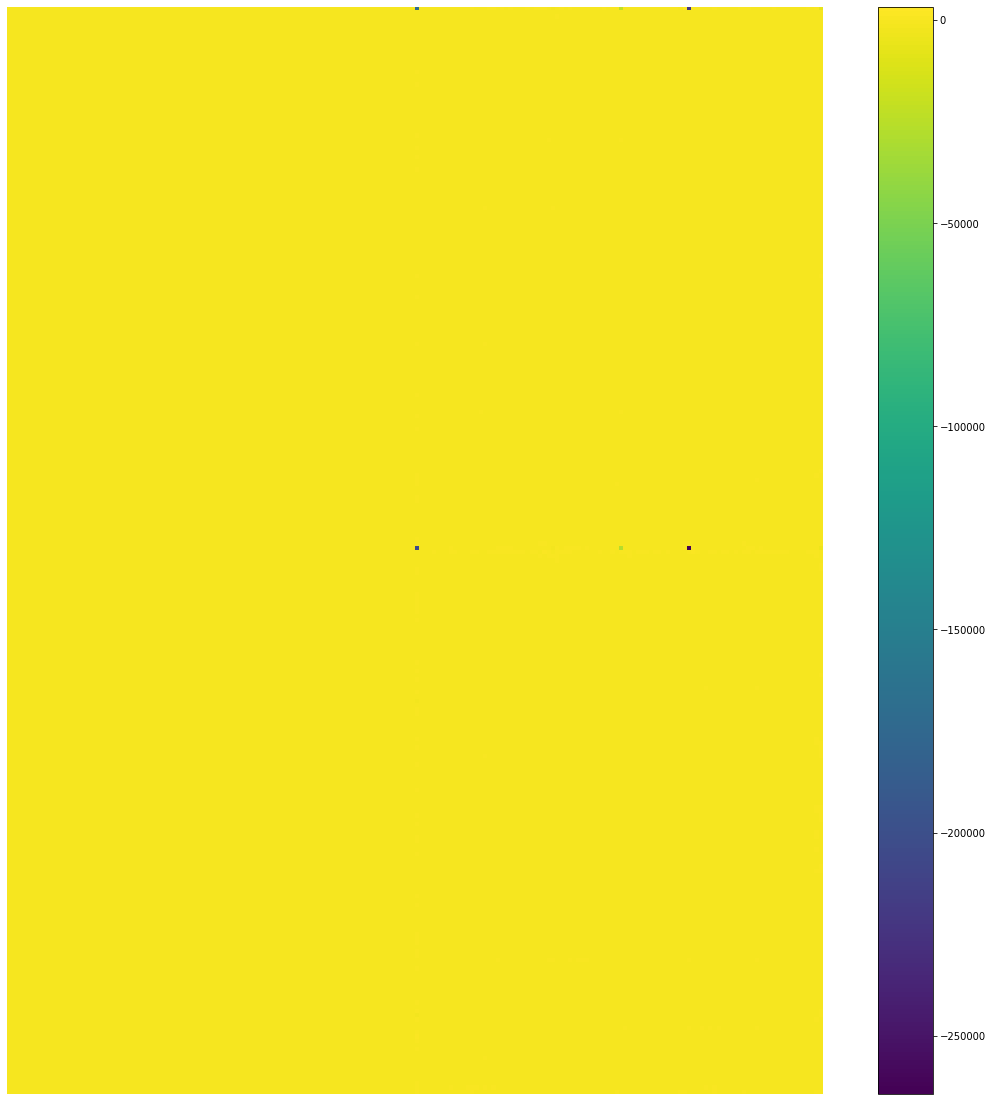

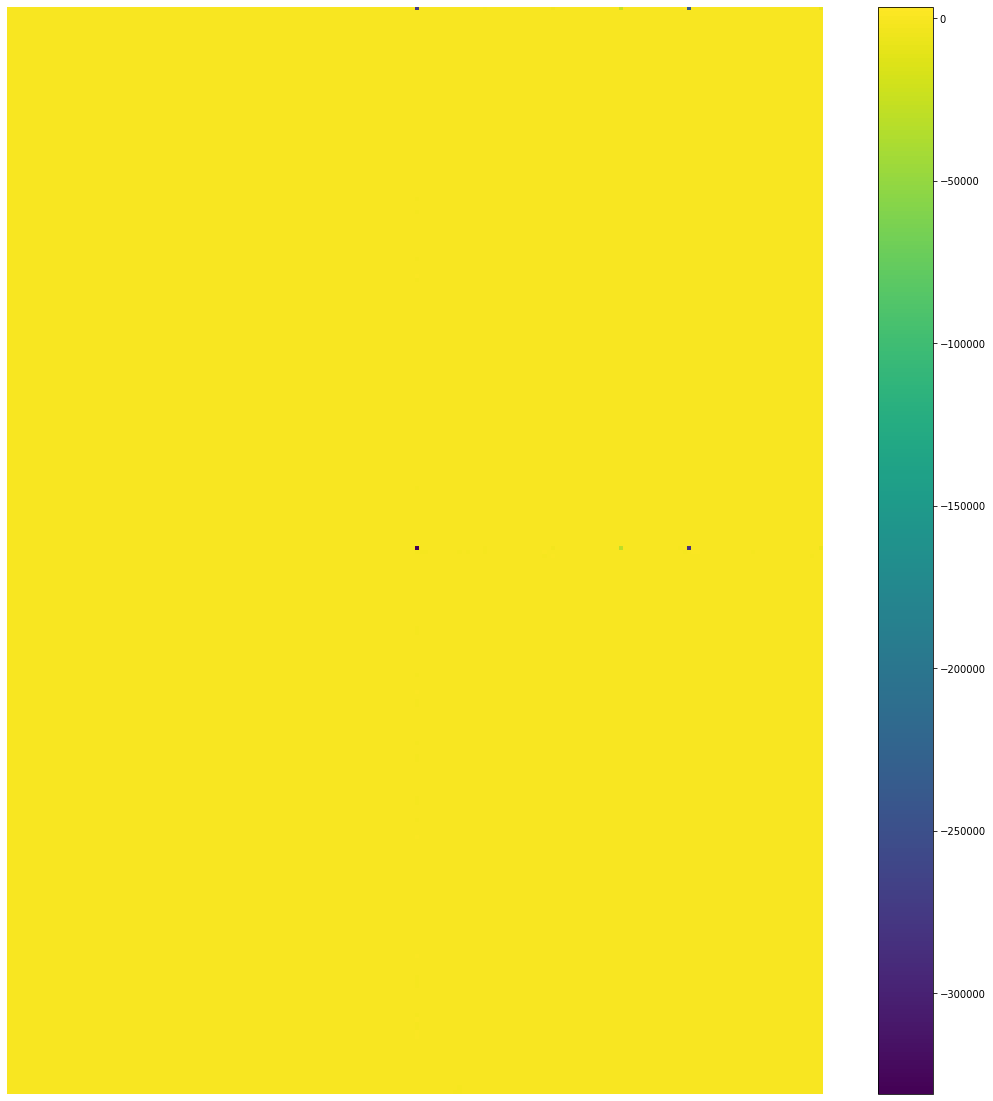

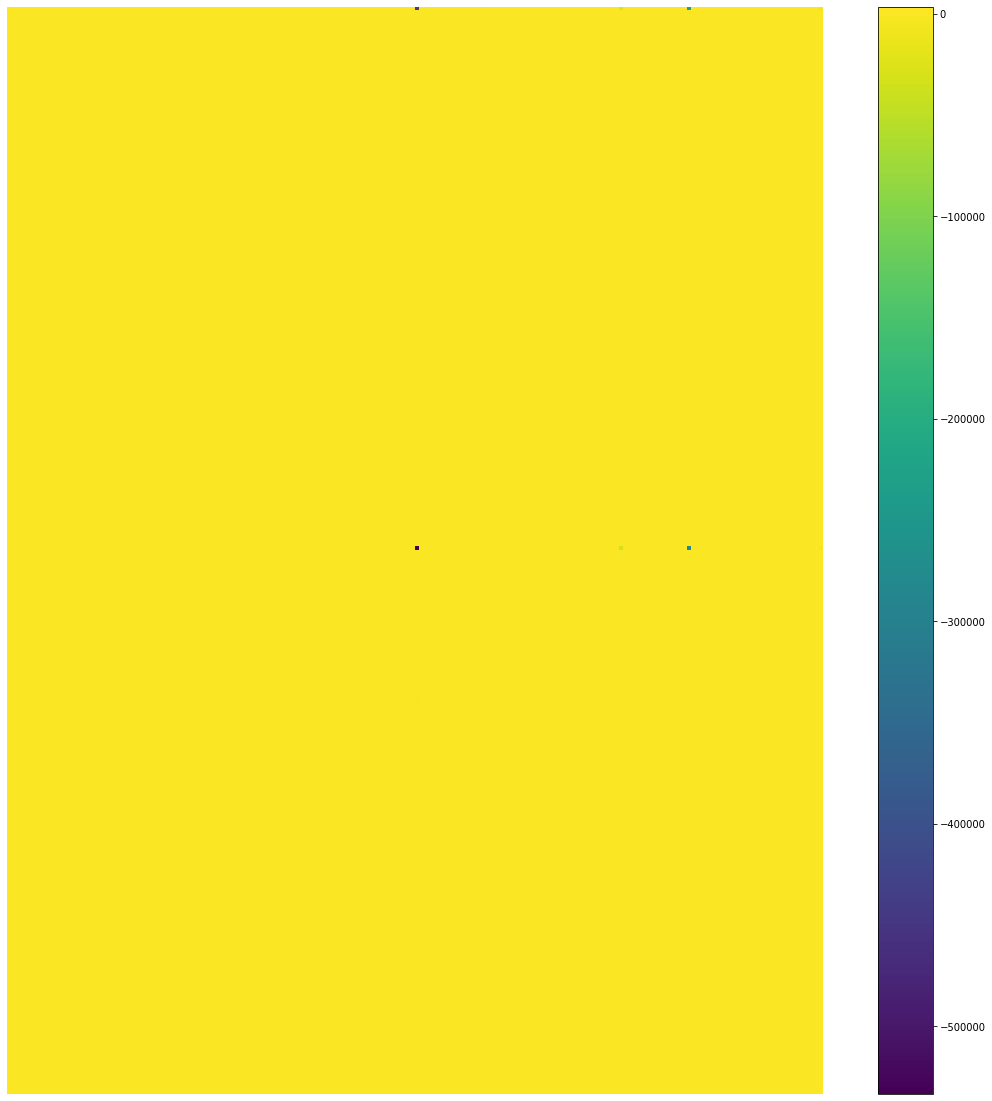

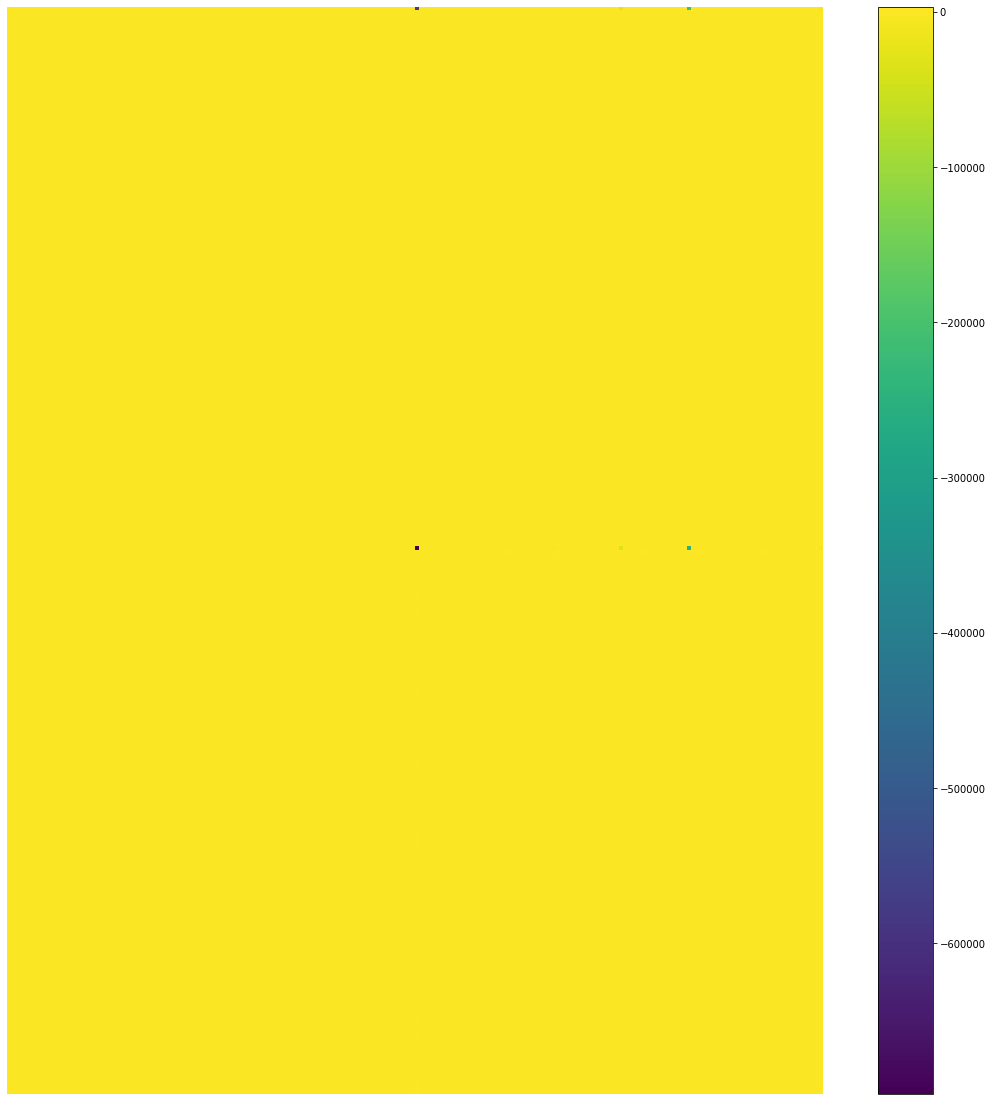

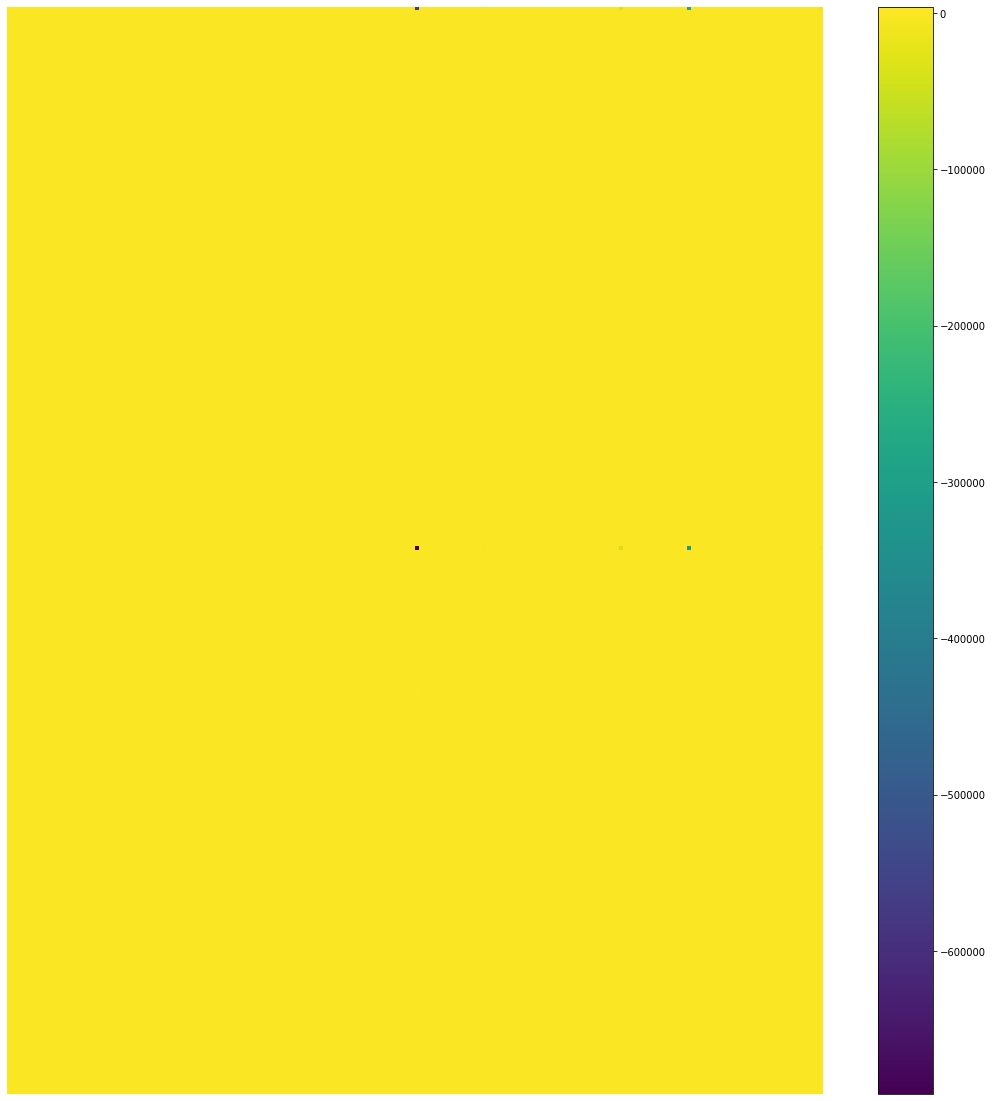

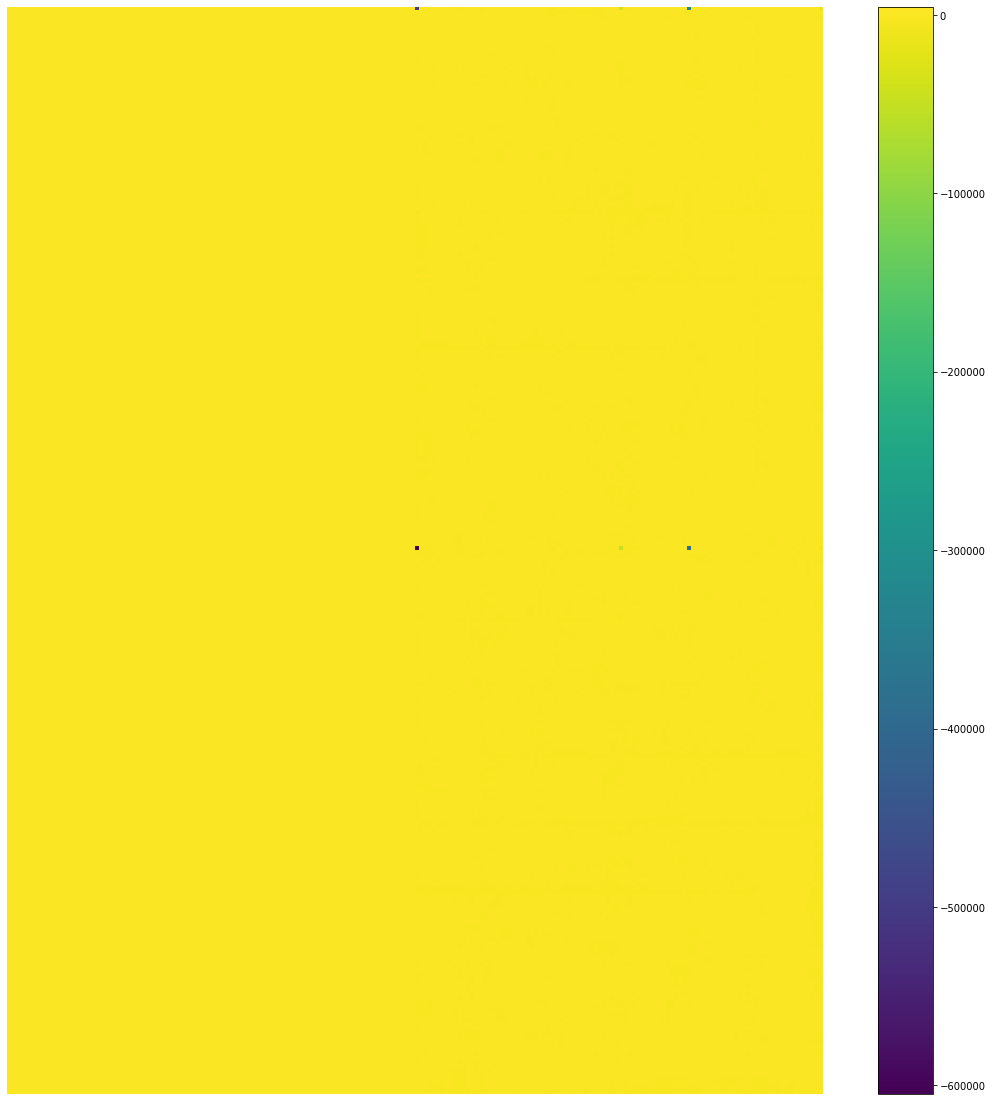

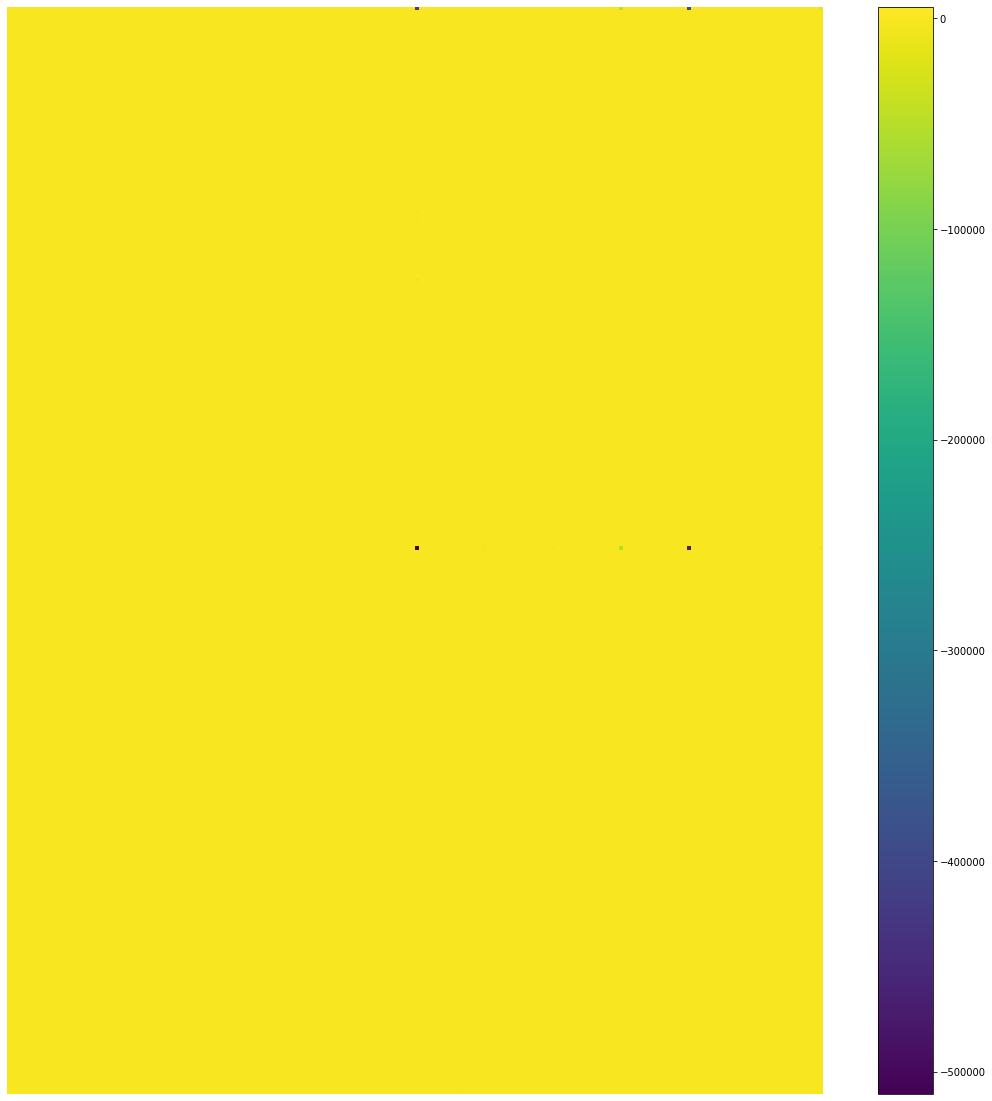

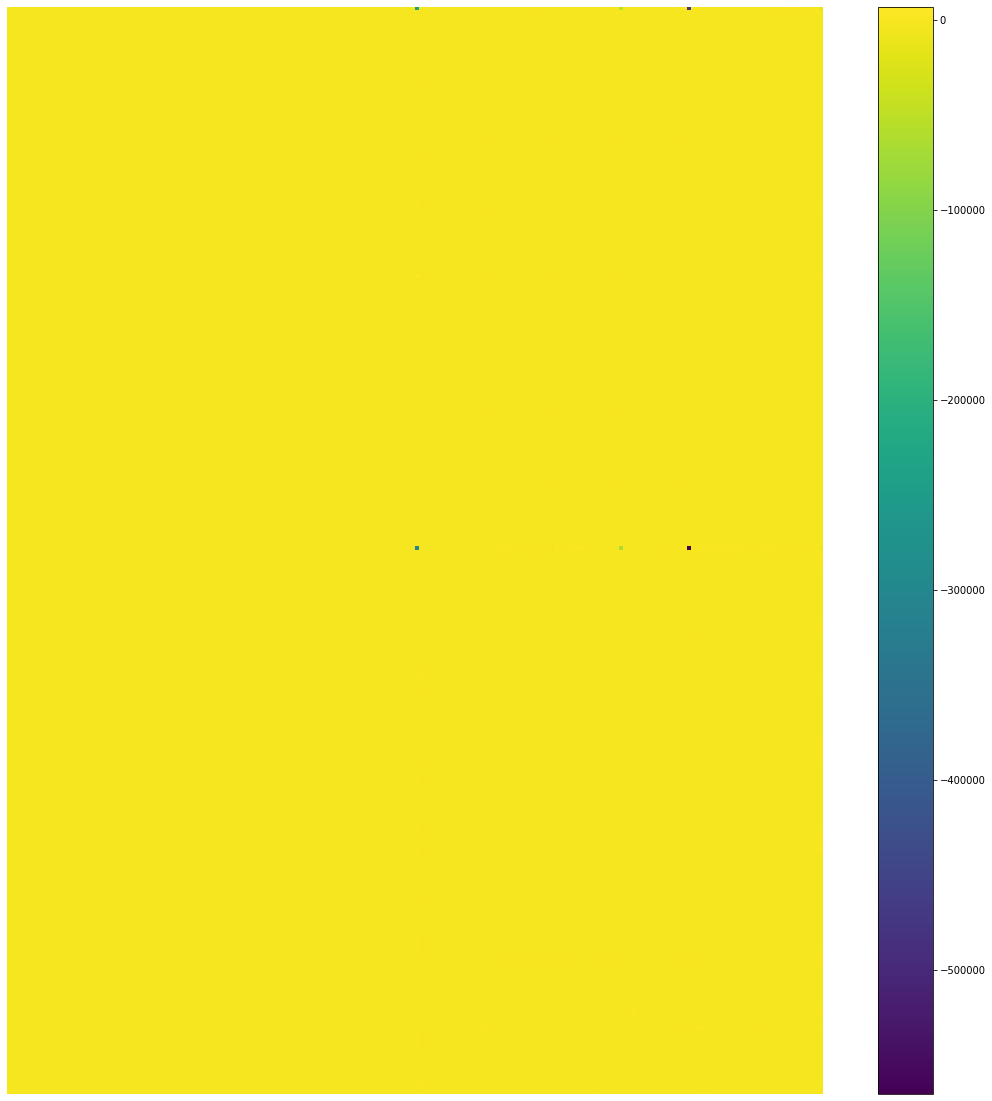

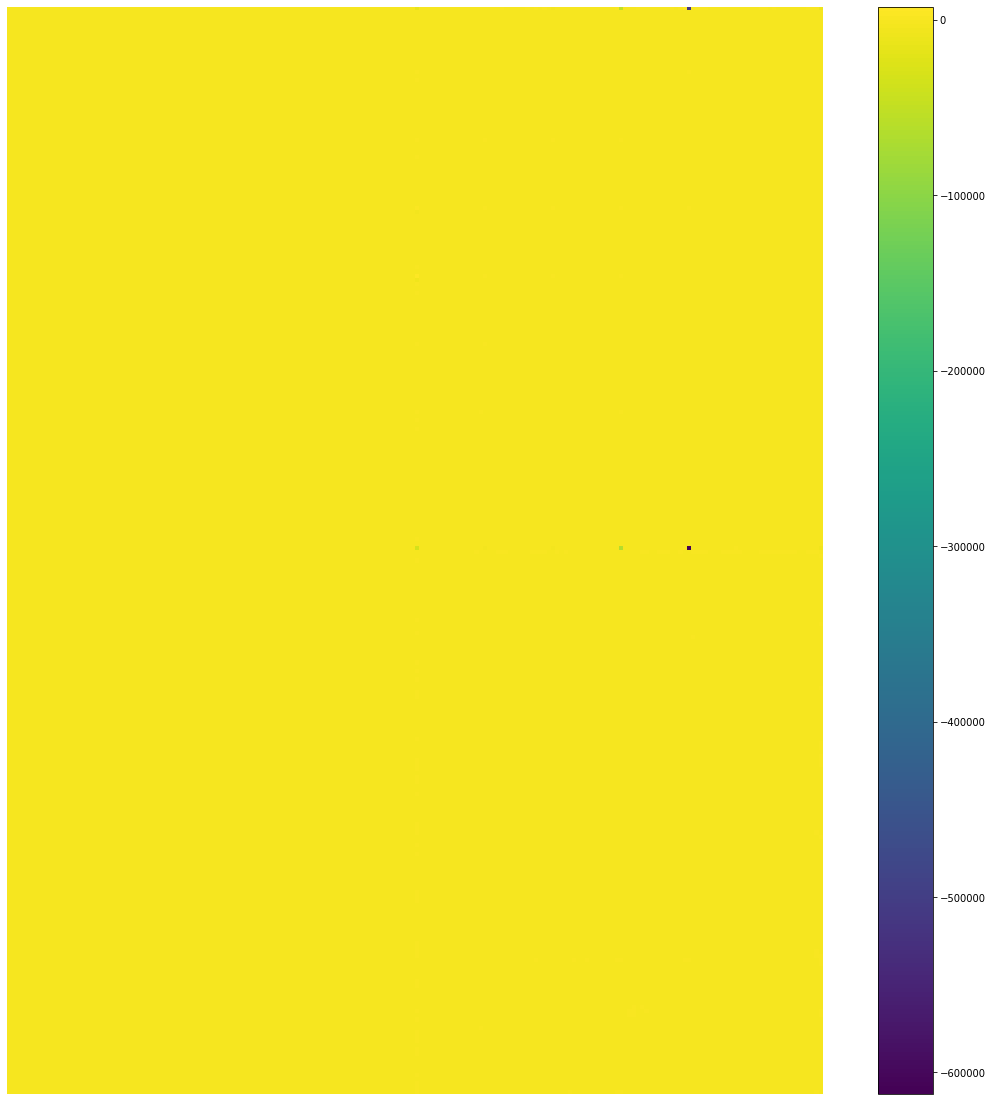

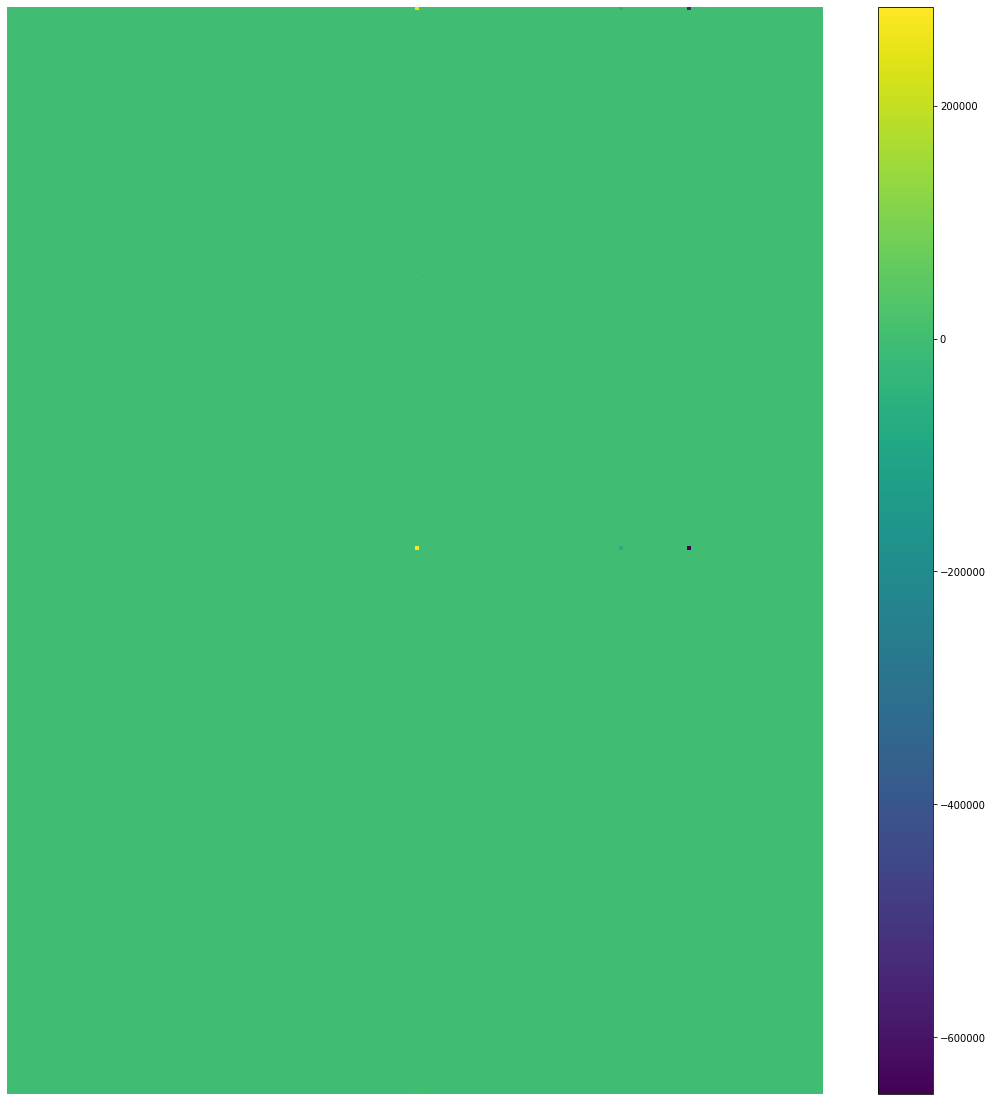

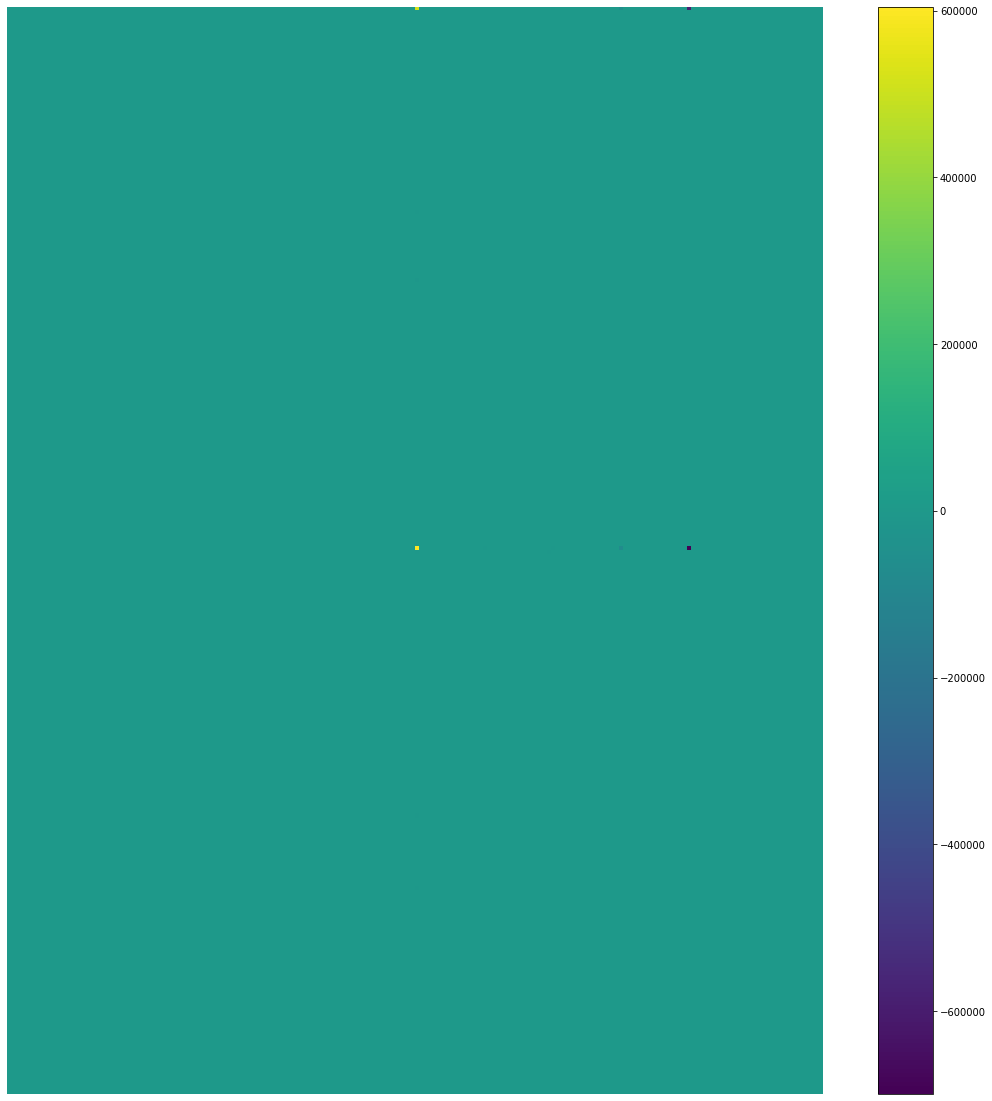

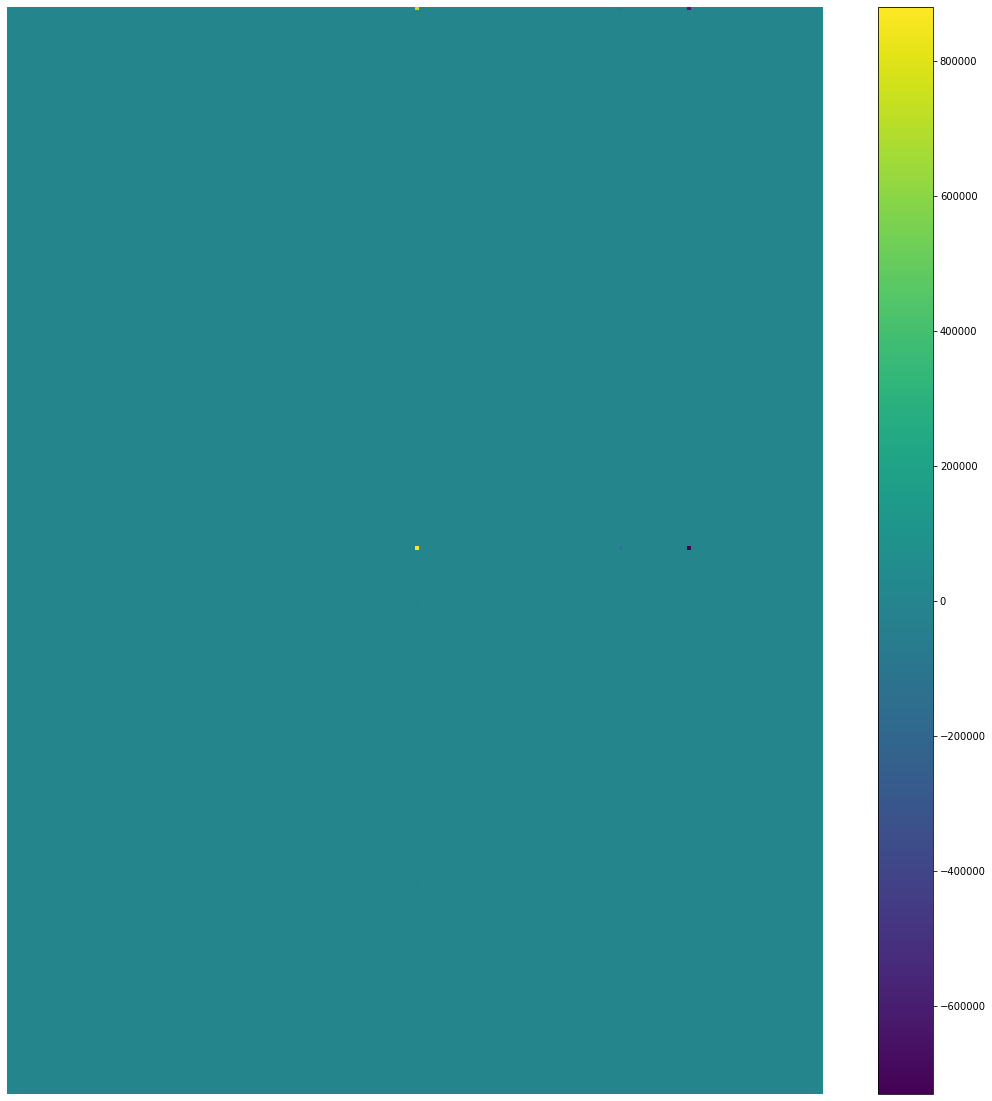

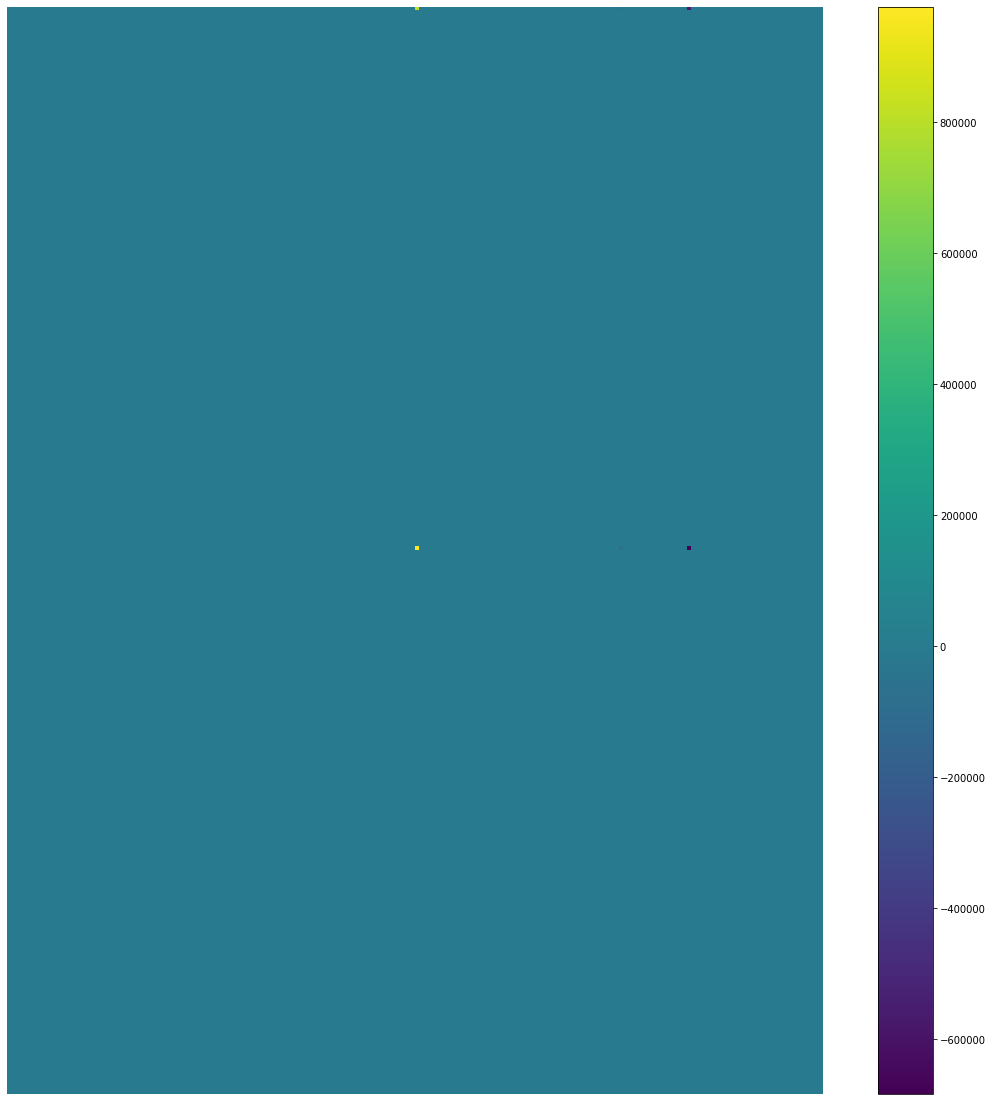

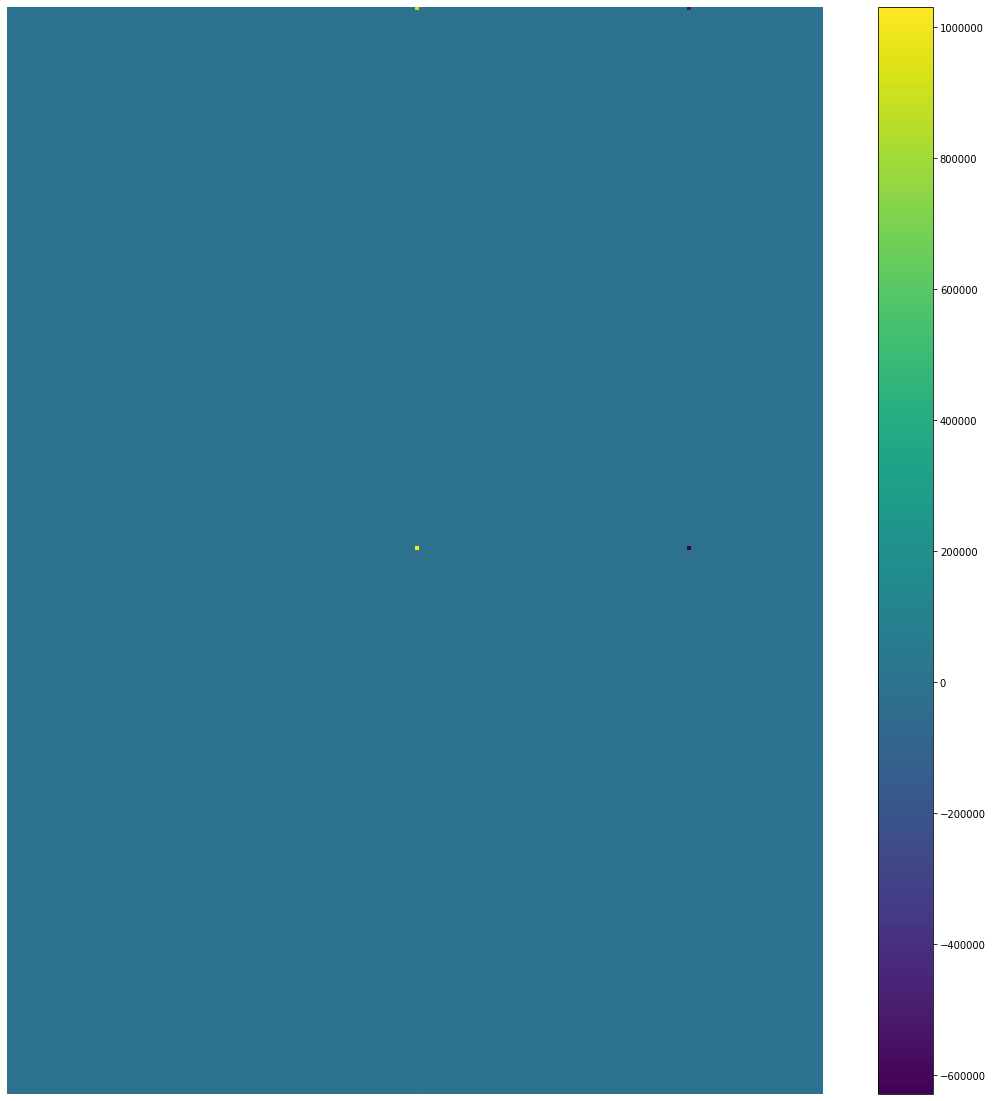

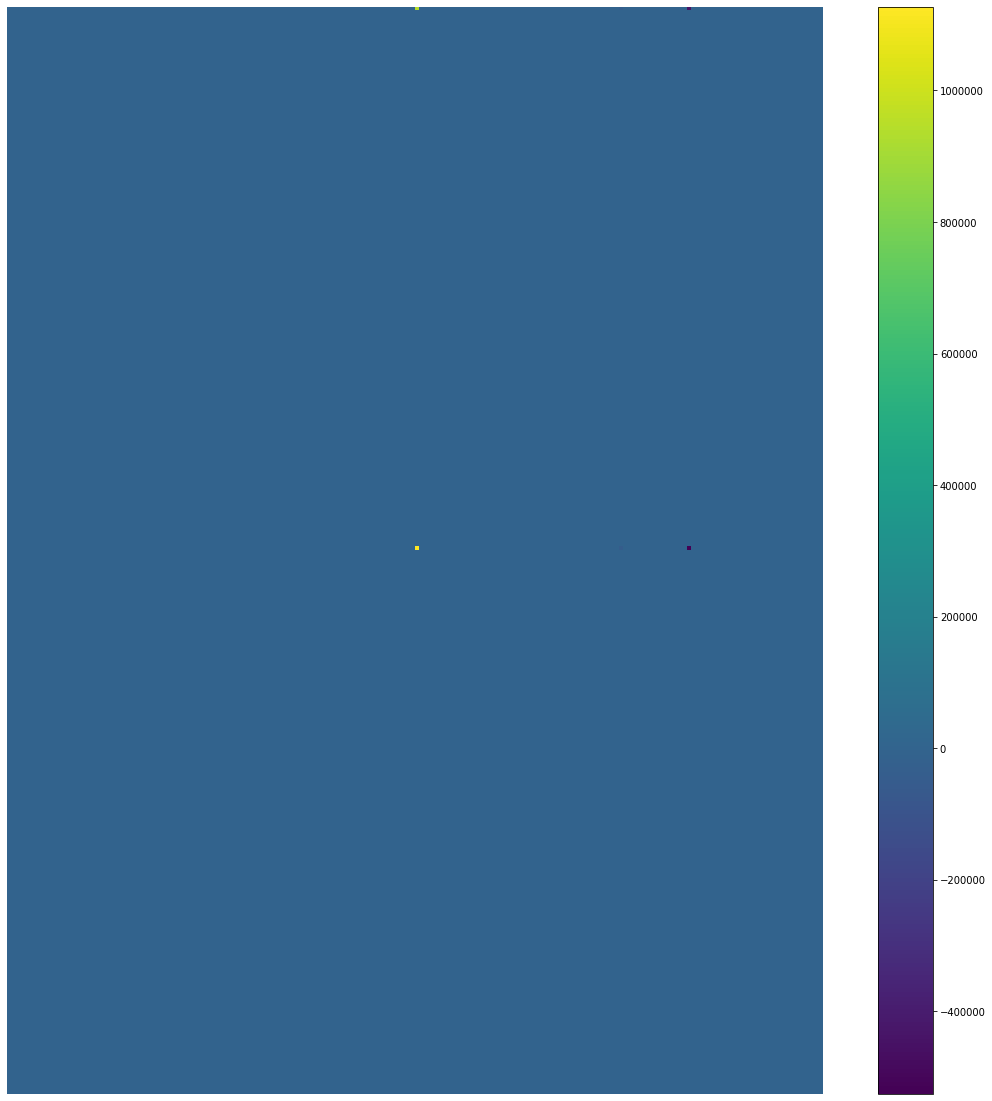

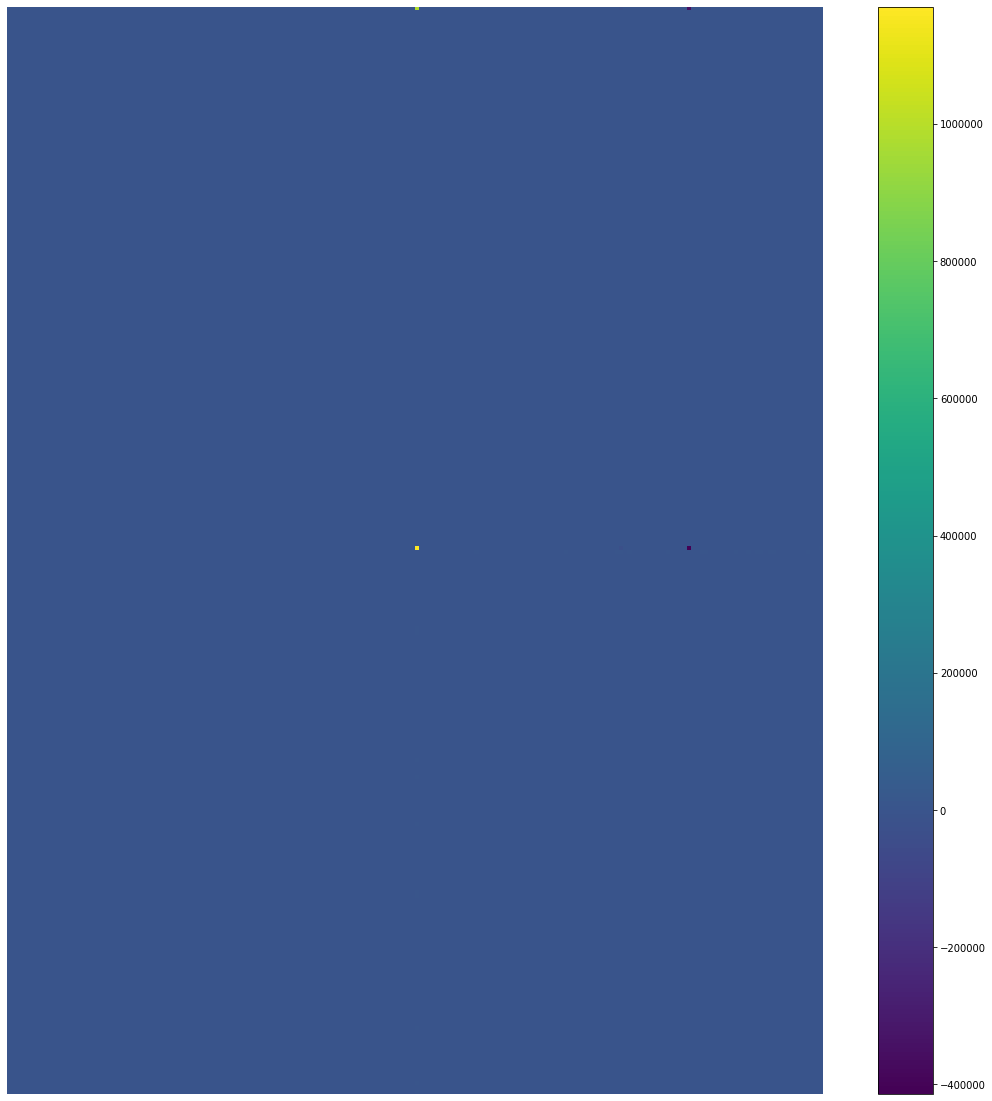

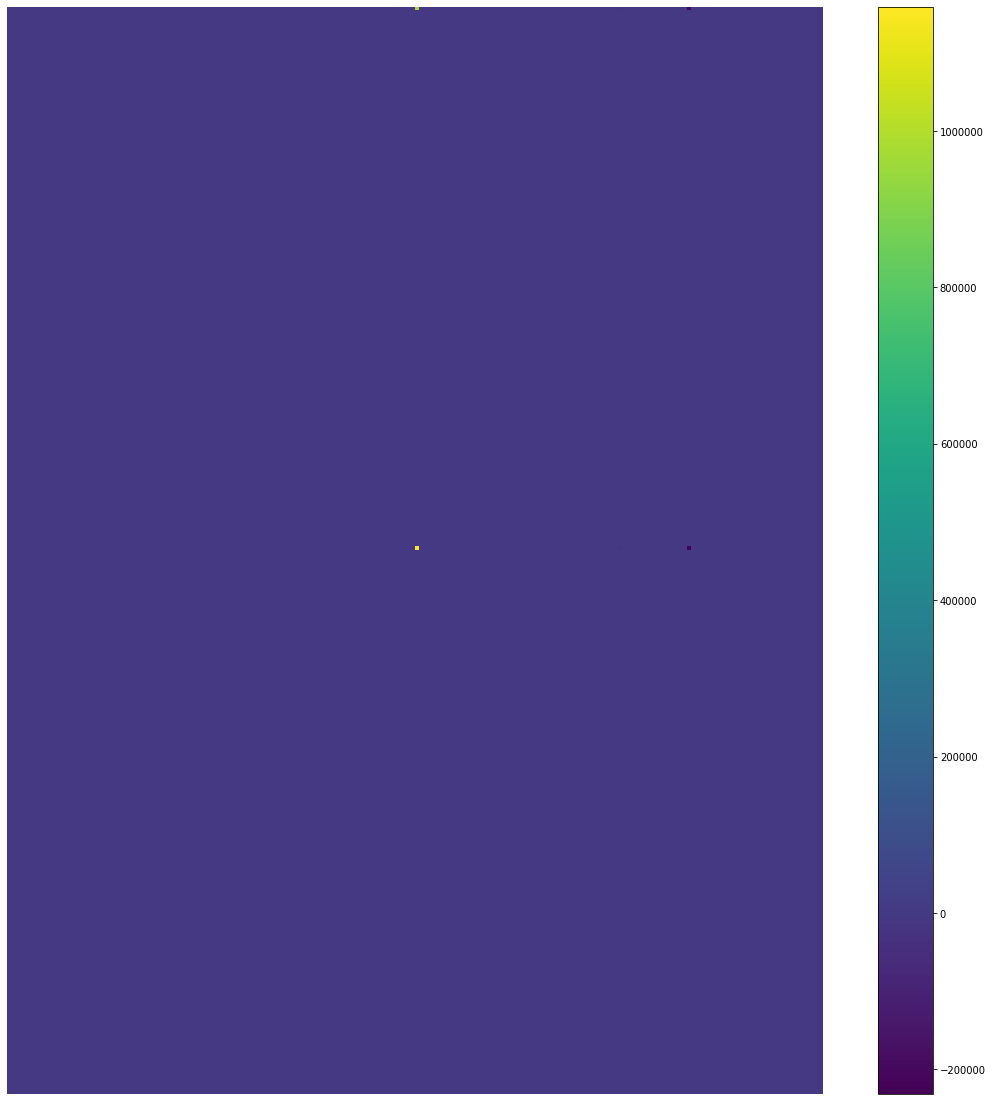

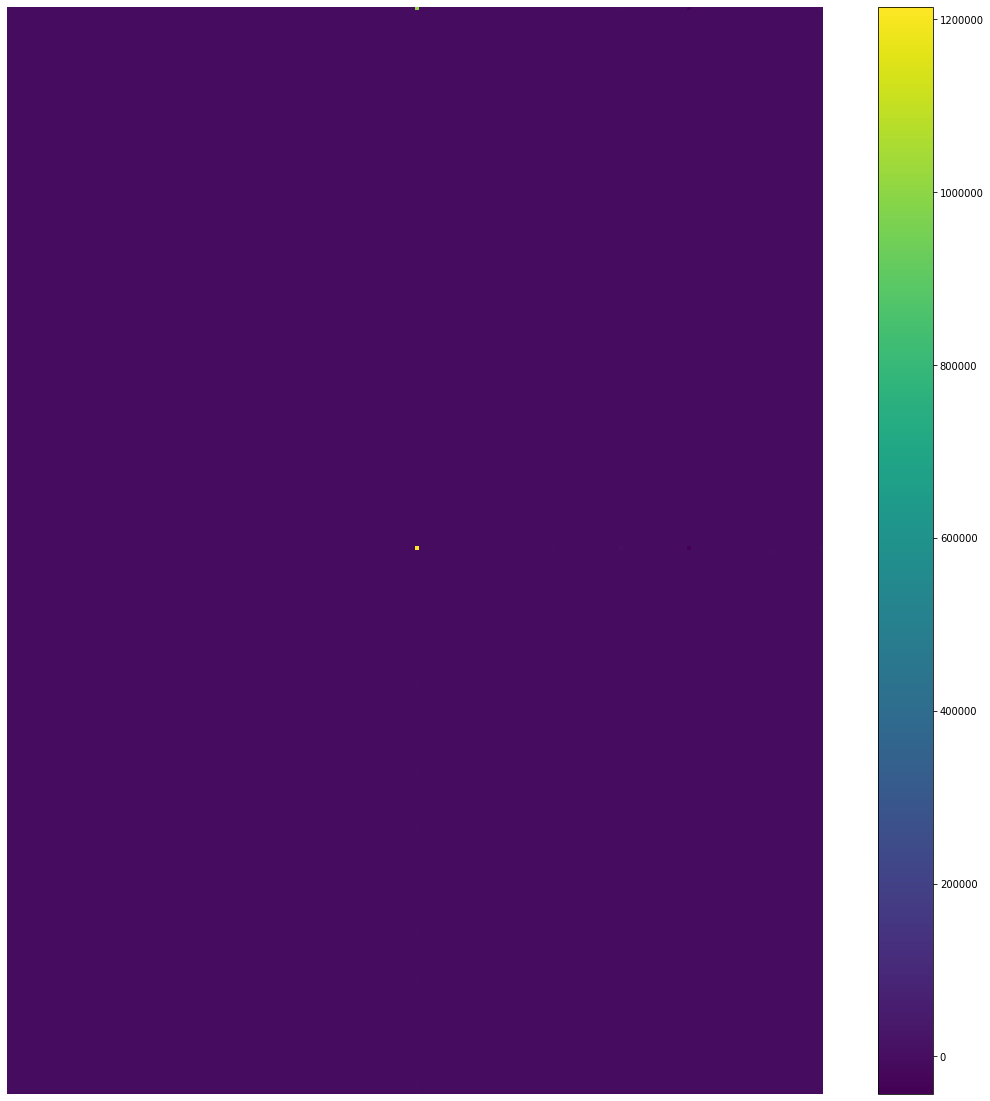

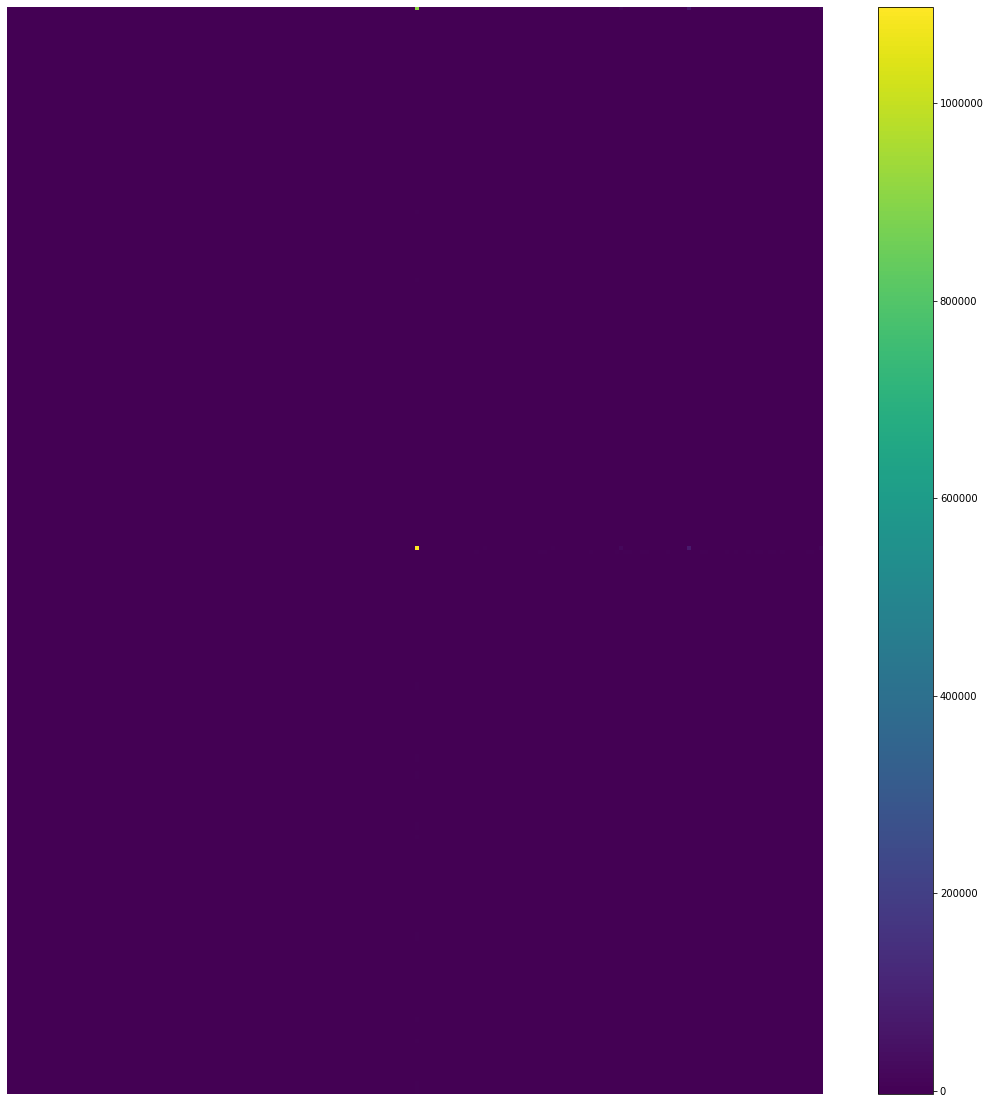

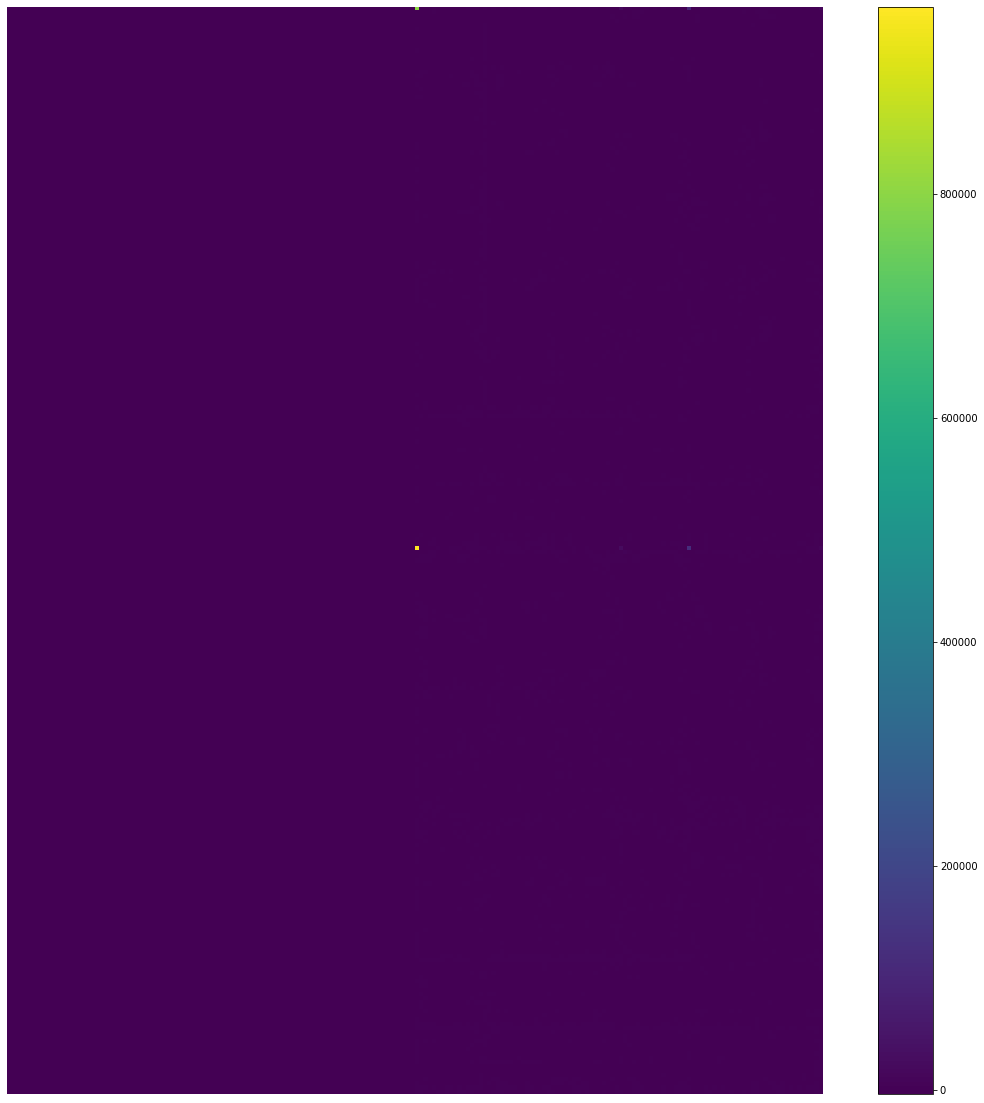

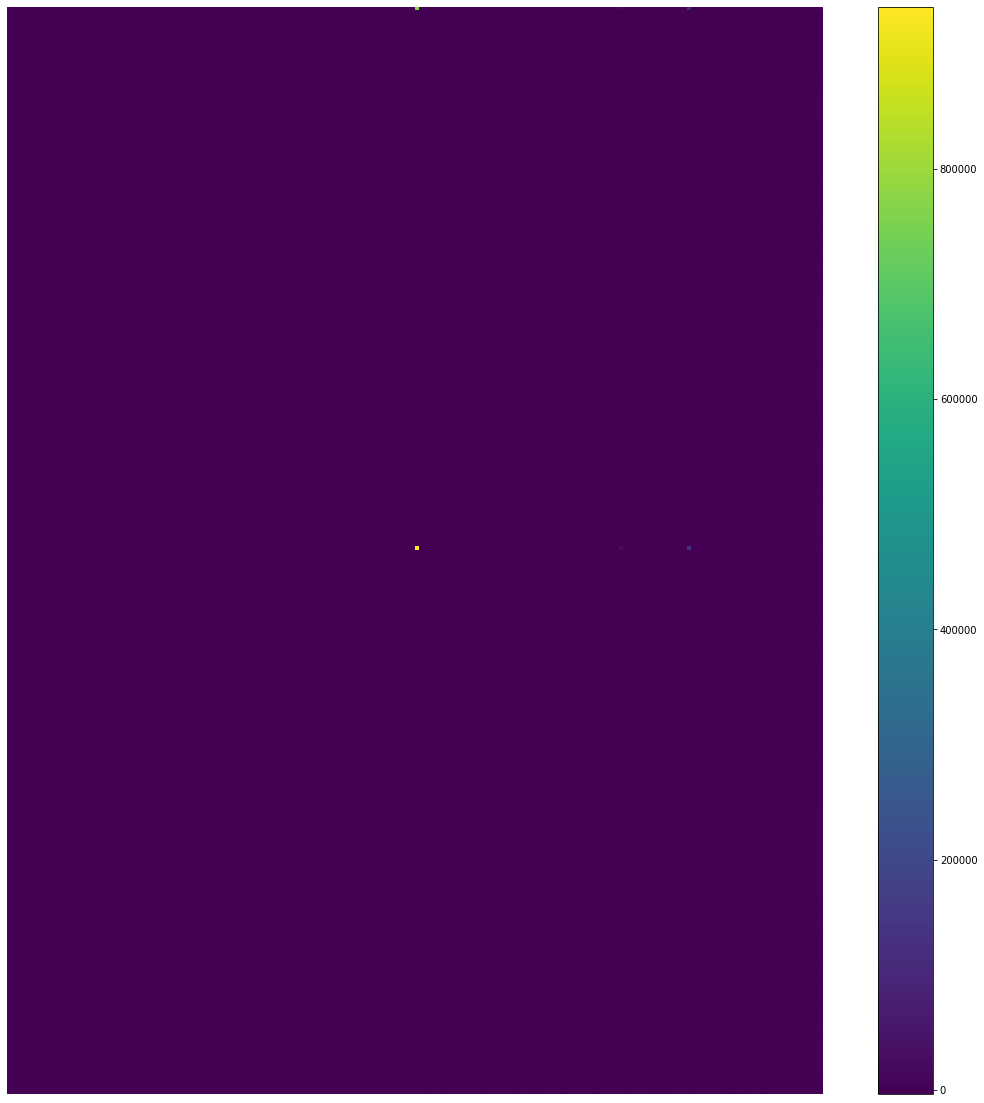

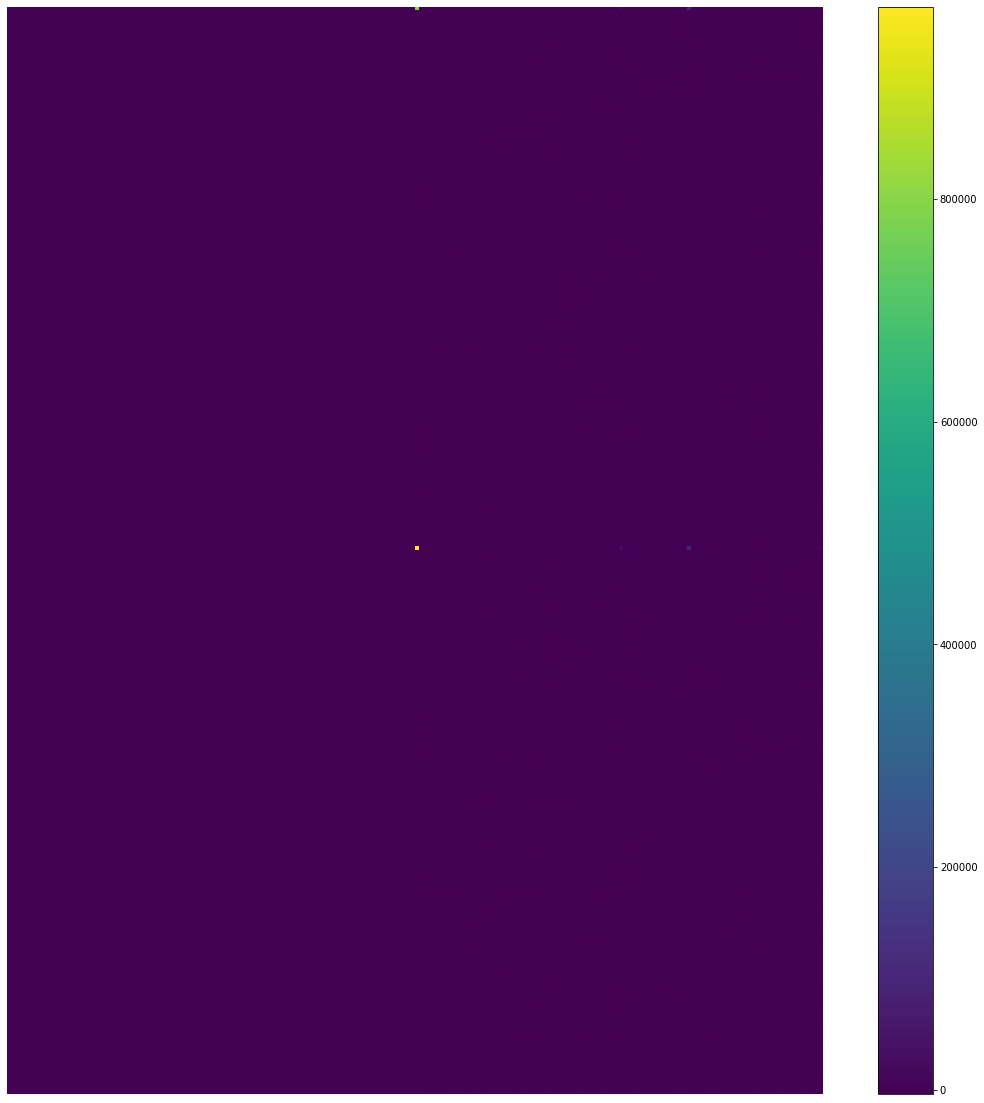

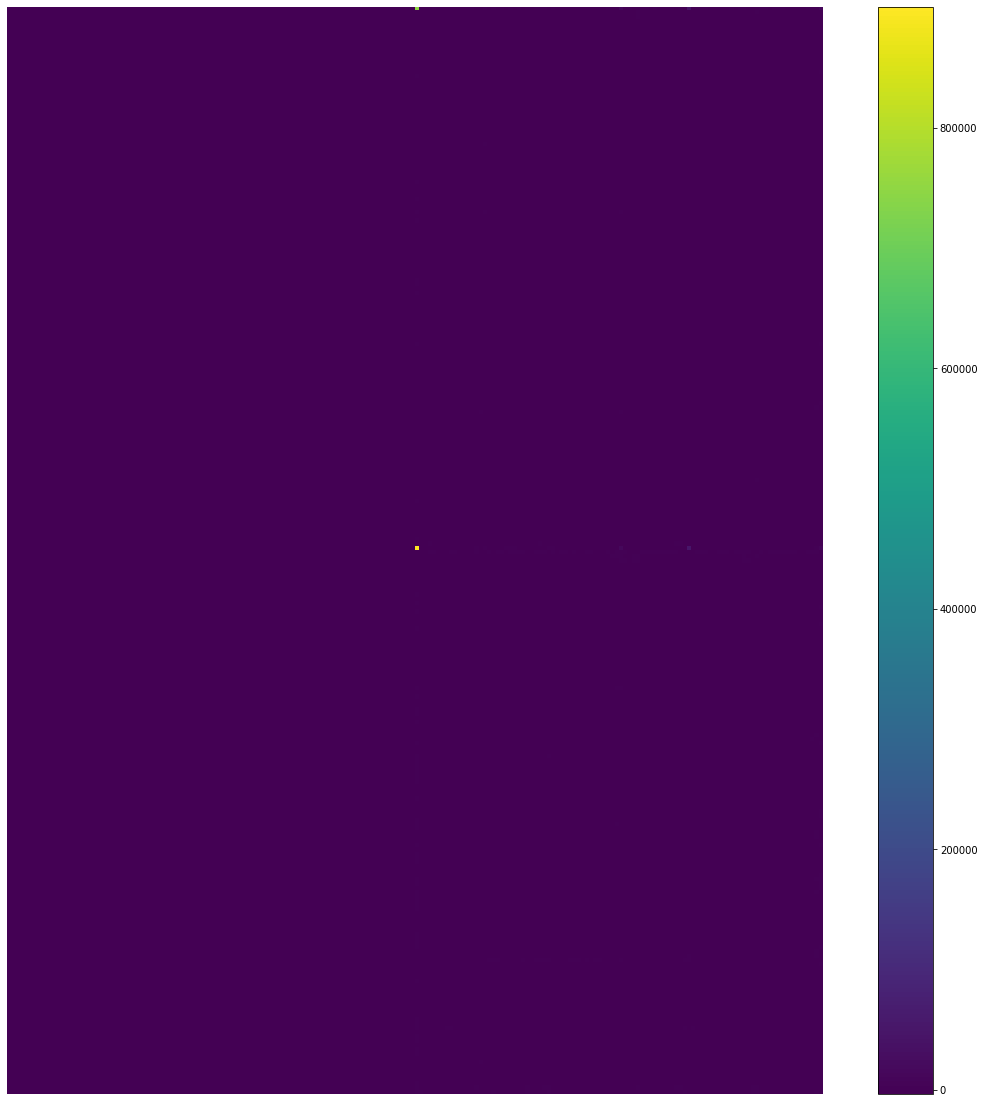

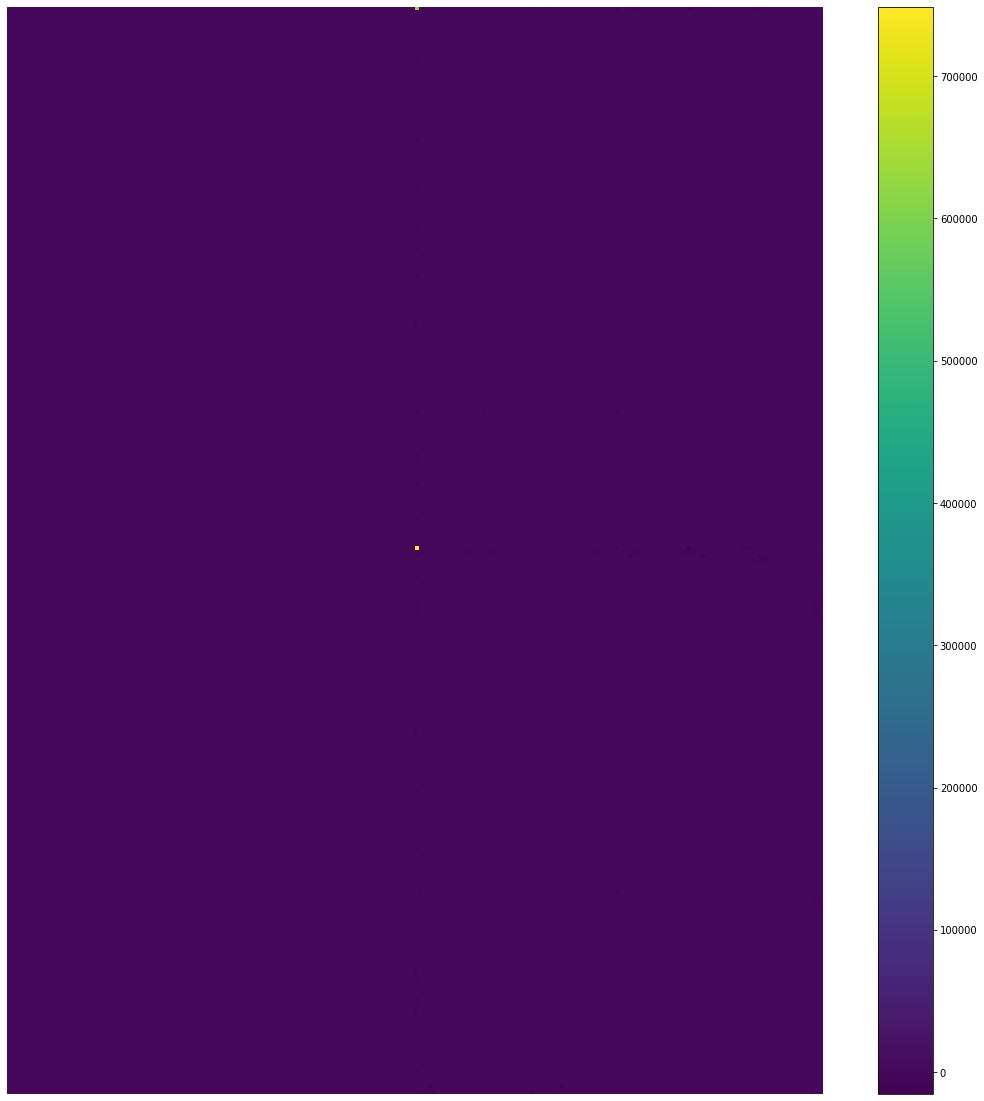

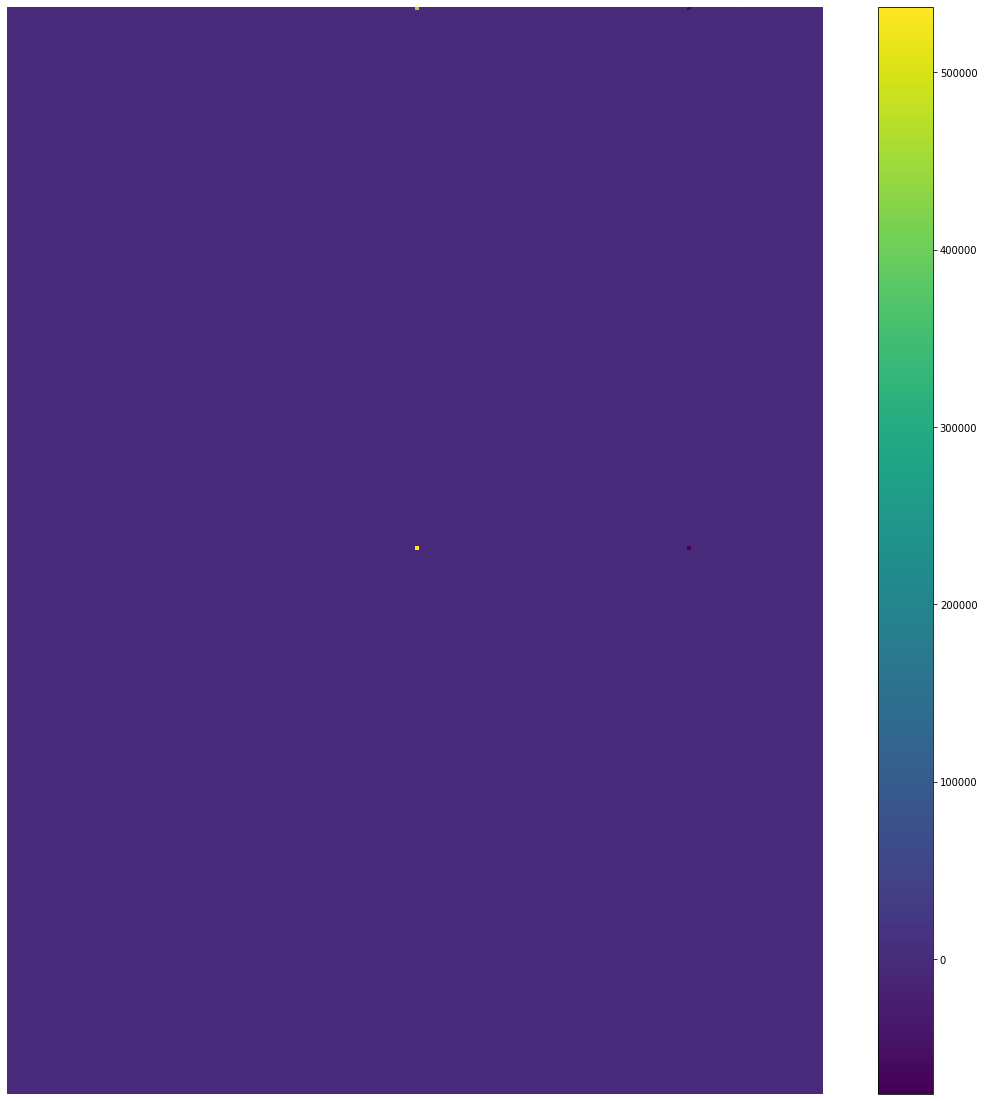

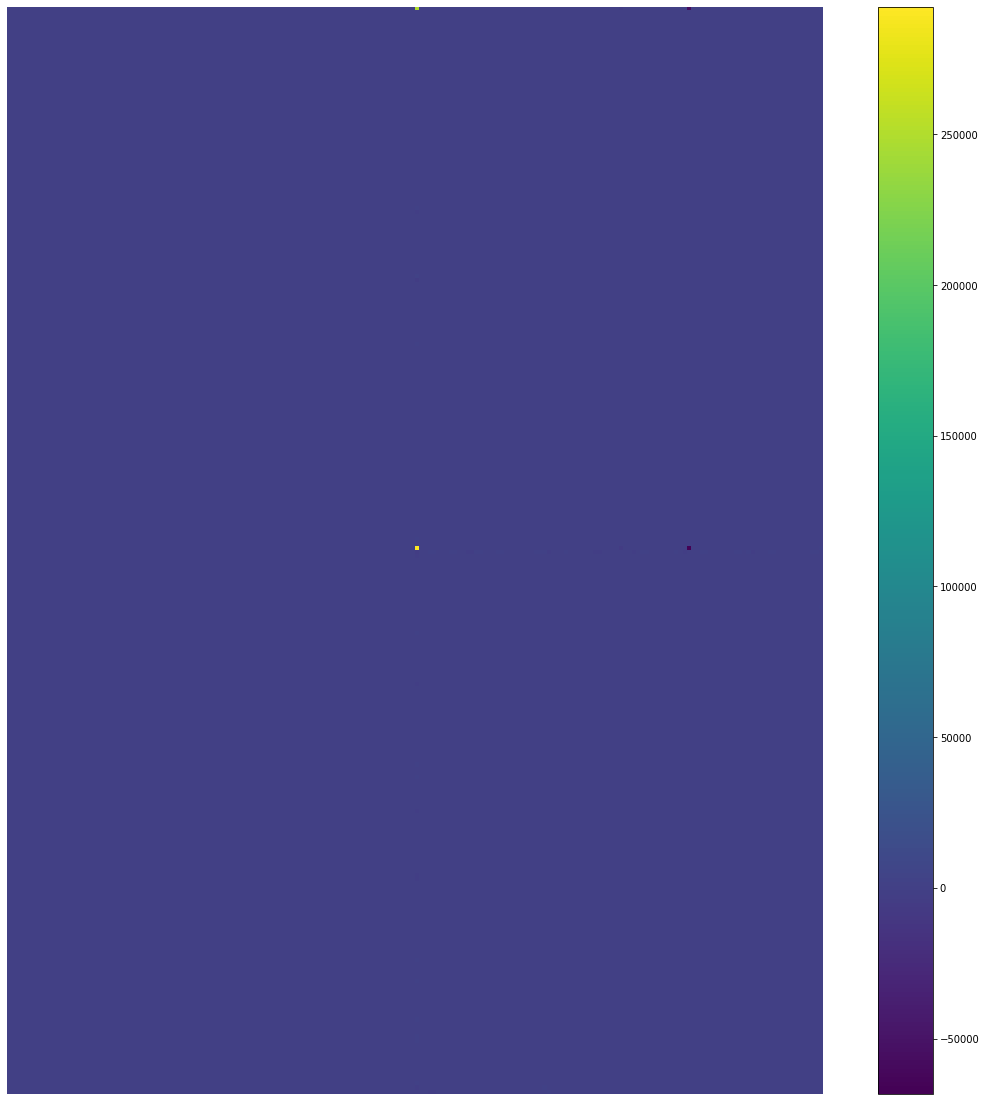

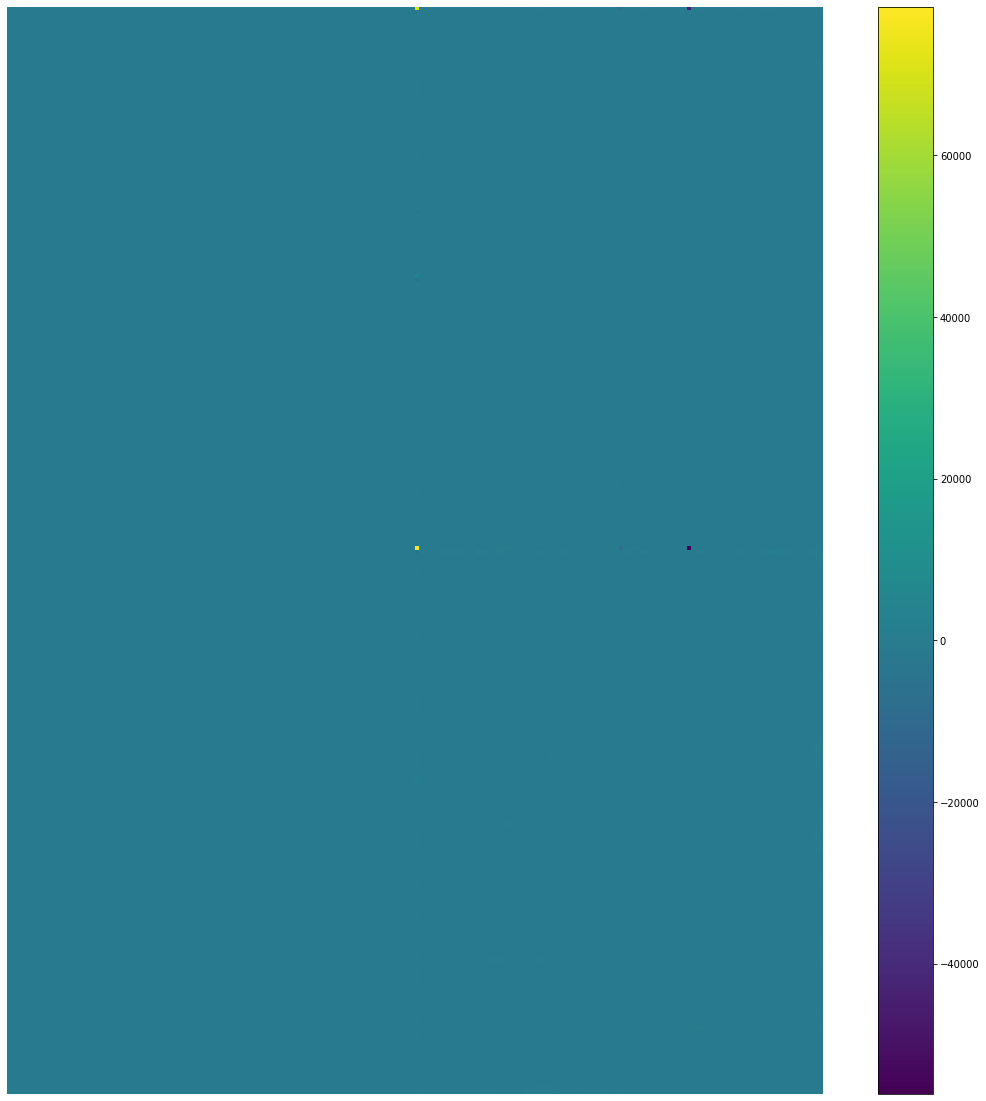

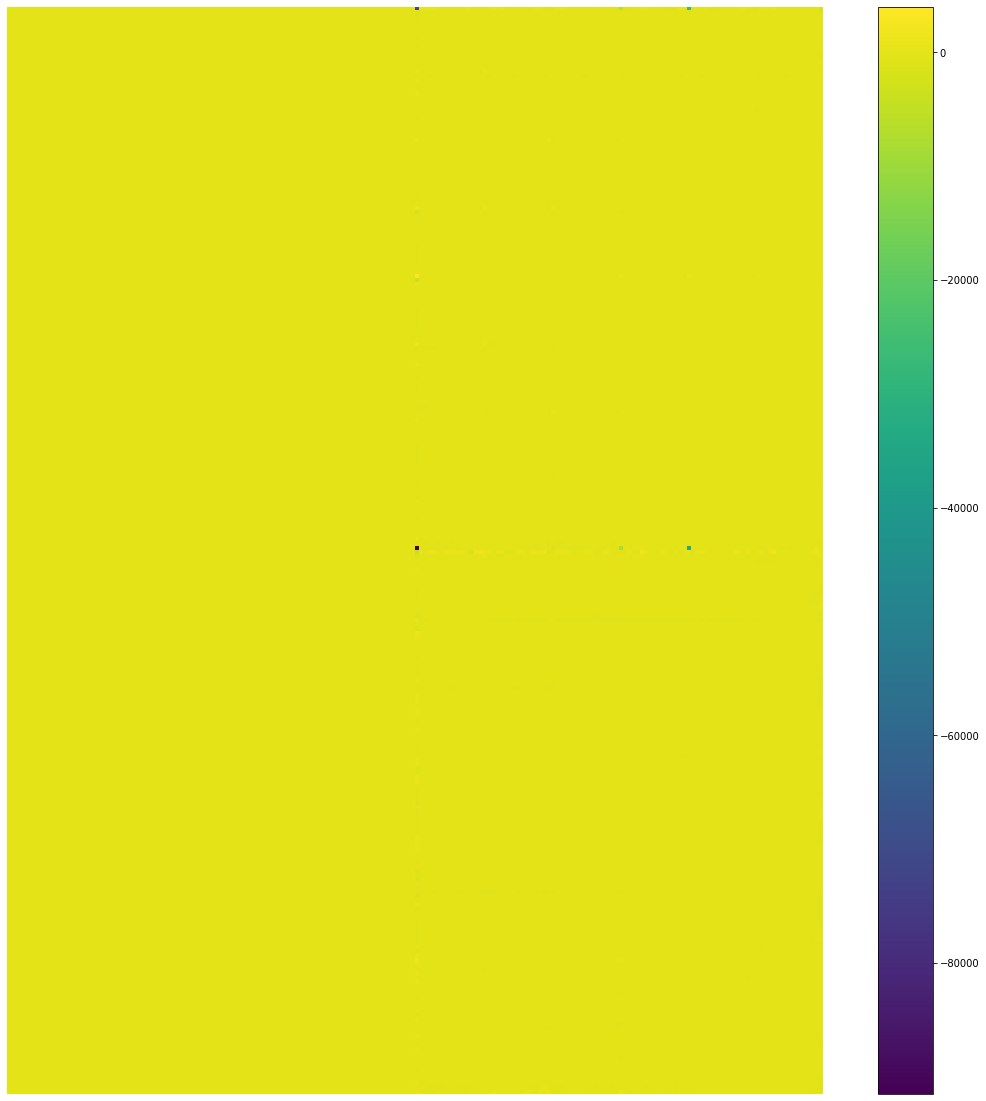

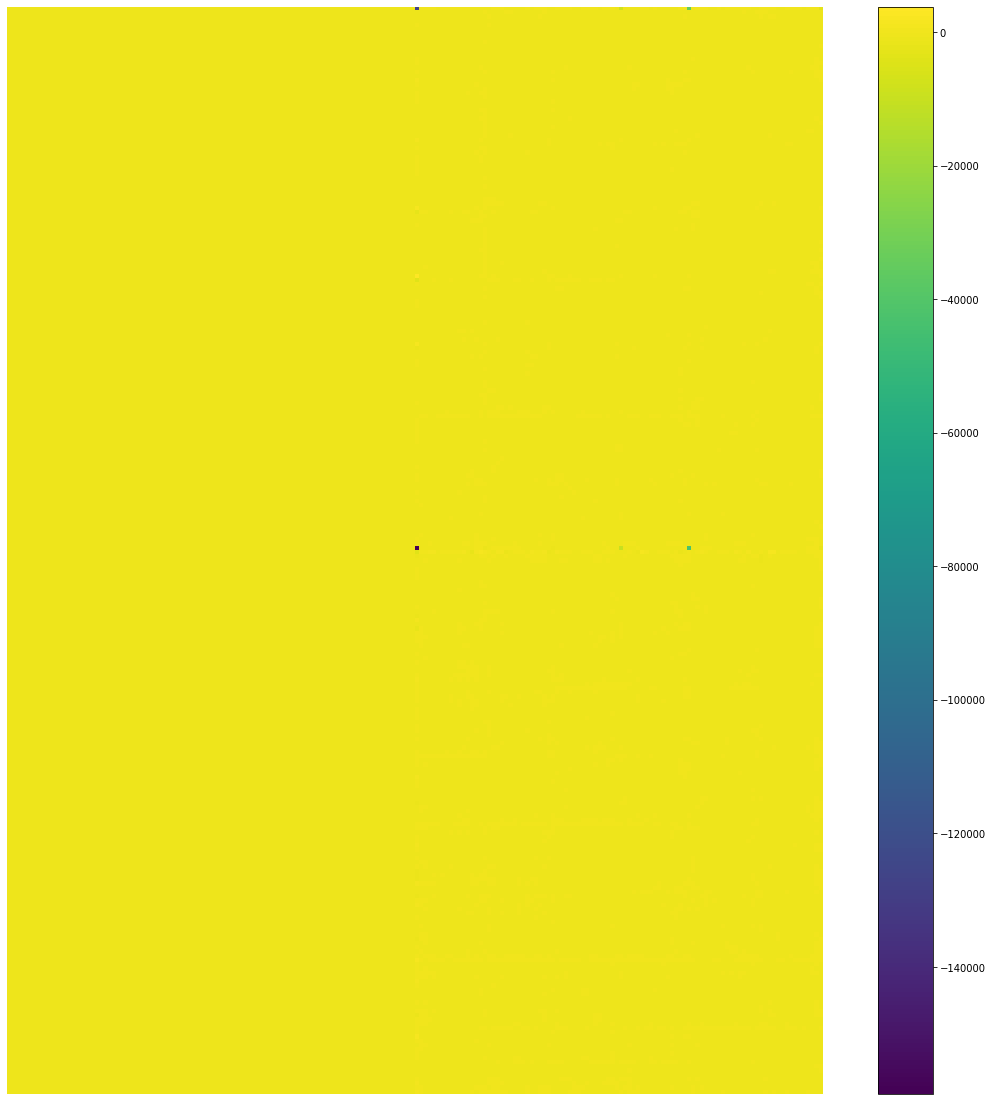

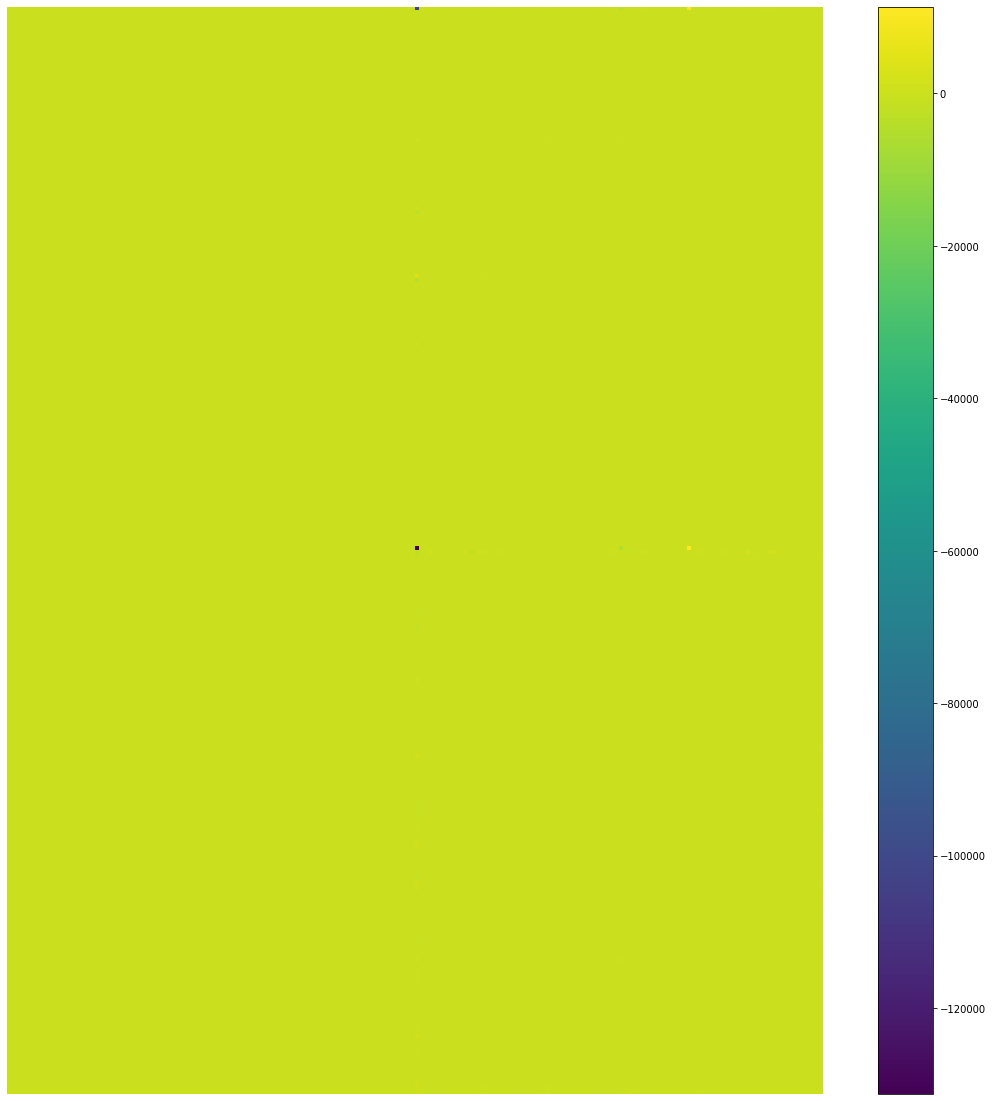

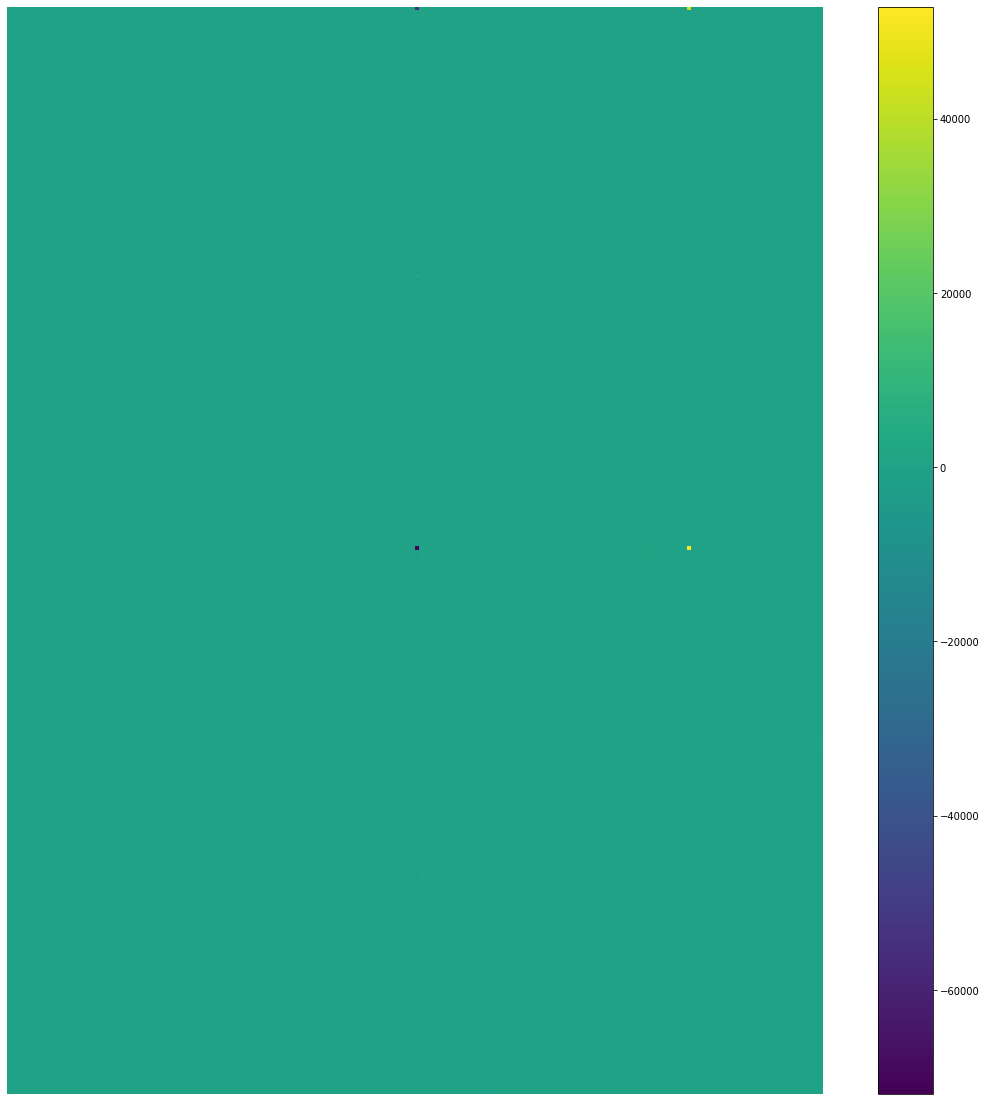

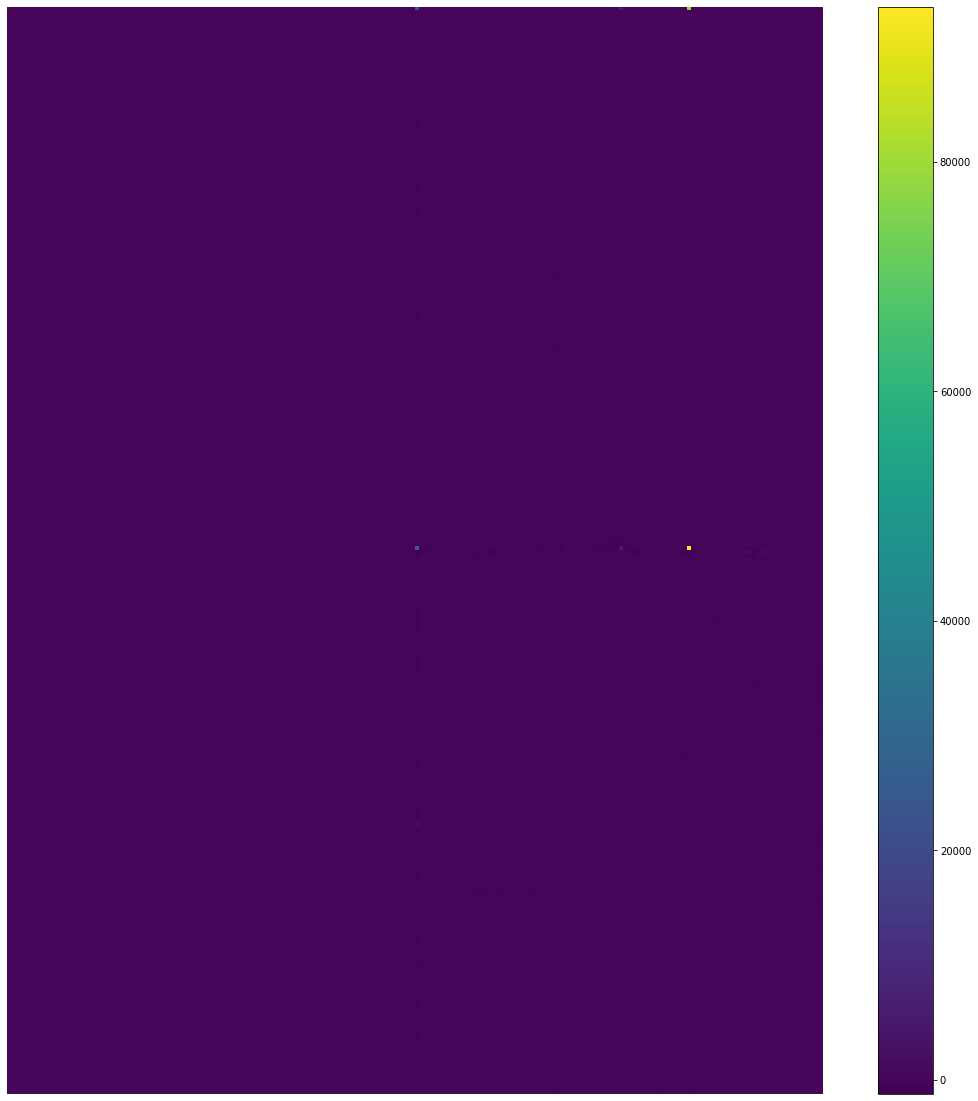

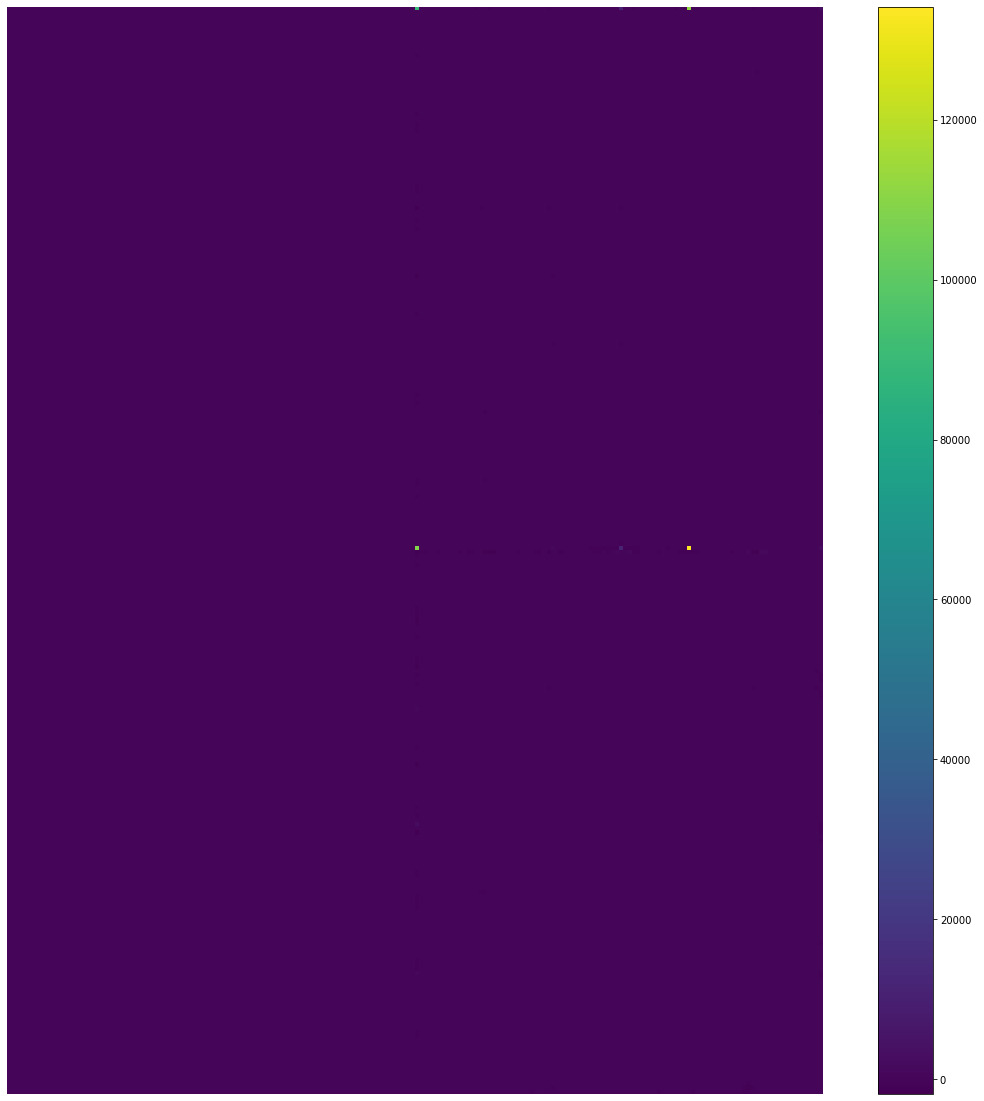

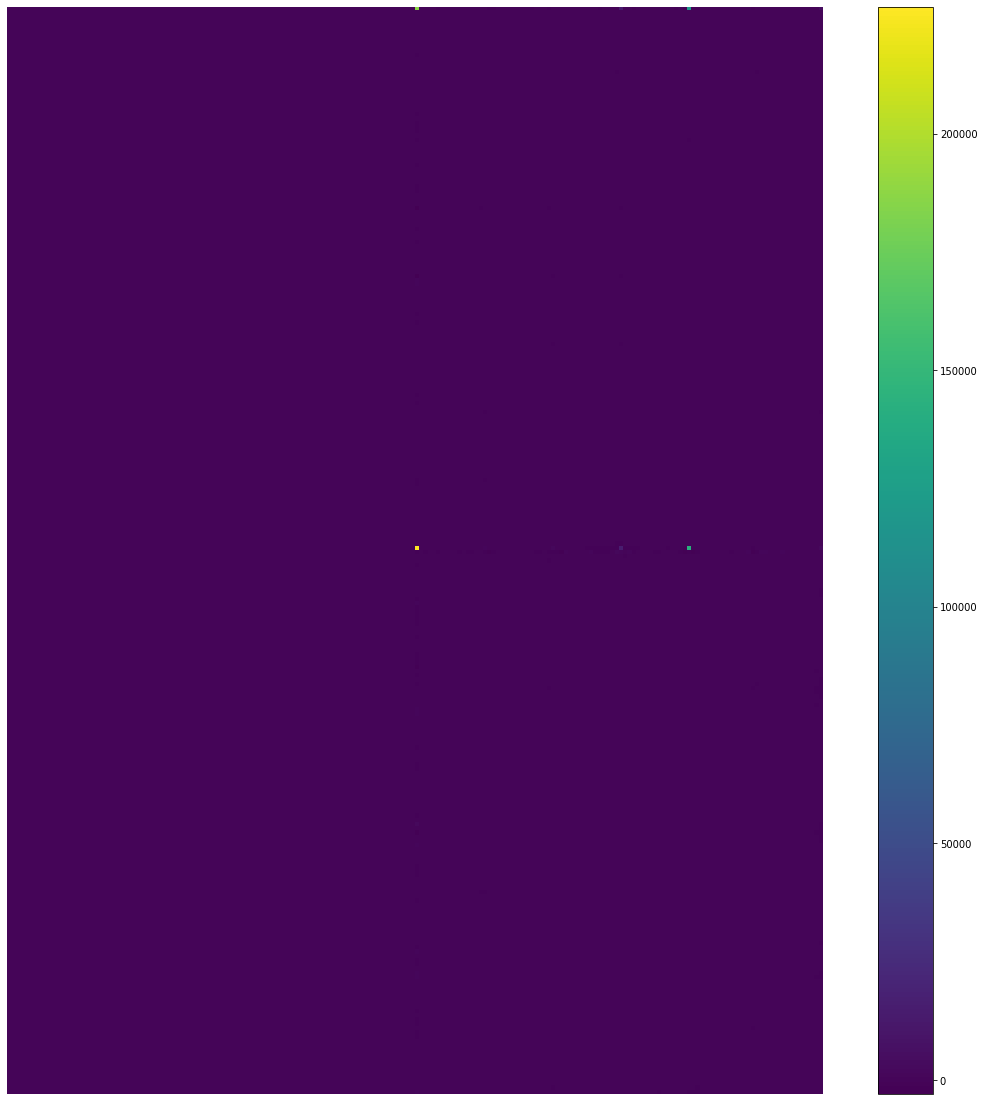

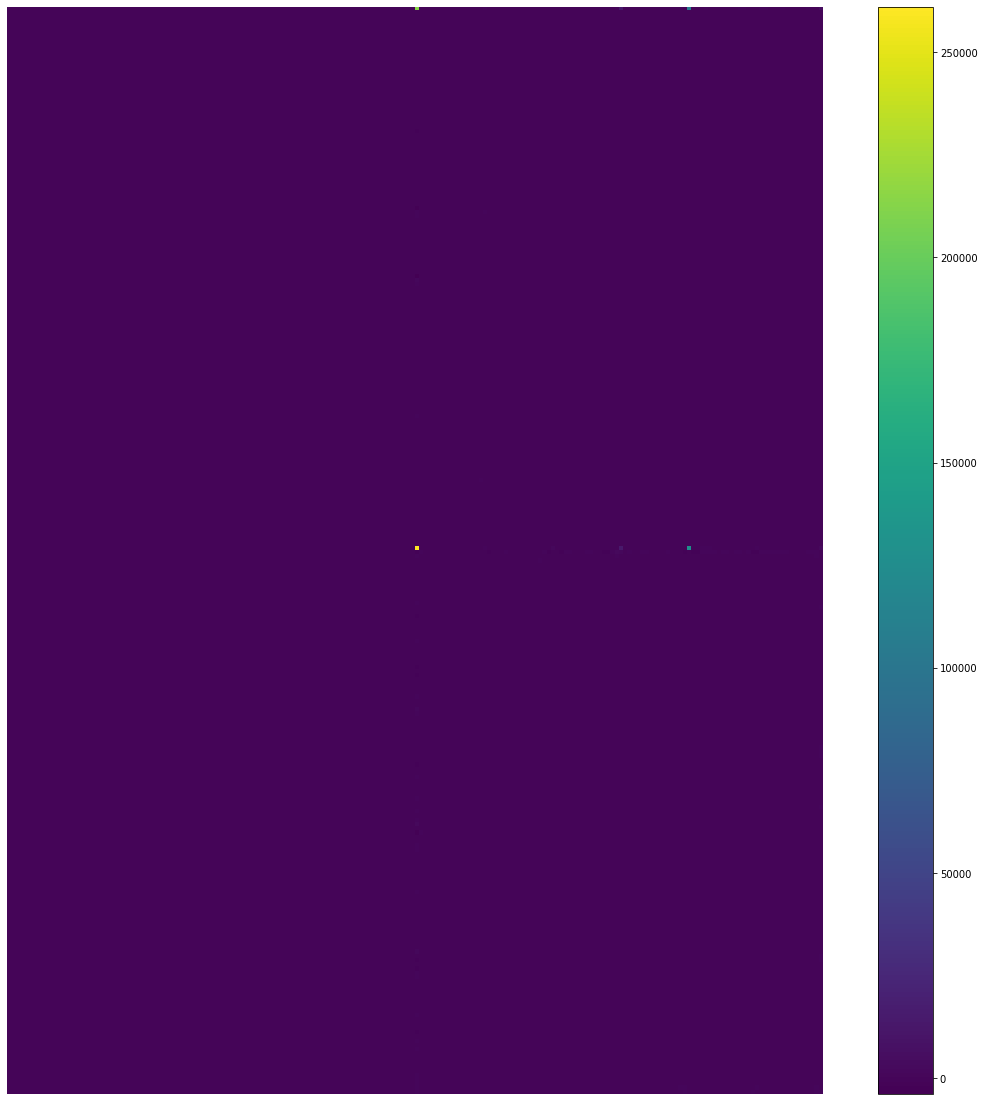

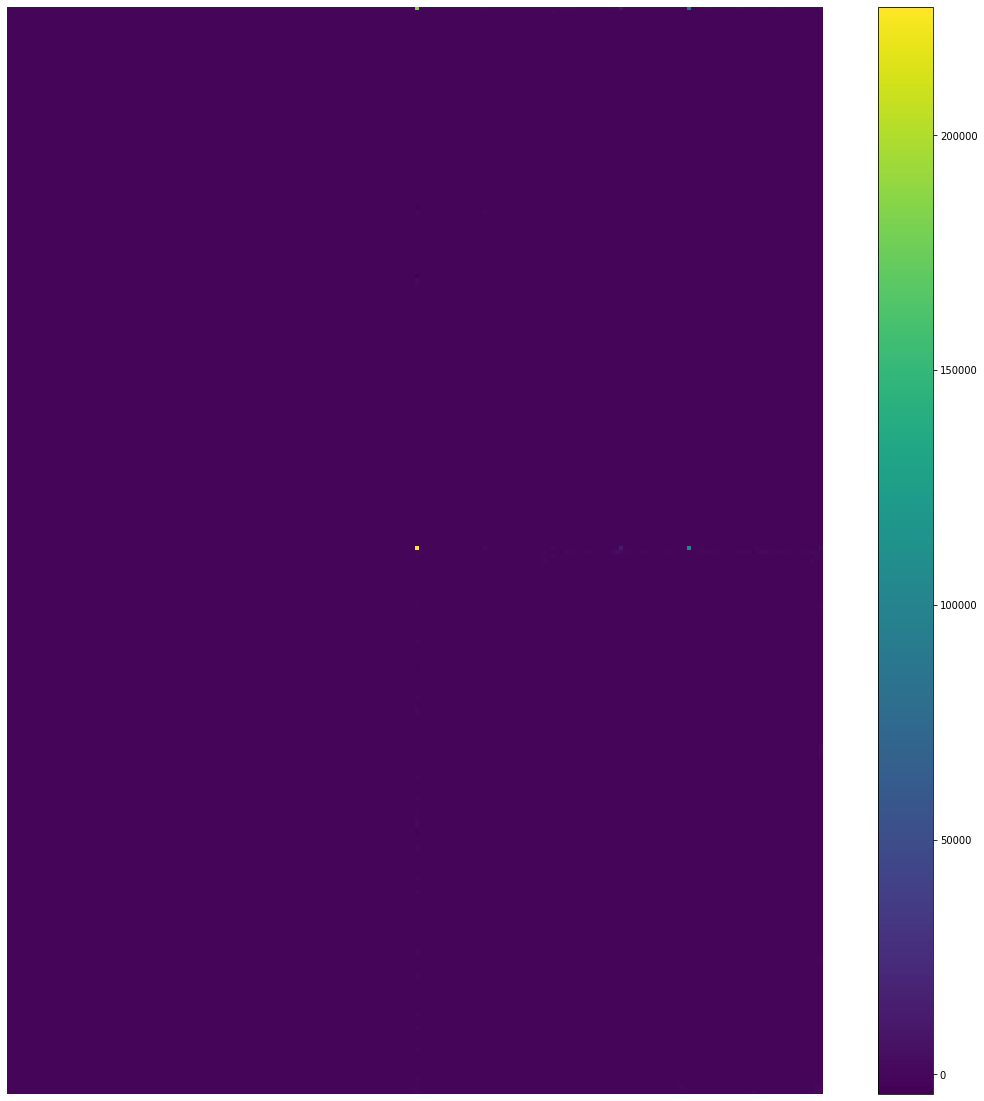

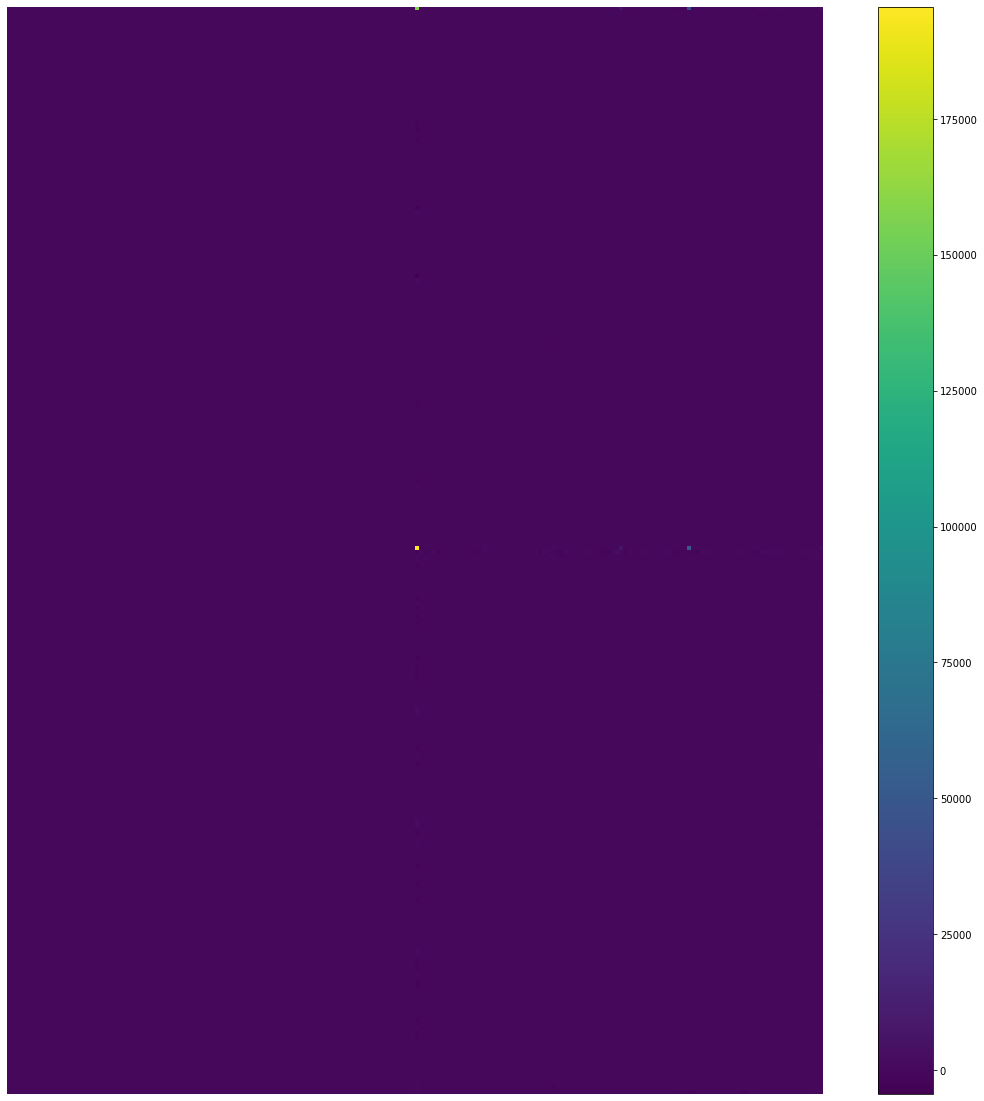

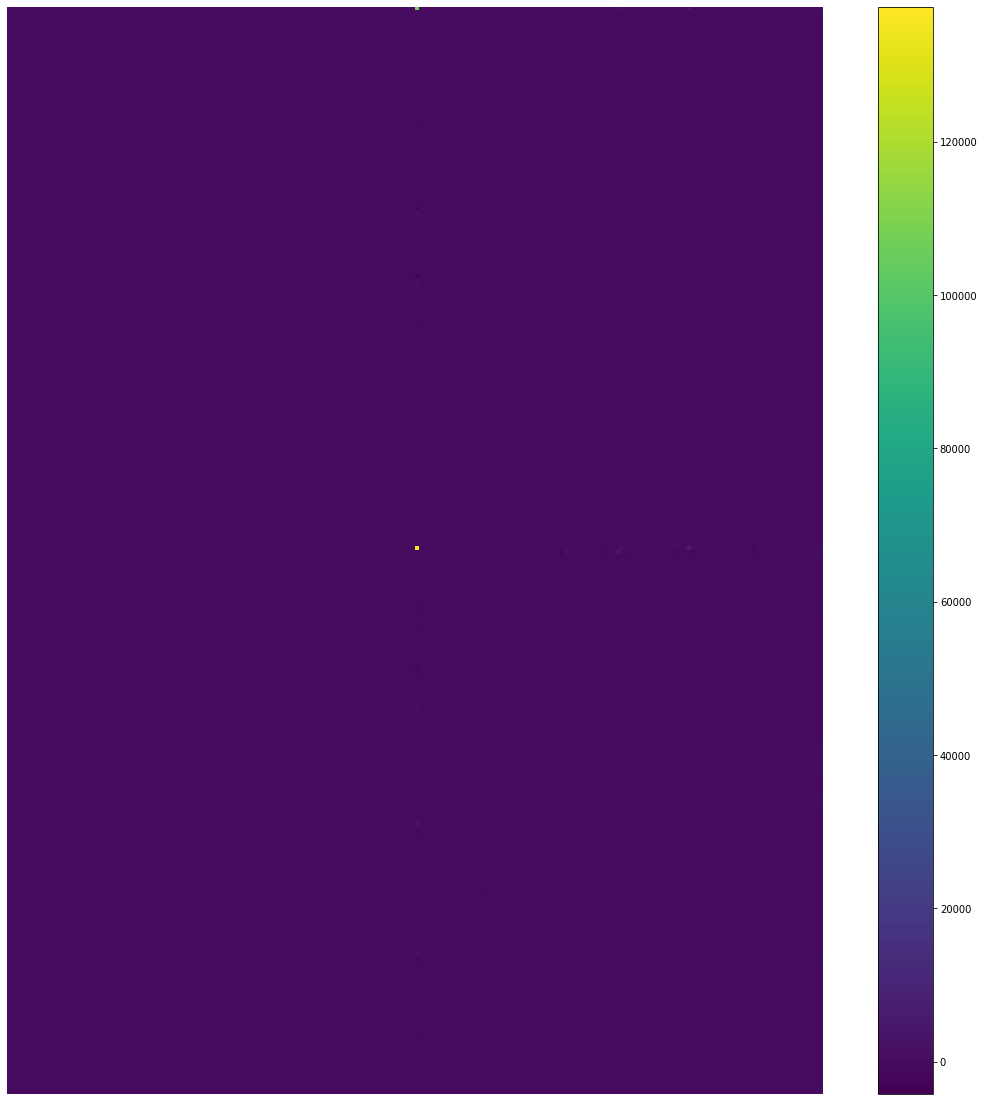

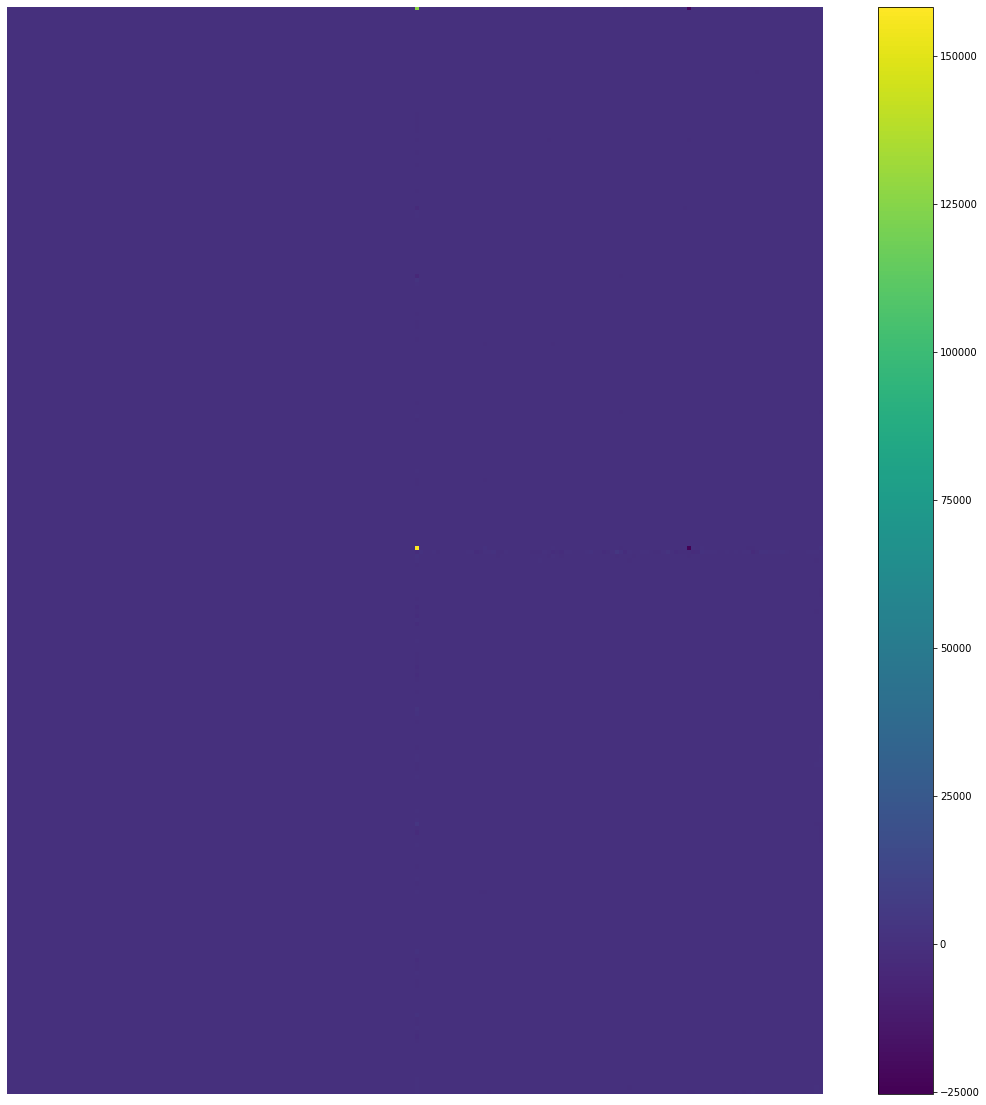

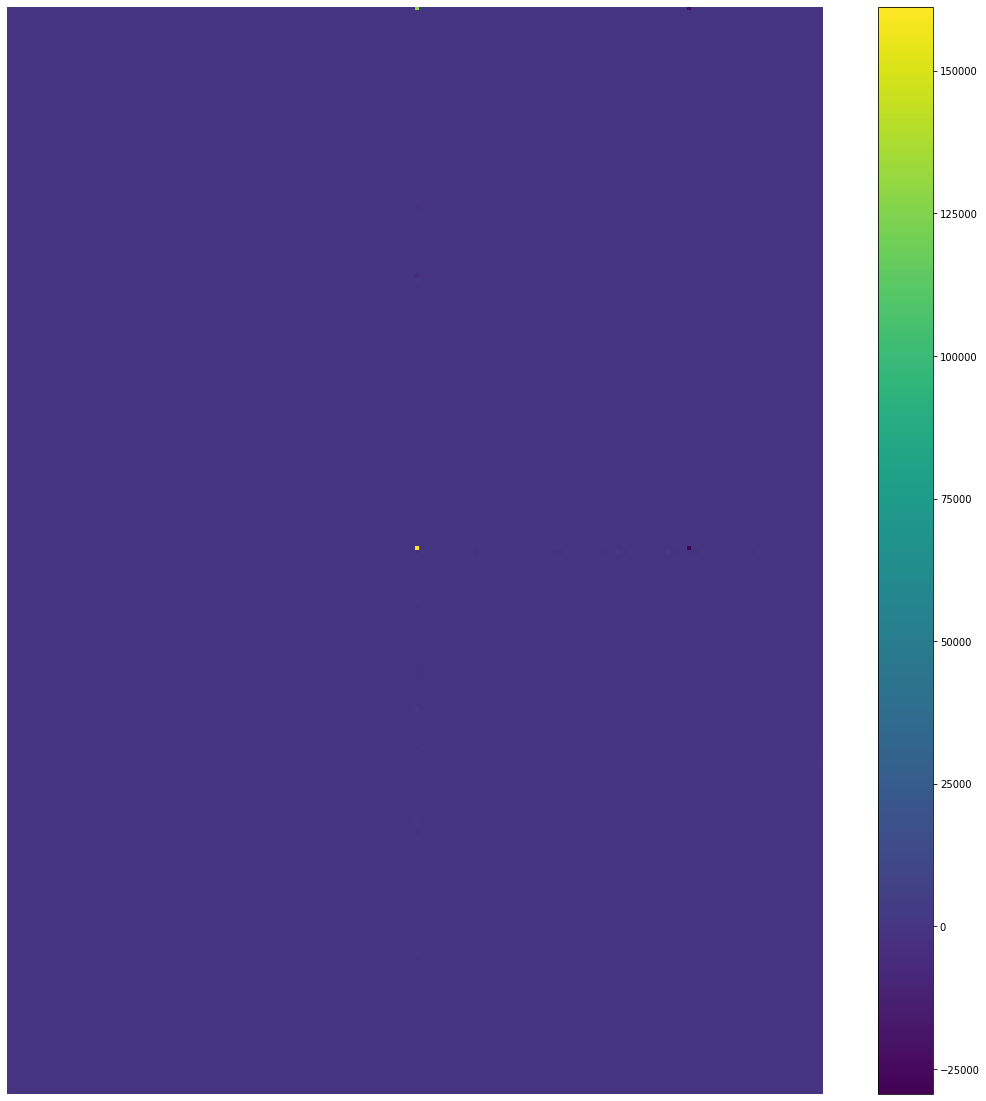

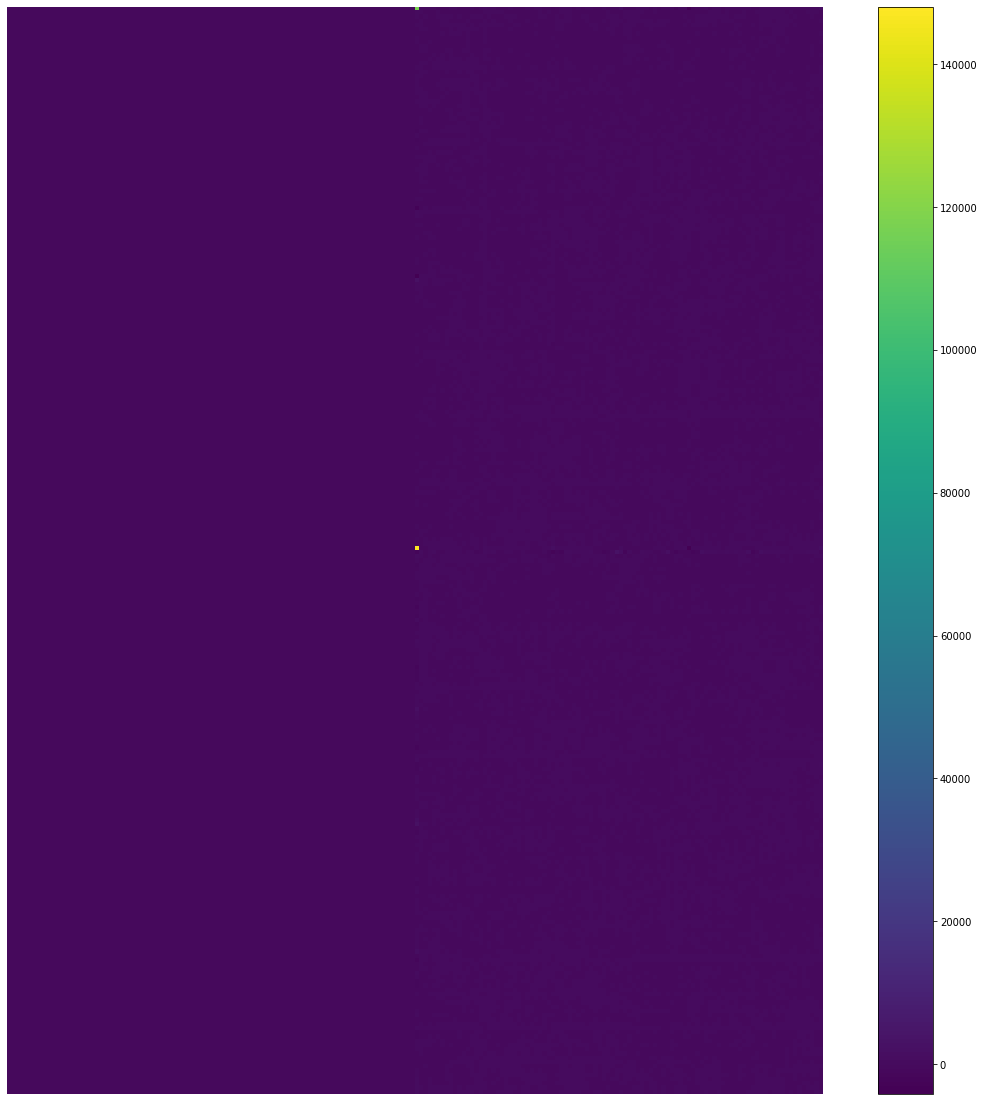

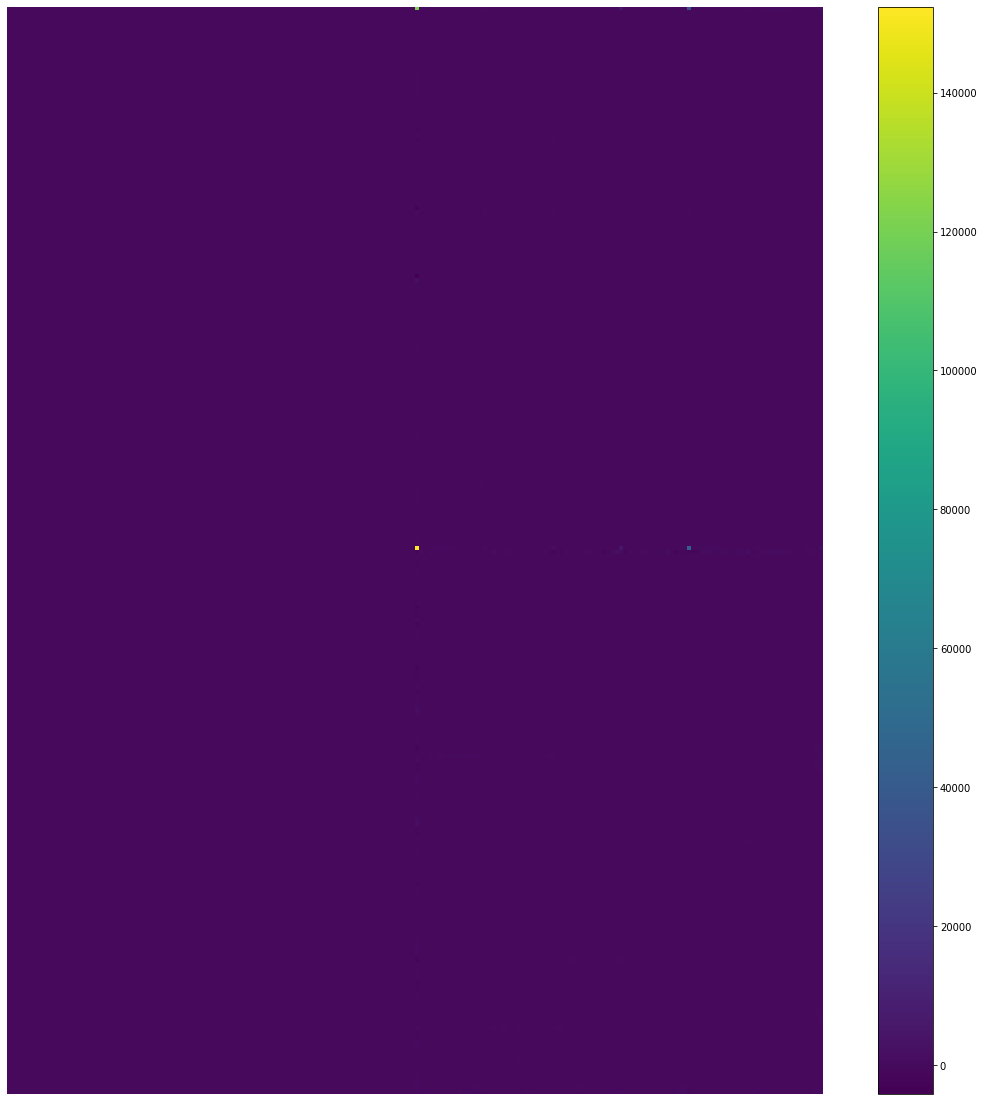

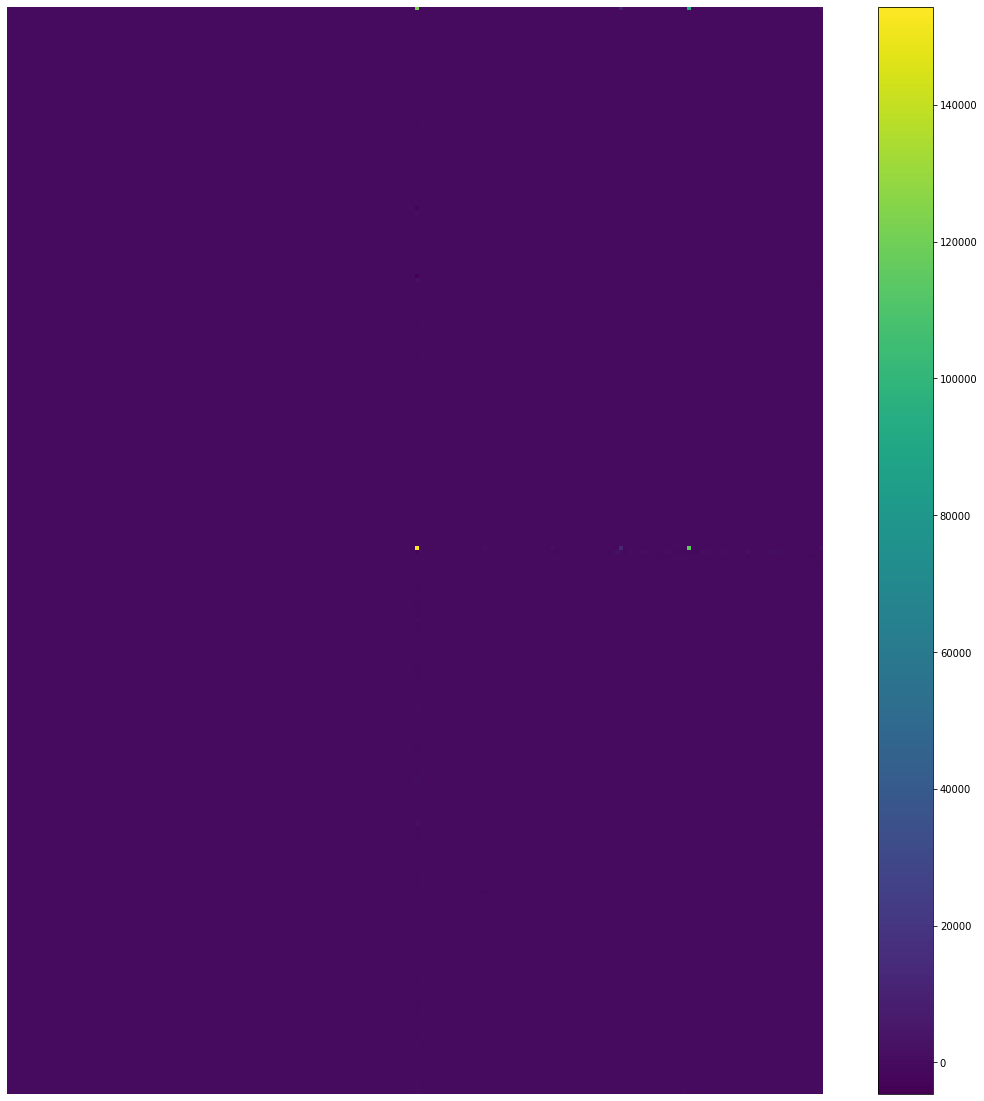

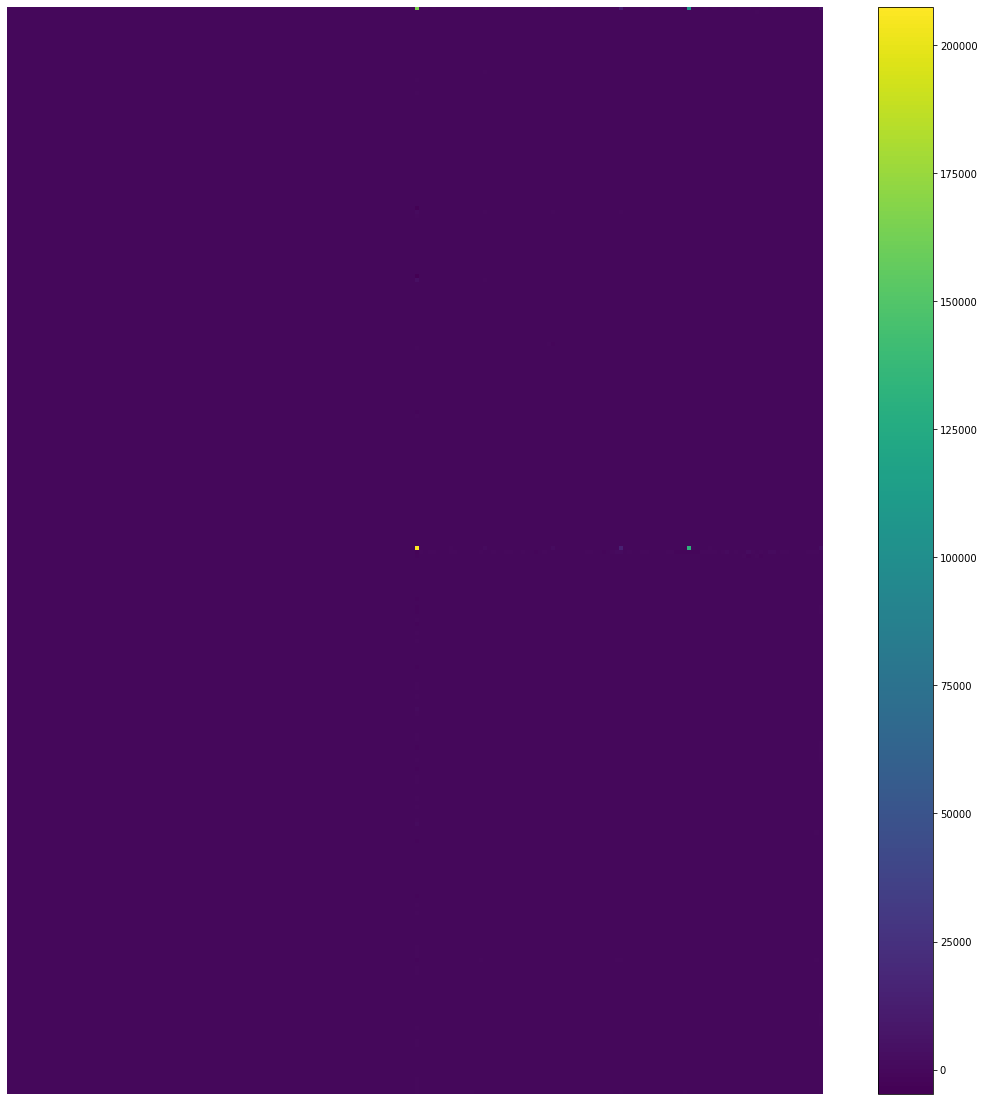

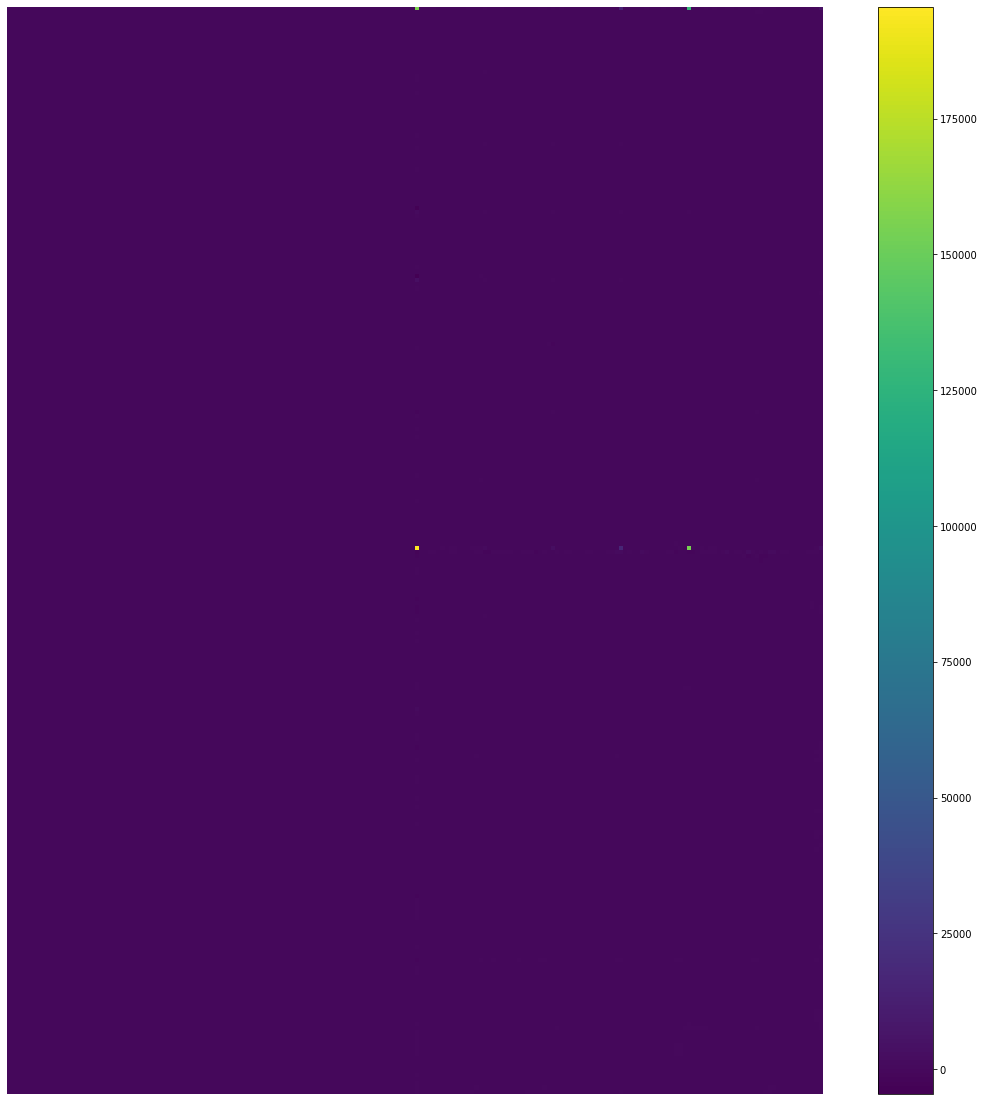

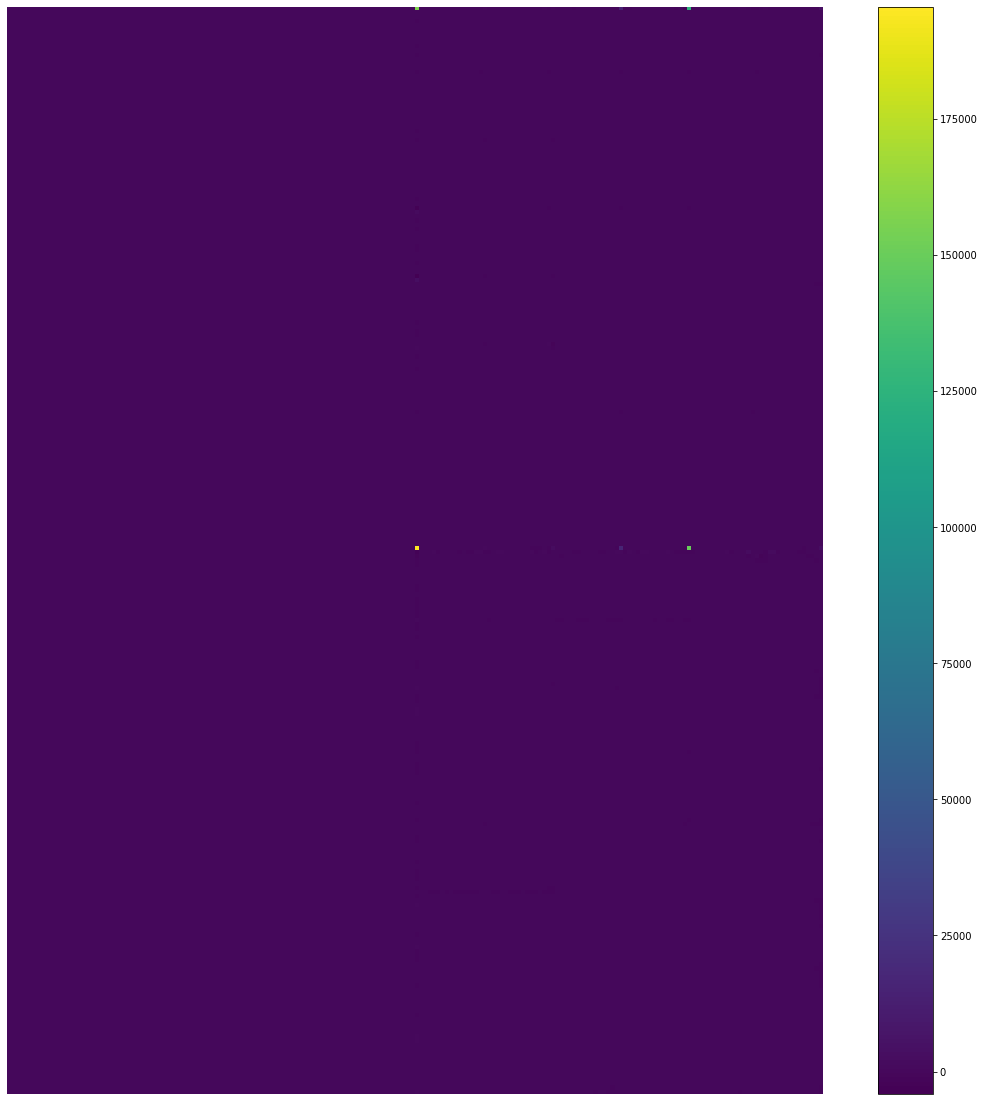

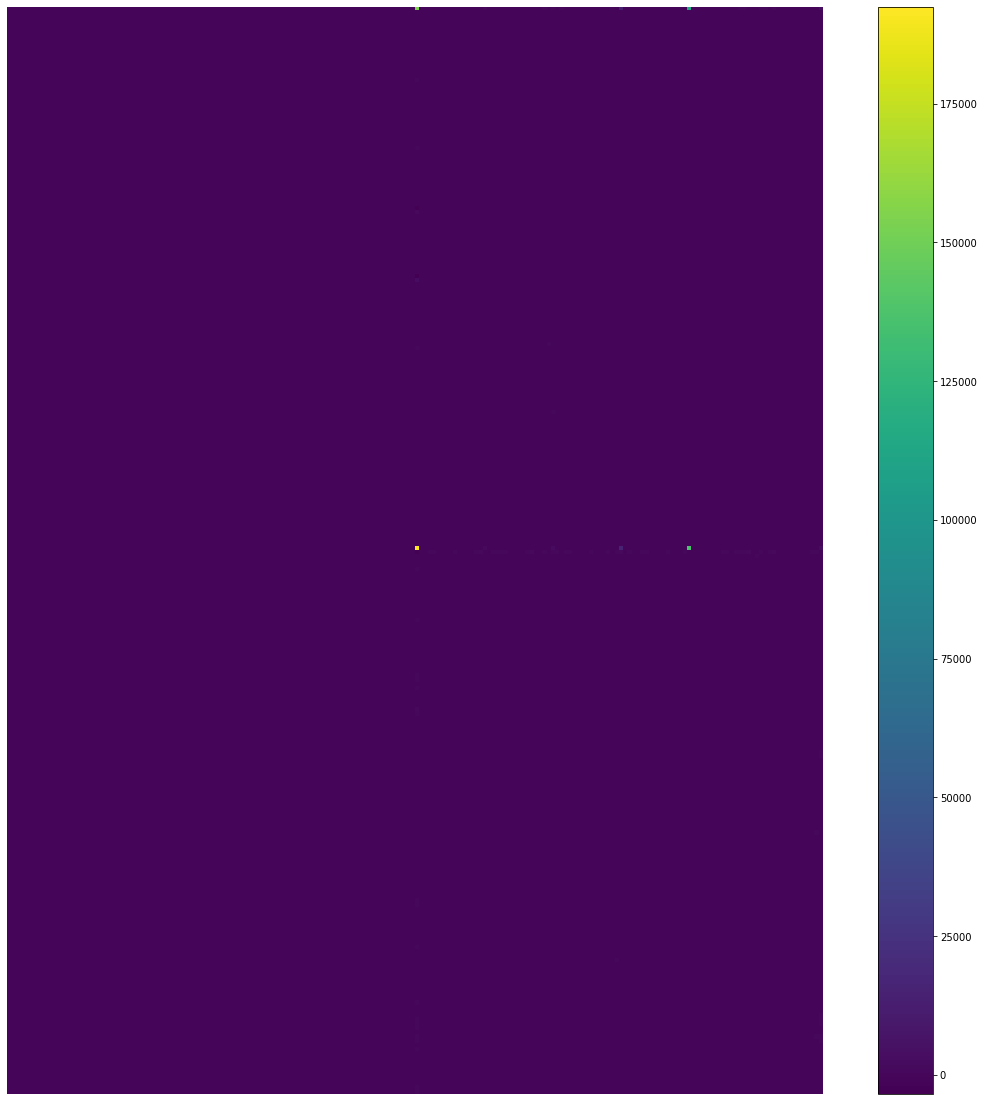

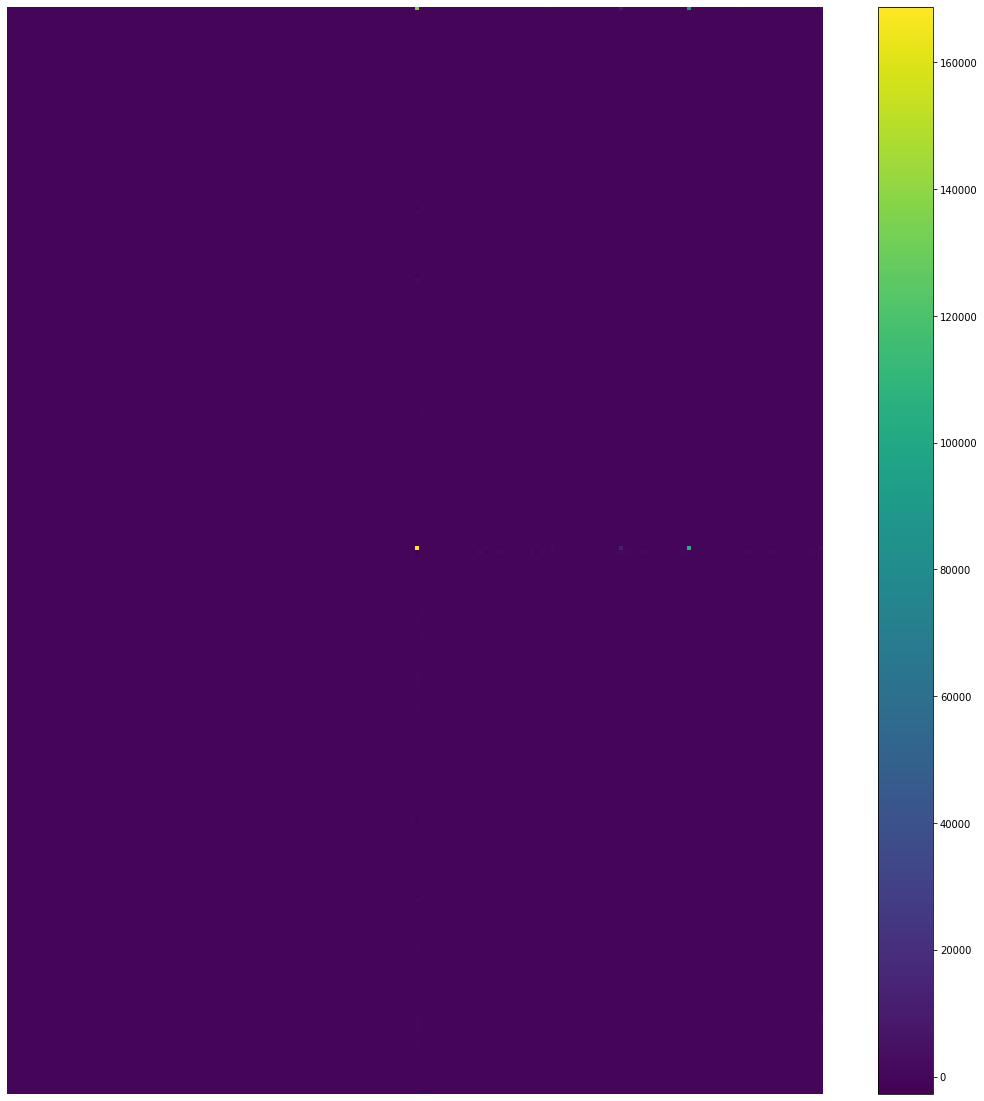

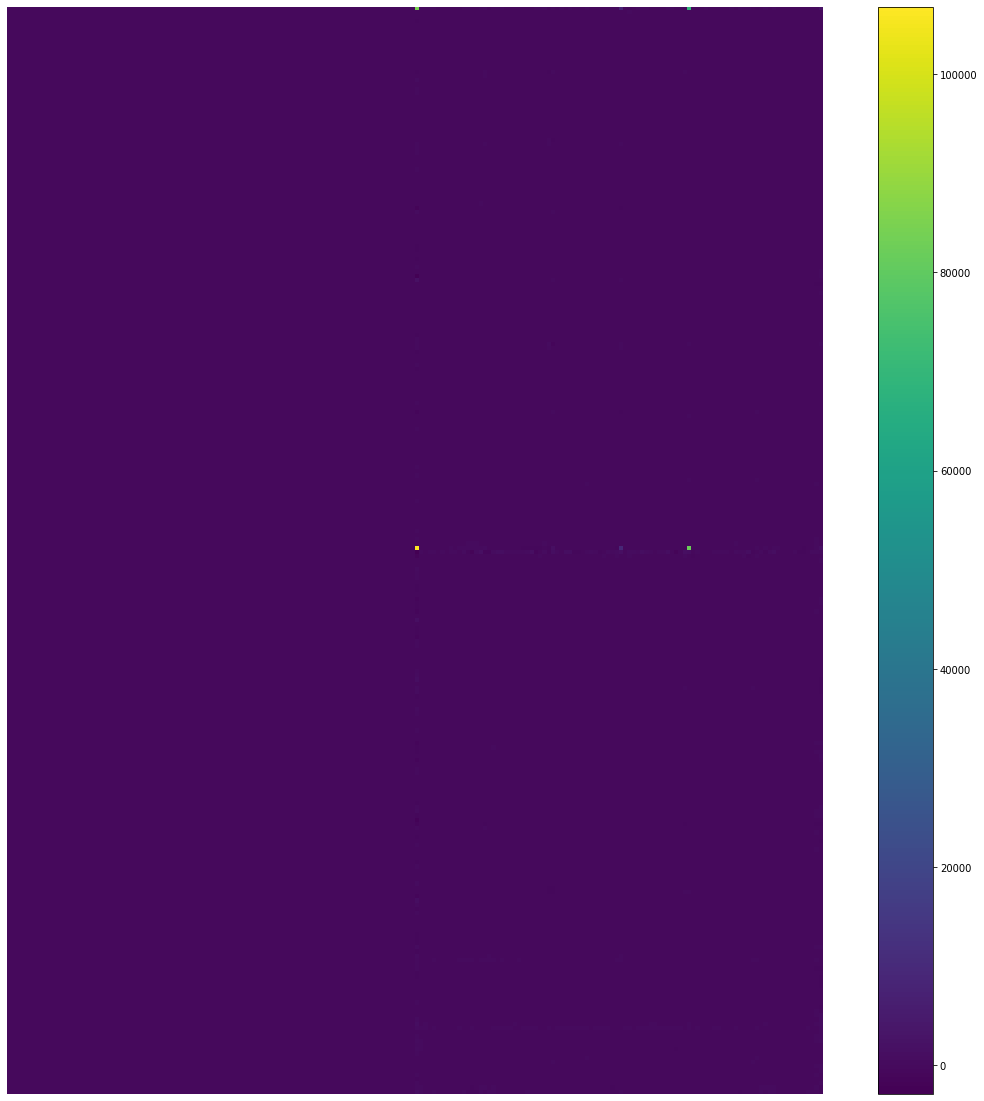

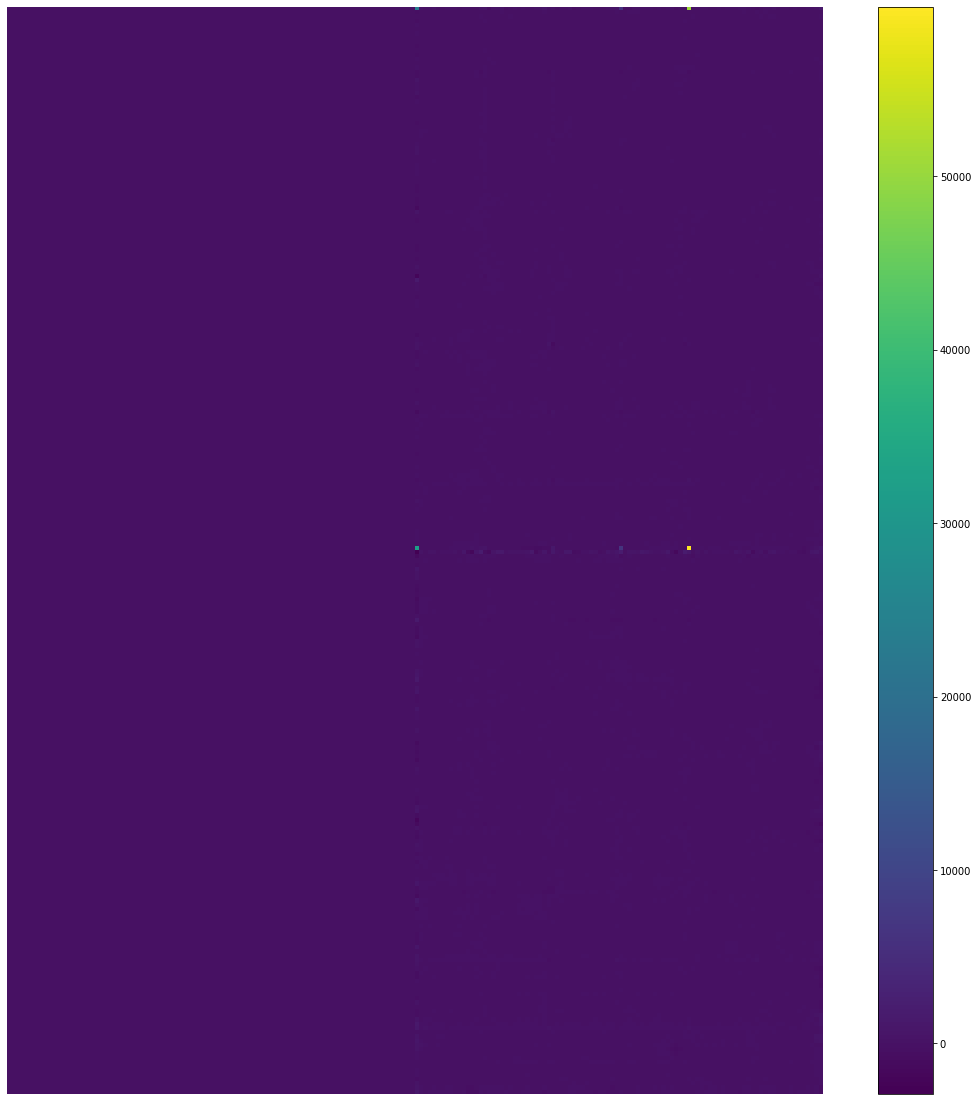

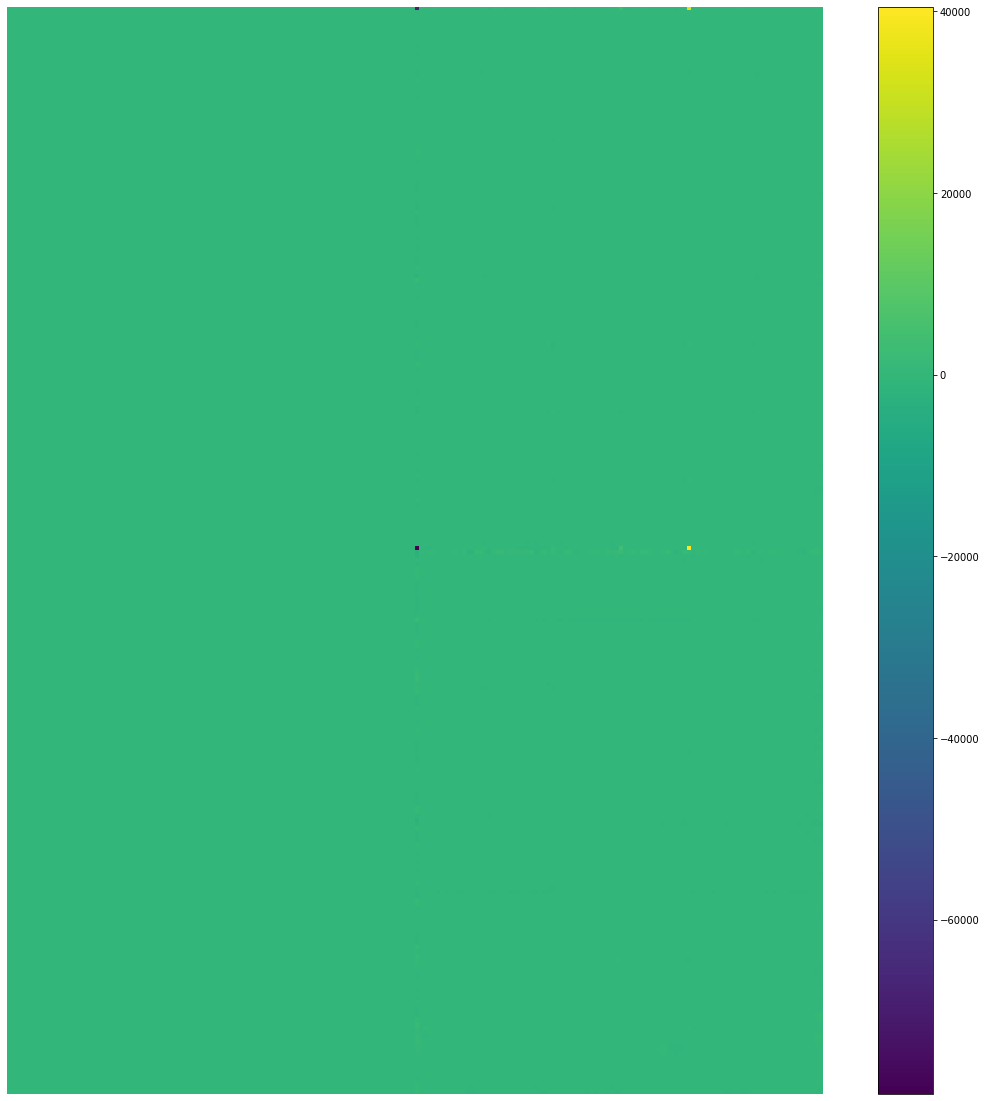

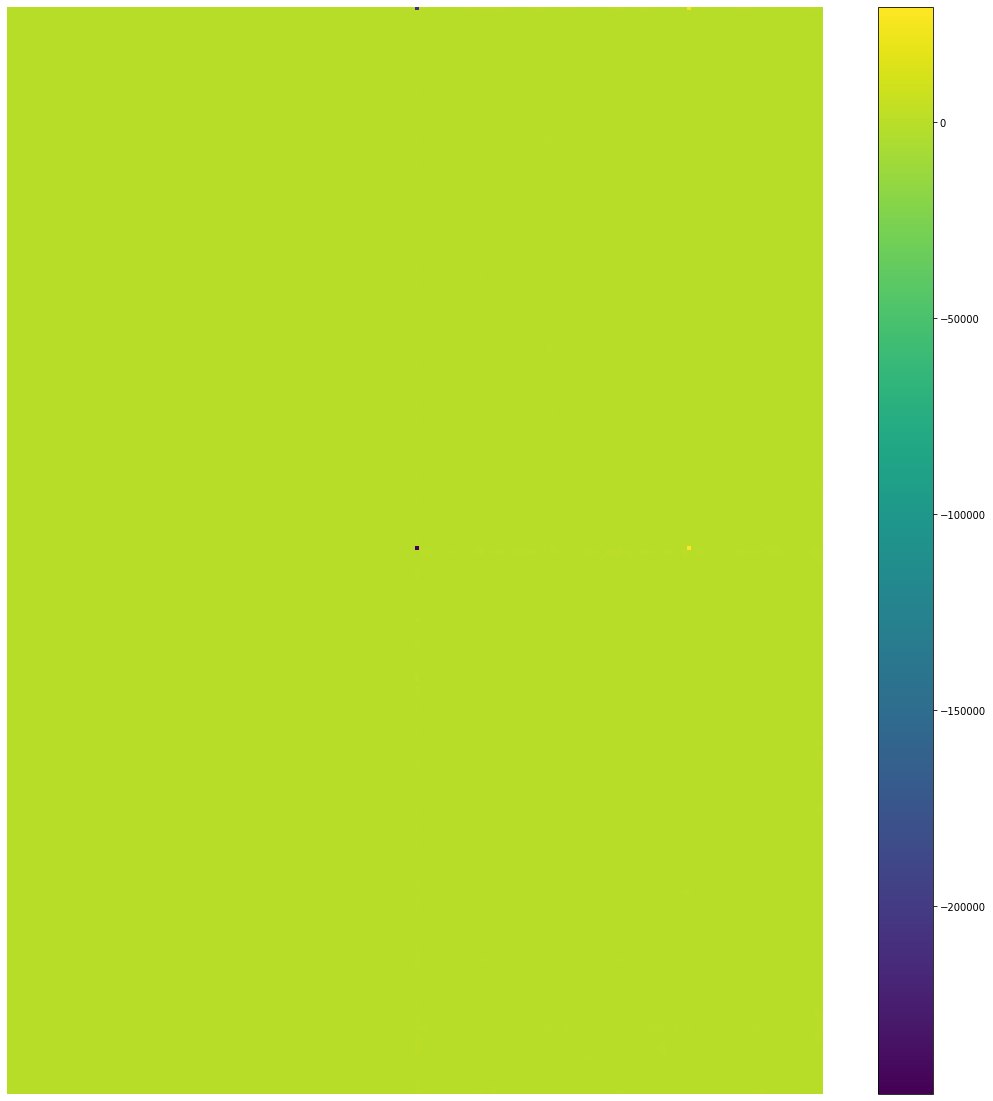

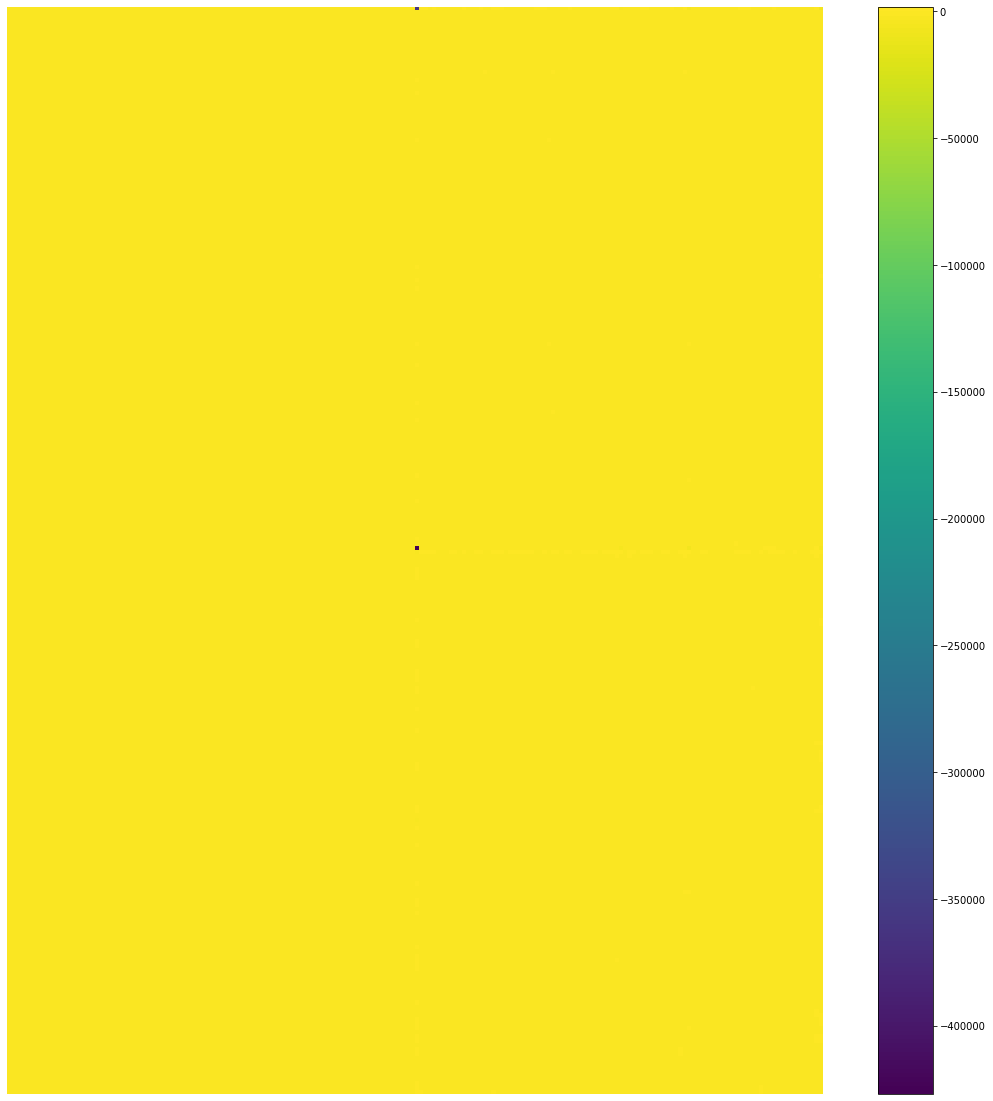

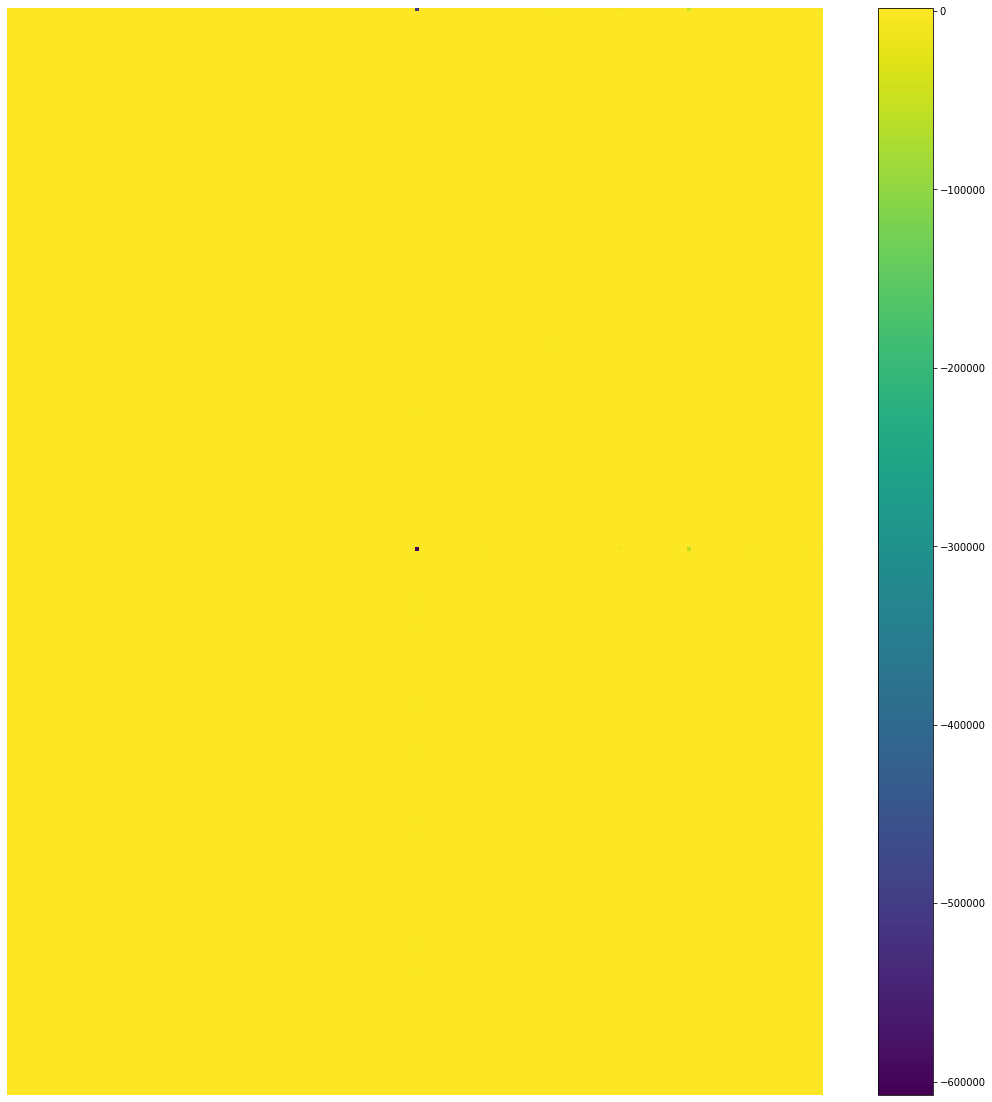

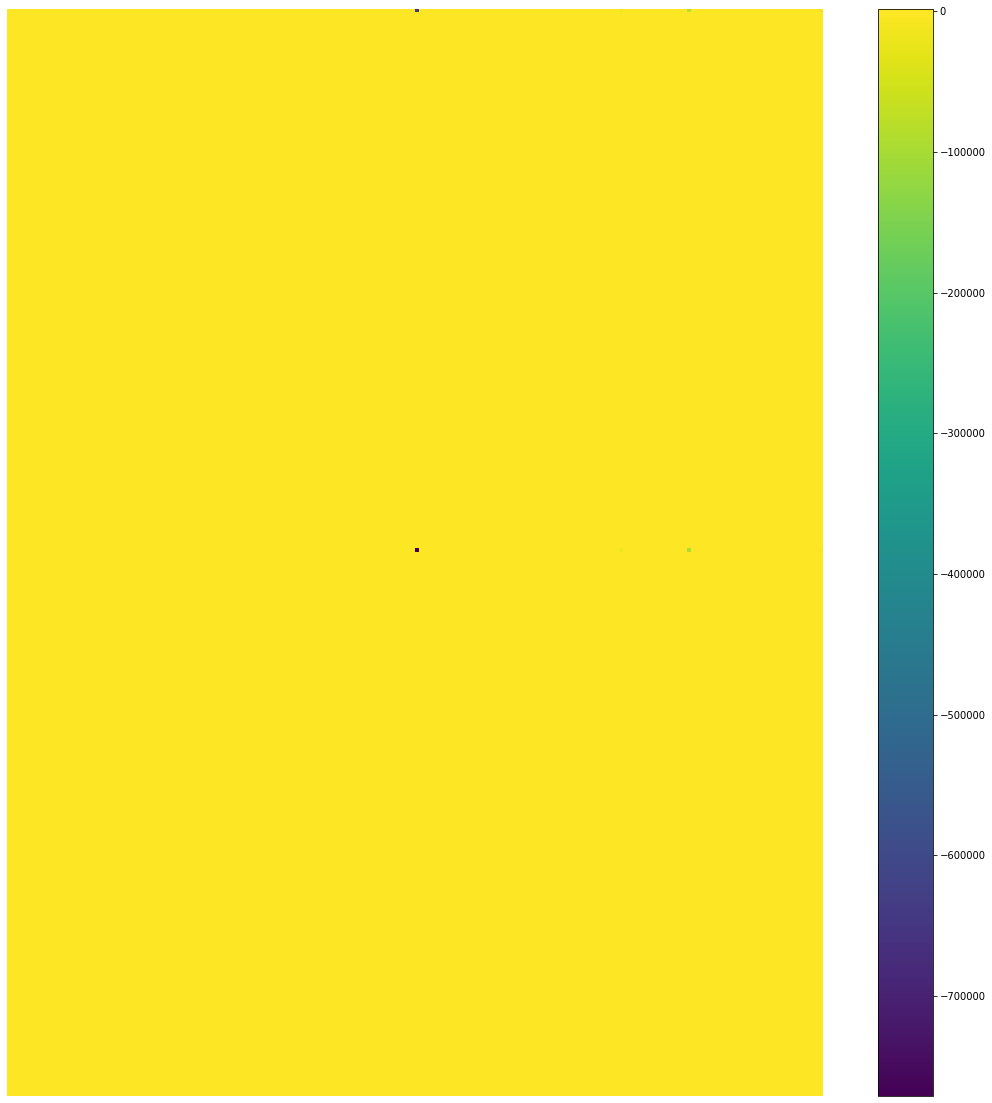

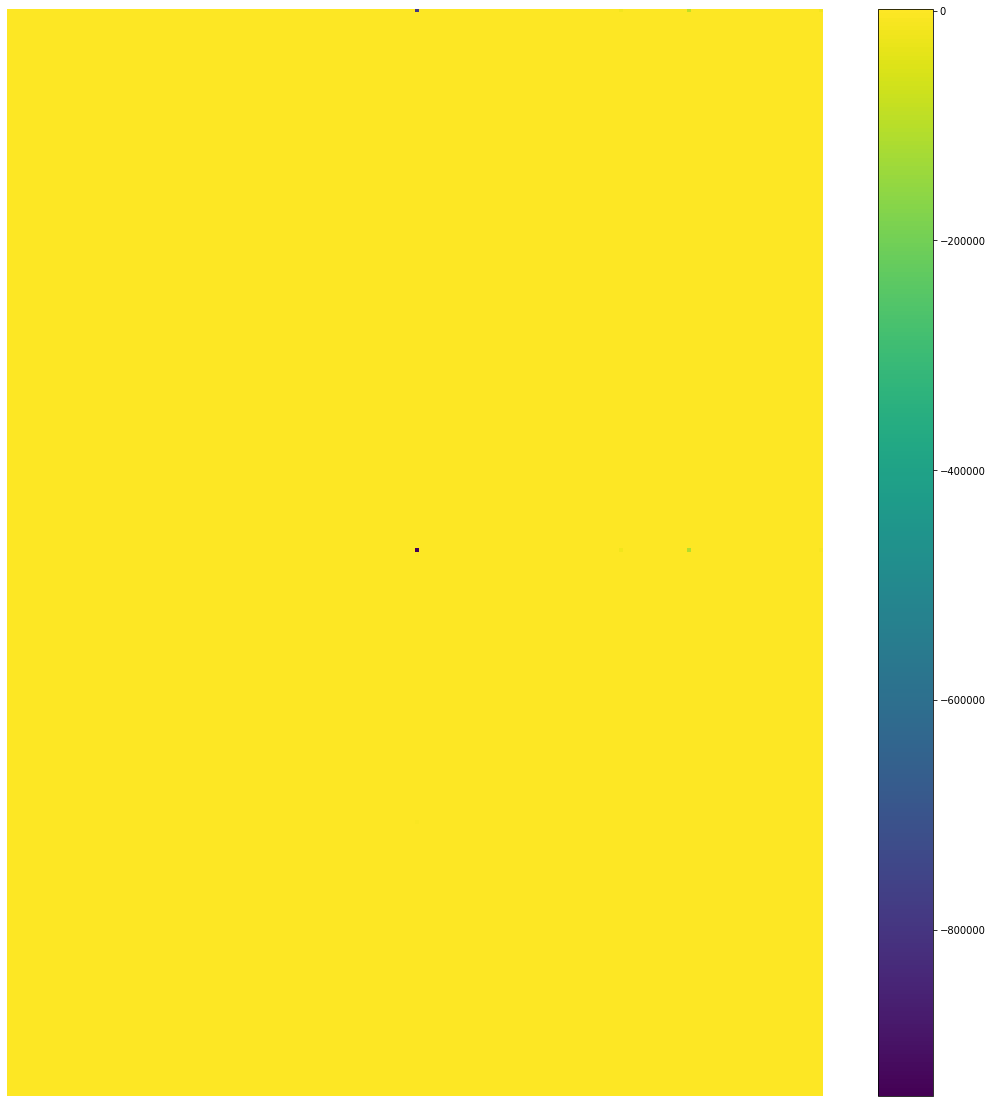

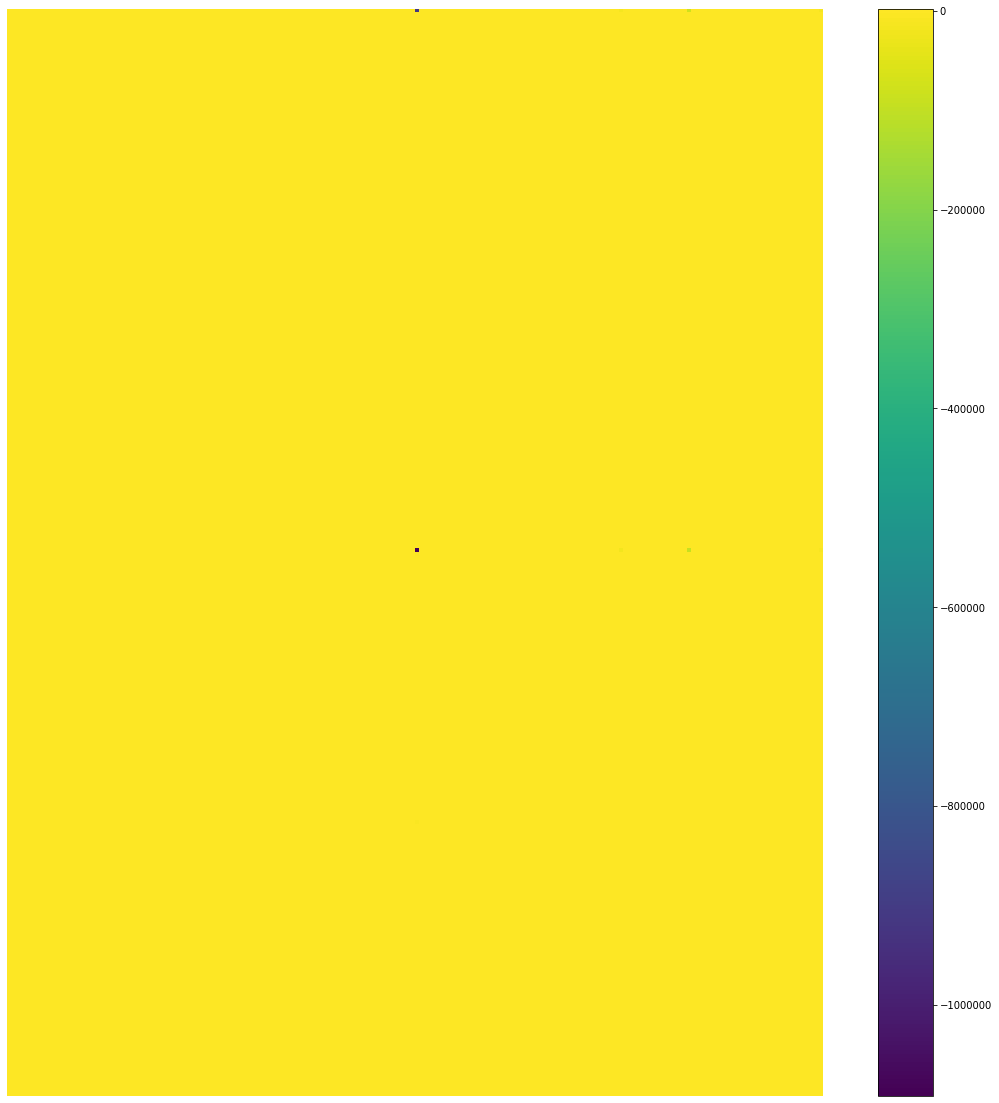

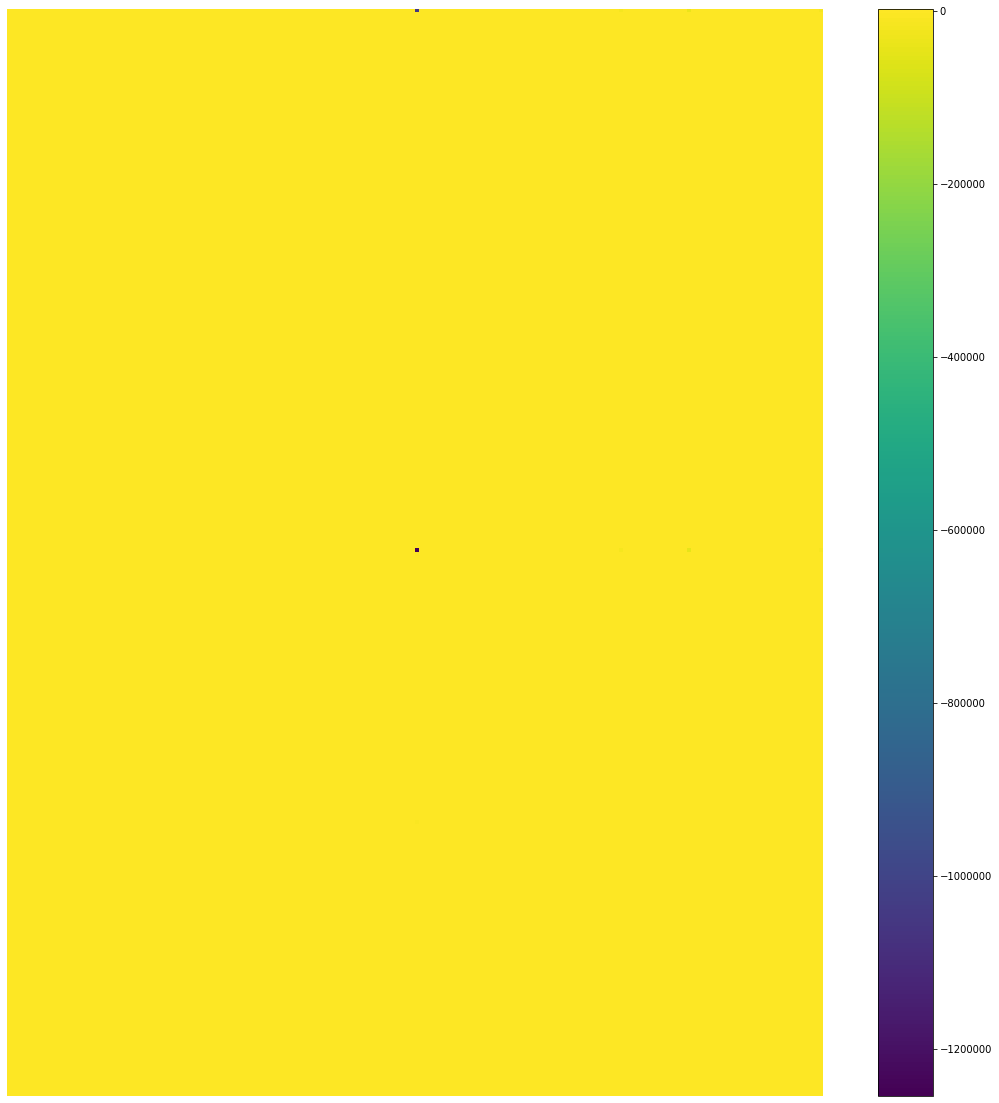

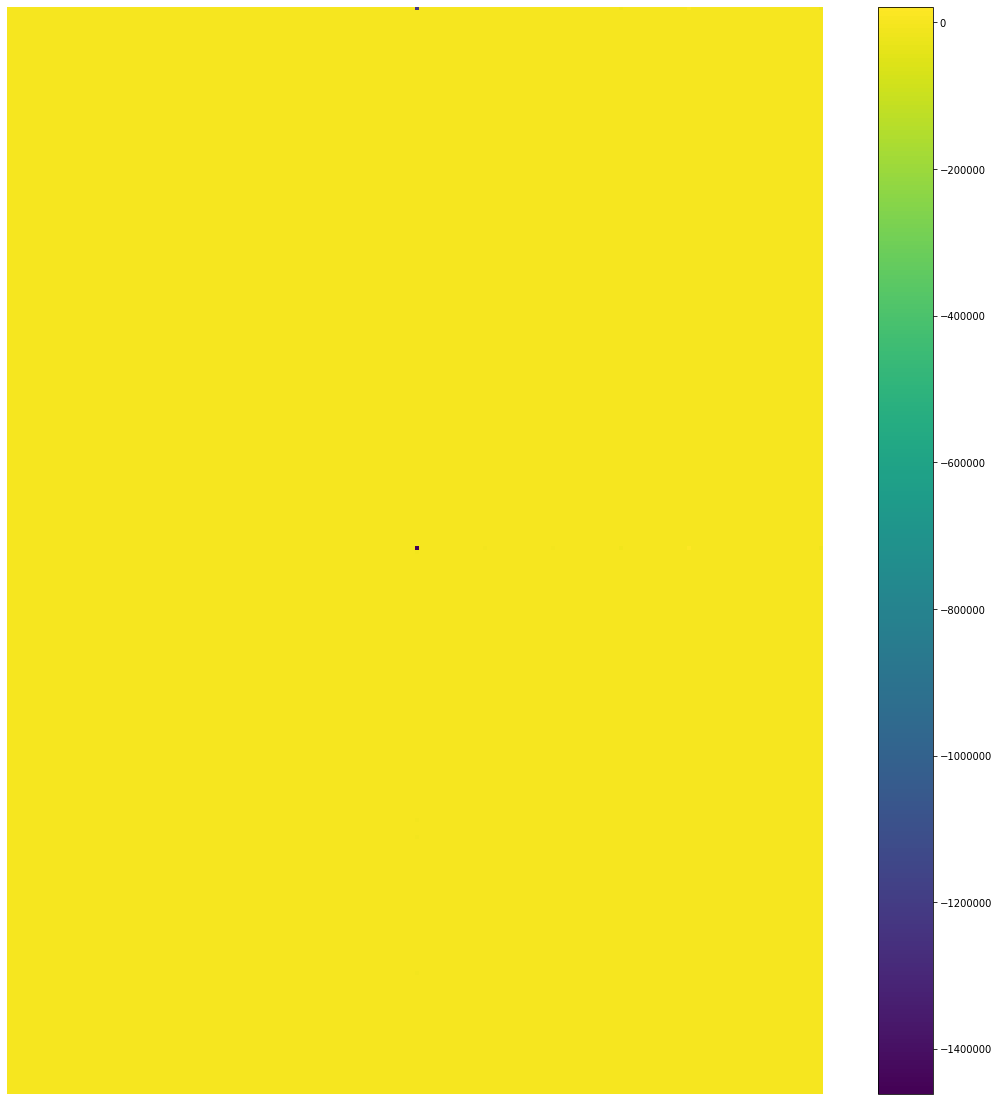

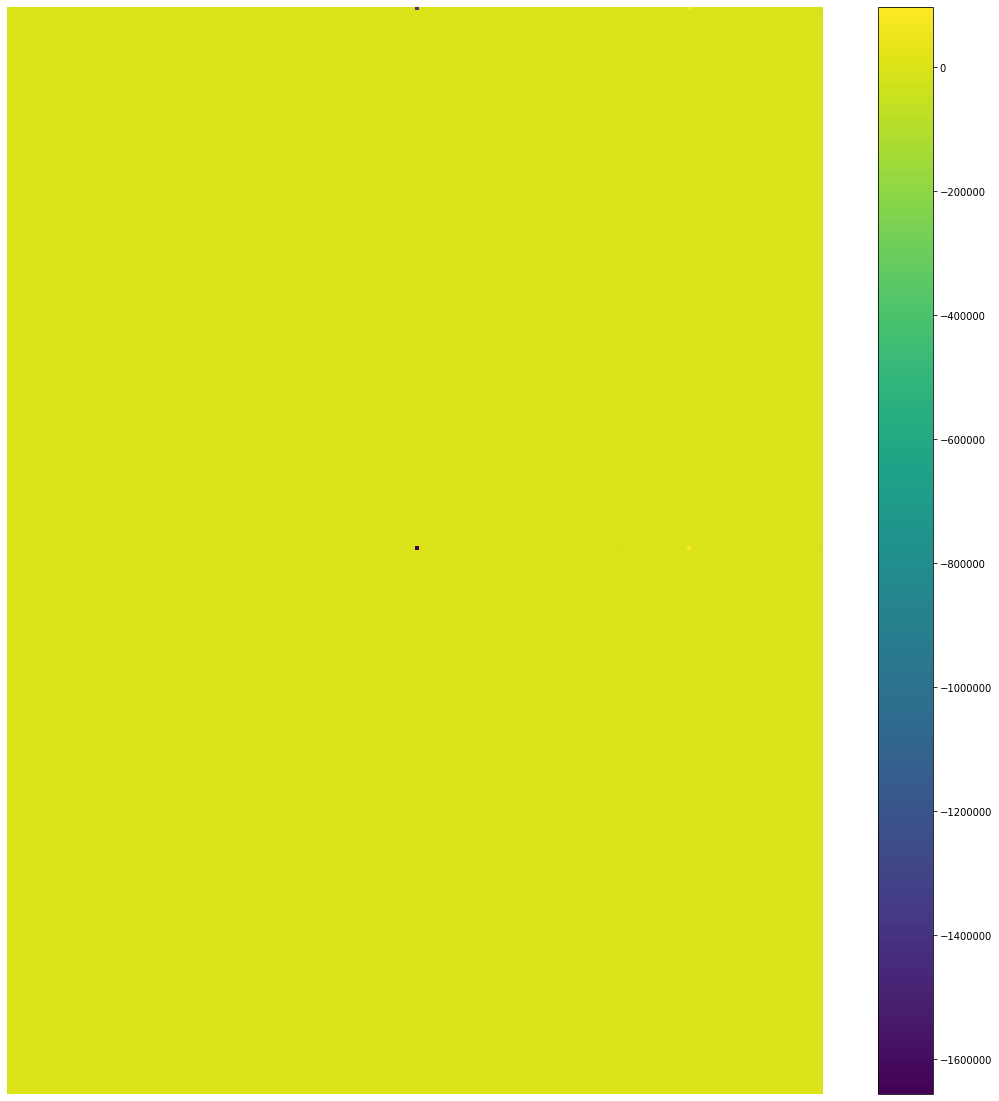

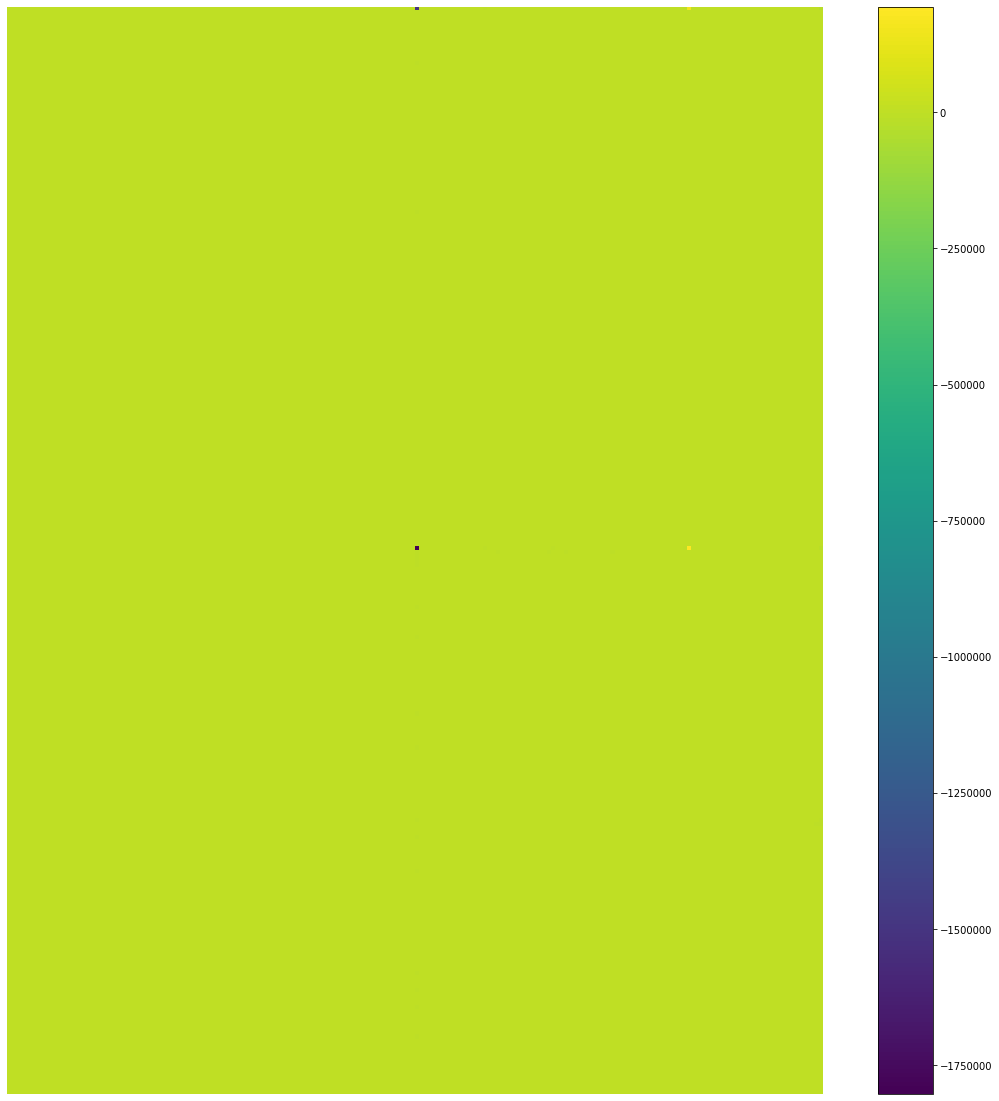

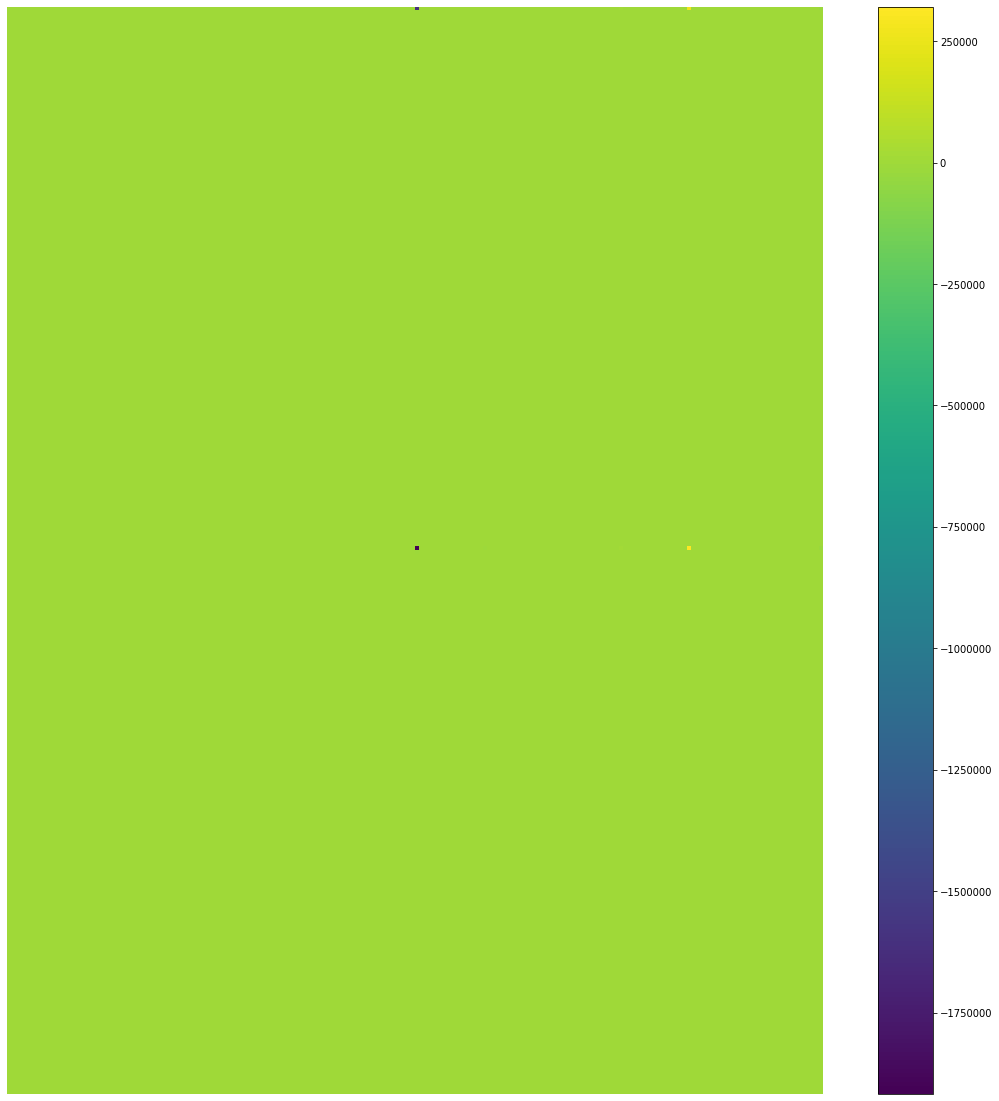

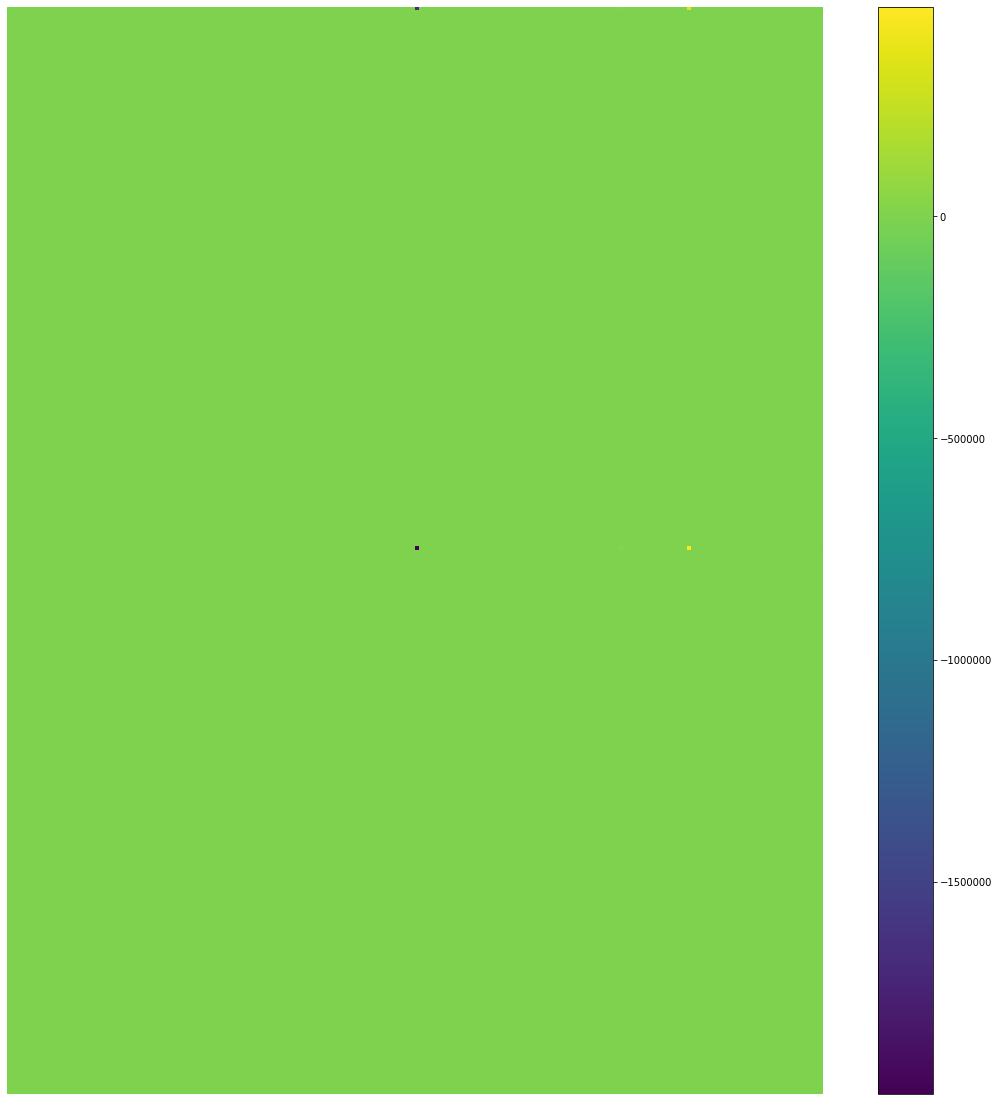

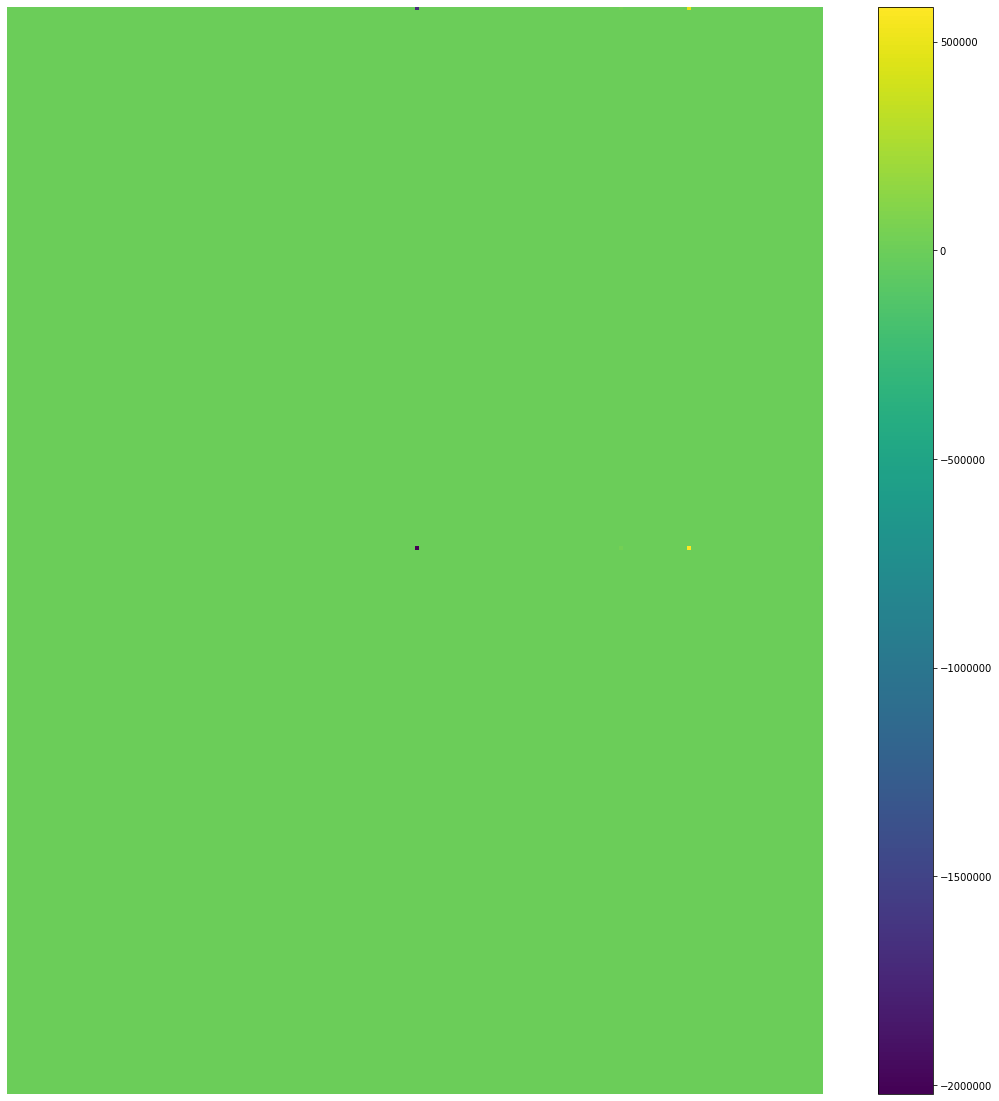

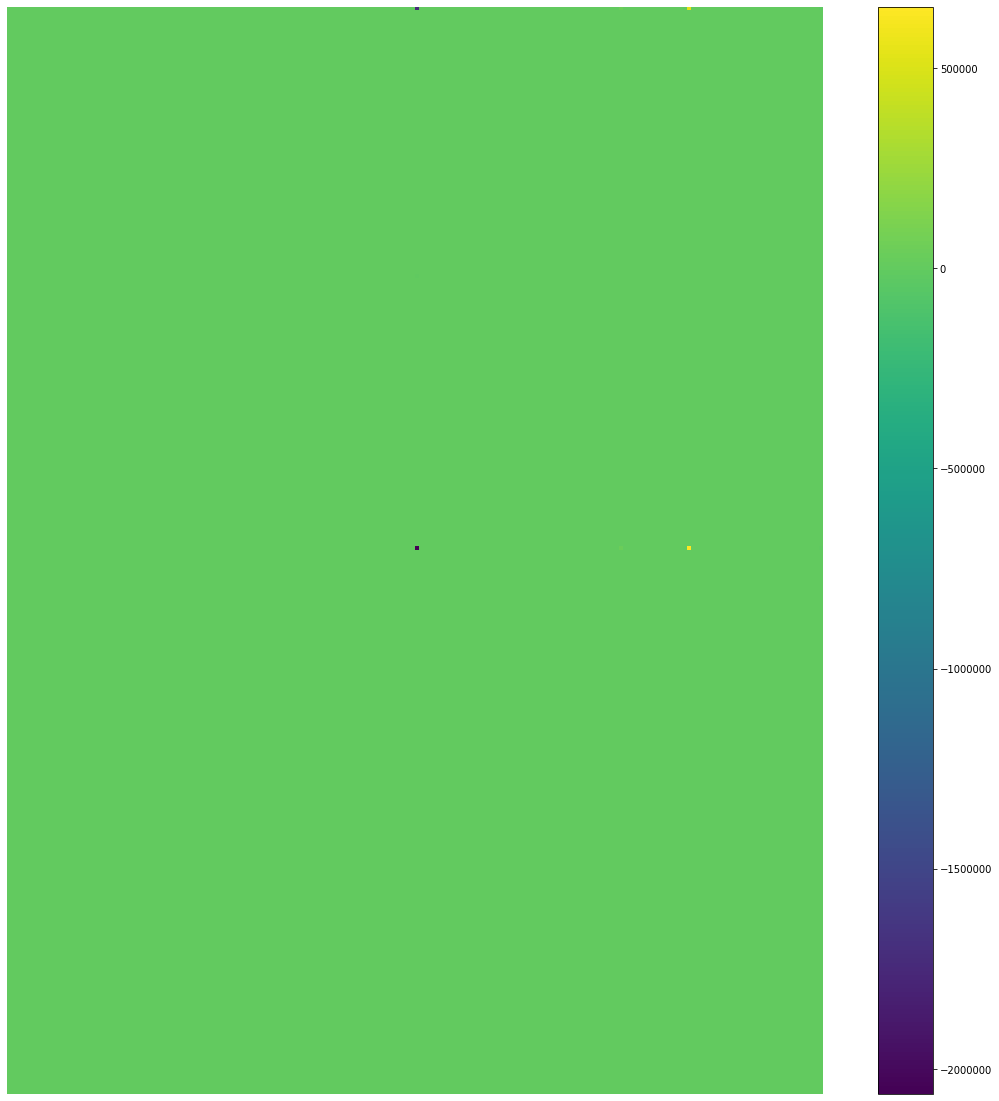

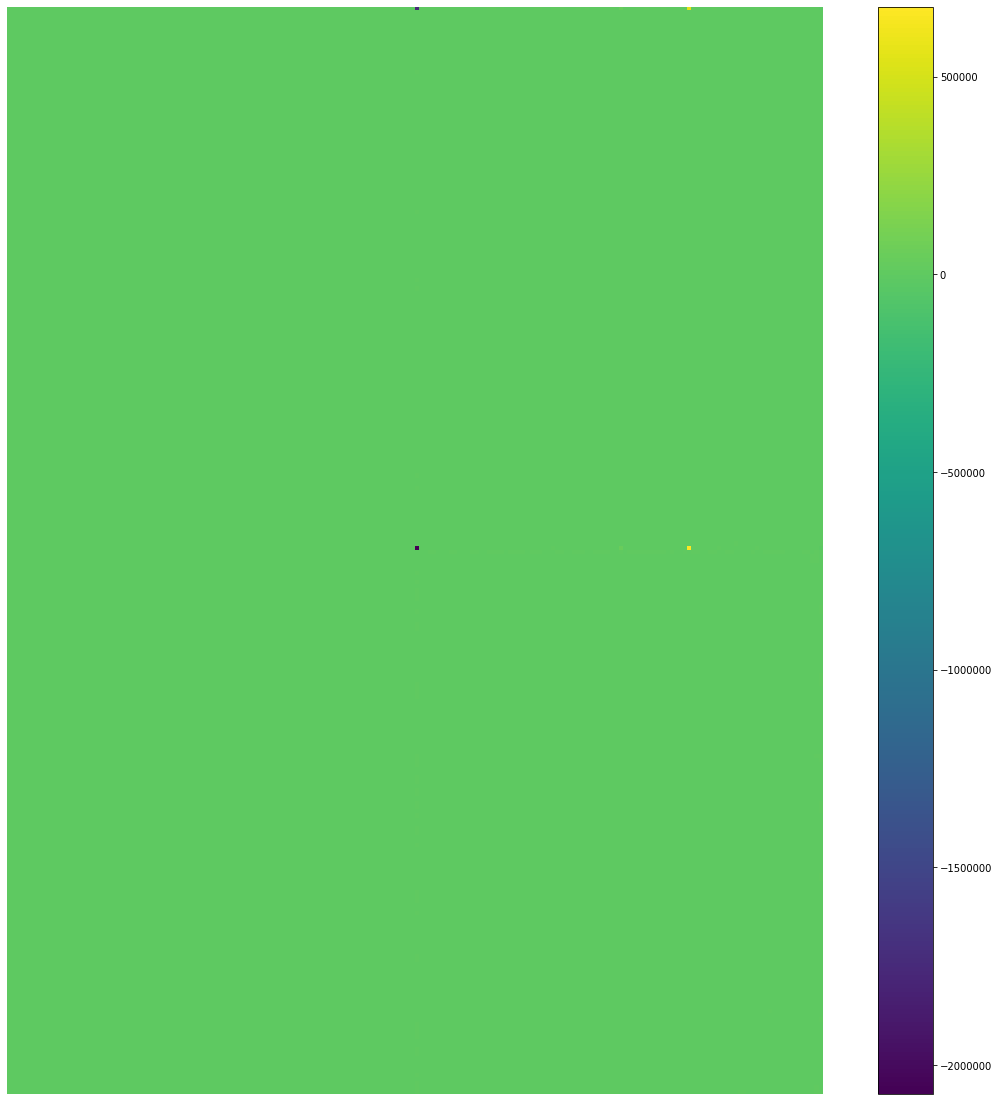

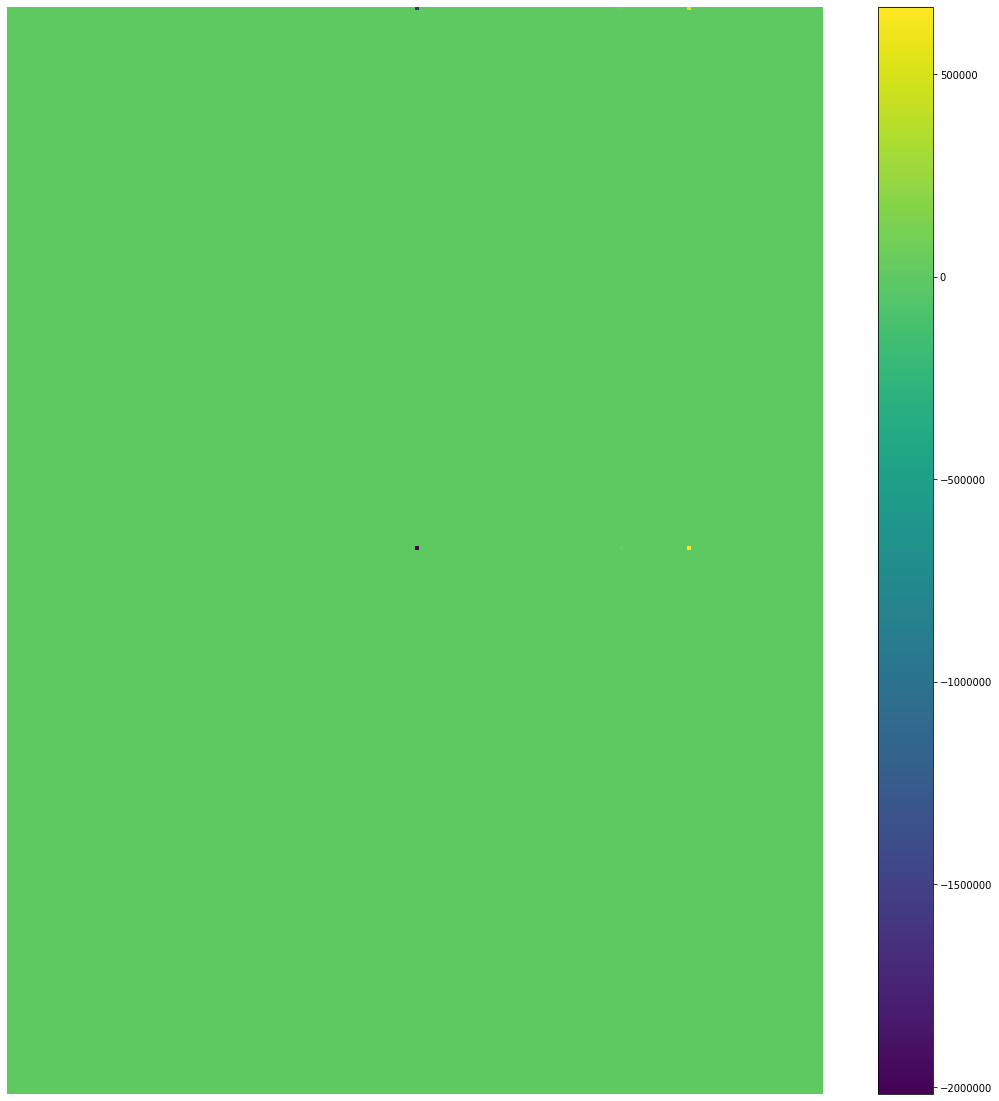

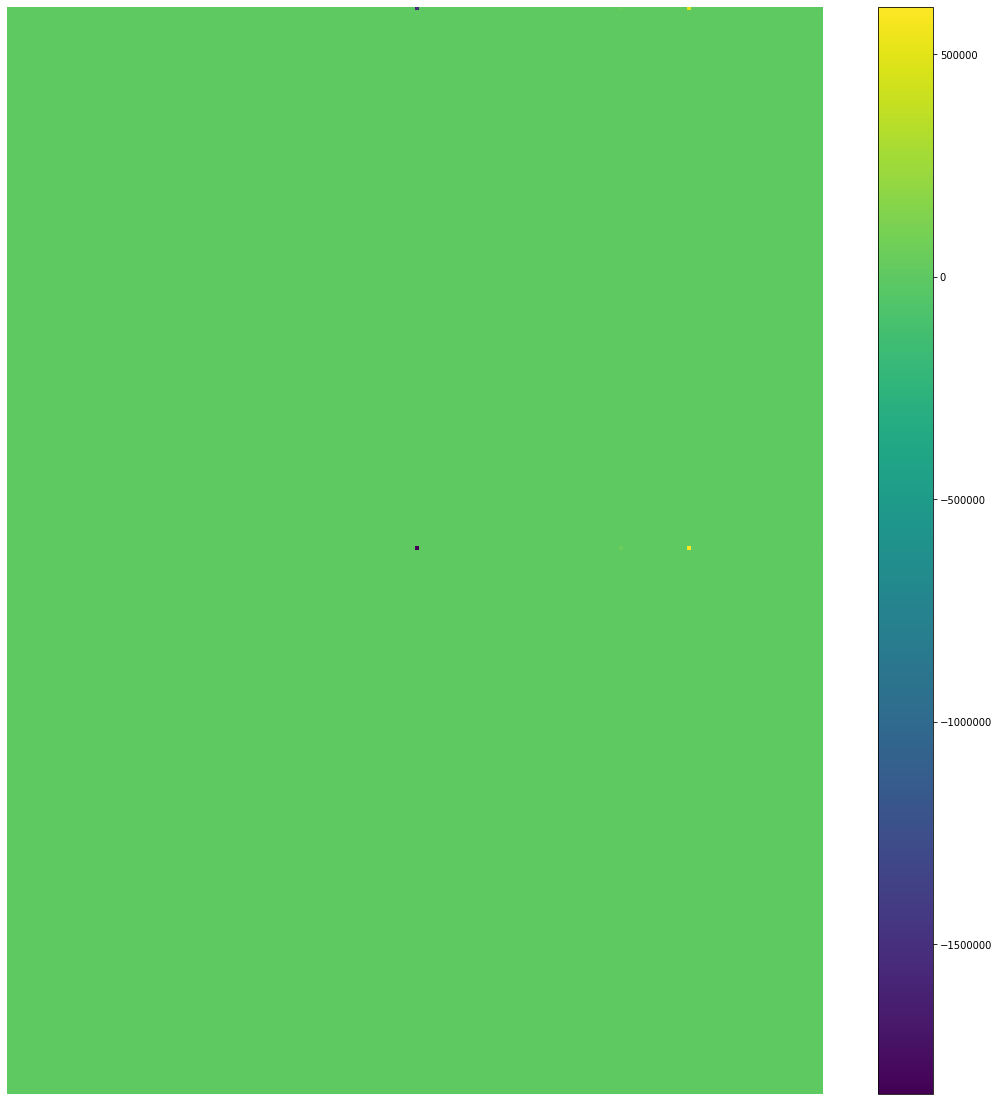

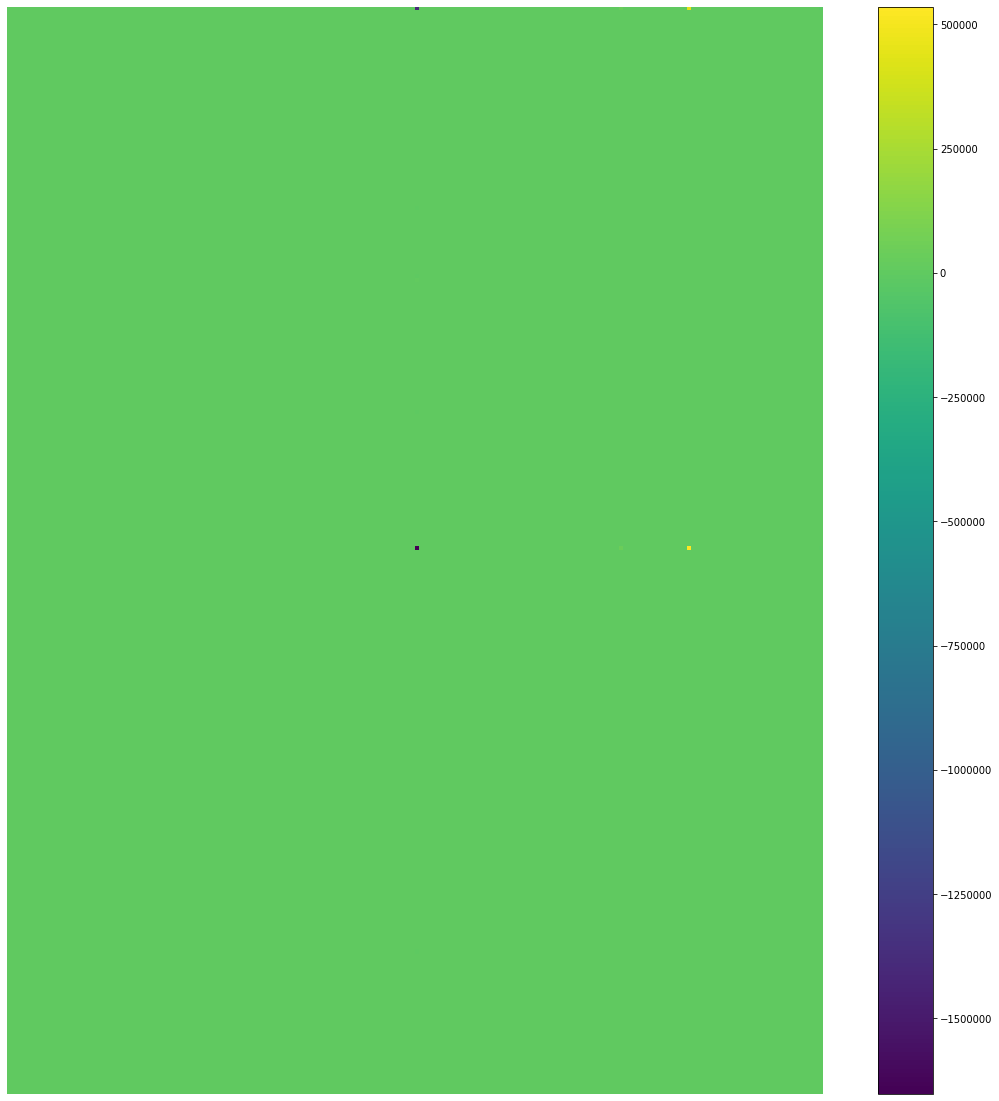

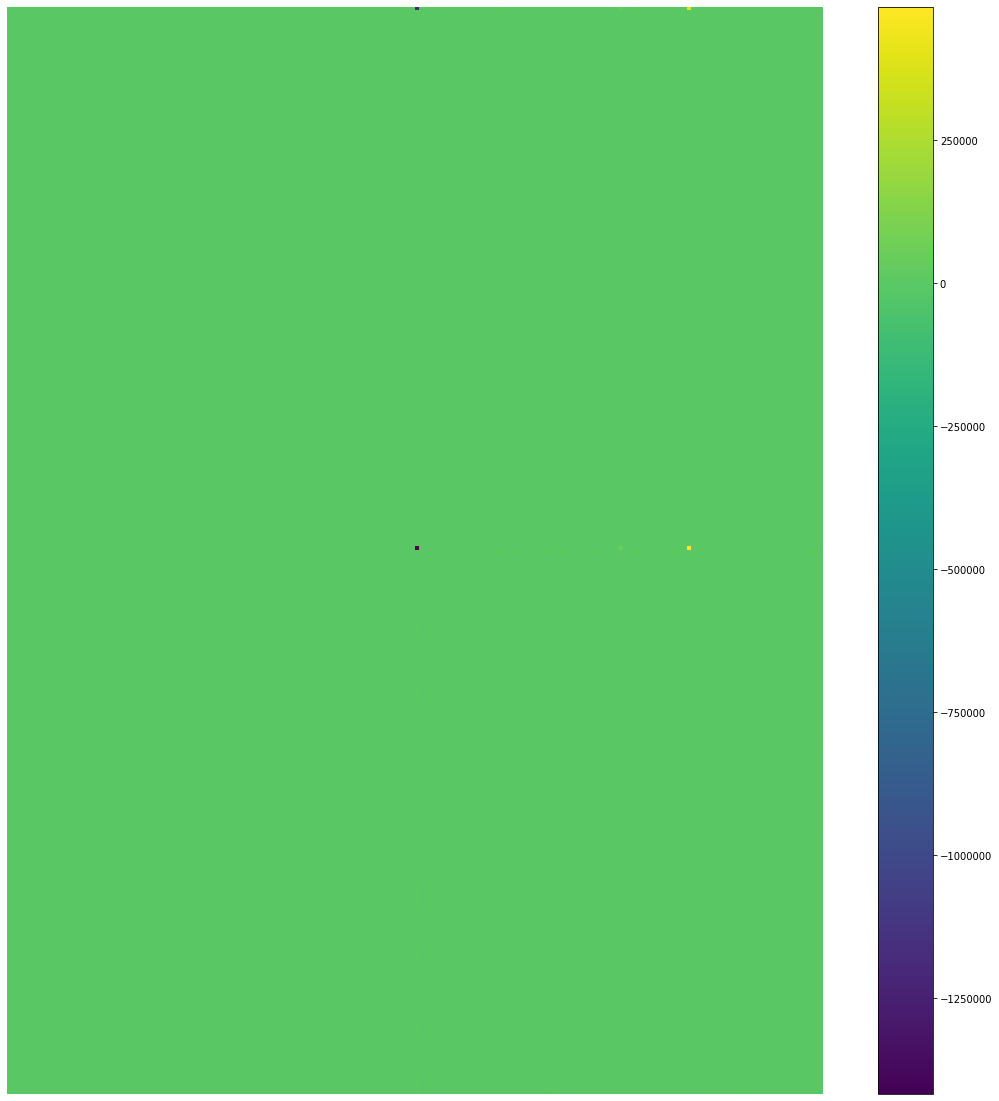

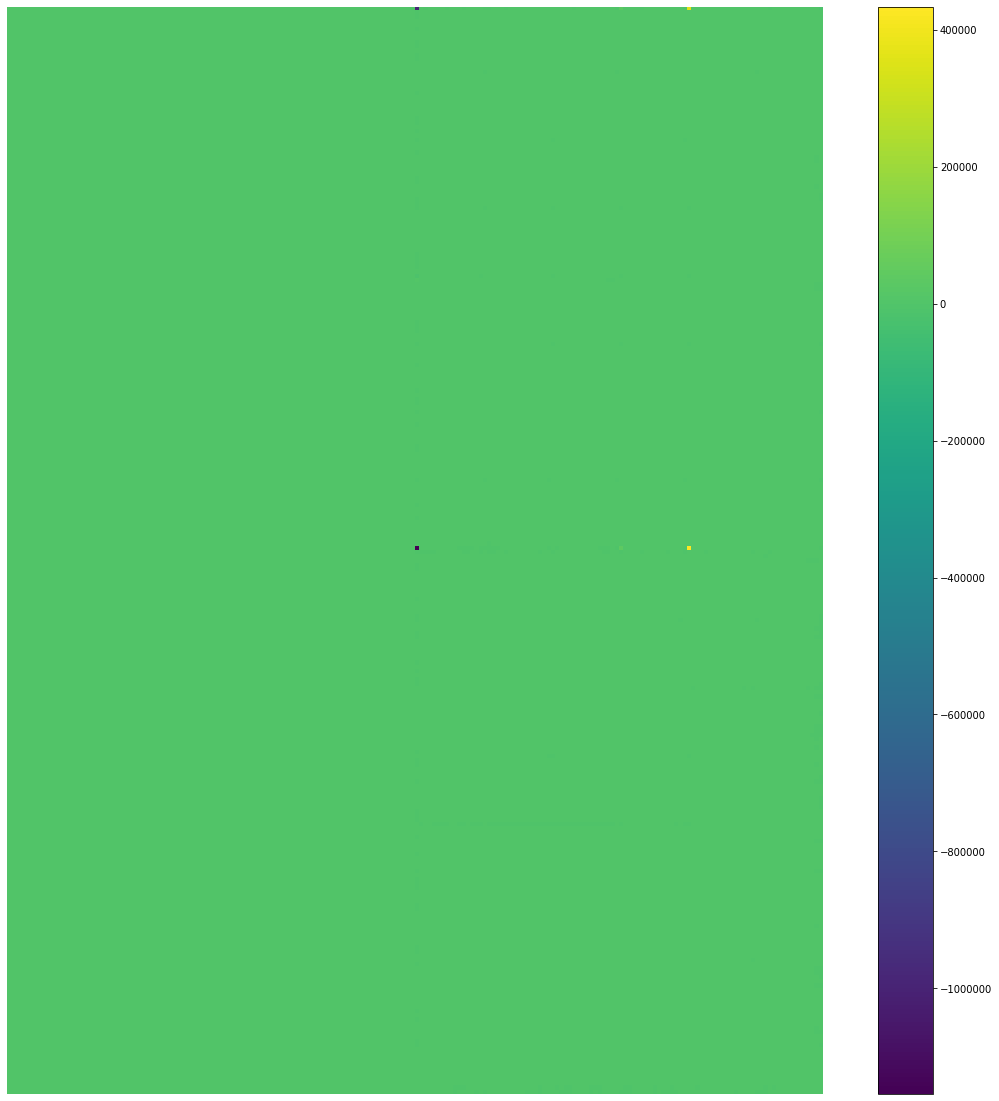

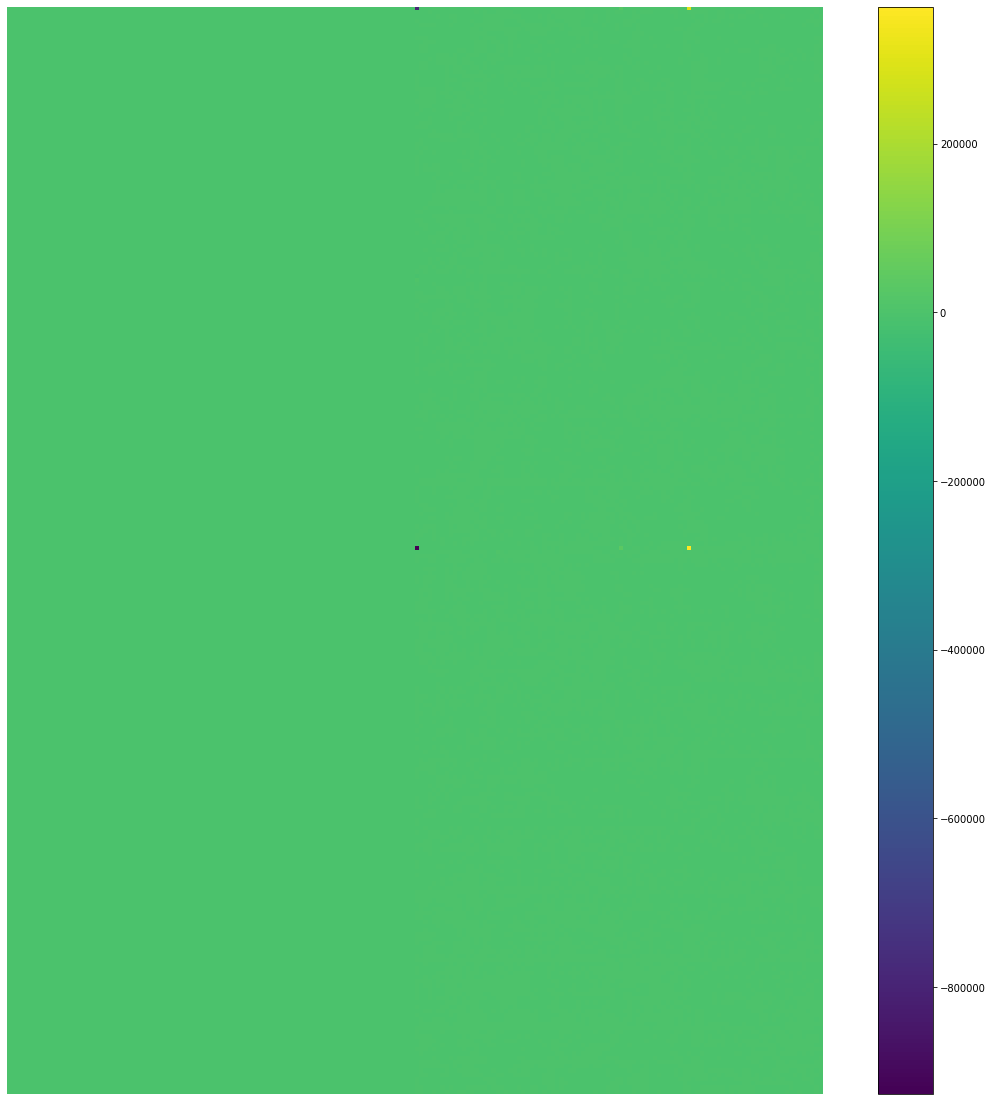

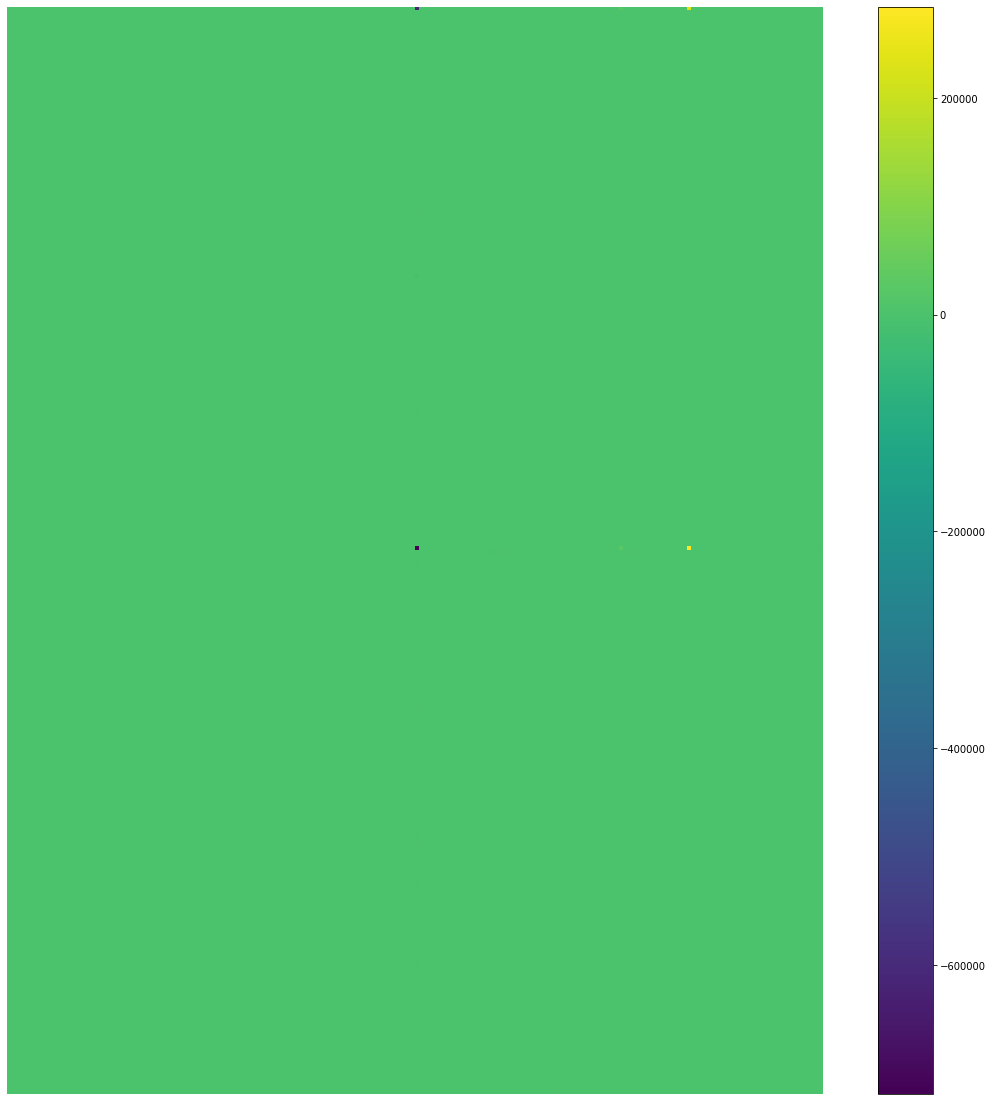

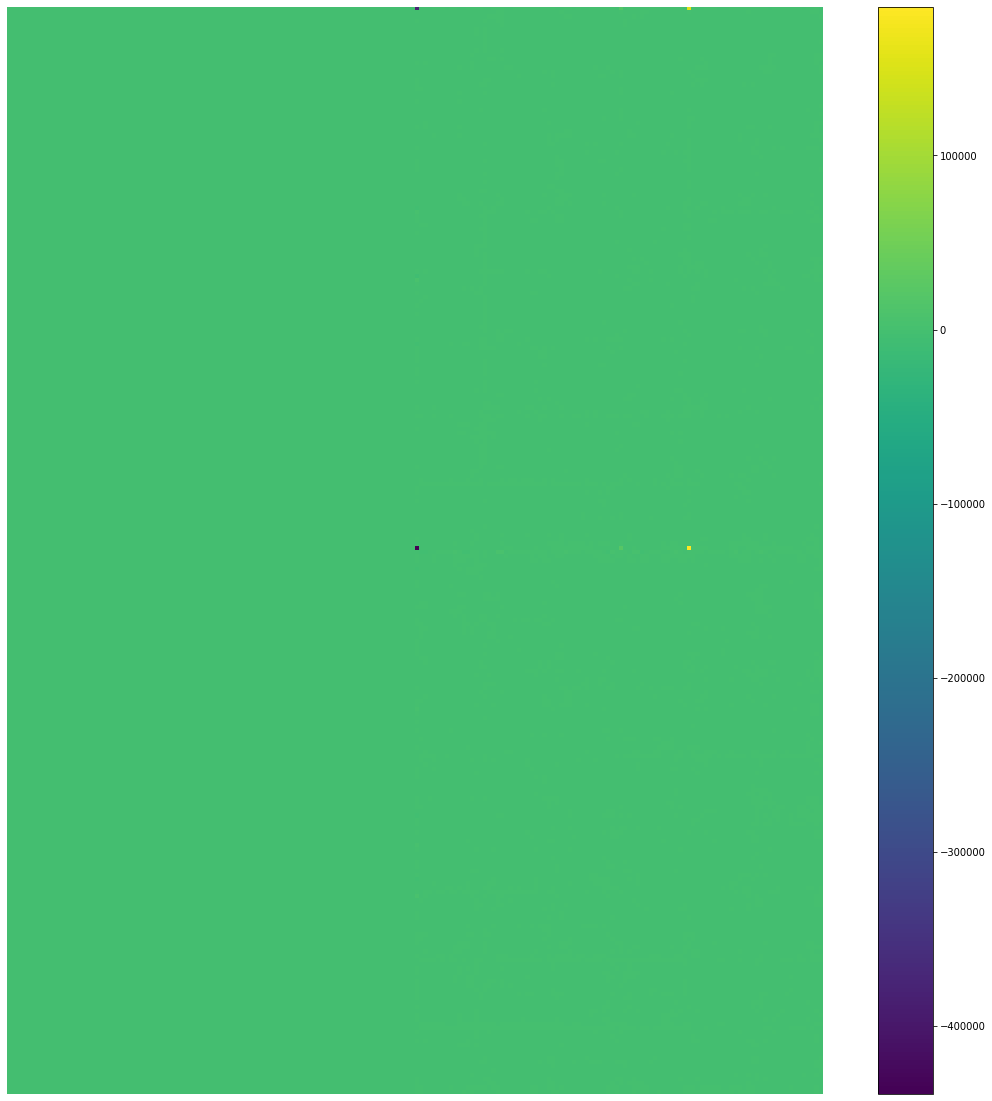

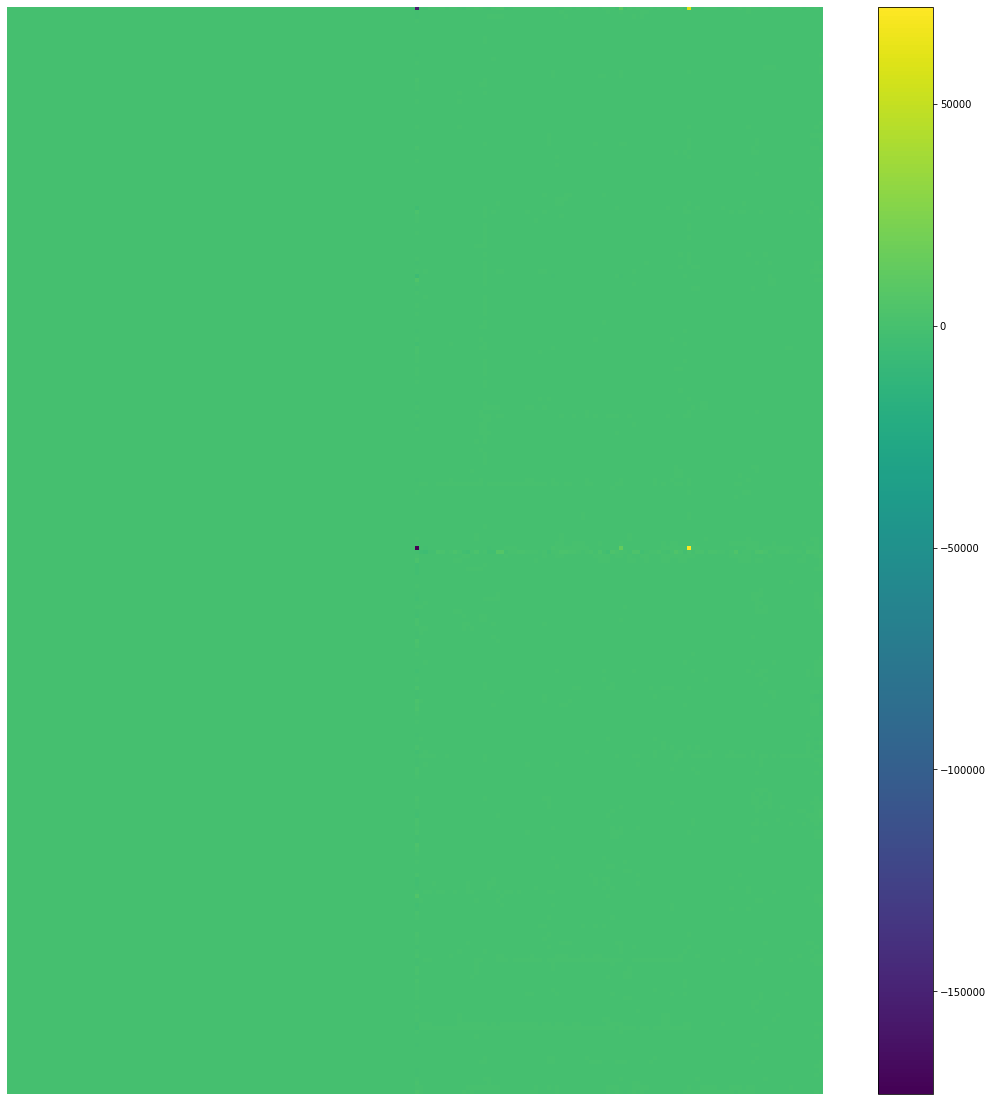

In [36]:
E.eval()
G.eval()
for i, sampleBatch in enumerate(simDataLoader,start=1):
    with torch.no_grad():
        X,p = sampleBatch
        X = X.to(device)
        p = p.to(device)
        
        z = E(X)
        z[:,-p.shape[1]:] = p
        X_hat = G(z)
        
        X = X.detach().cpu().squeeze()
        X_hat = X_hat.detach().cpu().squeeze()
        plotSampleWprediction(X, X_hat)

